# R Notebook: CMIP5 Dry Spell Length Distributions, 1981-2010

Dry state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)
library(moments)
library(stringr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [4]:
setwd("\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\R\\Working\\CMIP5_1981_DryDays")

Now specify some parameters - just file names

In [5]:
feDPath <- "DryDays_CMIP5_1981-2010.feather"

In [6]:
LOCA_BREAK <- 168

## Initial Load and Process of DataFrame

In [7]:
dfDry <- read_feather(feDPath)
ddates <- as.Date( ISOdate( dfDry$Year, dfDry$Month, dfDry$Day ) )
dfDry["Date"] <- ddates

In [8]:
str(dfDry)

Classes 'tbl_df', 'tbl' and 'data.frame':	23170457 obs. of  6 variables:
 $ MGrid_Id : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Year     : num  1981 1981 1981 1981 1981 ...
 $ Month    : num  1 1 1 1 1 1 2 2 3 3 ...
 $ Day      : num  1 4 13 18 26 28 10 13 1 4 ...
 $ Dry_Count: num  1 3 1 6 1 11 2 15 1 2 ...
 $ Date     : Date, format: "1981-01-01" "1981-01-04" ...


In [9]:
head(dfDry)

MGrid_Id,Year,Month,Day,Dry_Count,Date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M100_169,1981,1,1,1,1981-01-01
M100_169,1981,1,4,3,1981-01-04
M100_169,1981,1,13,1,1981-01-13
M100_169,1981,1,18,6,1981-01-18
M100_169,1981,1,26,1,1981-01-26
M100_169,1981,1,28,11,1981-01-28


Need to get the integer Grid_Id from the model and grid id string

In [10]:
exGridID <- function(smgrid) {
    sNum <- str_split( smgrid, pattern="_")[[1]][2]
    aNum <- as.integer( sNum )
    return(aNum)
}

In [11]:
Grid_Id <- sapply( dfDry$MGrid_Id, exGridID )

In [12]:
dfDry <- cbind( dfDry, Grid_Id )

In [13]:
str(dfDry)

'data.frame':	23170457 obs. of  7 variables:
 $ MGrid_Id : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Year     : num  1981 1981 1981 1981 1981 ...
 $ Month    : num  1 1 1 1 1 1 2 2 3 3 ...
 $ Day      : num  1 4 13 18 26 28 10 13 1 4 ...
 $ Dry_Count: num  1 3 1 6 1 11 2 15 1 2 ...
 $ Date     : Date, format: "1981-01-01" "1981-01-04" ...
 $ Grid_Id  : int  169 169 169 169 169 169 169 169 169 169 ...


In [14]:
head(dfDry)

MGrid_Id,Year,Month,Day,Dry_Count,Date,Grid_Id
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>
M100_169,1981,1,1,1,1981-01-01,169
M100_169,1981,1,4,3,1981-01-04,169
M100_169,1981,1,13,1,1981-01-13,169
M100_169,1981,1,18,6,1981-01-18,169
M100_169,1981,1,26,1,1981-01-26,169
M100_169,1981,1,28,11,1981-01-28,169


In [15]:
tail(dfDry)

,MGrid_Id,Year,Month,Day,Dry_Count,Date,Grid_Id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>
23170452,M9_99,2010,11,1,3,2010-11-01,99
23170453,M9_99,2010,11,6,7,2010-11-06,99
23170454,M9_99,2010,11,17,12,2010-11-17,99
23170455,M9_99,2010,12,1,8,2010-12-01,99
23170456,M9_99,2010,12,11,18,2010-12-11,99
23170457,M9_99,2010,12,31,1,2010-12-31,99


Now need to filter or split by grid ID to get our LOCA and BCCA data sets.

In [16]:
dfLODry <- dfDry %>% filter( Grid_Id <= LOCA_BREAK )
dfBCDry <- dfDry %>% filter( Grid_Id > LOCA_BREAK )

In [17]:
nrow( dfLODry )

[1] 13849077

In [18]:
nrow( dfBCDry )

[1] 9321380

First filter for each month with all Grid_Id

In [19]:
dLOJan <- dfLODry %>% filter( Month == 1 )
dLOFeb <- dfLODry %>% filter( Month == 2 )
dLOMar <- dfLODry %>% filter( Month == 3 )
dLOApr <- dfLODry %>% filter( Month == 4 )
dLOMay <- dfLODry %>% filter( Month == 5 )
dLOJun <- dfLODry %>% filter( Month == 6 )
dLOJul <- dfLODry %>% filter( Month == 7 )
dLOAug <- dfLODry %>% filter( Month == 8 )
dLOSep <- dfLODry %>% filter( Month == 9 )
dLOOct <- dfLODry %>% filter( Month == 10 )
dLONov <- dfLODry %>% filter( Month == 11 )
dLODec <- dfLODry %>% filter( Month == 12 )

In [20]:
dBCJan <- dfBCDry %>% filter( Month == 1 )
dBCFeb <- dfBCDry %>% filter( Month == 2 )
dBCMar <- dfBCDry %>% filter( Month == 3 )
dBCApr <- dfBCDry %>% filter( Month == 4 )
dBCMay <- dfBCDry %>% filter( Month == 5 )
dBCJun <- dfBCDry %>% filter( Month == 6 )
dBCJul <- dfBCDry %>% filter( Month == 7 )
dBCAug <- dfBCDry %>% filter( Month == 8 )
dBCSep <- dfBCDry %>% filter( Month == 9 )
dBCOct <- dfBCDry %>% filter( Month == 10 )
dBCNov <- dfBCDry %>% filter( Month == 11 )
dBCDec <- dfBCDry %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [21]:
MonLOSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

In [22]:
pvec <- seq(0,1,0.1)

In [23]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the dry day counts for each month

In [24]:
summary( dLOJan$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   5.000   7.601  10.000  90.000 

In [25]:
oQuants = quantile( dLOJan$Dry_Count, pvec )

In [26]:
MonLOSumStatDF[1, ] <-list( 1, mean(dLOJan$Dry_Count), median(dLOJan$Dry_Count), 
                          max(dLOJan$Dry_Count), min(dLOJan$Dry_Count), sd(dLOJan$Dry_Count),
                          var(dLOJan$Dry_Count), skewness(dLOJan$Dry_Count), 
                          kurtosis(dLOJan$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [27]:
summary( dLOFeb$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   5.000   7.008   9.000  93.000 

In [28]:
oQuants = quantile( dLOFeb$Dry_Count, pvec )

In [29]:
MonLOSumStatDF[2, ] <-list( 2, mean(dLOFeb$Dry_Count), median(dLOFeb$Dry_Count), 
                          max(dLOFeb$Dry_Count), min(dLOFeb$Dry_Count), sd(dLOFeb$Dry_Count),
                          var(dLOFeb$Dry_Count), skewness(dLOFeb$Dry_Count), 
                          kurtosis(dLOFeb$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [30]:
summary( dLOMar$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   5.000   6.988   9.000  78.000 

In [31]:
oQuants = quantile( dLOMar$Dry_Count, pvec )

In [32]:
MonLOSumStatDF[3, ] <-list( 3, mean(dLOMar$Dry_Count), median(dLOMar$Dry_Count), 
                          max(dLOMar$Dry_Count), min(dLOMar$Dry_Count), sd(dLOMar$Dry_Count),
                          var(dLOMar$Dry_Count), skewness(dLOMar$Dry_Count), 
                          kurtosis(dLOMar$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [33]:
summary( dLOApr$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   5.137   7.000  65.000 

In [34]:
oQuants = quantile( dLOApr$Dry_Count, pvec )

In [35]:
MonLOSumStatDF[4, ] <-list( 4, mean(dLOApr$Dry_Count), median(dLOApr$Dry_Count), 
                          max(dLOApr$Dry_Count), min(dLOApr$Dry_Count), sd(dLOApr$Dry_Count),
                          var(dLOApr$Dry_Count), skewness(dLOApr$Dry_Count), 
                          kurtosis(dLOApr$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [36]:
summary( dLOMay$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   4.142   5.000  86.000 

In [37]:
oQuants = quantile( dLOMay$Dry_Count, pvec )

In [38]:
MonLOSumStatDF[5, ] <-list( 5, mean(dLOMay$Dry_Count), median(dLOMay$Dry_Count), 
                          max(dLOMay$Dry_Count), min(dLOMay$Dry_Count), sd(dLOMay$Dry_Count),
                          var(dLOMay$Dry_Count), skewness(dLOMay$Dry_Count), 
                          kurtosis(dLOMay$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [39]:
summary( dLOJun$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   5.526   7.000  88.000 

In [40]:
oQuants = quantile( dLOJun$Dry_Count, pvec )

In [41]:
MonLOSumStatDF[6, ] <-list( 6, mean(dLOJun$Dry_Count), median(dLOJun$Dry_Count), 
                          max(dLOJun$Dry_Count), min(dLOJun$Dry_Count), sd(dLOJun$Dry_Count),
                          var(dLOJun$Dry_Count), skewness(dLOJun$Dry_Count), 
                          kurtosis(dLOJun$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [42]:
summary( dLOJul$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   6.813   9.000  78.000 

In [43]:
oQuants = quantile( dLOJul$Dry_Count, pvec )

In [44]:
MonLOSumStatDF[7, ] <-list( 7, mean(dLOJul$Dry_Count), median(dLOJul$Dry_Count), 
                          max(dLOJul$Dry_Count), min(dLOJul$Dry_Count), sd(dLOJul$Dry_Count),
                          var(dLOJul$Dry_Count), skewness(dLOJul$Dry_Count), 
                          kurtosis(dLOJul$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [45]:
summary( dLOAug$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   6.144   9.000  73.000 

In [46]:
oQuants = quantile( dLOAug$Dry_Count, pvec )

In [47]:
MonLOSumStatDF[8, ] <-list( 8, mean(dLOAug$Dry_Count), median(dLOAug$Dry_Count), 
                          max(dLOAug$Dry_Count), min(dLOAug$Dry_Count), sd(dLOAug$Dry_Count),
                          var(dLOAug$Dry_Count), skewness(dLOAug$Dry_Count), 
                          kurtosis(dLOAug$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [48]:
summary( dLOSep$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   5.096   7.000  74.000 

In [49]:
oQuants = quantile( dLOSep$Dry_Count, pvec )

In [50]:
MonLOSumStatDF[9, ] <-list( 9, mean(dLOSep$Dry_Count), median(dLOSep$Dry_Count), 
                          max(dLOSep$Dry_Count), min(dLOSep$Dry_Count), sd(dLOSep$Dry_Count),
                          var(dLOSep$Dry_Count), skewness(dLOSep$Dry_Count), 
                          kurtosis(dLOSep$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [51]:
summary( dLOOct$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   6.233   8.000  95.000 

In [52]:
oQuants = quantile( dLOOct$Dry_Count, pvec )

In [53]:
MonLOSumStatDF[10, ] <-list( 10, mean(dLOOct$Dry_Count), median(dLOOct$Dry_Count), 
                          max(dLOOct$Dry_Count), min(dLOOct$Dry_Count), sd(dLOOct$Dry_Count),
                          var(dLOOct$Dry_Count), skewness(dLOOct$Dry_Count), 
                          kurtosis(dLOOct$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [54]:
summary( dLONov$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   6.537   8.000 108.000 

In [55]:
oQuants = quantile( dLONov$Dry_Count, pvec )

In [56]:
MonLOSumStatDF[11, ] <-list( 11, mean(dLONov$Dry_Count), median(dLONov$Dry_Count), 
                          max(dLONov$Dry_Count), min(dLONov$Dry_Count), sd(dLONov$Dry_Count),
                          var(dLONov$Dry_Count), skewness(dLONov$Dry_Count), 
                          kurtosis(dLONov$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [57]:
summary( dLODec$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   5.000   7.386  10.000  98.000 

In [58]:
oQuants = quantile( dLODec$Dry_Count, pvec )

In [59]:
MonLOSumStatDF[12, ] <-list( 12, mean(dLODec$Dry_Count), median(dLODec$Dry_Count), 
                          max(dLODec$Dry_Count), min(dLODec$Dry_Count), sd(dLODec$Dry_Count),
                          var(dLODec$Dry_Count), skewness(dLODec$Dry_Count), 
                          kurtosis(dLODec$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [60]:
print( MonLOSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 7.600758      5  90   1 7.504838 56.32259 2.100913  9.397912     1
     2 7.007583      5  93   1 7.157596 51.23118 2.496530 12.498572     1
     3 6.988409      5  78   1 6.685884 44.70105 1.917671  7.731303     1
     4 5.137130      4  65   1 4.694576 22.03905 2.128416  9.607015     1
     5 4.141581      3  86   1 4.251158 18.07234 3.420451 28.536437     1
     6 5.525916      3  88   1 6.812736 46.41337 3.085937 16.286446     1
     7 6.813155      4  78   1 7.404316 54.82390 2.205005  8.967179     1
     8 6.144145      4  73   1 6.013247 36.15914 2.018084  9.016541     1
     9 5.095597      3  74   1 5.321001 28.31305 2.618608 13.504153     1
    10 6.233228      4  95   1 6.858976 47.04556 3.013749 19.302847     1
    11 6.536864      4 108   1 7.289011 53.12968 2.888305 16.871343     1
    12 7.386455      5  98   1 7.824787 61.22730 2.384616 11.389575     1
 perc10 perc20 perc30 perc40 perc50 pe

BCCA

In [61]:
MonBCSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

Now look at summary stats for the dry day counts for each month

In [62]:
summary( dBCJan$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   5.233   7.000  62.000 

In [63]:
oQuants = quantile( dBCJan$Dry_Count, pvec )

In [64]:
MonBCSumStatDF[1, ] <-list( 1, mean(dBCJan$Dry_Count), median(dBCJan$Dry_Count), 
                          max(dBCJan$Dry_Count), min(dBCJan$Dry_Count), sd(dBCJan$Dry_Count),
                          var(dBCJan$Dry_Count), skewness(dBCJan$Dry_Count), 
                          kurtosis(dBCJan$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [65]:
summary( dBCFeb$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   4.759   6.000  57.000 

In [66]:
oQuants = quantile( dBCFeb$Dry_Count, pvec )

In [67]:
MonBCSumStatDF[2, ] <-list( 2, mean(dBCFeb$Dry_Count), median(dBCFeb$Dry_Count), 
                          max(dBCFeb$Dry_Count), min(dBCFeb$Dry_Count), sd(dBCFeb$Dry_Count),
                          var(dBCFeb$Dry_Count), skewness(dBCFeb$Dry_Count), 
                          kurtosis(dBCFeb$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [68]:
summary( dBCMar$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   4.552   6.000  62.000 

In [69]:
oQuants = quantile( dBCMar$Dry_Count, pvec )

In [70]:
MonBCSumStatDF[3, ] <-list( 3, mean(dBCMar$Dry_Count), median(dBCMar$Dry_Count), 
                          max(dBCMar$Dry_Count), min(dBCMar$Dry_Count), sd(dBCMar$Dry_Count),
                          var(dBCMar$Dry_Count), skewness(dBCMar$Dry_Count), 
                          kurtosis(dBCMar$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [71]:
summary( dBCApr$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.529   5.000  41.000 

In [72]:
oQuants = quantile( dBCApr$Dry_Count, pvec )

In [73]:
MonBCSumStatDF[4, ] <-list( 4, mean(dBCApr$Dry_Count), median(dBCApr$Dry_Count), 
                          max(dBCApr$Dry_Count), min(dBCApr$Dry_Count), sd(dBCApr$Dry_Count),
                          var(dBCApr$Dry_Count), skewness(dBCApr$Dry_Count), 
                          kurtosis(dBCApr$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [74]:
summary( dBCMay$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.772   4.000  55.000 

In [75]:
oQuants = quantile( dBCMay$Dry_Count, pvec )

In [76]:
MonBCSumStatDF[5, ] <-list( 5, mean(dBCMay$Dry_Count), median(dBCMay$Dry_Count), 
                          max(dBCMay$Dry_Count), min(dBCMay$Dry_Count), sd(dBCMay$Dry_Count),
                          var(dBCMay$Dry_Count), skewness(dBCMay$Dry_Count), 
                          kurtosis(dBCMay$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [77]:
summary( dBCJun$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.153   4.000  51.000 

In [78]:
oQuants = quantile( dBCJun$Dry_Count, pvec )

In [79]:
MonBCSumStatDF[6, ] <-list( 6, mean(dBCJun$Dry_Count), median(dBCJun$Dry_Count), 
                          max(dBCJun$Dry_Count), min(dBCJun$Dry_Count), sd(dBCJun$Dry_Count),
                          var(dBCJun$Dry_Count), skewness(dBCJun$Dry_Count), 
                          kurtosis(dBCJun$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [80]:
summary( dBCJul$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.326   4.000  46.000 

In [81]:
oQuants = quantile( dBCJul$Dry_Count, pvec )

In [82]:
MonBCSumStatDF[7, ] <-list( 7, mean(dBCJul$Dry_Count), median(dBCJul$Dry_Count), 
                          max(dBCJul$Dry_Count), min(dBCJul$Dry_Count), sd(dBCJul$Dry_Count),
                          var(dBCJul$Dry_Count), skewness(dBCJul$Dry_Count), 
                          kurtosis(dBCJul$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [83]:
summary( dBCAug$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.961   4.000  36.000 

In [84]:
oQuants = quantile( dBCAug$Dry_Count, pvec )

In [85]:
MonBCSumStatDF[8, ] <-list( 8, mean(dBCAug$Dry_Count), median(dBCAug$Dry_Count), 
                          max(dBCAug$Dry_Count), min(dBCAug$Dry_Count), sd(dBCAug$Dry_Count),
                          var(dBCAug$Dry_Count), skewness(dBCAug$Dry_Count), 
                          kurtosis(dBCAug$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [86]:
summary( dBCSep$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.225   4.000  59.000 

In [87]:
oQuants = quantile( dBCSep$Dry_Count, pvec )

In [88]:
MonBCSumStatDF[9, ] <-list( 9, mean(dBCSep$Dry_Count), median(dBCSep$Dry_Count), 
                          max(dBCSep$Dry_Count), min(dBCSep$Dry_Count), sd(dBCSep$Dry_Count),
                          var(dBCSep$Dry_Count), skewness(dBCSep$Dry_Count), 
                          kurtosis(dBCSep$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [89]:
summary( dBCOct$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   4.652   6.000  63.000 

In [90]:
oQuants = quantile( dBCOct$Dry_Count, pvec )

In [91]:
MonBCSumStatDF[10, ] <-list( 10, mean(dBCOct$Dry_Count), median(dBCOct$Dry_Count), 
                          max(dBCOct$Dry_Count), min(dBCOct$Dry_Count), sd(dBCOct$Dry_Count),
                          var(dBCOct$Dry_Count), skewness(dBCOct$Dry_Count), 
                          kurtosis(dBCOct$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [92]:
summary( dBCNov$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   5.412   7.000  69.000 

In [93]:
oQuants = quantile( dBCNov$Dry_Count, pvec )

In [94]:
MonBCSumStatDF[11, ] <-list( 11, mean(dBCNov$Dry_Count), median(dBCNov$Dry_Count), 
                          max(dBCNov$Dry_Count), min(dBCNov$Dry_Count), sd(dBCNov$Dry_Count),
                          var(dBCNov$Dry_Count), skewness(dBCNov$Dry_Count), 
                          kurtosis(dBCNov$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [95]:
summary( dBCDec$Dry_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   5.596   7.000  71.000 

In [96]:
oQuants = quantile( dBCDec$Dry_Count, pvec )

In [97]:
MonBCSumStatDF[12, ] <-list( 12, mean(dBCDec$Dry_Count), median(dBCDec$Dry_Count), 
                          max(dBCDec$Dry_Count), min(dBCDec$Dry_Count), sd(dBCDec$Dry_Count),
                          var(dBCDec$Dry_Count), skewness(dBCDec$Dry_Count), 
                          kurtosis(dBCDec$Dry_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [98]:
print( MonBCSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev       var     skew     kurt perc0
     1 5.232795      4  62   1 5.072086 25.726054 2.337544 11.65663     1
     2 4.758961      3  57   1 4.659340 21.709447 2.559629 13.39546     1
     3 4.552056      3  62   1 4.310468 18.580131 2.363248 11.60703     1
     4 3.528720      2  41   1 3.203368 10.261567 2.369992 11.77614     1
     5 2.772238      2  55   1 2.499897  6.249485 2.631517 14.51959     1
     6 3.153229      2  51   1 3.042004  9.253791 2.791661 15.44617     1
     7 3.326397      2  46   1 3.155598  9.957802 2.506960 12.44078     1
     8 2.961173      2  36   1 2.637636  6.957126 2.339089 11.36448     1
     9 3.225280      2  59   1 3.310460 10.959146 3.151666 19.57223     1
    10 4.652360      3  63   1 4.833483 23.362554 2.620941 13.72215     1
    11 5.412098      4  69   1 5.549279 30.794503 2.582534 13.21708     1
    12 5.595507      4  71   1 5.674180 32.196323 2.547454 13.33941     1
 perc10 perc20 perc30 perc40 perc50 pe

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and dry day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks exceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [99]:
LOMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

In [100]:
BCMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

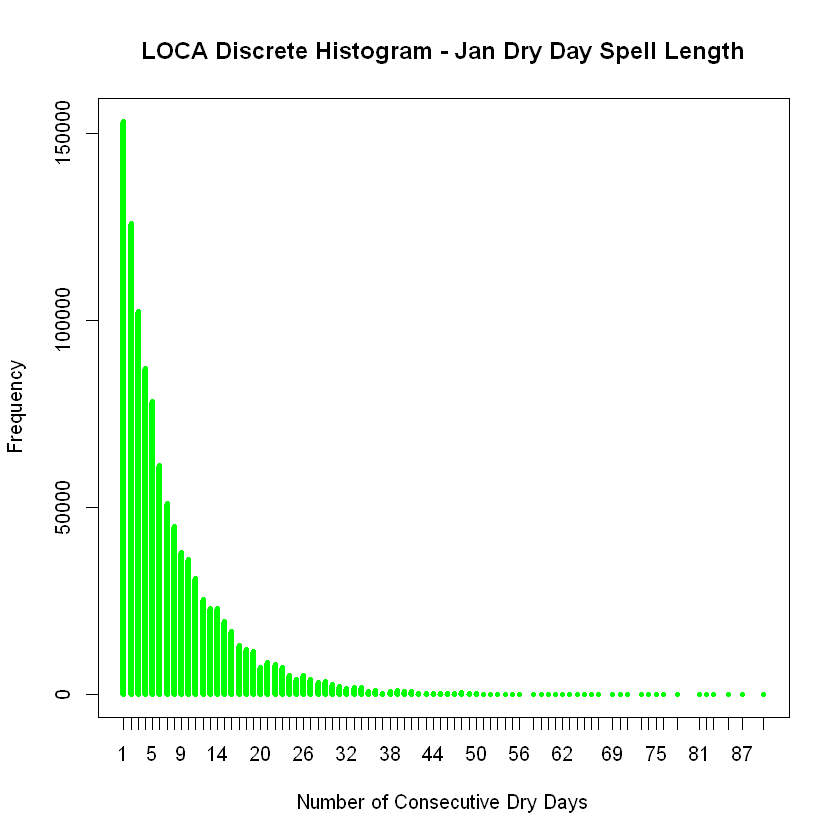

In [101]:
# our case is discrete so use this command
plot( table( dLOJan$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Jan Dry Day Spell Length", 
      col="green" )

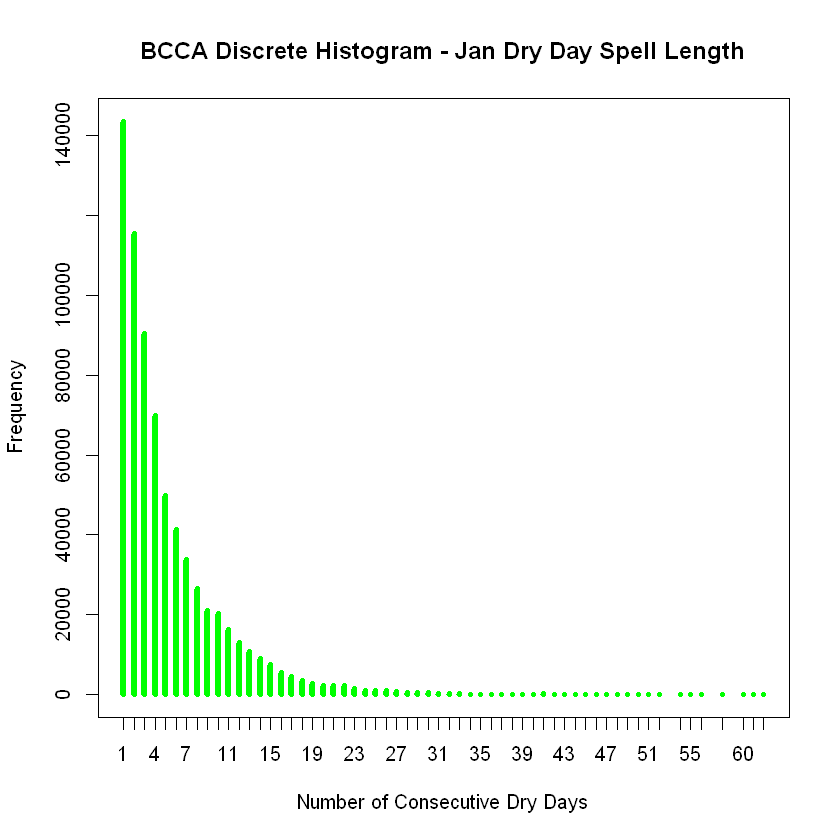

In [102]:
plot( table( dBCJan$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Jan Dry Day Spell Length", 
      col="green" )

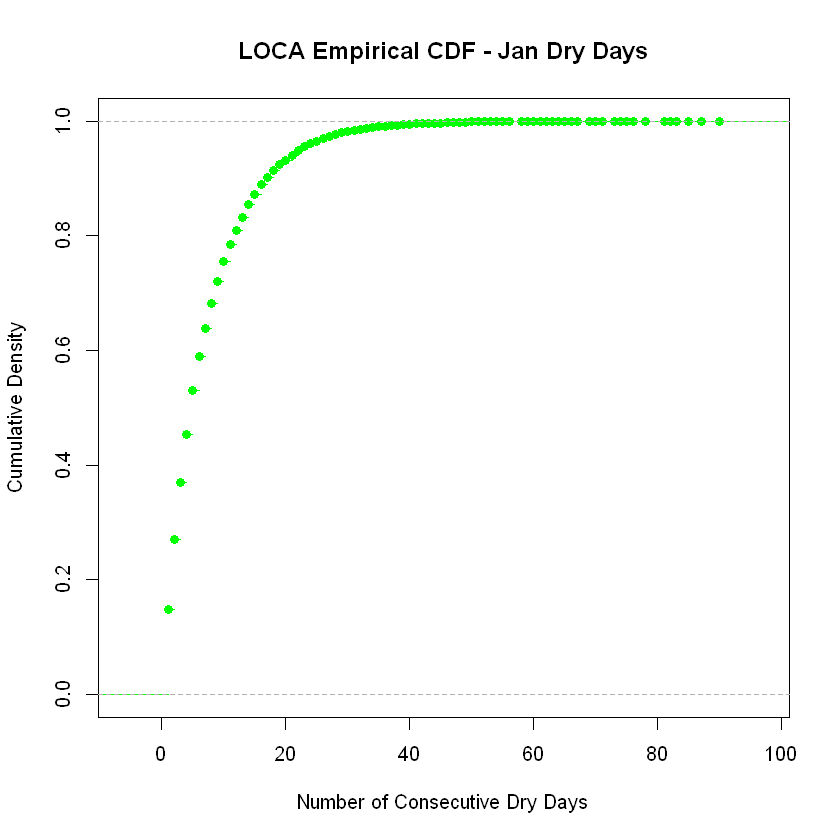

In [103]:
plot(ecdf(dLOJan$Dry_Count), main="LOCA Empirical CDF - Jan Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

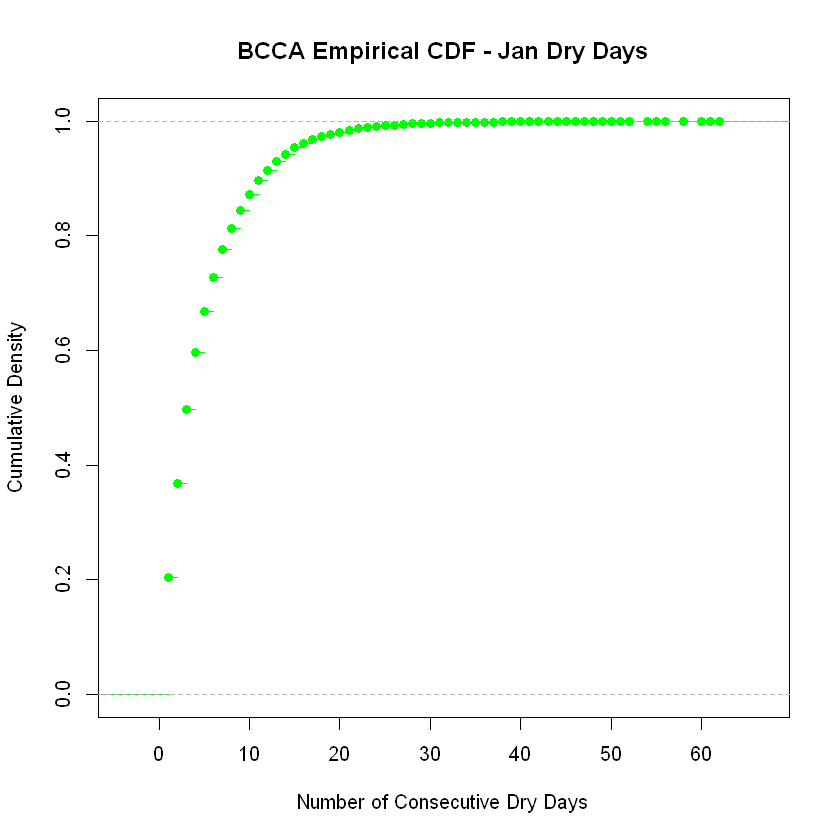

In [104]:
plot(ecdf(dBCJan$Dry_Count), main="BCCA Empirical CDF - Jan Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

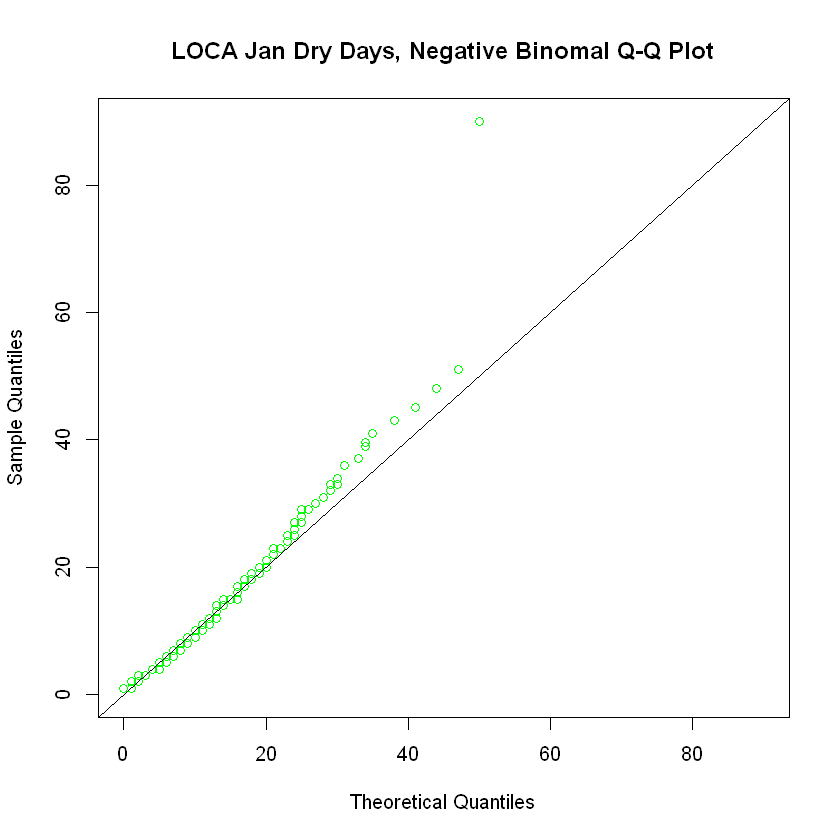

In [105]:
dLOJanMax <- max( dLOJan$Dry_Count )
dLOJanMean <- mean( dLOJan$Dry_Count )
dLOJanVar <- var( dLOJan$Dry_Count )
dLOJanBNr <- dLOJanMean^2 / (dLOJanVar - dLOJanMean)
dLOJanTstNB <- rnbinom( 1000, mu=dLOJanMean, size=dLOJanBNr )
qqplot( dLOJanTstNB, dLOJan$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jan Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJanMax), ylim=c(0,dLOJanMax) )
abline( 0, 1)

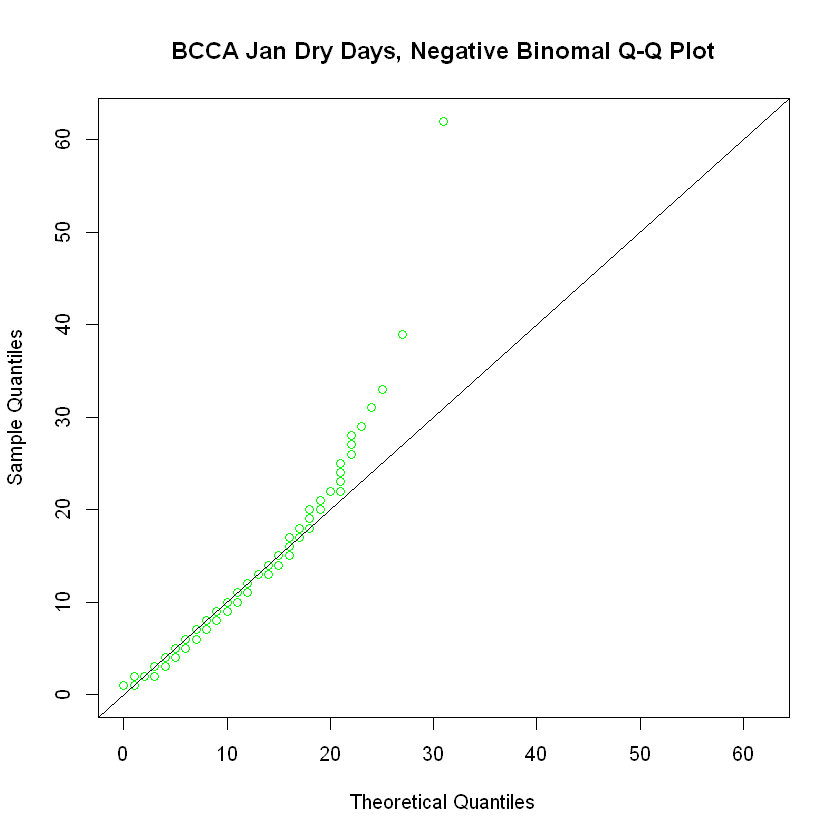

In [106]:
dBCJanMax <- max( dBCJan$Dry_Count )
dBCJanMean <- mean( dBCJan$Dry_Count )
dBCJanVar <- var( dBCJan$Dry_Count )
dBCJanBNr <- dBCJanMean^2 / (dBCJanVar - dBCJanMean)
dBCJanTstNB <- rnbinom( 1000, mu=dBCJanMean, size=dBCJanBNr )
qqplot( dBCJanTstNB, dBCJan$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jan Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJanMax), ylim=c(0,dBCJanMax) )
abline( 0, 1)

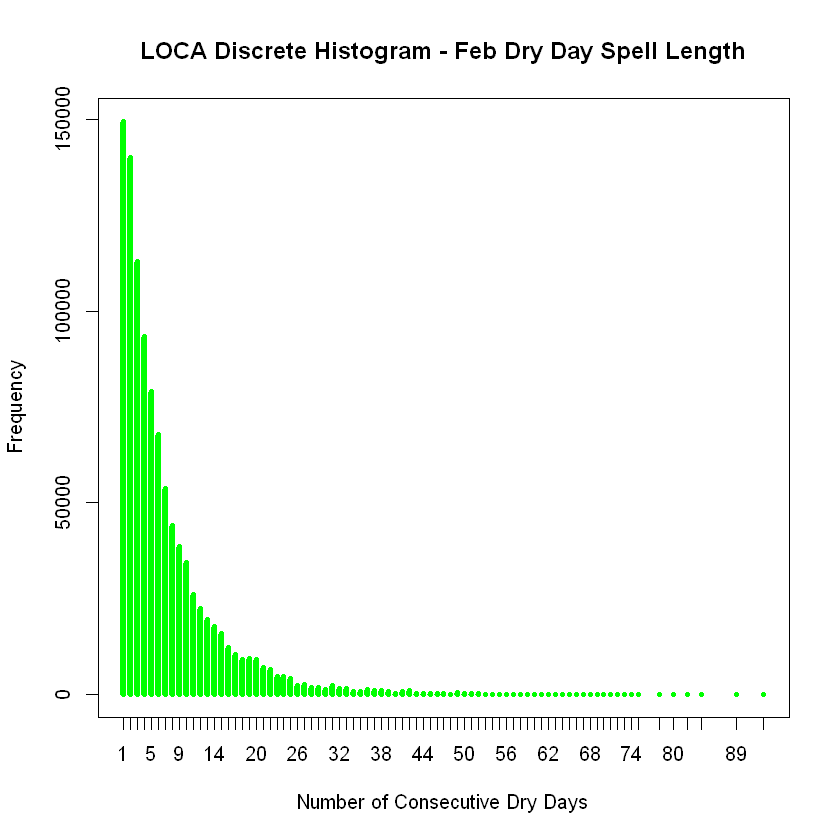

In [107]:
# our case is discrete so use this command
plot( table( dLOFeb$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Feb Dry Day Spell Length", 
      col="green" )

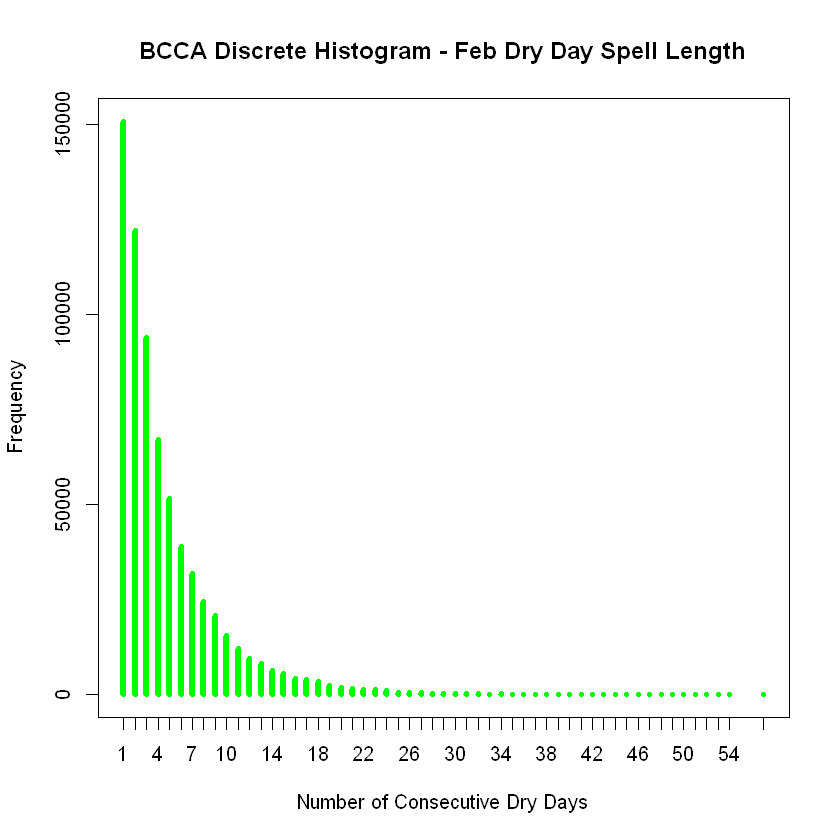

In [108]:
plot( table( dBCFeb$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Feb Dry Day Spell Length", 
      col="green" )

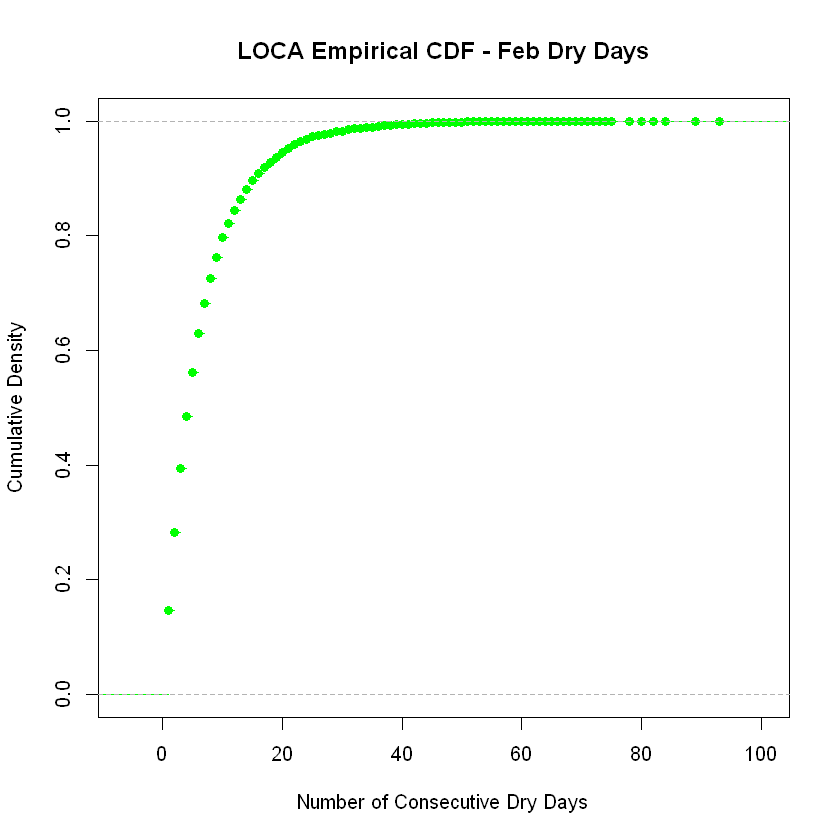

In [109]:
plot(ecdf(dLOFeb$Dry_Count), main="LOCA Empirical CDF - Feb Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

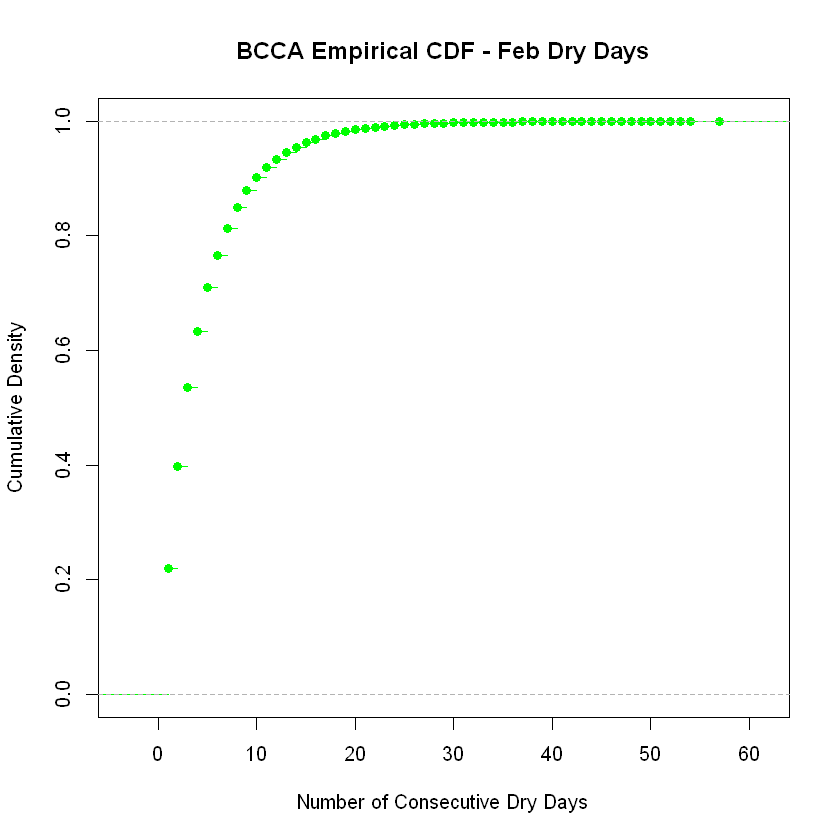

In [110]:
plot(ecdf(dBCFeb$Dry_Count), main="BCCA Empirical CDF - Feb Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

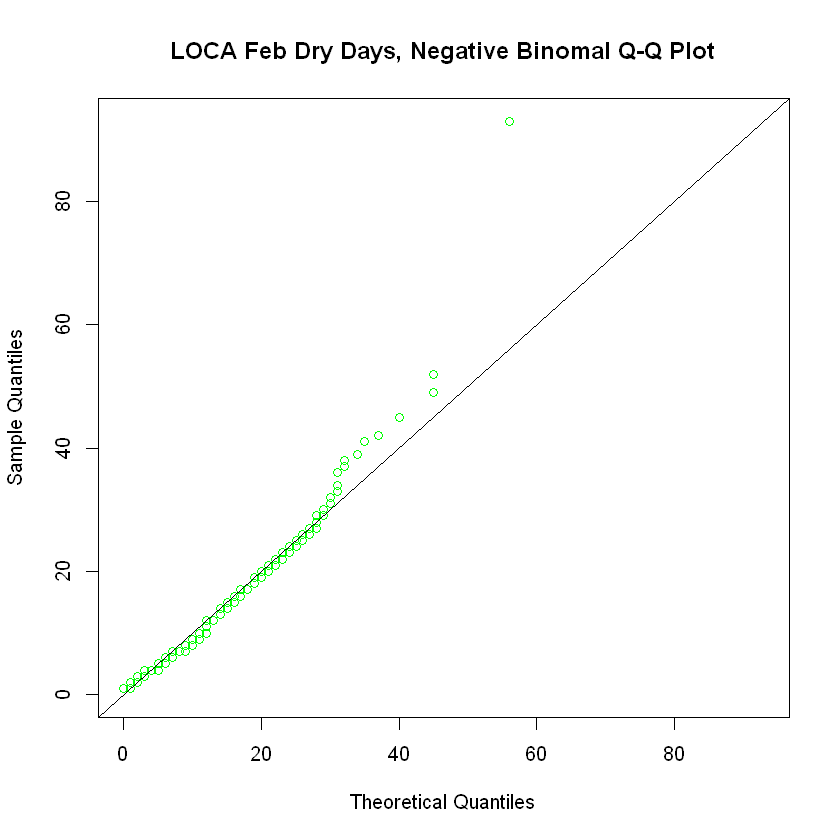

In [111]:
dLOFebMax <- max( dLOFeb$Dry_Count )
dLOFebMean <- mean( dLOFeb$Dry_Count )
dLOFebVar <- var( dLOFeb$Dry_Count )
dLOFebBNr <- dLOFebMean^2 / (dLOFebVar - dLOFebMean)
dLOFebTstNB <- rnbinom( 1000, mu=dLOFebMean, size=dLOFebBNr )
qqplot( dLOFebTstNB, dLOFeb$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Feb Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOFebMax), ylim=c(0,dLOFebMax) )
abline( 0, 1)

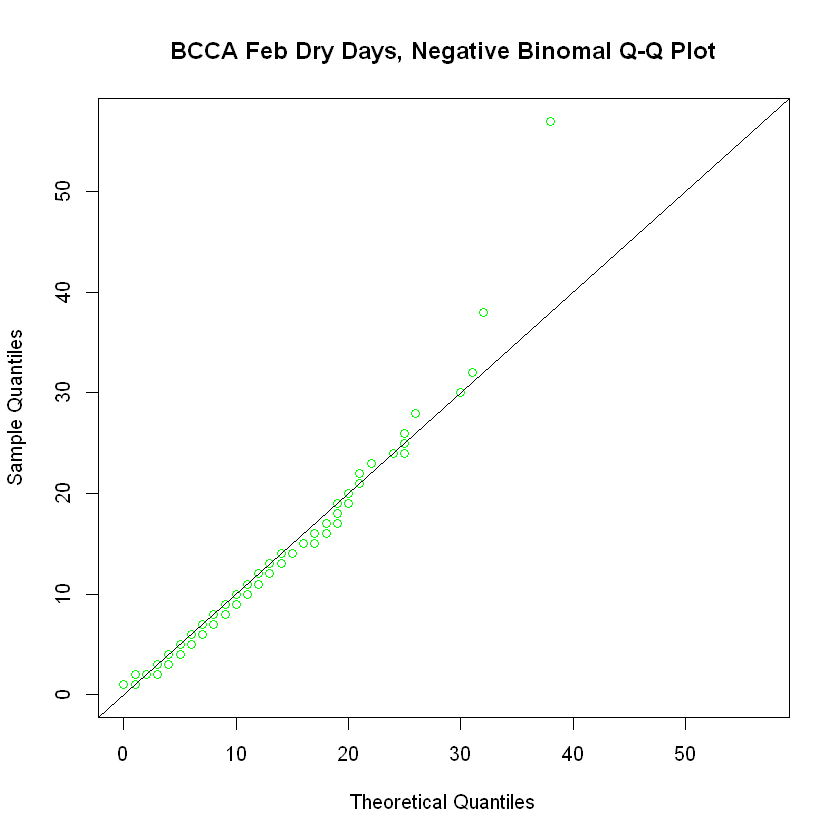

In [112]:
dBCFebMax <- max( dBCFeb$Dry_Count )
dBCFebMean <- mean( dBCFeb$Dry_Count )
dBCFebVar <- var( dBCFeb$Dry_Count )
dBCFebBNr <- dBCFebMean^2 / (dBCFebVar - dBCFebMean)
dBCFebTstNB <- rnbinom( 1000, mu=dBCFebMean, size=dBCFebBNr )
qqplot( dBCFebTstNB, dBCFeb$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Feb Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCFebMax), ylim=c(0,dBCFebMax) )
abline( 0, 1)

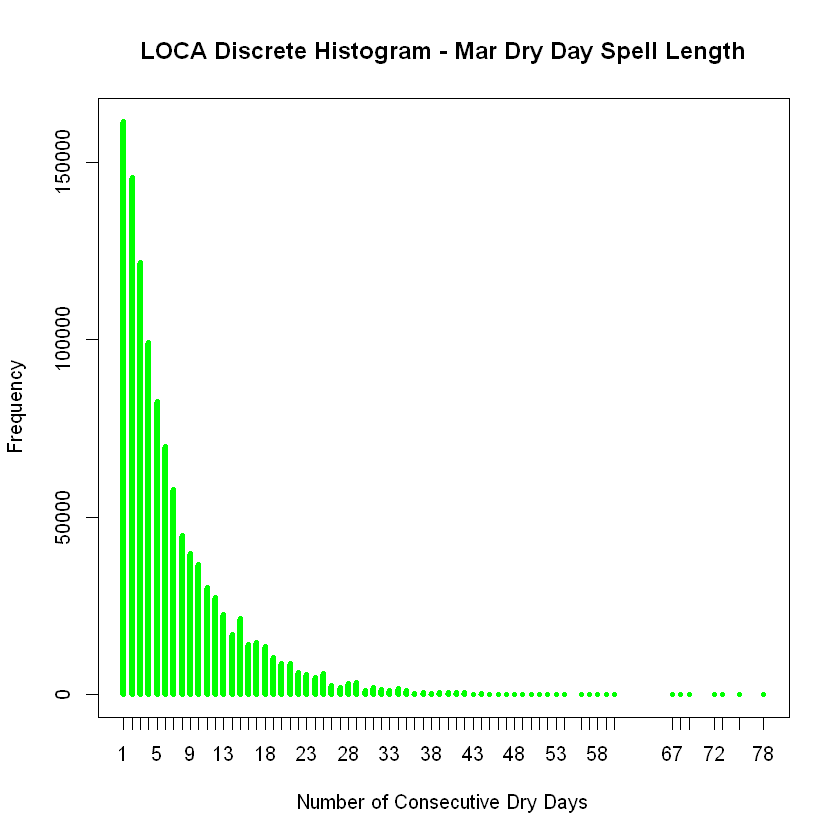

In [113]:
# our case is discrete so use this command
plot( table( dLOMar$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Mar Dry Day Spell Length", 
      col="green" )

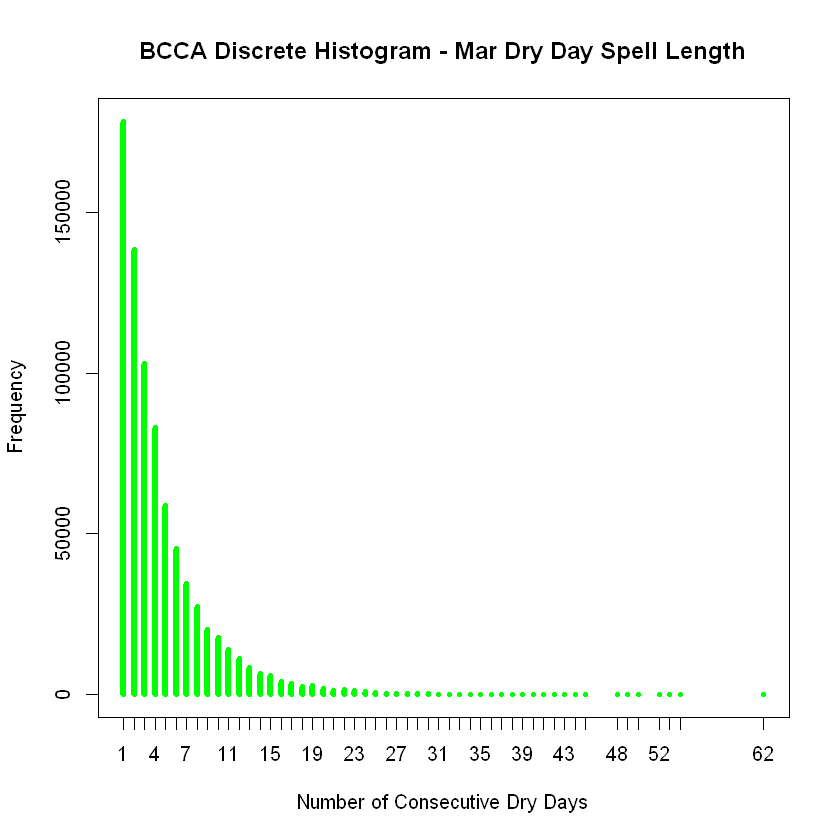

In [114]:
plot( table( dBCMar$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Mar Dry Day Spell Length", 
      col="green" )

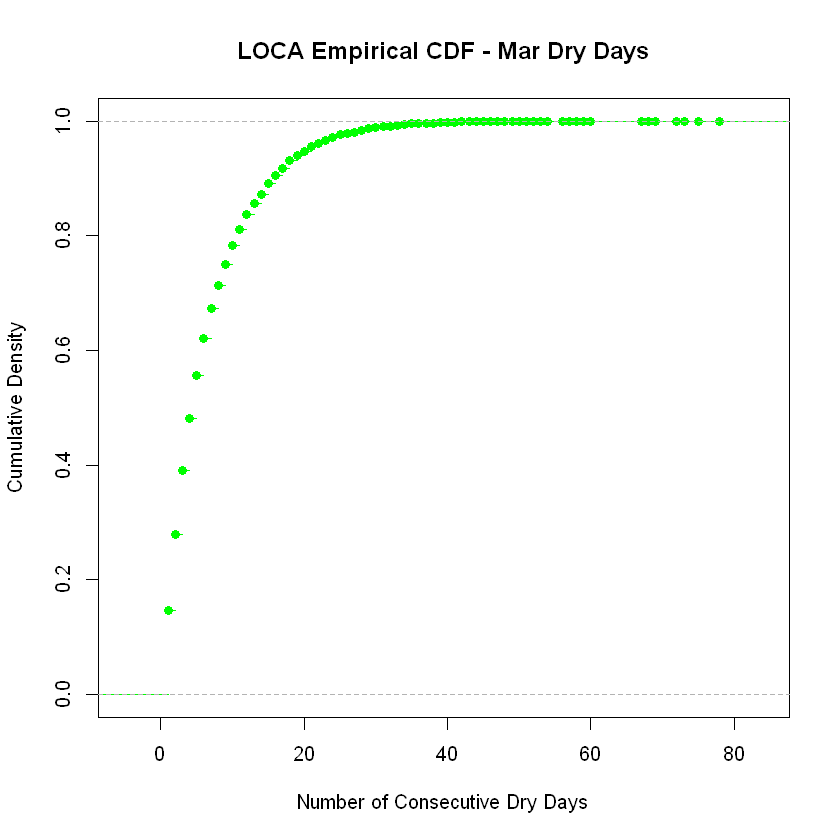

In [115]:
plot(ecdf(dLOMar$Dry_Count), main="LOCA Empirical CDF - Mar Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

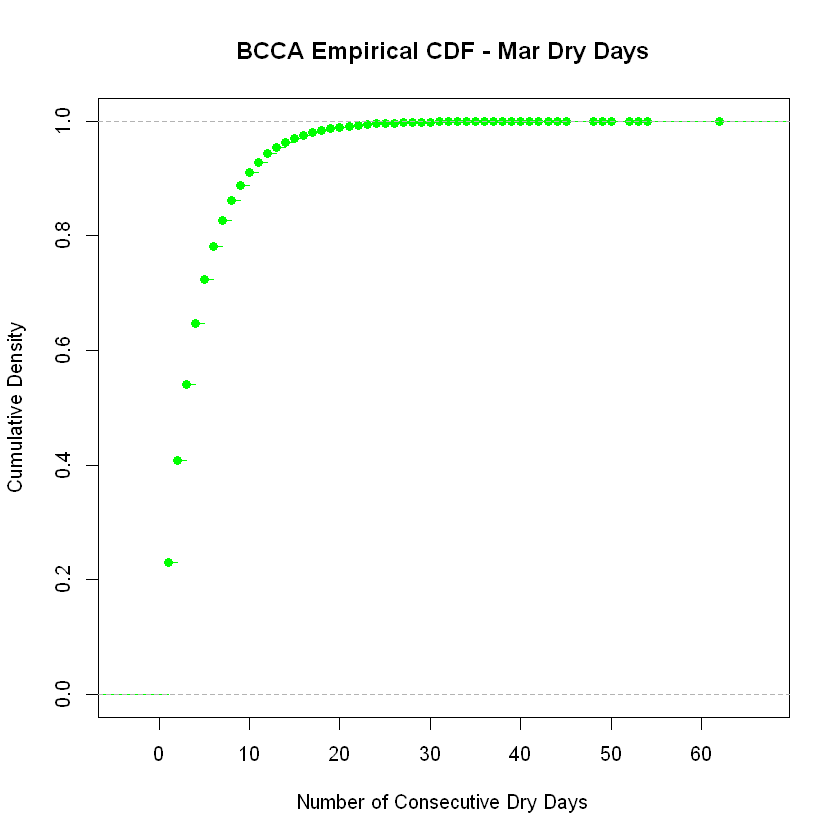

In [116]:
plot(ecdf(dBCMar$Dry_Count), main="BCCA Empirical CDF - Mar Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

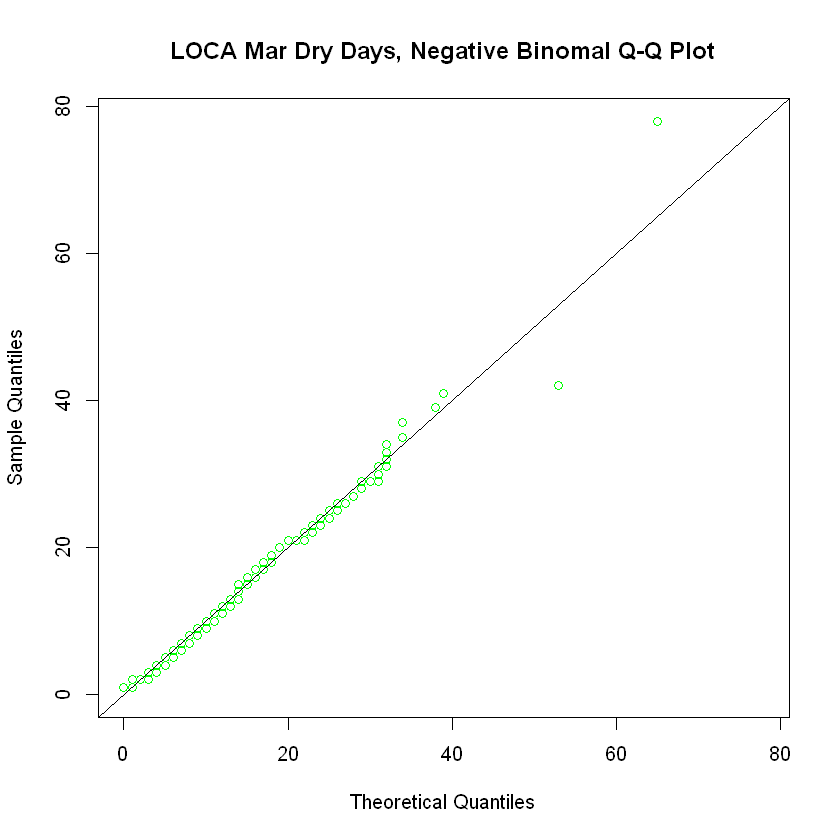

In [117]:
dLOMarMax <- max( dLOMar$Dry_Count )
dLOMarMean <- mean( dLOMar$Dry_Count )
dLOMarVar <- var( dLOMar$Dry_Count )
dLOMarBNr <- dLOMarMean^2 / (dLOMarVar - dLOMarMean)
dLOMarTstNB <- rnbinom( 1000, mu=dLOMarMean, size=dLOMarBNr )
qqplot( dLOMarTstNB, dLOMar$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Mar Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMarMax), ylim=c(0,dLOMarMax) )
abline( 0, 1)

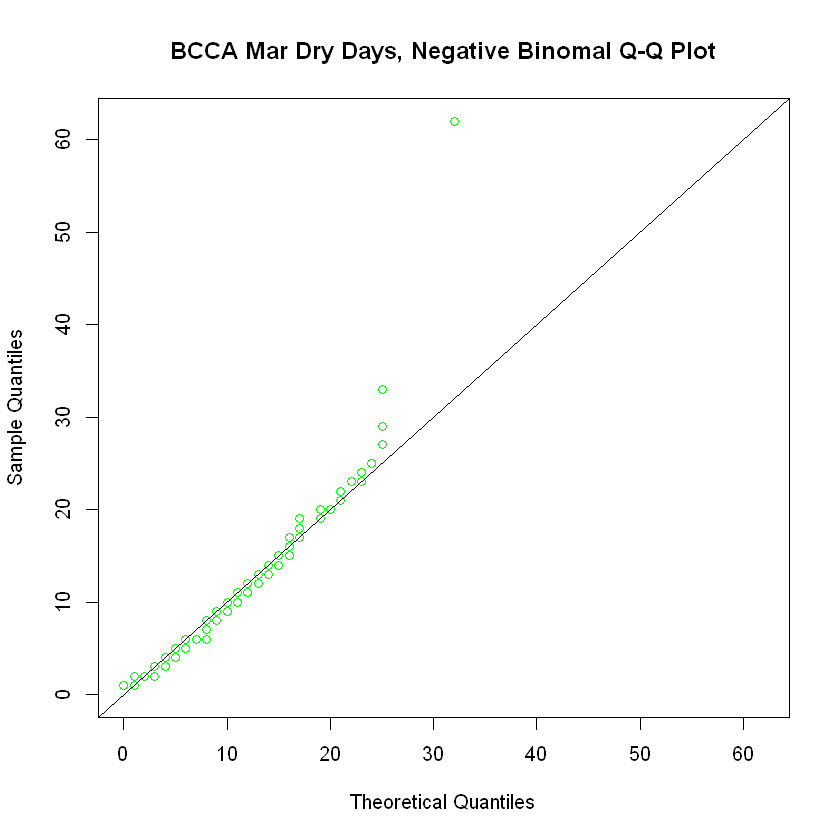

In [118]:
dBCMarMax <- max( dBCMar$Dry_Count )
dBCMarMean <- mean( dBCMar$Dry_Count )
dBCMarVar <- var( dBCMar$Dry_Count )
dBCMarBNr <- dBCMarMean^2 / (dBCMarVar - dBCMarMean)
dBCMarTstNB <- rnbinom( 1000, mu=dBCMarMean, size=dBCMarBNr )
qqplot( dBCMarTstNB, dBCMar$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Mar Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMarMax), ylim=c(0,dBCMarMax) )
abline( 0, 1)

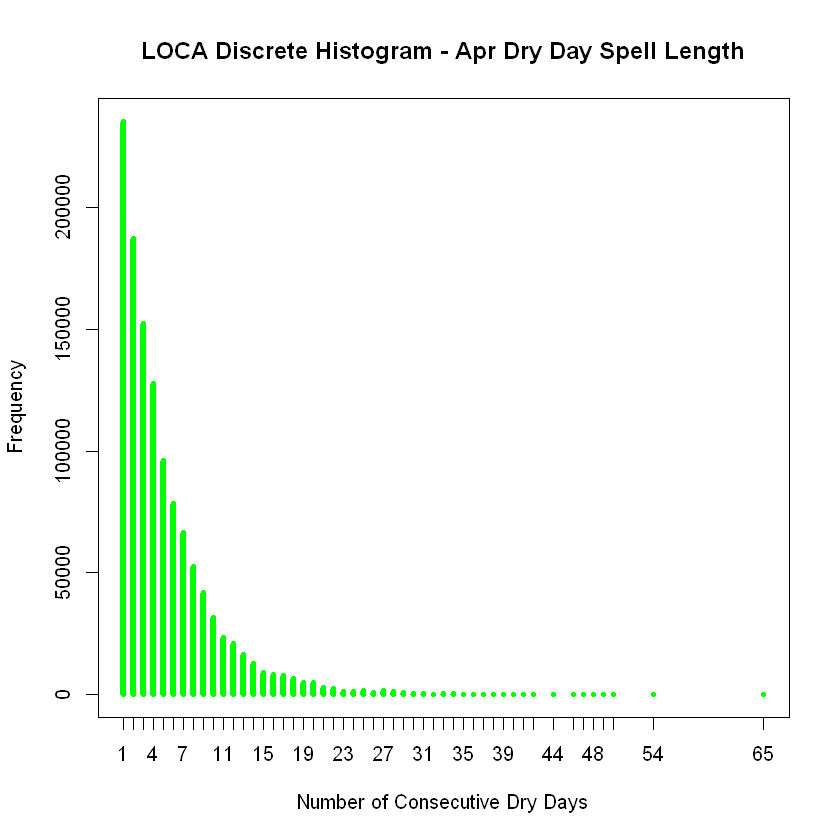

In [119]:
# our case is discrete so use this command
plot( table( dLOApr$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Apr Dry Day Spell Length", 
      col="green" )

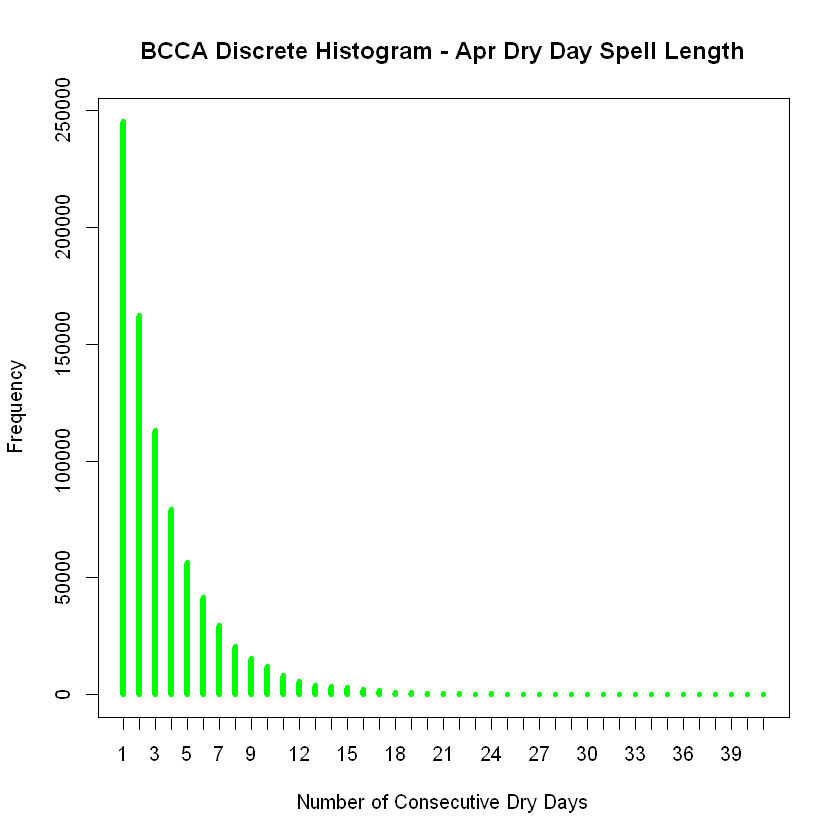

In [120]:
plot( table( dBCApr$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Apr Dry Day Spell Length", 
      col="green" )

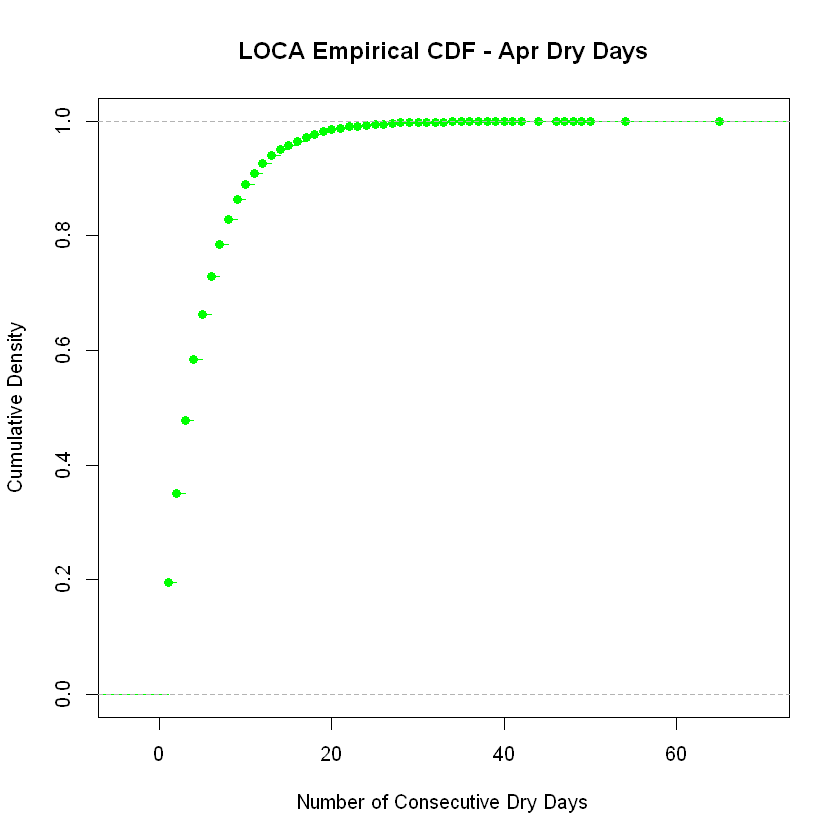

In [121]:
plot(ecdf(dLOApr$Dry_Count), main="LOCA Empirical CDF - Apr Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

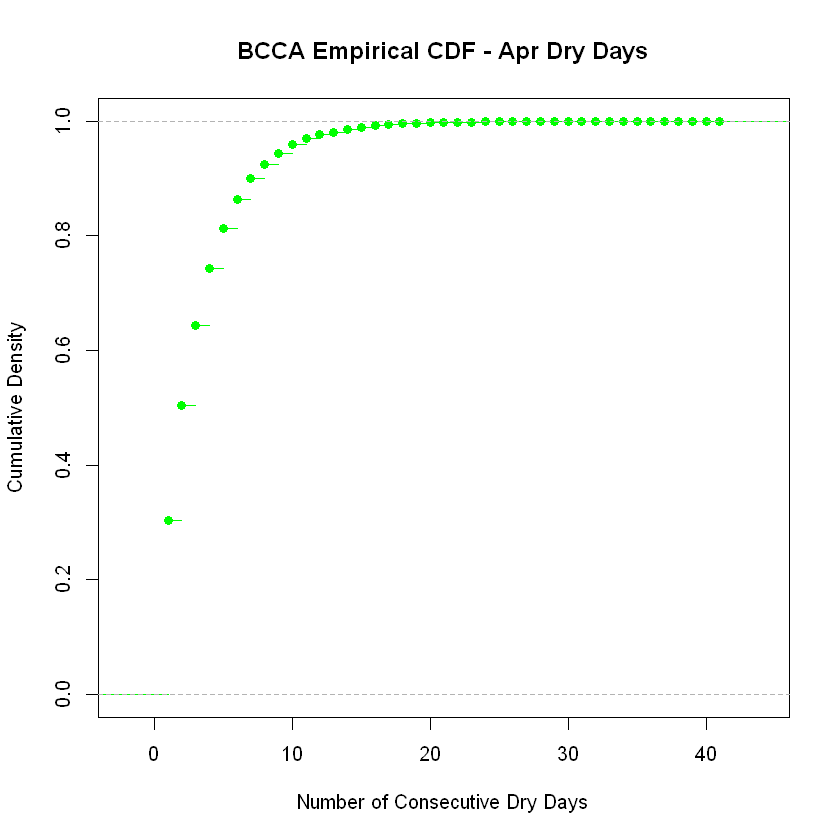

In [122]:
plot(ecdf(dBCApr$Dry_Count), main="BCCA Empirical CDF - Apr Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

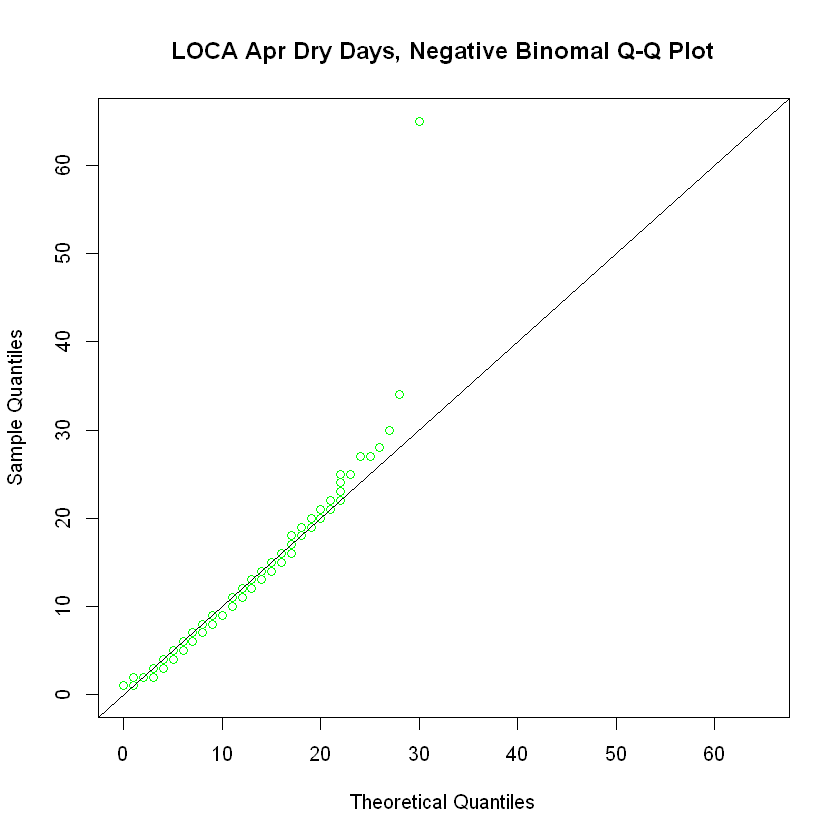

In [123]:
dLOAprMax <- max( dLOApr$Dry_Count )
dLOAprMean <- mean( dLOApr$Dry_Count )
dLOAprVar <- var( dLOApr$Dry_Count )
dLOAprBNr <- dLOAprMean^2 / (dLOAprVar - dLOAprMean)
dLOAprTstNB <- rnbinom( 1000, mu=dLOAprMean, size=dLOAprBNr )
qqplot( dLOAprTstNB, dLOApr$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Apr Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAprMax), ylim=c(0,dLOAprMax) )
abline( 0, 1)

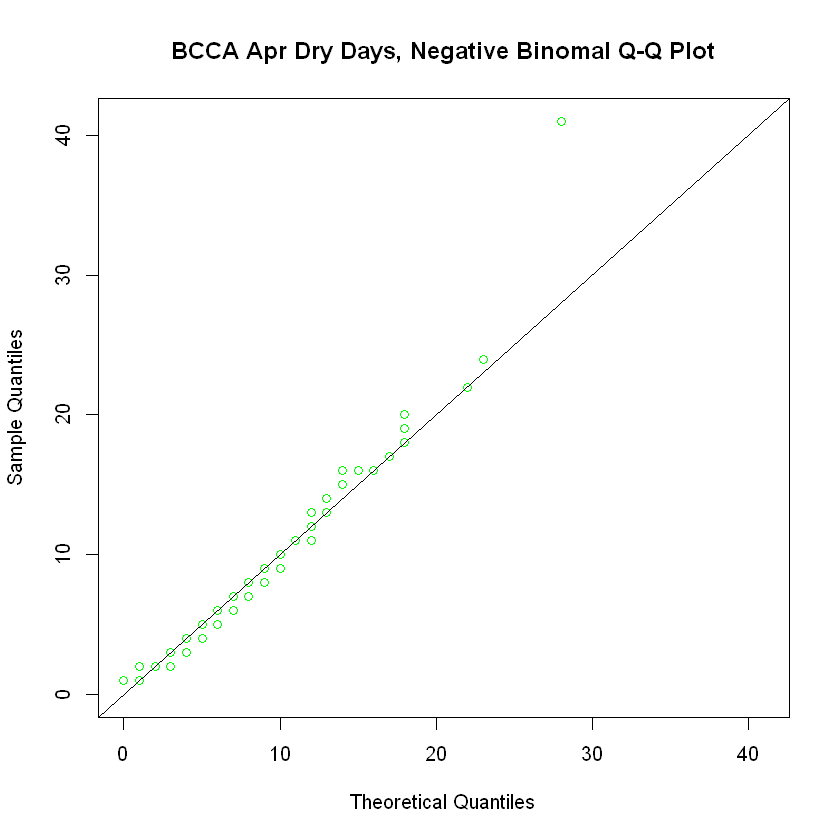

In [124]:
dBCAprMax <- max( dBCApr$Dry_Count )
dBCAprMean <- mean( dBCApr$Dry_Count )
dBCAprVar <- var( dBCApr$Dry_Count )
dBCAprBNr <- dBCAprMean^2 / (dBCAprVar - dBCAprMean)
dBCAprTstNB <- rnbinom( 1000, mu=dBCAprMean, size=dBCAprBNr )
qqplot( dBCAprTstNB, dBCApr$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Apr Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAprMax), ylim=c(0,dBCAprMax) )
abline( 0, 1)

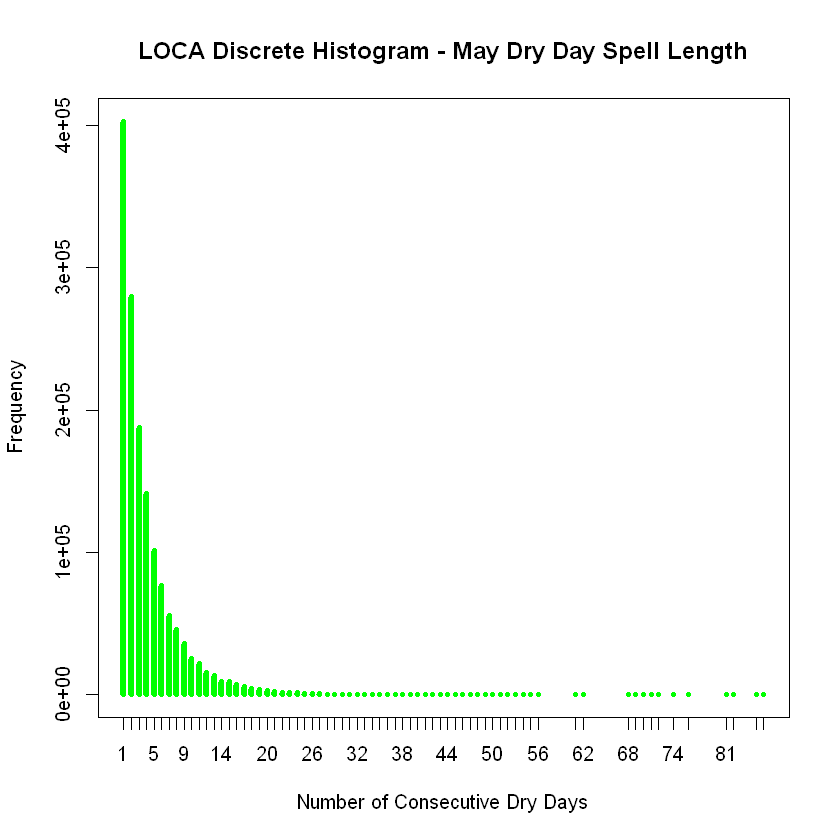

In [125]:
# our case is discrete so use this command
plot( table( dLOMay$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - May Dry Day Spell Length", 
      col="green" )

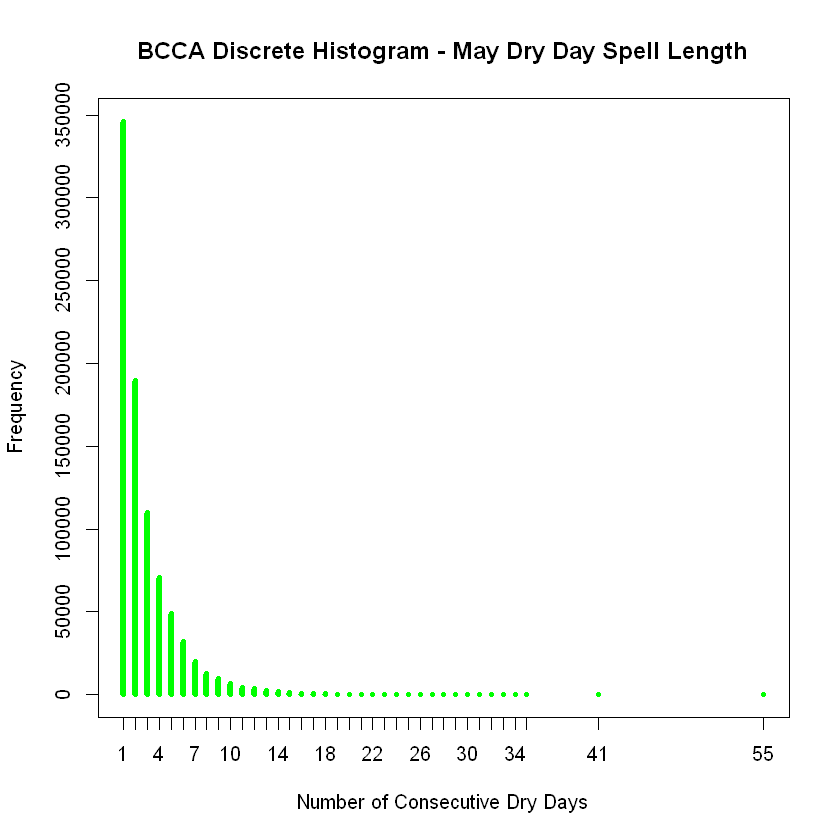

In [126]:
plot( table( dBCMay$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - May Dry Day Spell Length", 
      col="green" )

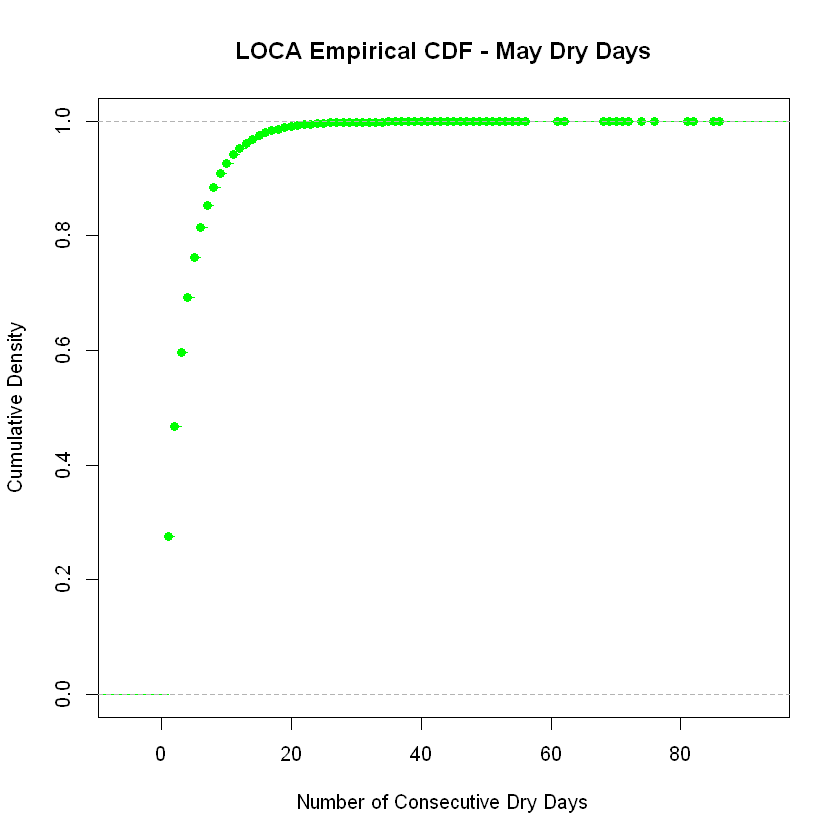

In [127]:
plot(ecdf(dLOMay$Dry_Count), main="LOCA Empirical CDF - May Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

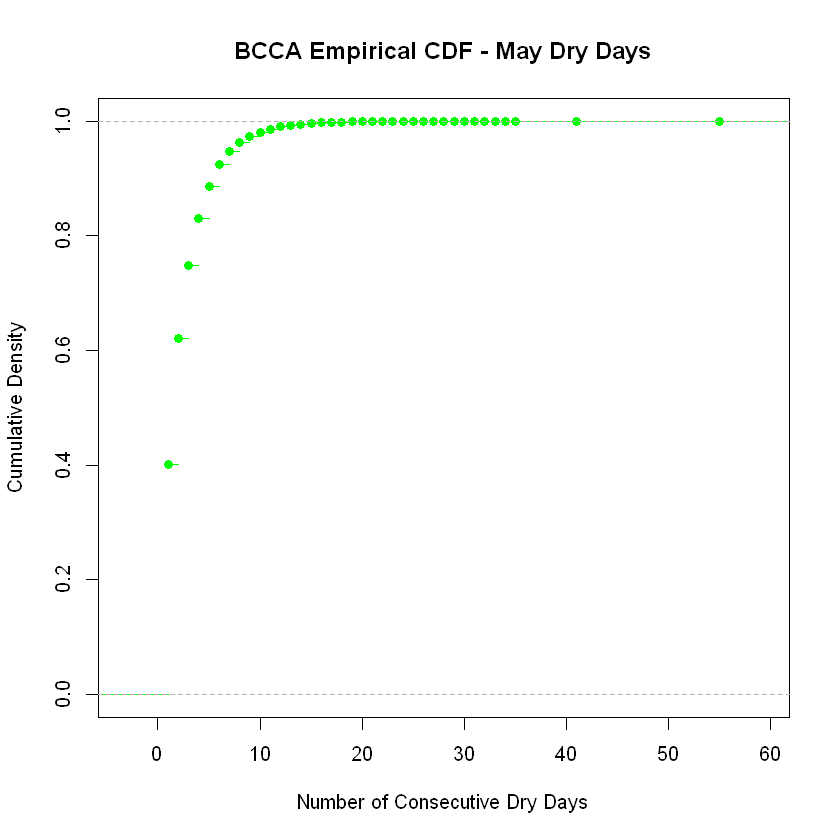

In [128]:
plot(ecdf(dBCMay$Dry_Count), main="BCCA Empirical CDF - May Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

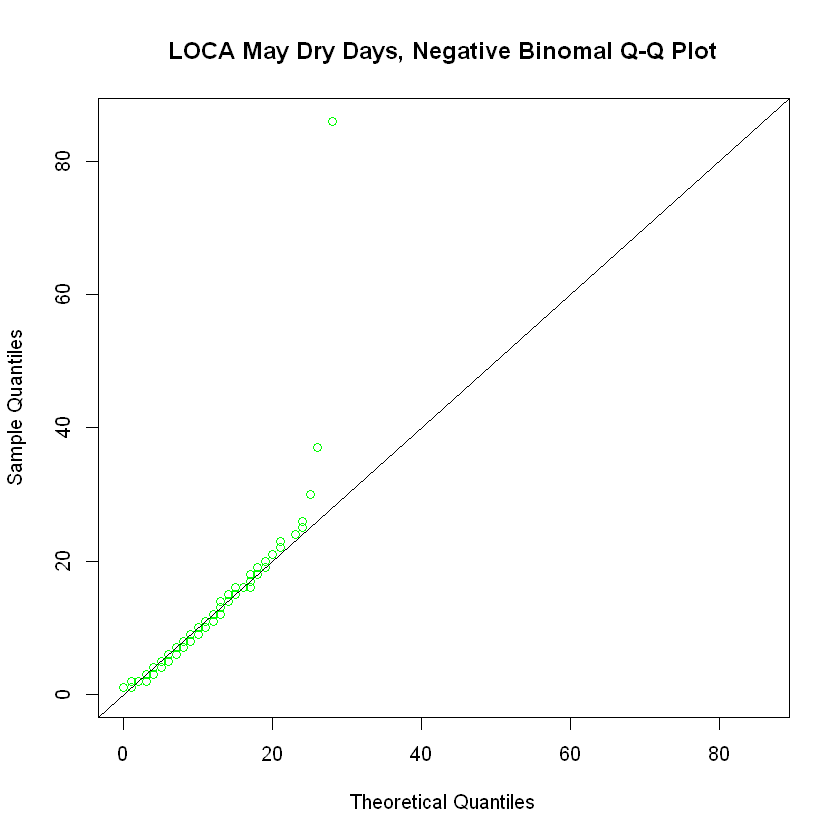

In [129]:
dLOMayMax <- max( dLOMay$Dry_Count )
dLOMayMean <- mean( dLOMay$Dry_Count )
dLOMayVar <- var( dLOMay$Dry_Count )
dLOMayBNr <- dLOMayMean^2 / (dLOMayVar - dLOMayMean)
dLOMayTstNB <- rnbinom( 1000, mu=dLOMayMean, size=dLOMayBNr )
qqplot( dLOMayTstNB, dLOMay$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA May Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMayMax), ylim=c(0,dLOMayMax) )
abline( 0, 1)

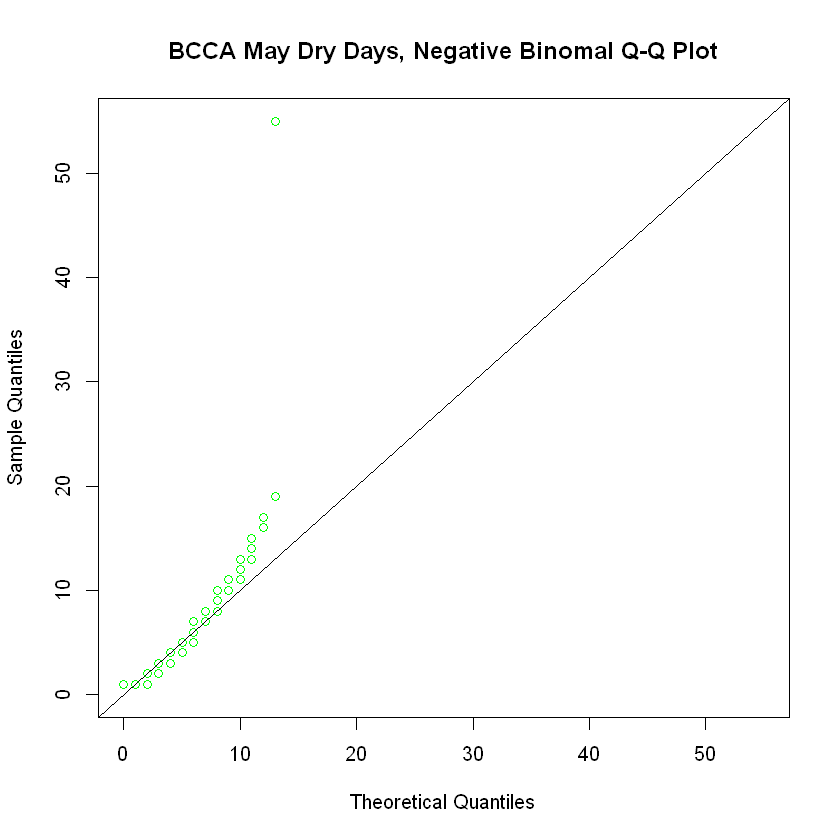

In [130]:
dBCMayMax <- max( dBCMay$Dry_Count )
dBCMayMean <- mean( dBCMay$Dry_Count )
dBCMayVar <- var( dBCMay$Dry_Count )
dBCMayBNr <- dBCMayMean^2 / (dBCMayVar - dBCMayMean)
dBCMayTstNB <- rnbinom( 1000, mu=dBCMayMean, size=dBCMayBNr )
qqplot( dBCMayTstNB, dBCMay$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA May Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMayMax), ylim=c(0,dBCMayMax) )
abline( 0, 1)

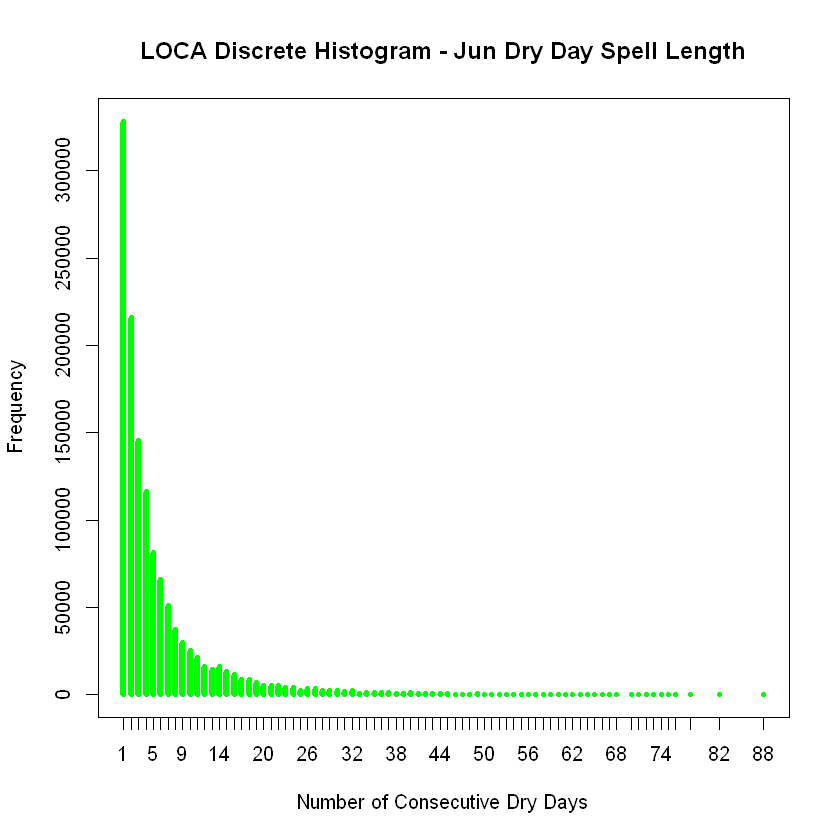

In [131]:
# our case is discrete so use this command
plot( table( dLOJun$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Jun Dry Day Spell Length", 
      col="green" )

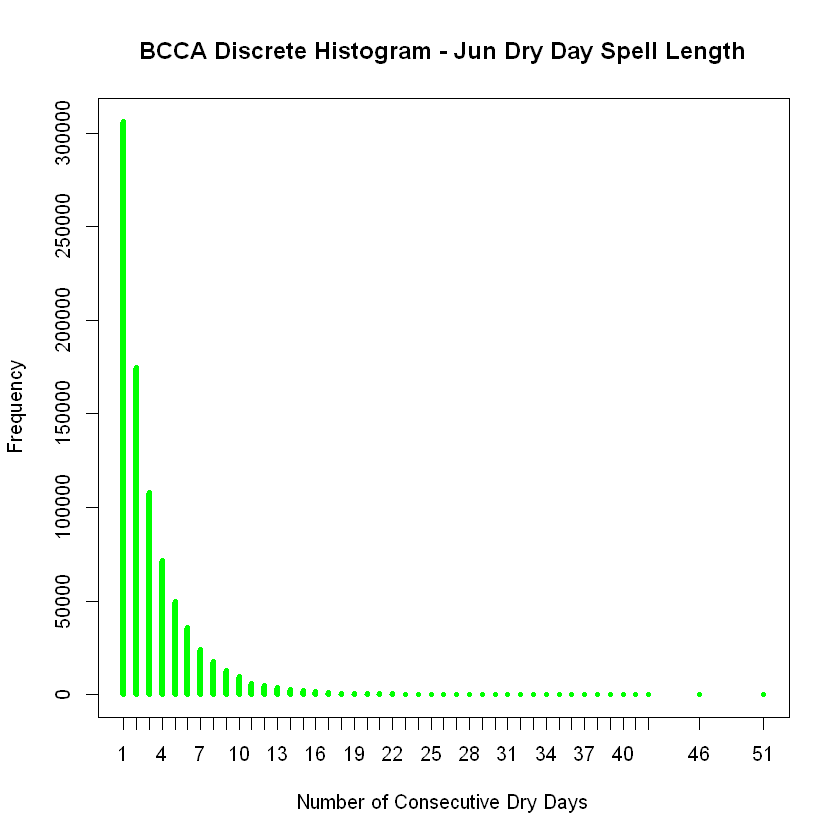

In [132]:
plot( table( dBCJun$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Jun Dry Day Spell Length", 
      col="green" )

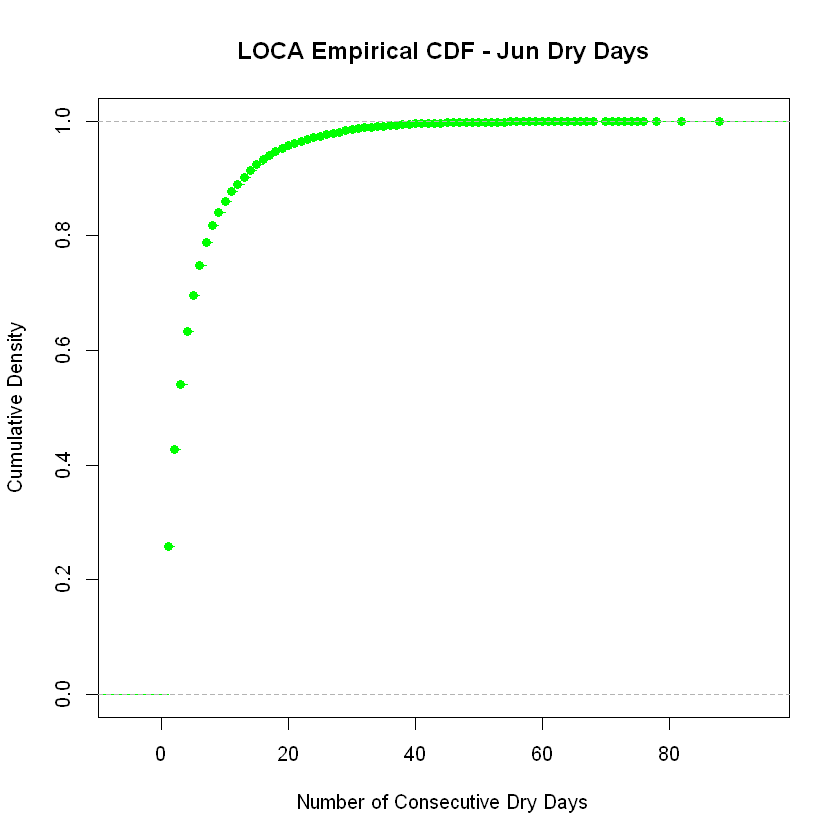

In [133]:
plot(ecdf(dLOJun$Dry_Count), main="LOCA Empirical CDF - Jun Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

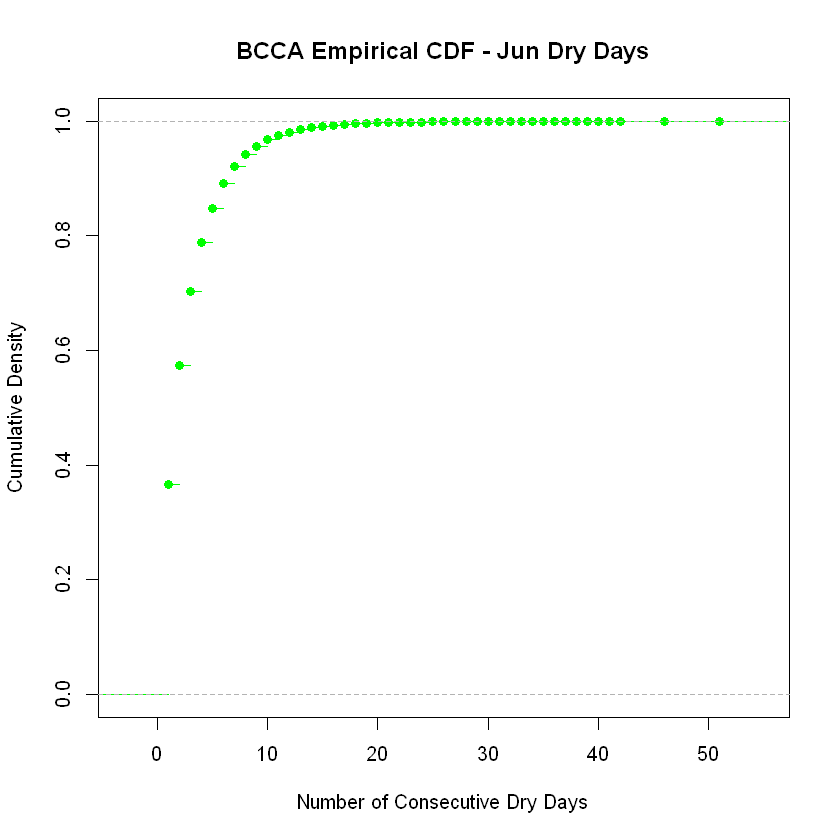

In [134]:
plot(ecdf(dBCJun$Dry_Count), main="BCCA Empirical CDF - Jun Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

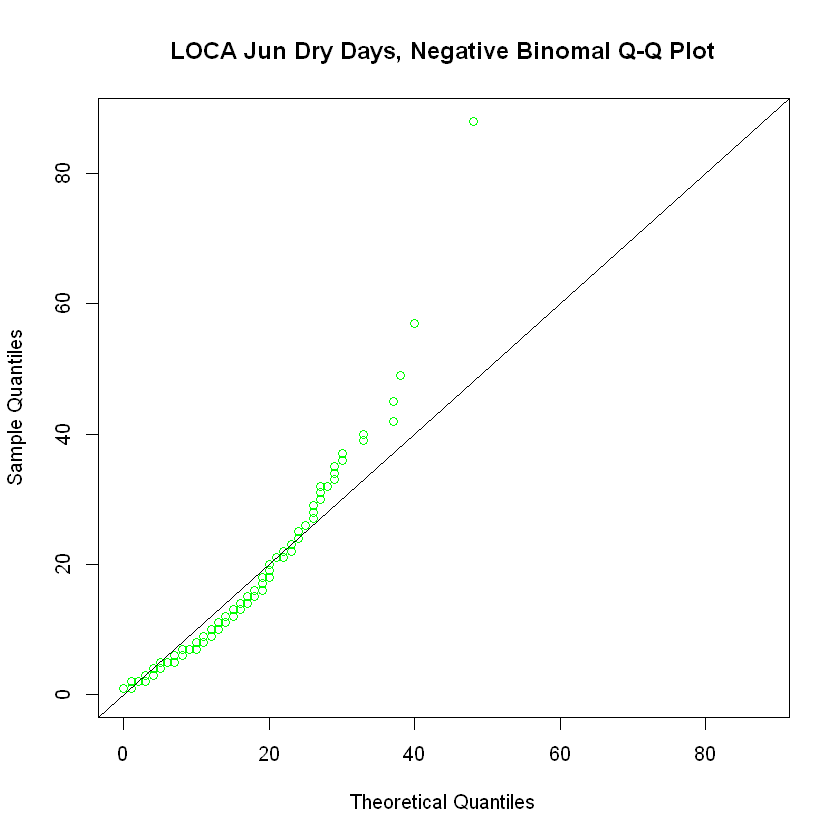

In [135]:
dLOJunMax <- max( dLOJun$Dry_Count )
dLOJunMean <- mean( dLOJun$Dry_Count )
dLOJunVar <- var( dLOJun$Dry_Count )
dLOJunBNr <- dLOJunMean^2 / (dLOJunVar - dLOJunMean)
dLOJunTstNB <- rnbinom( 1000, mu=dLOJunMean, size=dLOJunBNr )
qqplot( dLOJunTstNB, dLOJun$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jun Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJunMax), ylim=c(0,dLOJunMax) )
abline( 0, 1)

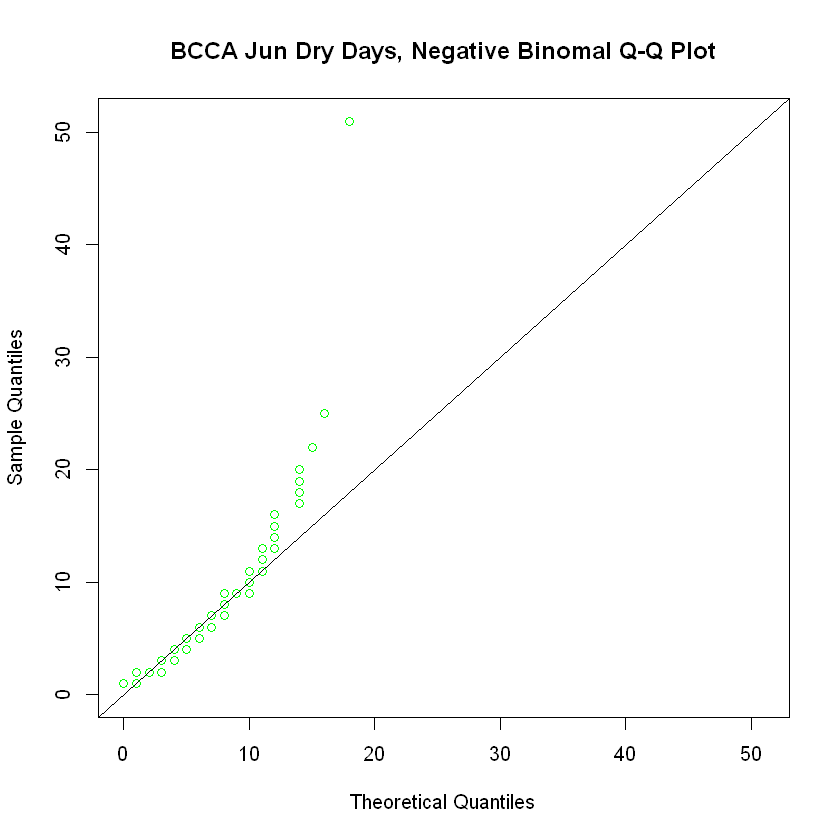

In [136]:
dBCJunMax <- max( dBCJun$Dry_Count )
dBCJunMean <- mean( dBCJun$Dry_Count )
dBCJunVar <- var( dBCJun$Dry_Count )
dBCJunBNr <- dBCJunMean^2 / (dBCJunVar - dBCJunMean)
dBCJunTstNB <- rnbinom( 1000, mu=dBCJunMean, size=dBCJunBNr )
qqplot( dBCJunTstNB, dBCJun$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jun Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJunMax), ylim=c(0,dBCJunMax) )
abline( 0, 1)

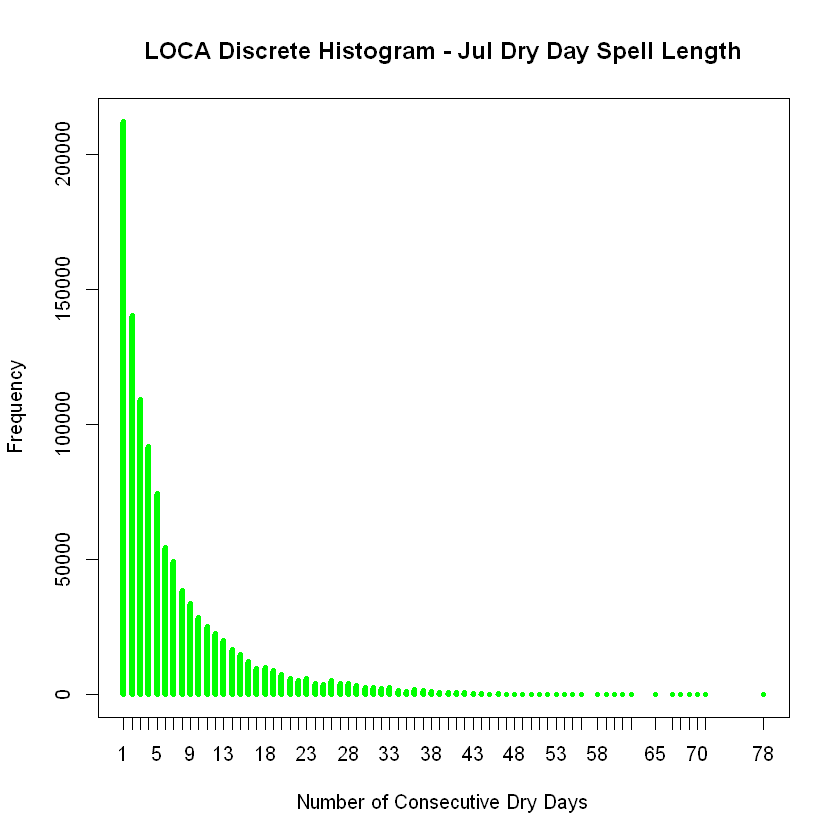

In [137]:
# our case is discrete so use this command
plot( table( dLOJul$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Jul Dry Day Spell Length", 
      col="green" )

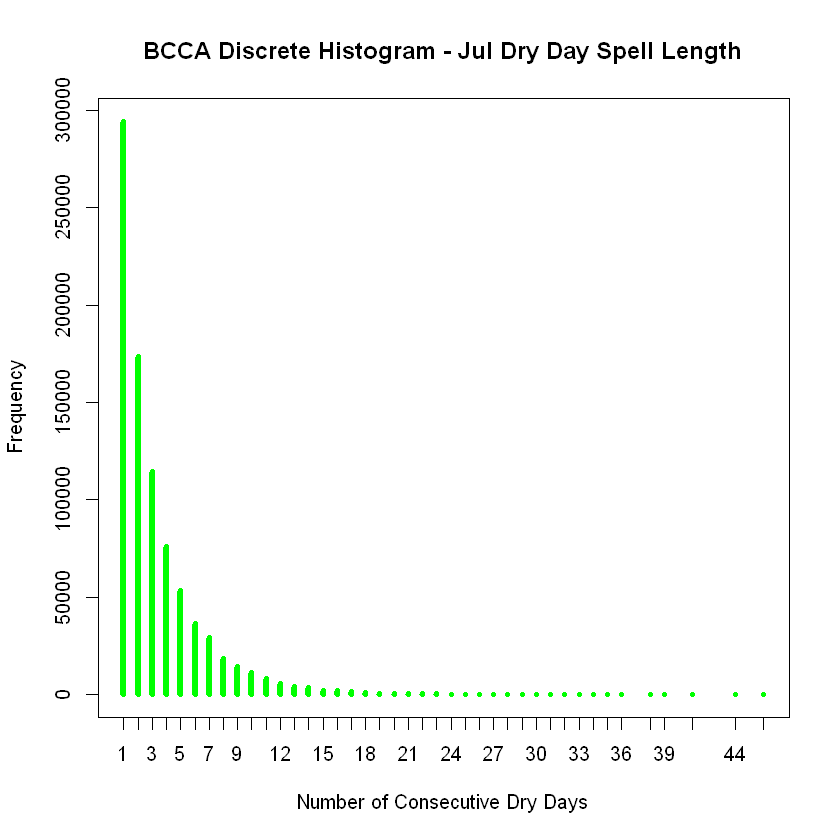

In [138]:
plot( table( dBCJul$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Jul Dry Day Spell Length", 
      col="green" )

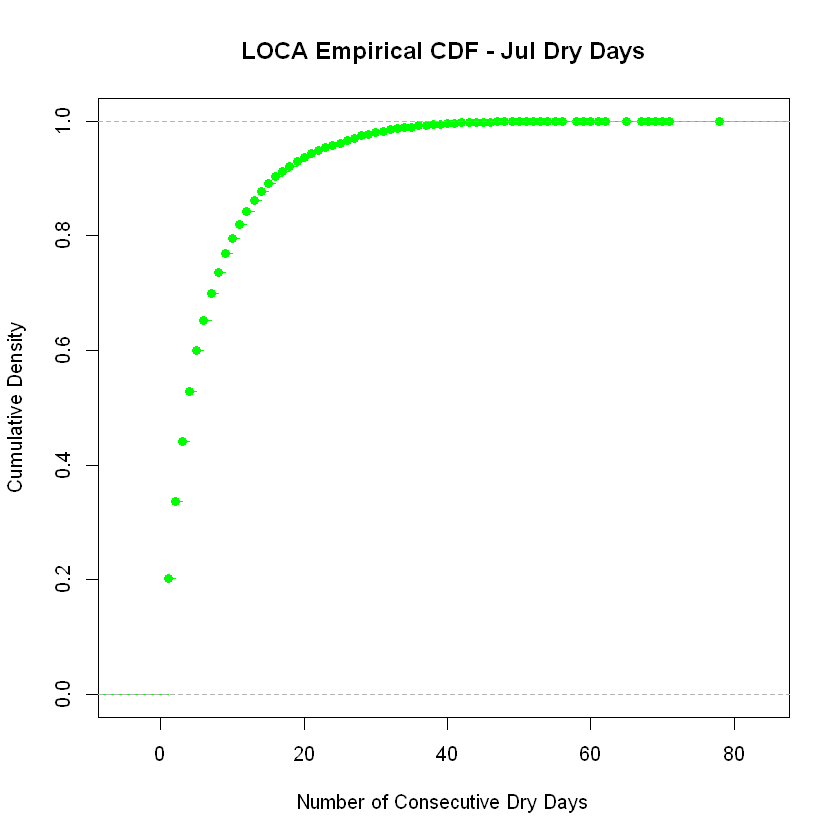

In [139]:
plot(ecdf(dLOJul$Dry_Count), main="LOCA Empirical CDF - Jul Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

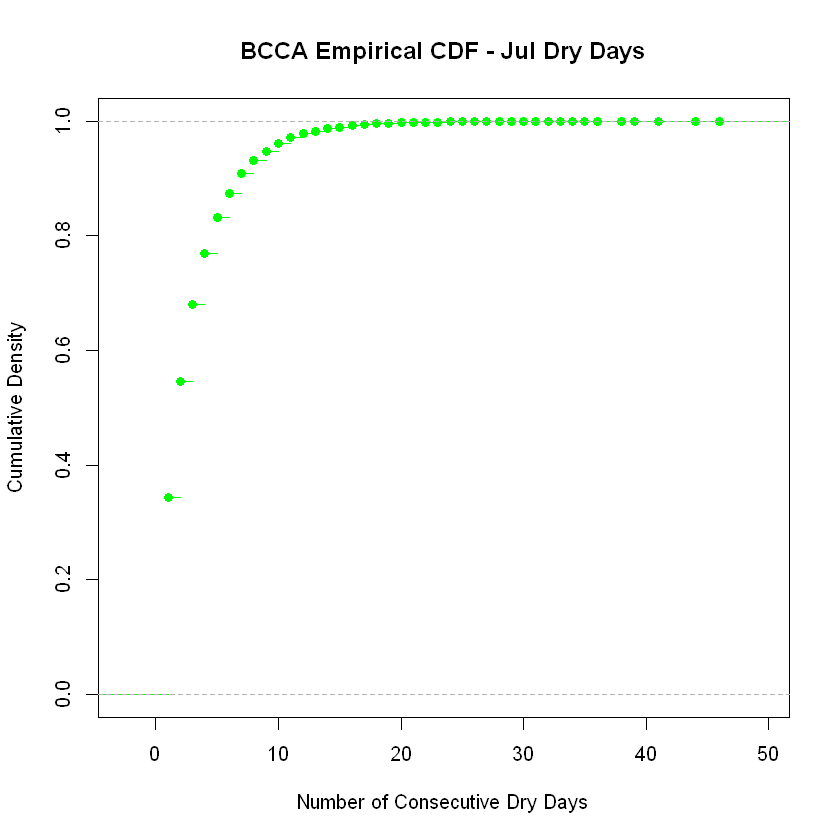

In [140]:
plot(ecdf(dBCJul$Dry_Count), main="BCCA Empirical CDF - Jul Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

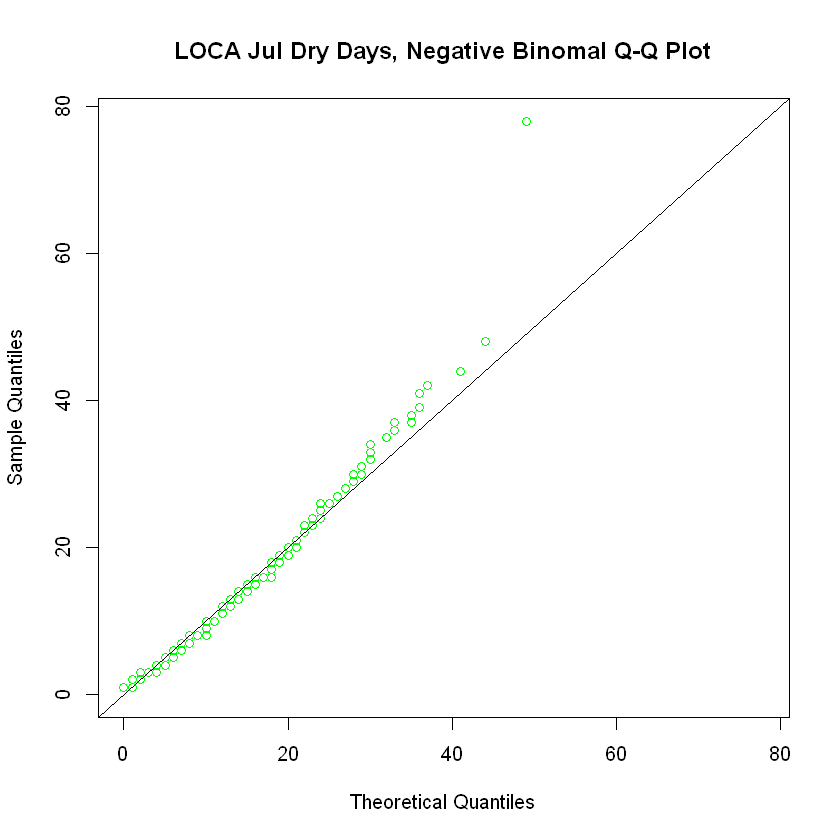

In [141]:
dLOJulMax <- max( dLOJul$Dry_Count )
dLOJulMean <- mean( dLOJul$Dry_Count )
dLOJulVar <- var( dLOJul$Dry_Count )
dLOJulBNr <- dLOJulMean^2 / (dLOJulVar - dLOJulMean)
dLOJulTstNB <- rnbinom( 1000, mu=dLOJulMean, size=dLOJulBNr )
qqplot( dLOJulTstNB, dLOJul$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jul Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJulMax), ylim=c(0,dLOJulMax) )
abline( 0, 1)

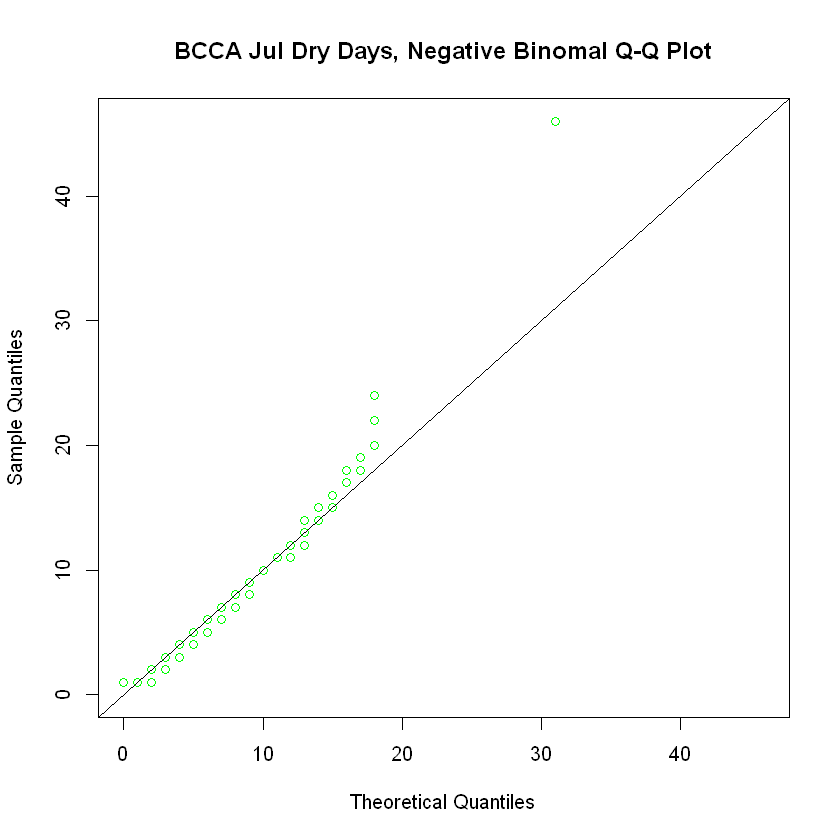

In [142]:
dBCJulMax <- max( dBCJul$Dry_Count )
dBCJulMean <- mean( dBCJul$Dry_Count )
dBCJulVar <- var( dBCJul$Dry_Count )
dBCJulBNr <- dBCJulMean^2 / (dBCJulVar - dBCJulMean)
dBCJulTstNB <- rnbinom( 1000, mu=dBCJulMean, size=dBCJulBNr )
qqplot( dBCJulTstNB, dBCJul$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jul Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJulMax), ylim=c(0,dBCJulMax) )
abline( 0, 1)

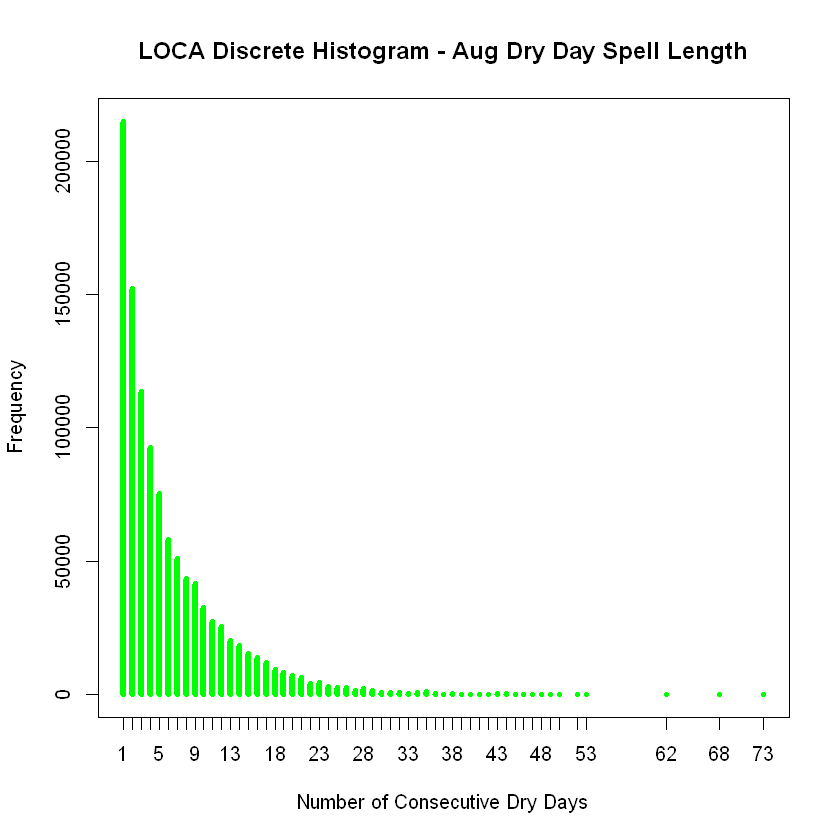

In [143]:
# our case is discrete so use this command
plot( table( dLOAug$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Aug Dry Day Spell Length", 
      col="green" )

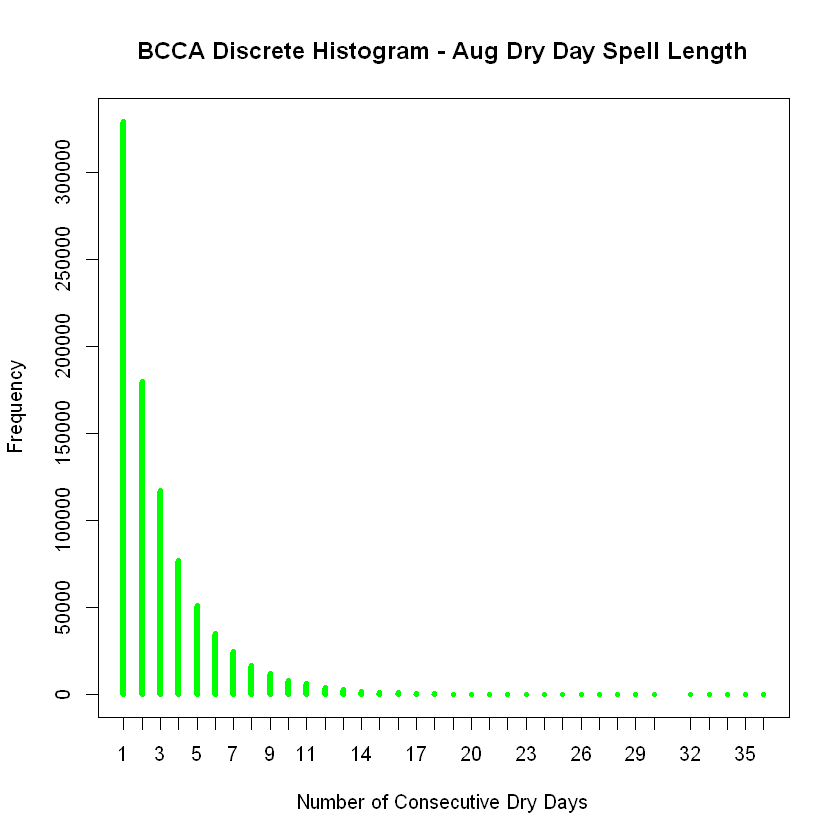

In [144]:
plot( table( dBCAug$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Aug Dry Day Spell Length", 
      col="green" )

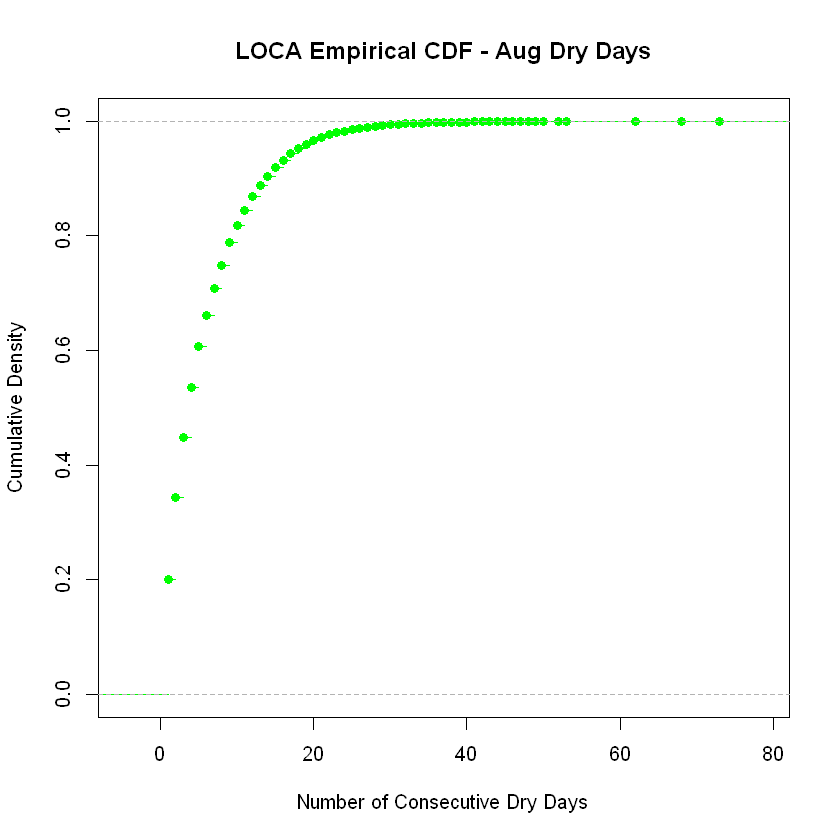

In [145]:
plot(ecdf(dLOAug$Dry_Count), main="LOCA Empirical CDF - Aug Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

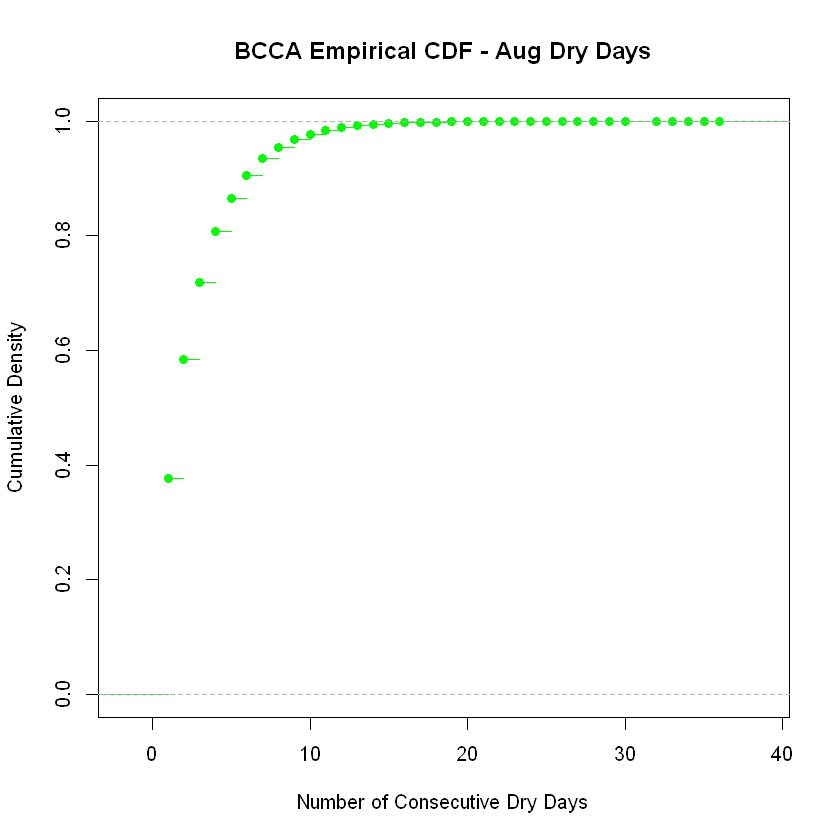

In [146]:
plot(ecdf(dBCAug$Dry_Count), main="BCCA Empirical CDF - Aug Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

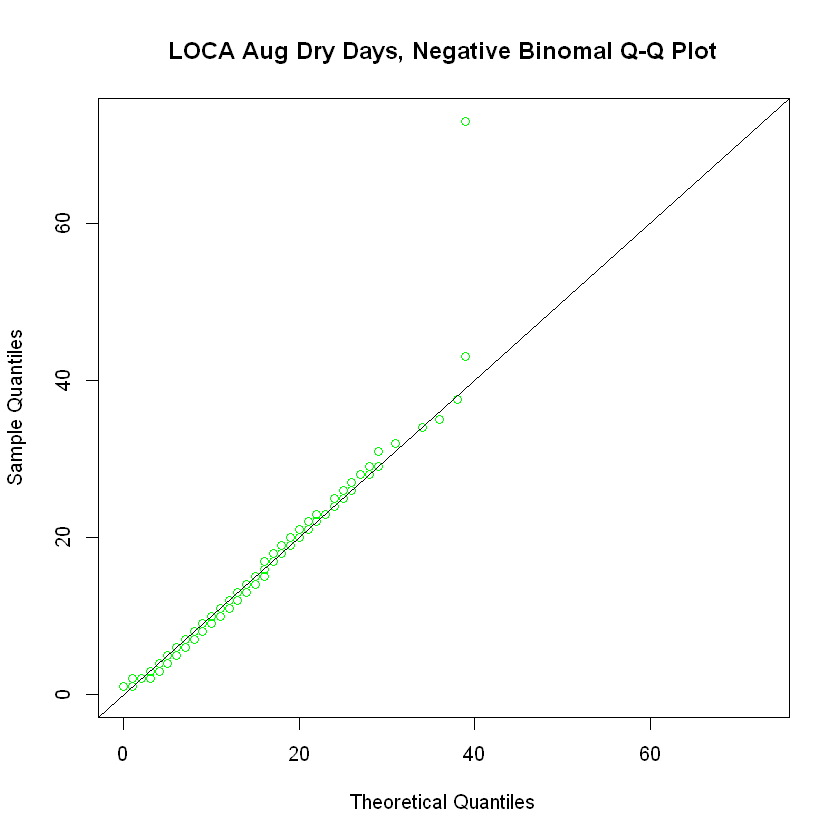

In [147]:
dLOAugMax <- max( dLOAug$Dry_Count )
dLOAugMean <- mean( dLOAug$Dry_Count )
dLOAugVar <- var( dLOAug$Dry_Count )
dLOAugBNr <- dLOAugMean^2 / (dLOAugVar - dLOAugMean)
dLOAugTstNB <- rnbinom( 1000, mu=dLOAugMean, size=dLOAugBNr )
qqplot( dLOAugTstNB, dLOAug$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Aug Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAugMax), ylim=c(0,dLOAugMax) )
abline( 0, 1)

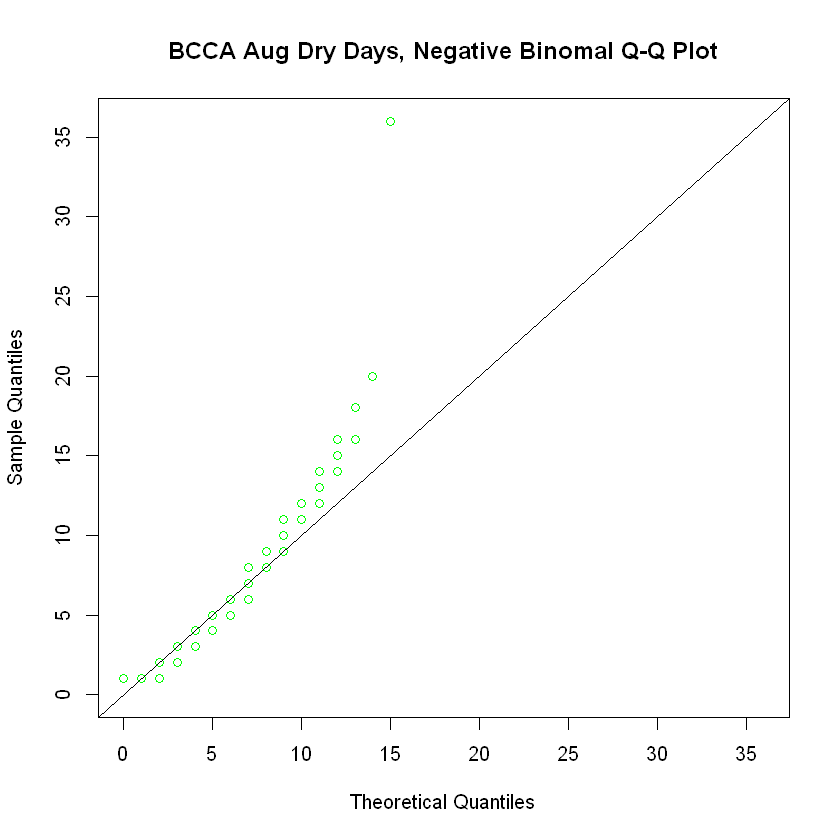

In [148]:
dBCAugMax <- max( dBCAug$Dry_Count )
dBCAugMean <- mean( dBCAug$Dry_Count )
dBCAugVar <- var( dBCAug$Dry_Count )
dBCAugBNr <- dBCAugMean^2 / (dBCAugVar - dBCAugMean)
dBCAugTstNB <- rnbinom( 1000, mu=dBCAugMean, size=dBCAugBNr )
qqplot( dBCAugTstNB, dBCAug$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Aug Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAugMax), ylim=c(0,dBCAugMax) )
abline( 0, 1)

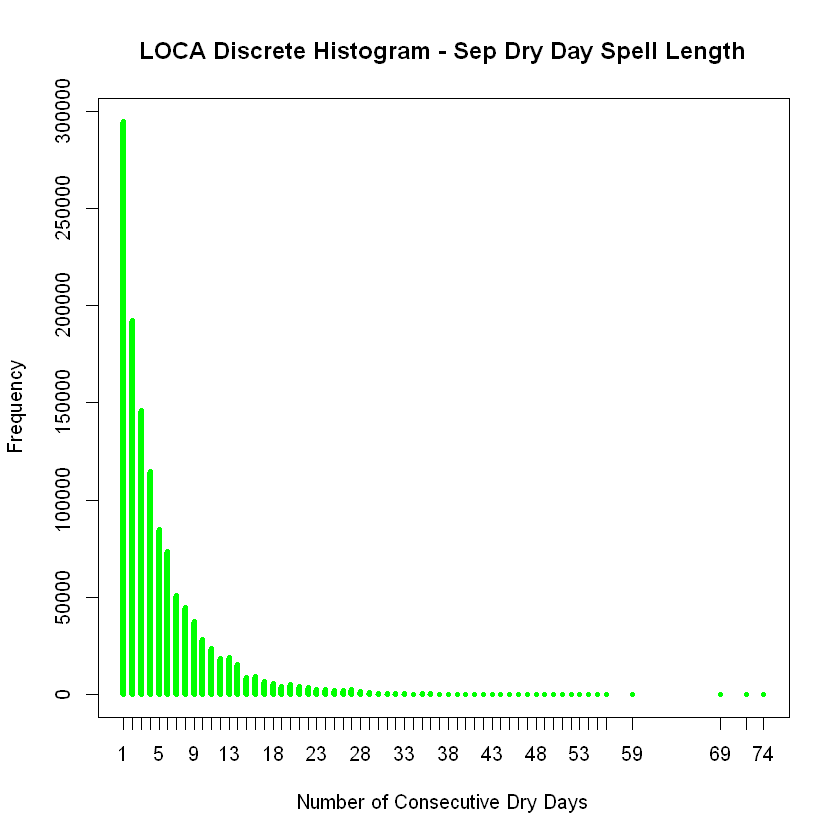

In [149]:
# our case is discrete so use this command
plot( table( dLOSep$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Sep Dry Day Spell Length", 
      col="green" )

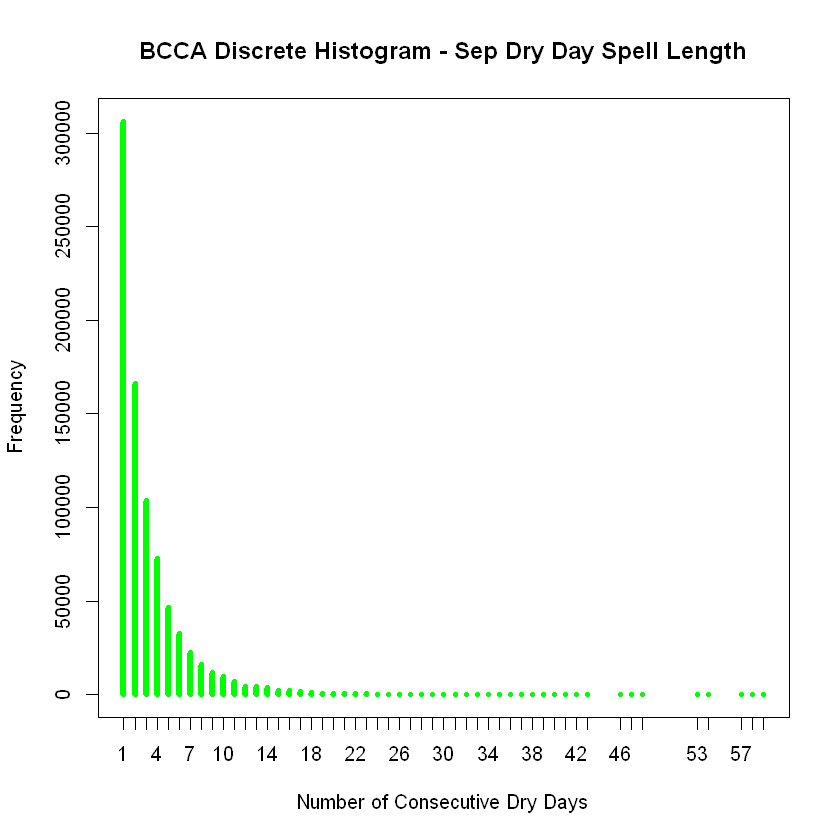

In [150]:
plot( table( dBCSep$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Sep Dry Day Spell Length", 
      col="green" )

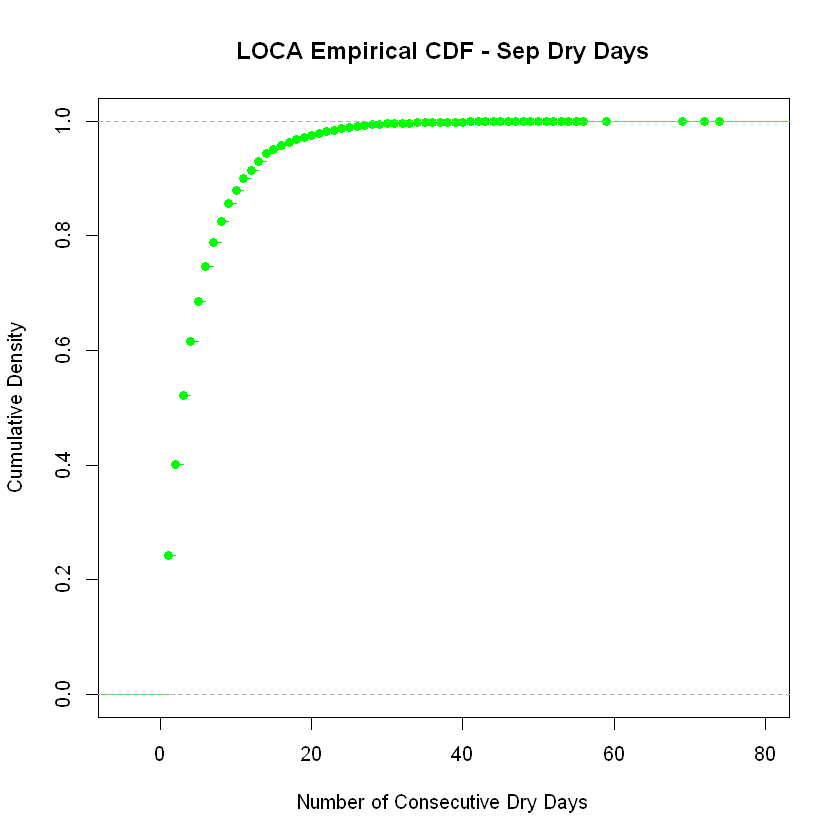

In [151]:
plot(ecdf(dLOSep$Dry_Count), main="LOCA Empirical CDF - Sep Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

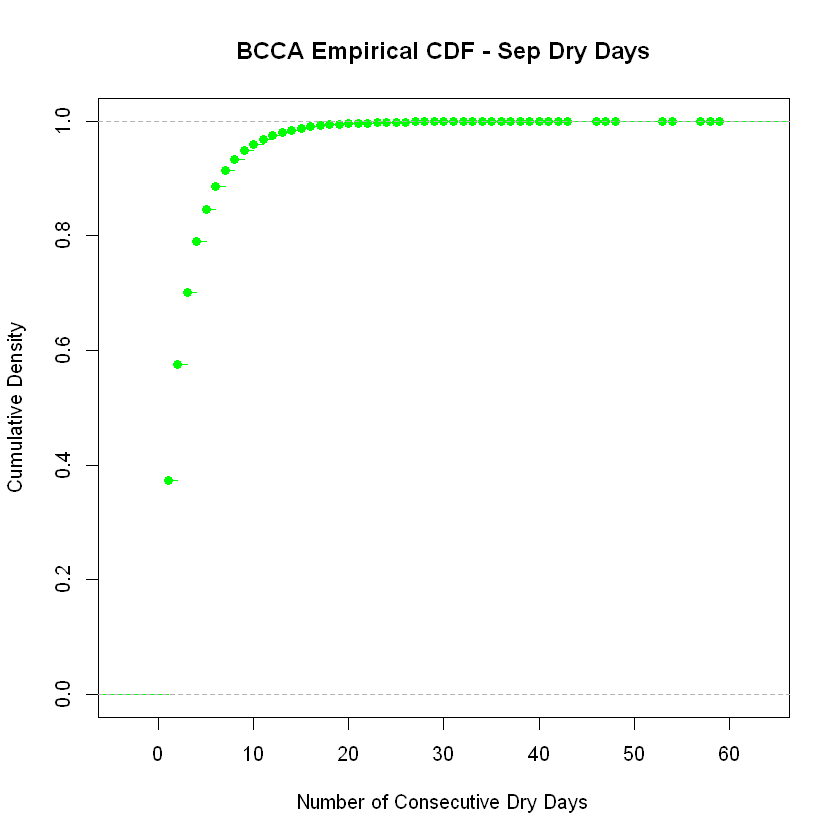

In [152]:
plot(ecdf(dBCSep$Dry_Count), main="BCCA Empirical CDF - Sep Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

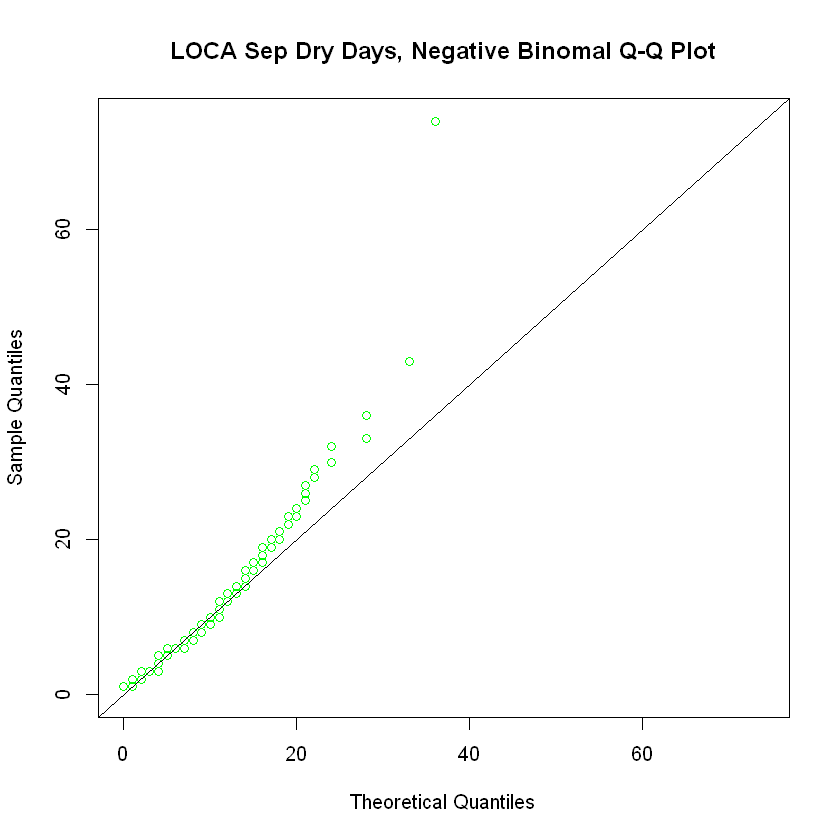

In [153]:
dLOSepMax <- max( dLOSep$Dry_Count )
dLOSepMean <- mean( dLOSep$Dry_Count )
dLOSepVar <- var( dLOSep$Dry_Count )
dLOSepBNr <- dLOSepMean^2 / (dLOSepVar - dLOSepMean)
dLOSepTstNB <- rnbinom( 1000, mu=dLOSepMean, size=dLOSepBNr )
qqplot( dLOSepTstNB, dLOSep$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Sep Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOSepMax), ylim=c(0,dLOSepMax) )
abline( 0, 1)

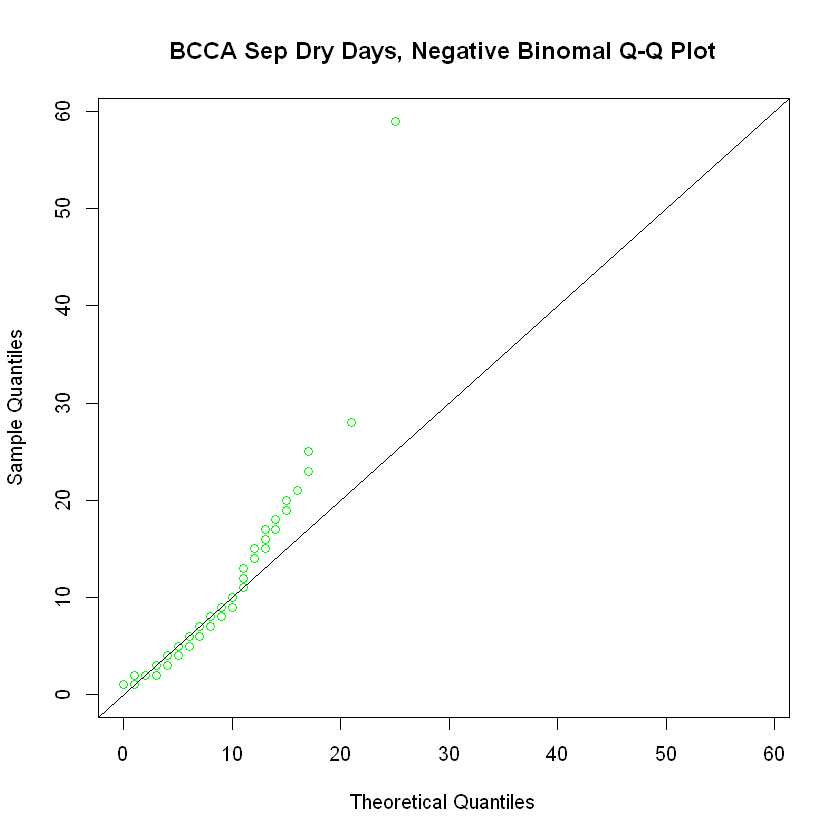

In [154]:
dBCSepMax <- max( dBCSep$Dry_Count )
dBCSepMean <- mean( dBCSep$Dry_Count )
dBCSepVar <- var( dBCSep$Dry_Count )
dBCSepBNr <- dBCSepMean^2 / (dBCSepVar - dBCSepMean)
dBCSepTstNB <- rnbinom( 1000, mu=dBCSepMean, size=dBCSepBNr )
qqplot( dBCSepTstNB, dBCSep$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Sep Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCSepMax), ylim=c(0,dBCSepMax) )
abline( 0, 1)

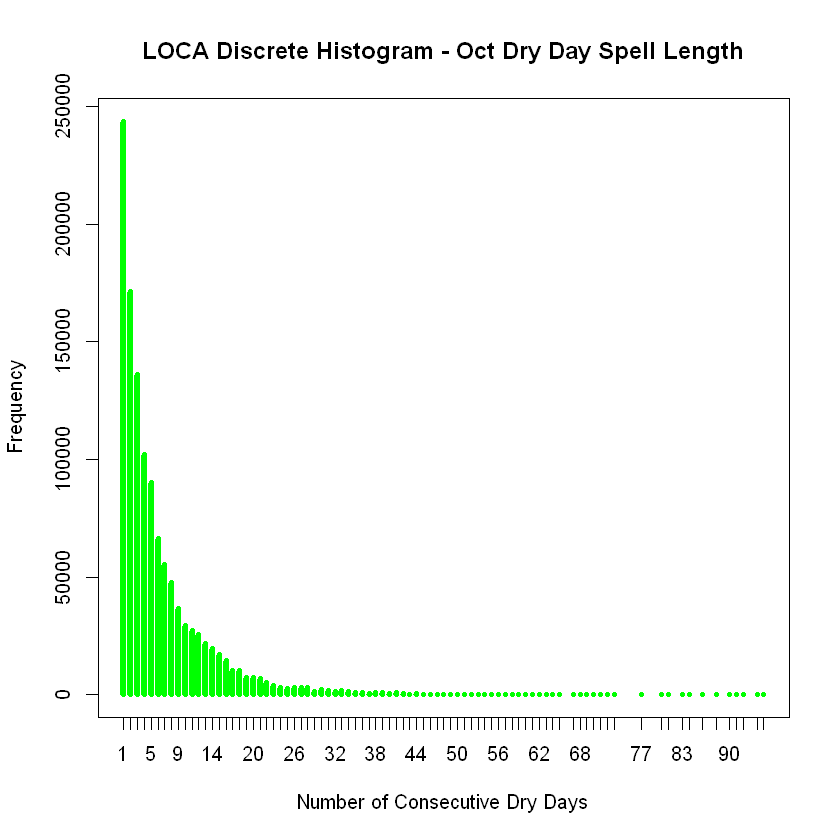

In [155]:
# our case is discrete so use this command
plot( table( dLOOct$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Oct Dry Day Spell Length", 
      col="green" )

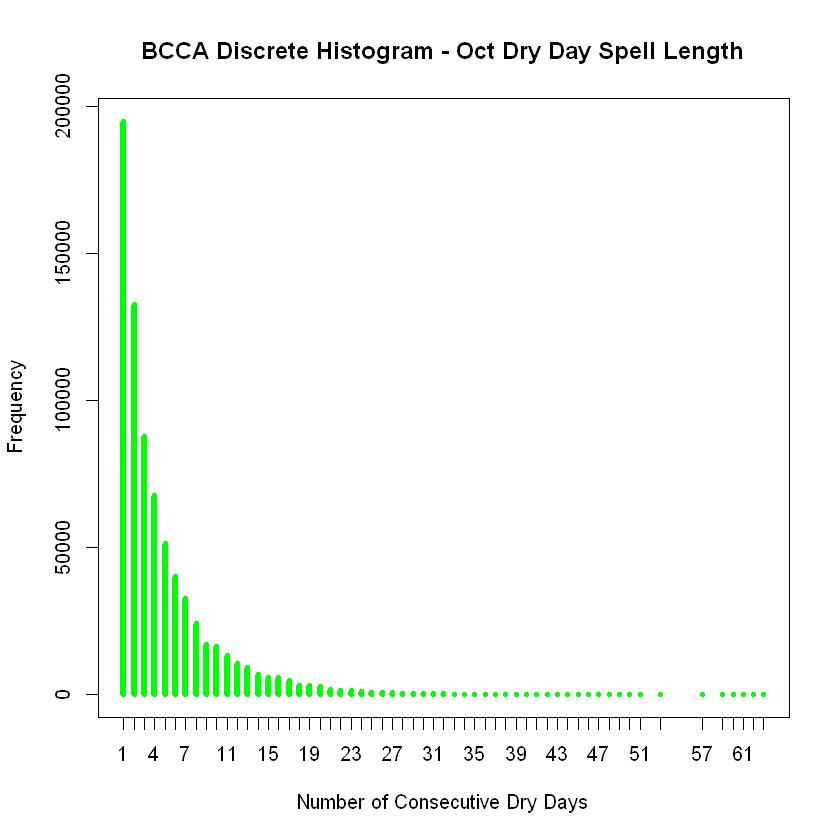

In [156]:
plot( table( dBCOct$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Oct Dry Day Spell Length", 
      col="green" )

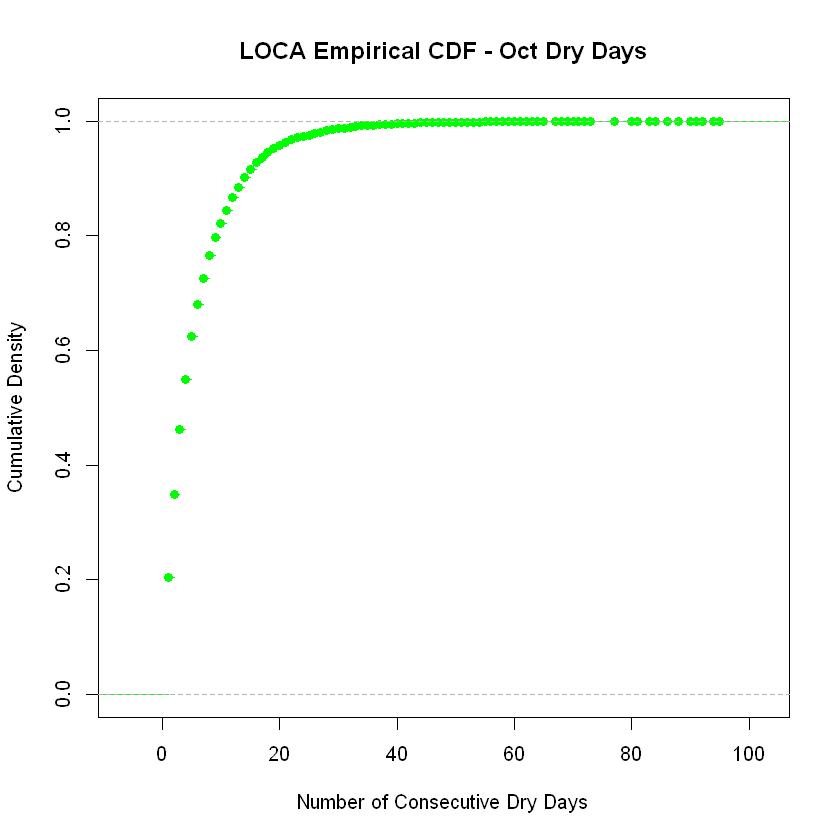

In [157]:
plot(ecdf(dLOOct$Dry_Count), main="LOCA Empirical CDF - Oct Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

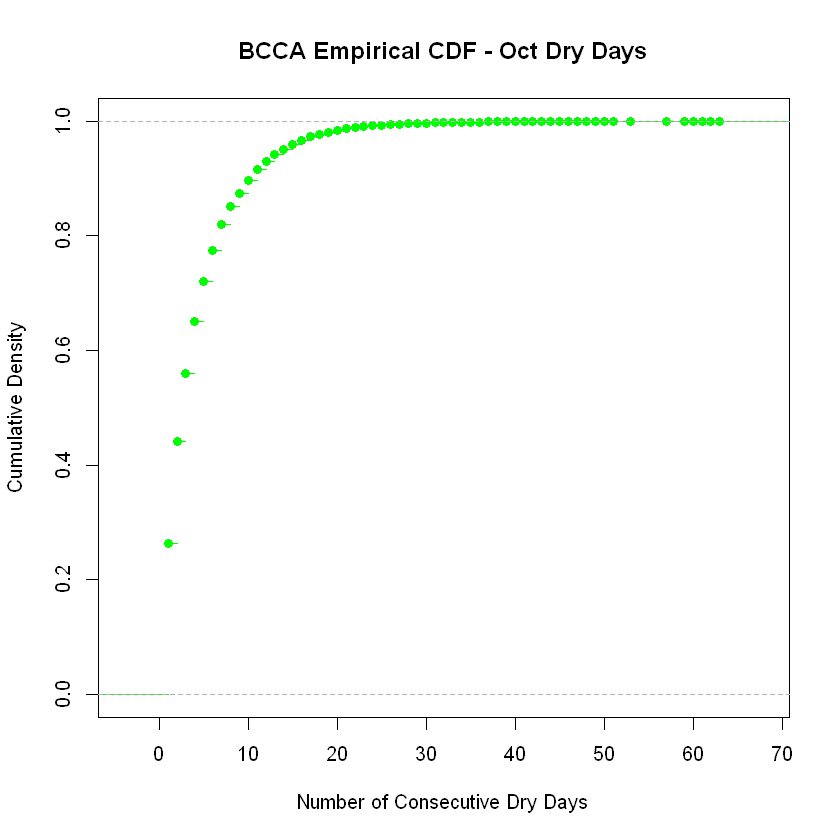

In [158]:
plot(ecdf(dBCOct$Dry_Count), main="BCCA Empirical CDF - Oct Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

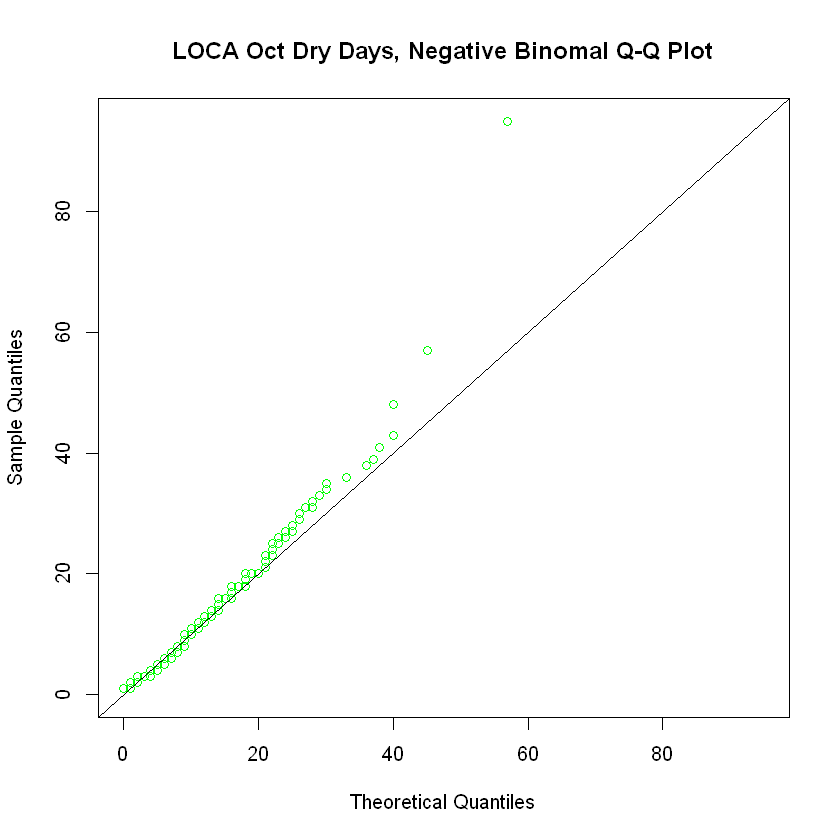

In [159]:
dLOOctMax <- max( dLOOct$Dry_Count )
dLOOctMean <- mean( dLOOct$Dry_Count )
dLOOctVar <- var( dLOOct$Dry_Count )
dLOOctBNr <- dLOOctMean^2 / (dLOOctVar - dLOOctMean)
dLOOctTstNB <- rnbinom( 1000, mu=dLOOctMean, size=dLOOctBNr )
qqplot( dLOOctTstNB, dLOOct$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Oct Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOOctMax), ylim=c(0,dLOOctMax) )
abline( 0, 1)

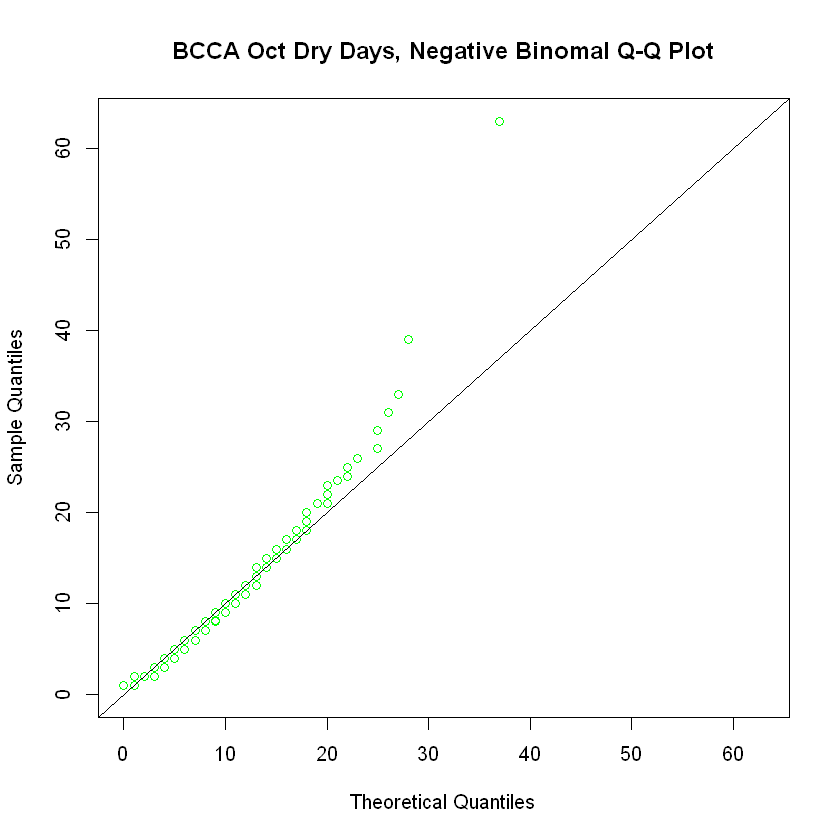

In [160]:
dBCOctMax <- max( dBCOct$Dry_Count )
dBCOctMean <- mean( dBCOct$Dry_Count )
dBCOctVar <- var( dBCOct$Dry_Count )
dBCOctBNr <- dBCOctMean^2 / (dBCOctVar - dBCOctMean)
dBCOctTstNB <- rnbinom( 1000, mu=dBCOctMean, size=dBCOctBNr )
qqplot( dBCOctTstNB, dBCOct$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Oct Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCOctMax), ylim=c(0,dBCOctMax) )
abline( 0, 1)

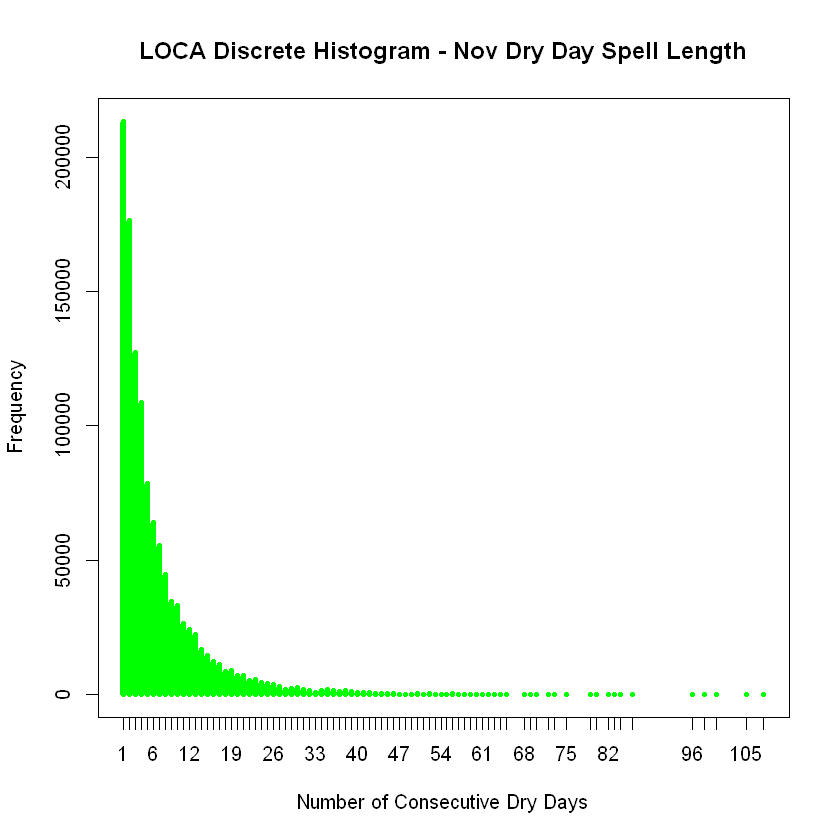

In [161]:
# our case is discrete so use this command
plot( table( dLONov$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Nov Dry Day Spell Length", 
      col="green" )

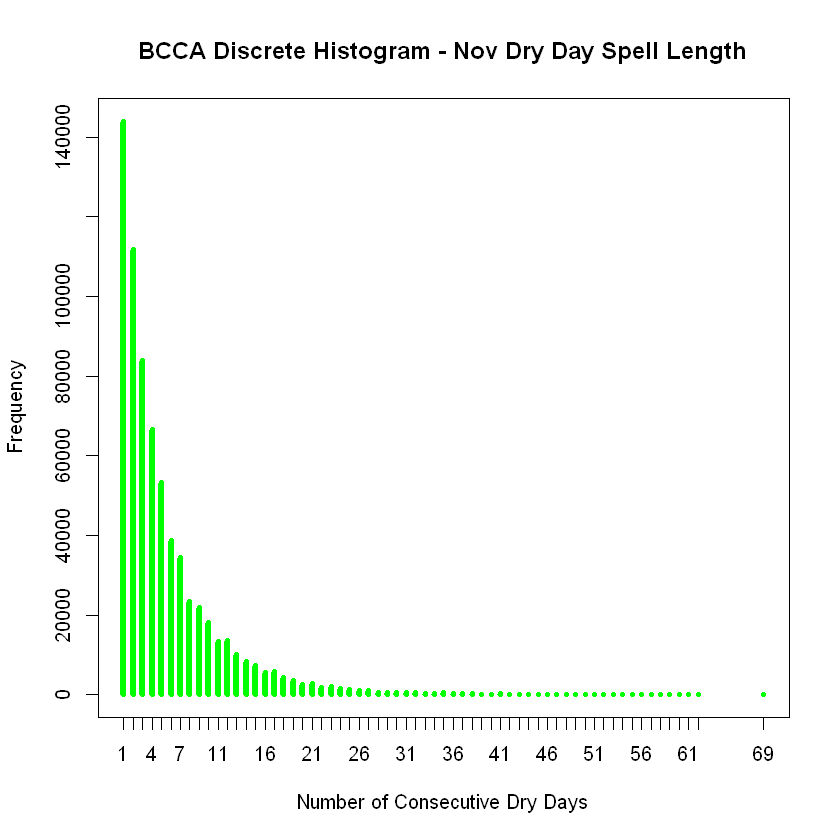

In [162]:
plot( table( dBCNov$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Nov Dry Day Spell Length", 
      col="green" )

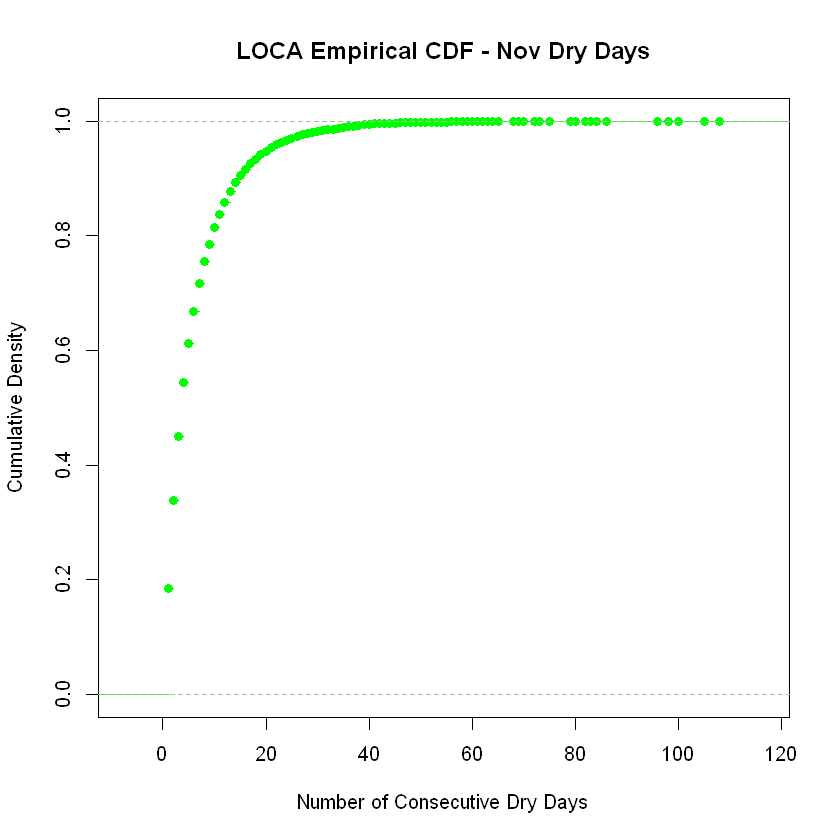

In [163]:
plot(ecdf(dLONov$Dry_Count), main="LOCA Empirical CDF - Nov Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

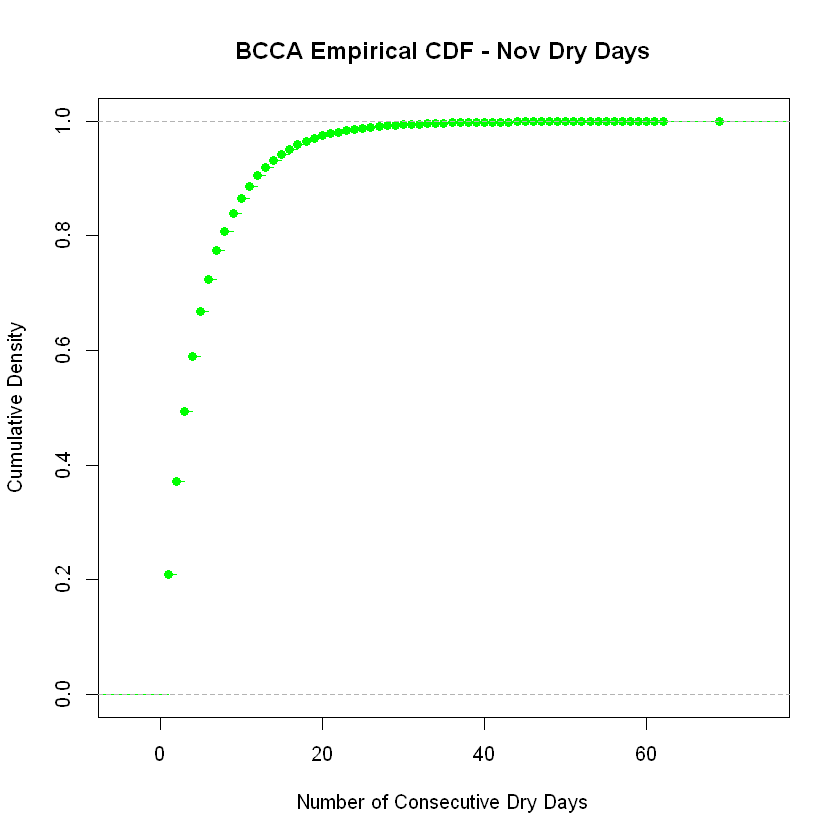

In [164]:
plot(ecdf(dBCNov$Dry_Count), main="BCCA Empirical CDF - Nov Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

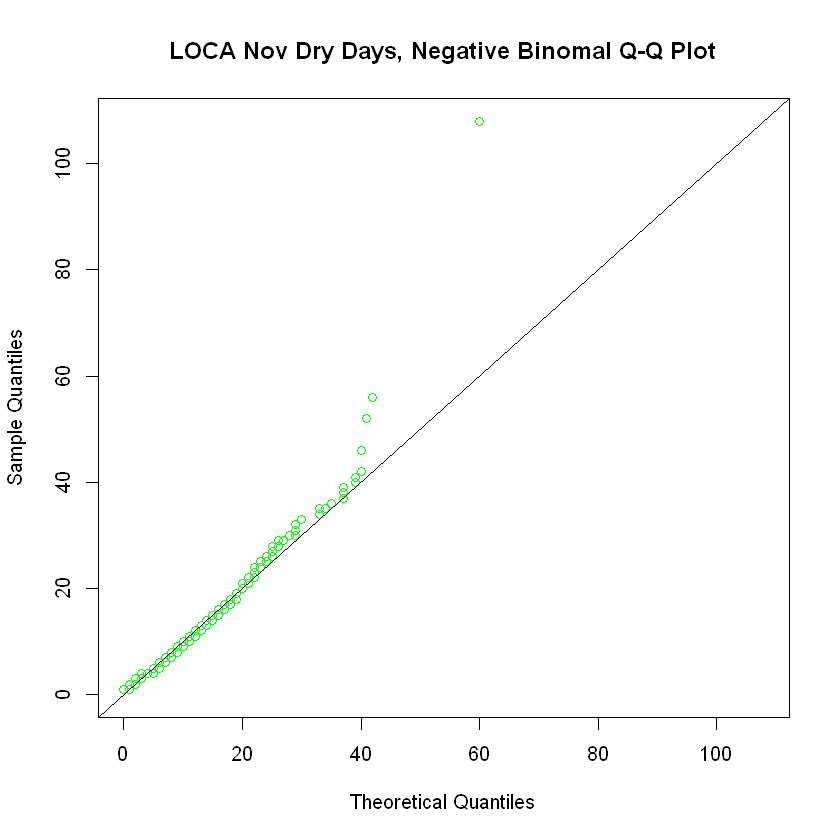

In [165]:
dLONovMax <- max( dLONov$Dry_Count )
dLONovMean <- mean( dLONov$Dry_Count )
dLONovVar <- var( dLONov$Dry_Count )
dLONovBNr <- dLONovMean^2 / (dLONovVar - dLONovMean)
dLONovTstNB <- rnbinom( 1000, mu=dLONovMean, size=dLONovBNr )
qqplot( dLONovTstNB, dLONov$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Nov Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLONovMax), ylim=c(0,dLONovMax) )
abline( 0, 1)

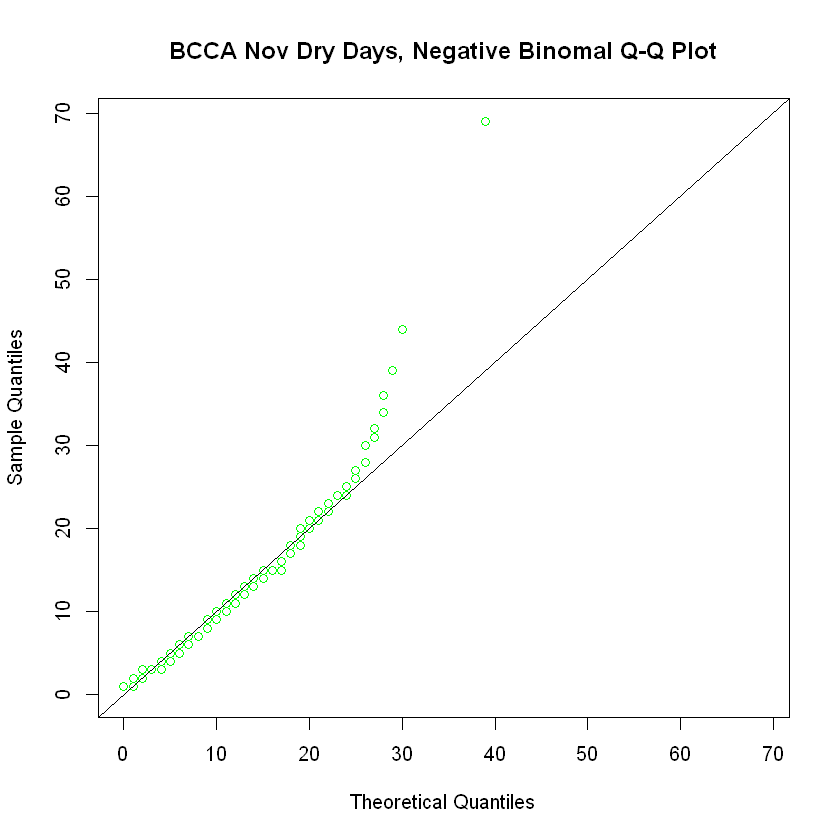

In [166]:
dBCNovMax <- max( dBCNov$Dry_Count )
dBCNovMean <- mean( dBCNov$Dry_Count )
dBCNovVar <- var( dBCNov$Dry_Count )
dBCNovBNr <- dBCNovMean^2 / (dBCNovVar - dBCNovMean)
dBCNovTstNB <- rnbinom( 1000, mu=dBCNovMean, size=dBCNovBNr )
qqplot( dBCNovTstNB, dBCNov$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Nov Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCNovMax), ylim=c(0,dBCNovMax) )
abline( 0, 1)

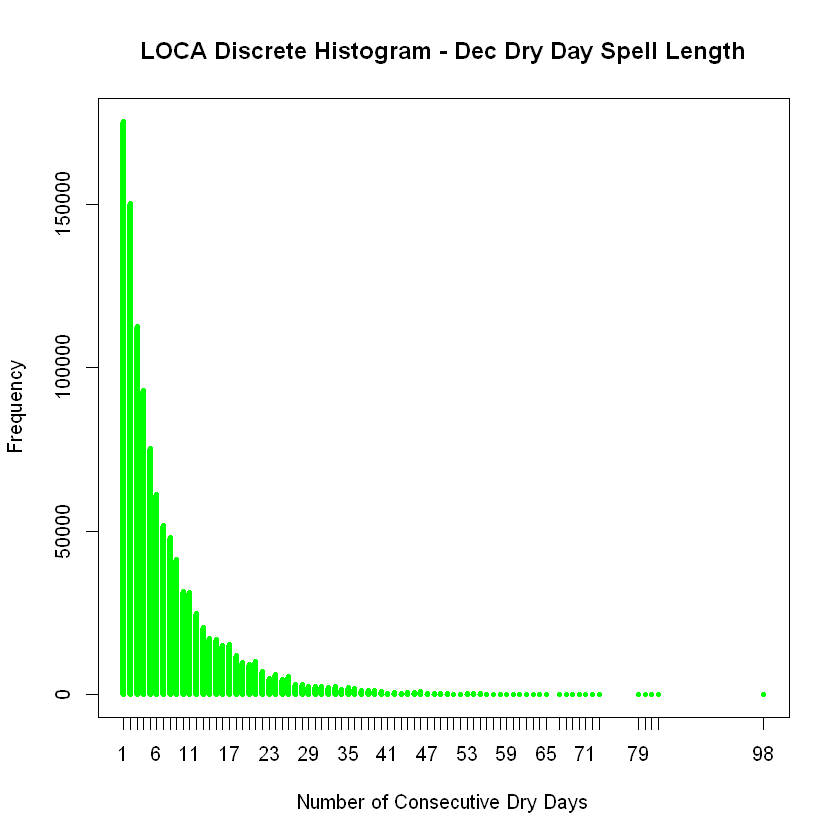

In [167]:
# our case is discrete so use this command
plot( table( dLODec$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="LOCA Discrete Histogram - Dec Dry Day Spell Length", 
      col="green" )

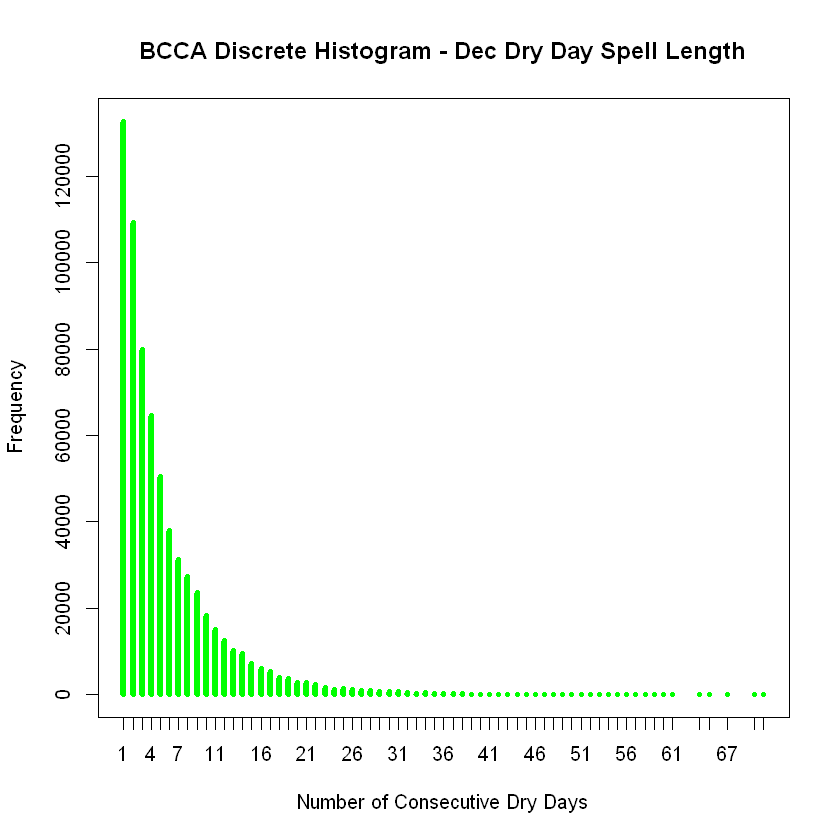

In [168]:
plot( table( dBCDec$Dry_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Dry Days", 
      main="BCCA Discrete Histogram - Dec Dry Day Spell Length", 
      col="green" )

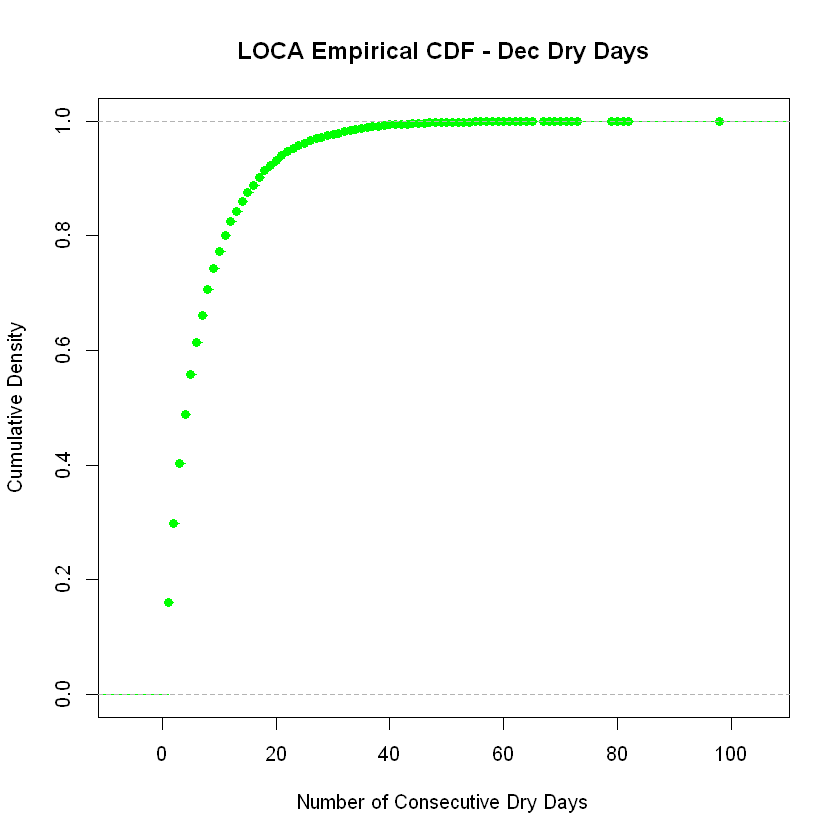

In [169]:
plot(ecdf(dLODec$Dry_Count), main="LOCA Empirical CDF - Dec Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

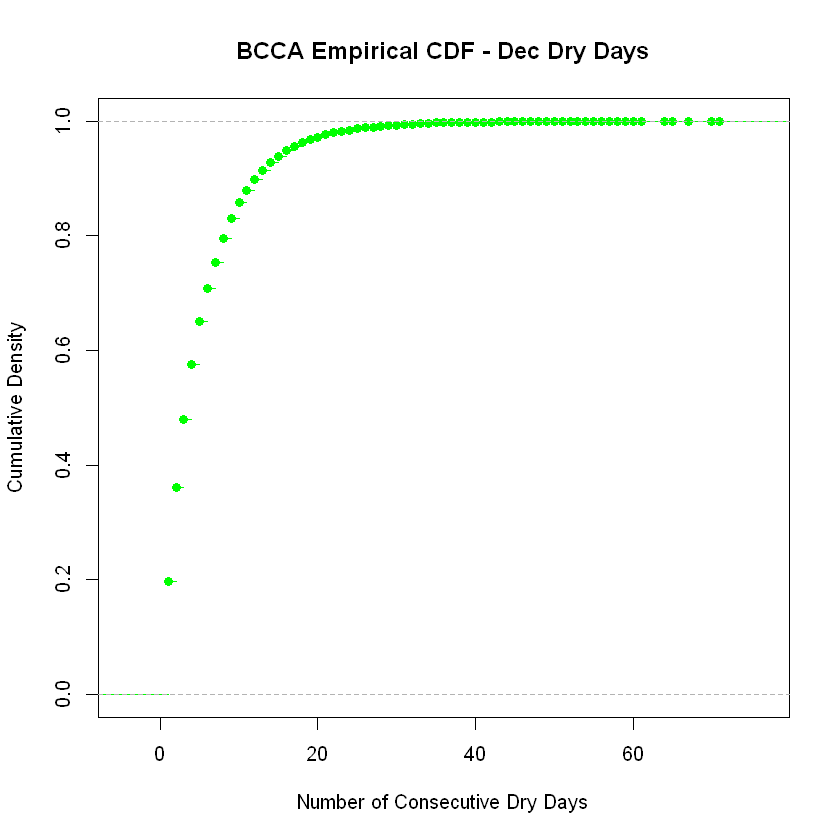

In [170]:
plot(ecdf(dBCDec$Dry_Count), main="BCCA Empirical CDF - Dec Dry Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Dry Days", col="green" )

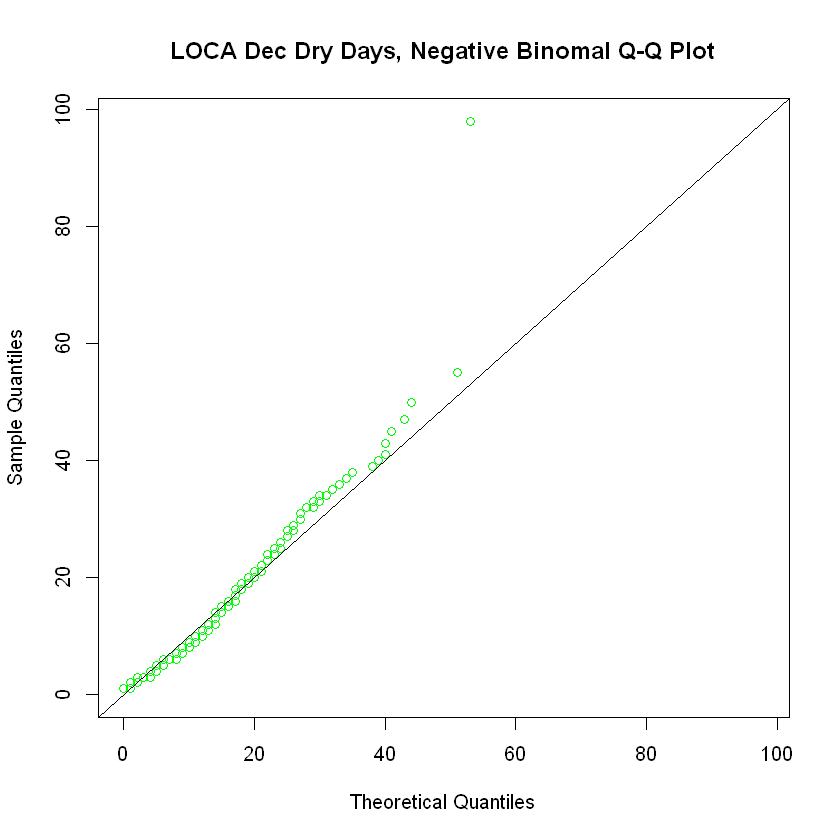

In [171]:
dLODecMax <- max( dLODec$Dry_Count )
dLODecMean <- mean( dLODec$Dry_Count )
dLODecVar <- var( dLODec$Dry_Count )
dLODecBNr <- dLODecMean^2 / (dLODecVar - dLODecMean)
dLODecTstNB <- rnbinom( 1000, mu=dLODecMean, size=dLODecBNr )
qqplot( dLODecTstNB, dLODec$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Dec Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLODecMax), ylim=c(0,dLODecMax) )
abline( 0, 1)

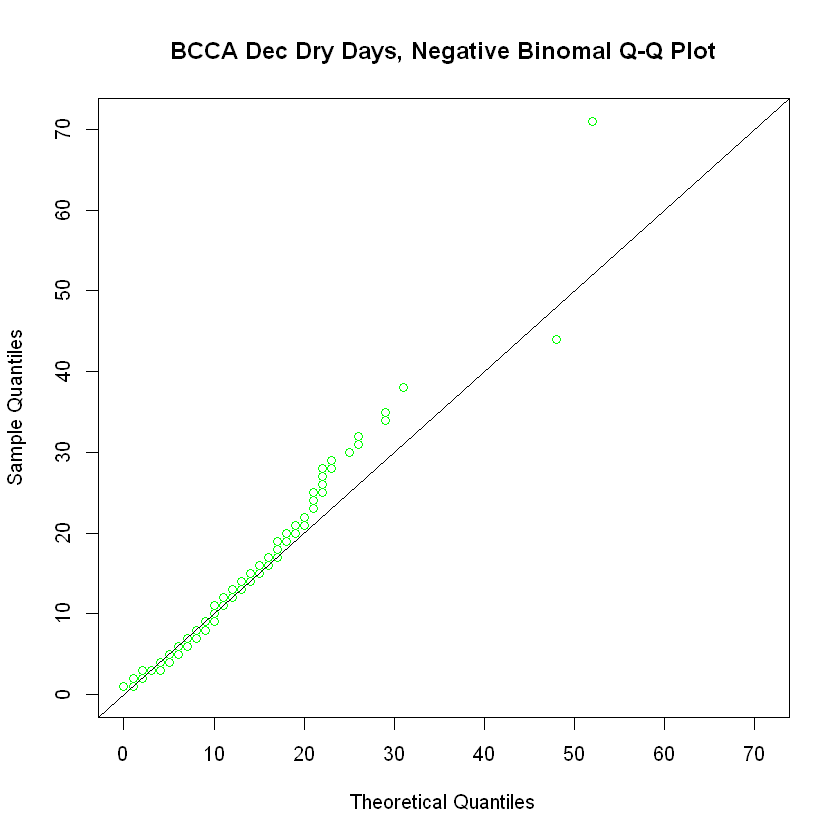

In [172]:
dBCDecMax <- max( dBCDec$Dry_Count )
dBCDecMean <- mean( dBCDec$Dry_Count )
dBCDecVar <- var( dBCDec$Dry_Count )
dBCDecBNr <- dBCDecMean^2 / (dBCDecVar - dBCDecMean)
dBCDecTstNB <- rnbinom( 1000, mu=dBCDecMean, size=dBCDecBNr )
qqplot( dBCDecTstNB, dBCDec$Dry_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Dec Dry Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCDecMax), ylim=c(0,dBCDecMax) )
abline( 0, 1)

In [173]:
cat("LOCA Jan scale: ", dLOJanBNr, "\n", "LOCA Feb scale: ", dLOFebBNr, "\n",
    "LOCA Mar scale: ", dLOMarBNr, "\n", "LOCA Apr scale: ", dLOAprBNr, "\n",
    "LOCA May scale: ", dLOMayBNr, "\n", "LOCA Jun scale: ", dLOJunBNr, "\n",
    "LOCA Jul scale: ", dLOJulBNr, "\n", "LOCA Aug scale: ", dLOAugBNr, "\n",
    "LOCA Sep scale: ", dLOSepBNr, "\n", "LOCA Oct scale: ", dLOOctBNr, "\n",
    "LOCA Nov scale: ", dLONovBNr, "\n", "LOCA Dec scale: ", dLODecBNr, "\n" )

LOCA Jan scale:  1.185742 
 LOCA Feb scale:  1.110408 
 LOCA Mar scale:  1.295 
 LOCA Apr scale:  1.561368 
 LOCA May scale:  1.231282 
 LOCA Jun scale:  0.7468242 
 LOCA Jul scale:  0.9668478 
 LOCA Aug scale:  1.257722 
 LOCA Sep scale:  1.118345 
 LOCA Oct scale:  0.9519948 
 LOCA Nov scale:  0.9171068 
 LOCA Dec scale:  1.013352 


In [174]:
cat("BCCA Jan scale: ", dBCJanBNr, "\n", "BCCA Feb scale: ", dBCFebBNr, "\n",
    "BCCA Mar scale: ", dBCMarBNr, "\n", "BCCA Apr scale: ", dBCAprBNr, "\n",
    "BCCA May scale: ", dBCMayBNr, "\n", "BCCA Jun scale: ", dBCJunBNr, "\n",
    "BCCA Jul scale: ", dBCJulBNr, "\n", "BCCA Aug scale: ", dBCAugBNr, "\n",
    "BCCA Sep scale: ", dBCSepBNr, "\n", "BCCA Oct scale: ", dBCOctBNr, "\n",
    "BCCA Nov scale: ", dBCNovBNr, "\n", "BCCA Dec scale: ", dBCDecBNr, "\n" )

BCCA Jan scale:  1.336154 
 BCCA Feb scale:  1.33611 
 BCCA Mar scale:  1.477125 
 BCCA Apr scale:  1.84942 
 BCCA May scale:  2.21017 
 BCCA Jun scale:  1.629825 
 BCCA Jul scale:  1.668563 
 BCCA Aug scale:  2.194356 
 BCCA Sep scale:  1.345049 
 BCCA Oct scale:  1.156827 
 BCCA Nov scale:  1.153981 
 BCCA Dec scale:  1.17702 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

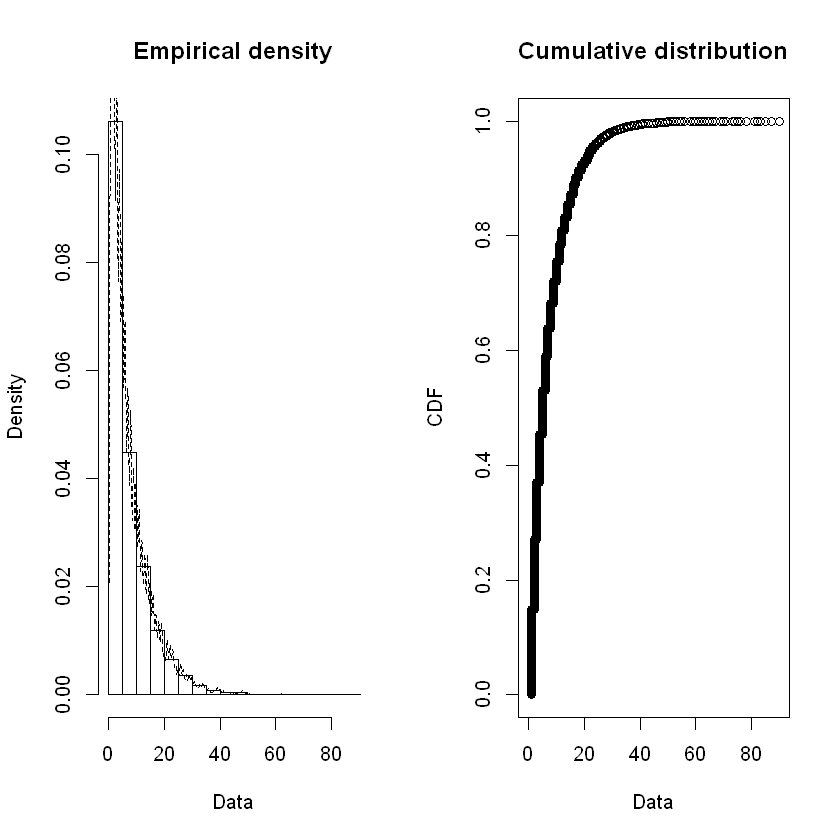

In [175]:
plotdist( dLOJan$Dry_Count, histo=TRUE, demp=TRUE )

In [176]:
LOfd_NB_dJan <- fitdist( dLOJan$Dry_Count, "nbinom" )
LOfd_GE_dJan <- fitdist( dLOJan$Dry_Count, "geom" )

In [177]:
summary( LOfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.514231 0.002421044
mu   7.601987 0.006660802
Loglikelihood:  -3156595   AIC:  6313194   BIC:  6313218 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0002459989
mu   -0.0002459989  1.0000000000


In [178]:
LOfdNB_dJan_size <- LOfd_NB_dJan$estimate[["size"]]
LOfdNB_dJan_mu <- LOfd_NB_dJan$estimate[["mu"]]
cat("LOCA Jan size: ", LOfdNB_dJan_size, "\n", "LOCA Jan mu: ", LOfdNB_dJan_mu, "\n")

LOCA Jan size:  1.514231 
 LOCA Jan mu:  7.601987 


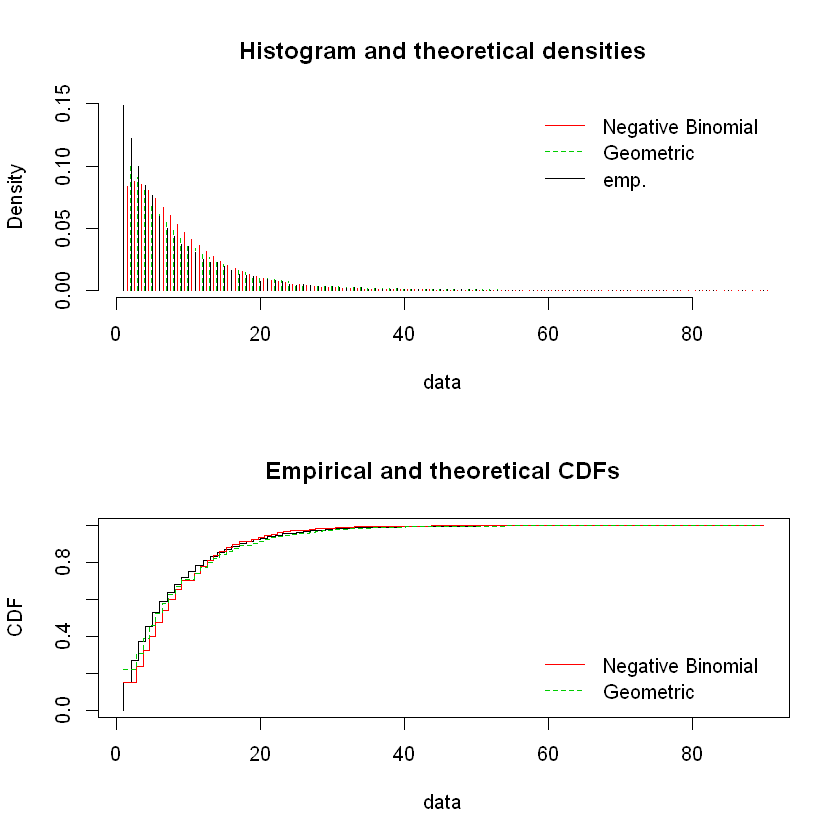

In [179]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )

In [180]:
LOstatRes <- gofstat( list(LOfd_NB_dJan, LOfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [181]:
print(LOstatRes)

Chi-squared statistic:  40867.14 48757.13 
Degree of freedom of the Chi-squared distribution:  33 34 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     153256            154072.8887     225999.561
<= 2     126029             90134.0580      93697.721
<= 3     102526             88046.1522      82803.597
<= 4      87203             82860.3148      73176.121
<= 5      78468             76203.3288      64668.020
<= 6      61285             68991.9249      57149.145
<= 7      51117             61758.5627      50504.482
<= 8      44891             54810.6609      44632.385
<= 9      38007             48317.9655      39443.031
<= 10     36004             42364.1573      34857.036
<= 11     31071             36978.8366      30804.250
<= 12     25414             32157.9670      27222.676
<= 13     23139             27877.1897      24057.527
<= 14     22944             24100.5751      21260.387
<= 15     19484             20786.3780    

In [182]:
LOfdNB_dJan_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [183]:
LOfdNB_dJan_p = LOfdNB_dJan_size / (LOfdNB_dJan_size + LOfdNB_dJan_mu)
cat("LOCA prob: ", LOfdNB_dJan_p)

LOCA prob:  0.166103

In [184]:
# add to our tracking dataframe
LOMonDistDF[1, ] <- list( 1, dLOJanMean, dLOJanBNr, LOfdNB_dJan_p, LOfdNB_dJan_mu, LOfdNB_dJan_size,
                          LOfdNB_dJan_pvalue )

In [185]:
LOgf_dJan <- goodfit( dLOJan$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJan_size, prob=LOfdNB_dJan_p) )

In [186]:
summary( LOgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          171509.6 90        0
Likelihood Ratio 217868.7 79        0


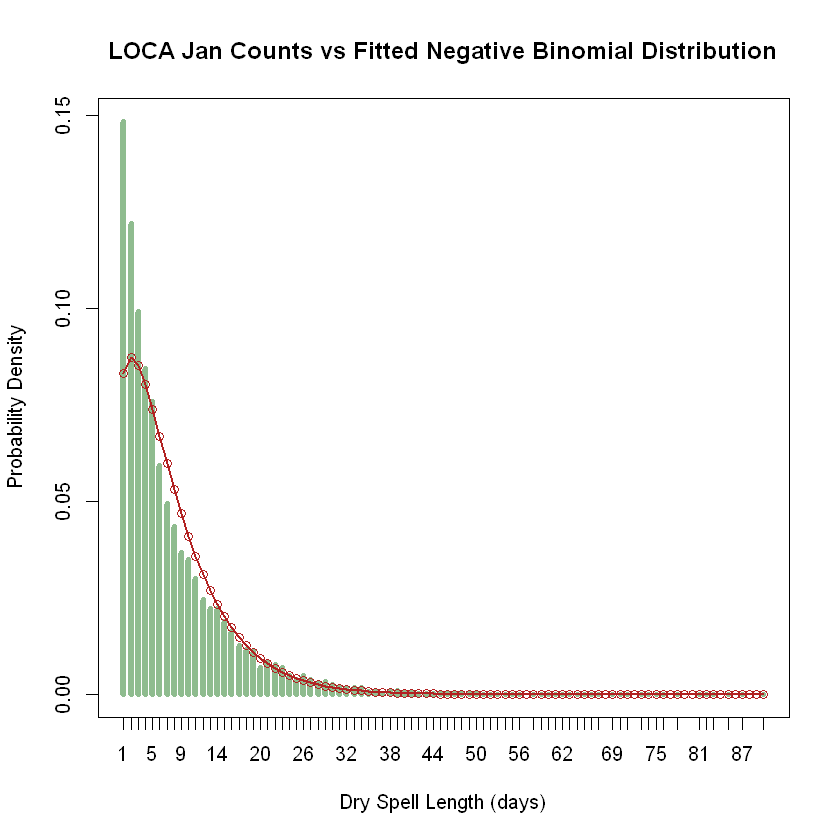

In [187]:
maxP <- max(dLOJan$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJan_size, mu=LOfdNB_dJan_mu )
ttab <- table( dLOJan$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

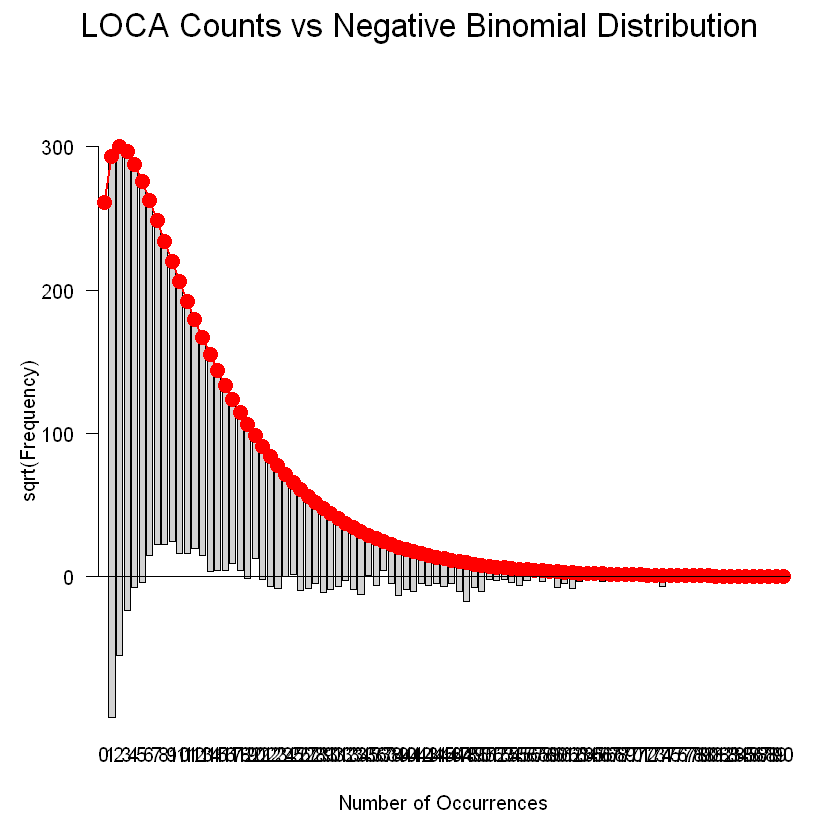

In [188]:
plot( LOgf_dJan, main="LOCA Counts vs Negative Binomial Distribution" )

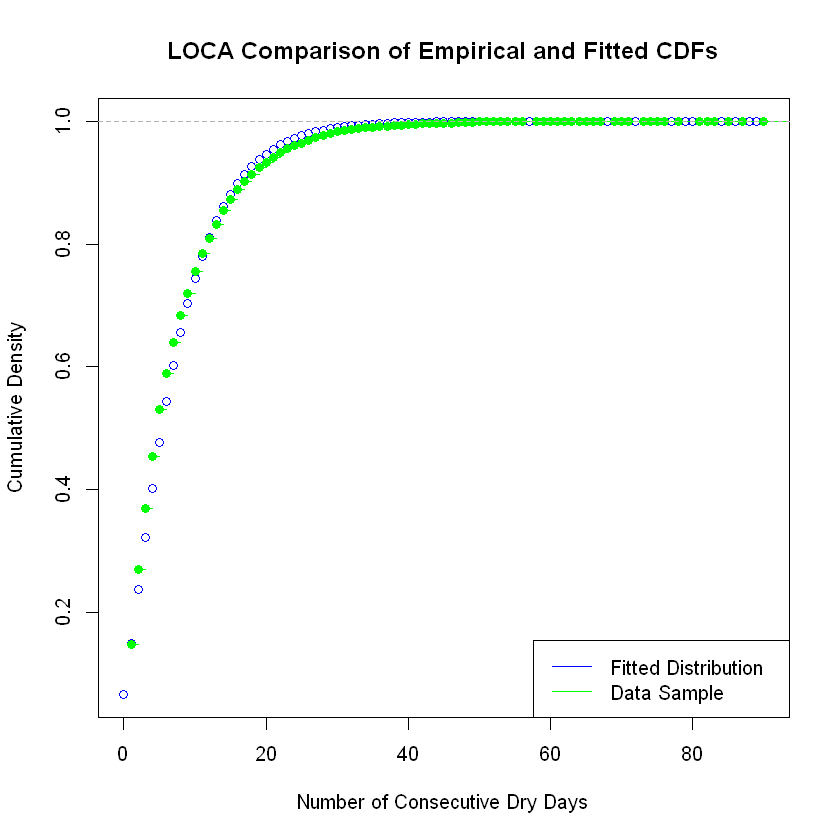

In [189]:
x <- seq(0,dLOJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJan$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [190]:
ks.test( dLOJan$Dry_Count, "pnbinom", mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size )


	One-sample Kolmogorov-Smirnov test

data:  dLOJan$Dry_Count
D = 0.14931, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

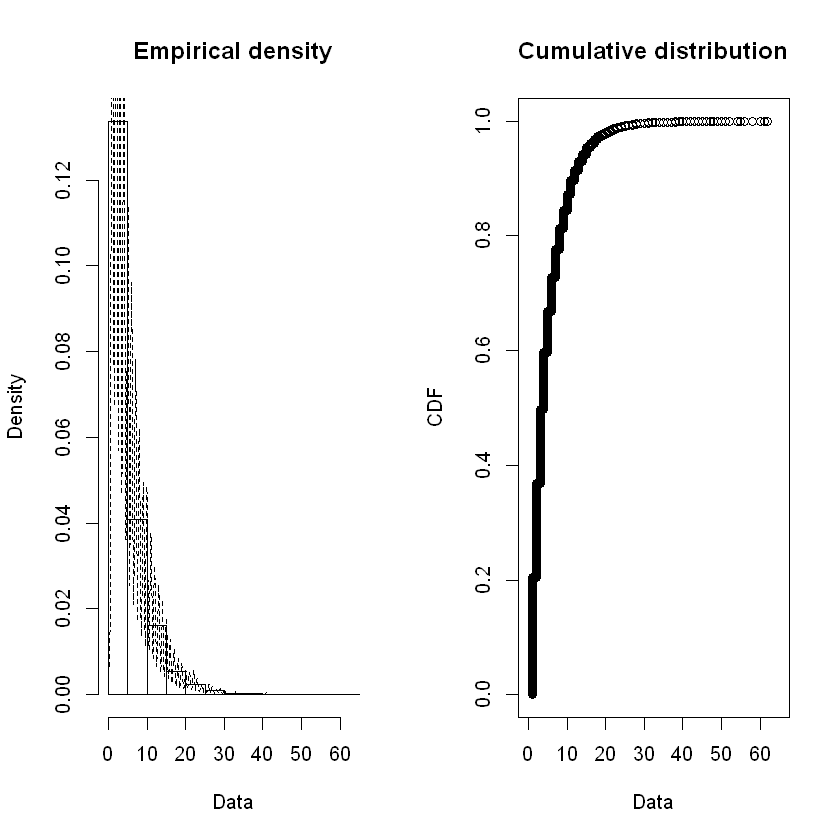

In [191]:
plotdist( dBCJan$Dry_Count, histo=TRUE, demp=TRUE )

In [192]:
BCfd_NB_dJan <- fitdist( dBCJan$Dry_Count, "nbinom" )
BCfd_GE_dJan <- fitdist( dBCJan$Dry_Count, "geom" )

In [193]:
summary( BCfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.874835 0.004129592
mu   5.233172 0.005317199
Loglikelihood:  -1884388   AIC:  3768781   BIC:  3768804 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001147639
mu   -0.0001147639  1.0000000000


In [194]:
BCfdNB_dJan_size <- BCfd_NB_dJan$estimate[["size"]]
BCfdNB_dJan_mu <- BCfd_NB_dJan$estimate[["mu"]]
cat("BCCA Jan size: ", BCfdNB_dJan_size, "\n", "BCCA Jan mu: ", BCfdNB_dJan_mu, "\n")

BCCA Jan size:  1.874835 
 BCCA Jan mu:  5.233172 


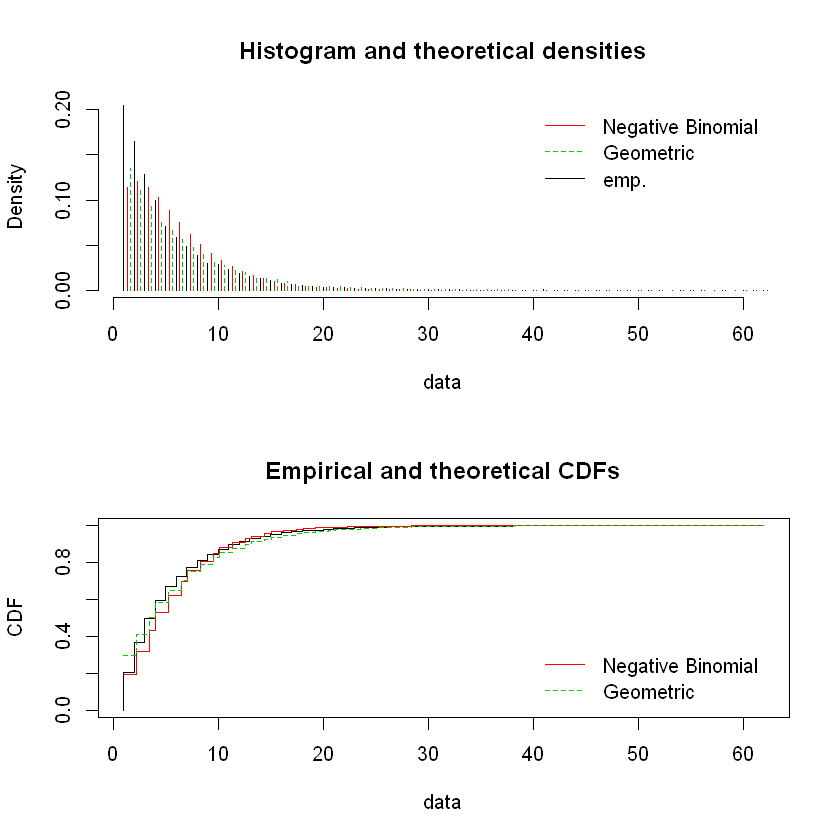

In [195]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )

In [196]:
BCstatRes <- gofstat( list(BCfd_NB_dJan, BCfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [197]:
print(BCstatRes)

Chi-squared statistic:  40471.16 51378.56 
Degree of freedom of the Chi-squared distribution:  23 24 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     143543            137324.4025     207142.316
<= 2     115429             84273.7757      79370.117
<= 3      90437             80138.5680      66635.844
<= 4      70002             71904.9302      55944.679
<= 5      49827             62201.5916      46968.822
<= 6      41415             52472.2495      39433.066
<= 7      33778             43460.0538      33106.359
<= 8      26645             35495.8609      27794.720
<= 9      21042             28673.5988      23335.289
<= 10     20331             22957.3646      19591.337
<= 11     16385             18246.2693      16448.070
<= 12     13035             14412.9094      13809.114
<= 13     10814             11325.3930      11593.557
<= 14      9153              8859.2009       9733.468
<= 15      7543              6902.8695    

In [198]:
BCfdNB_dJan_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [199]:
BCfdNB_dJan_p = BCfdNB_dJan_size / (BCfdNB_dJan_size + BCfdNB_dJan_mu)
cat("BCCA prob: ", BCfdNB_dJan_p)

BCCA prob:  0.2637638

In [200]:
# add to our tracking dataframe
BCMonDistDF[1, ] <- list( 1, dBCJanMean, dBCJanBNr, BCfdNB_dJan_p, BCfdNB_dJan_mu, BCfdNB_dJan_size,
                          BCfdNB_dJan_pvalue )

In [201]:
BCgf_dJan <- goodfit( dBCJan$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJan_size, prob=BCfdNB_dJan_p) )

In [202]:
summary( BCgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          190208.8 62        0
Likelihood Ratio 192684.9 58        0


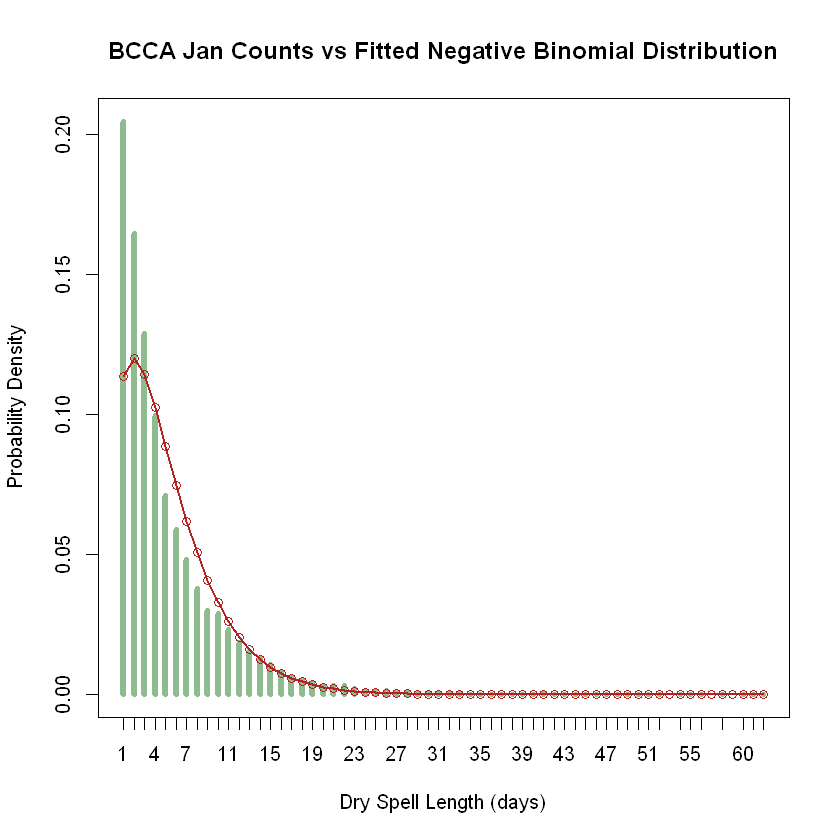

In [203]:
maxP <- max(dBCJan$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJan_size, mu=BCfdNB_dJan_mu )
ttab <- table( dBCJan$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

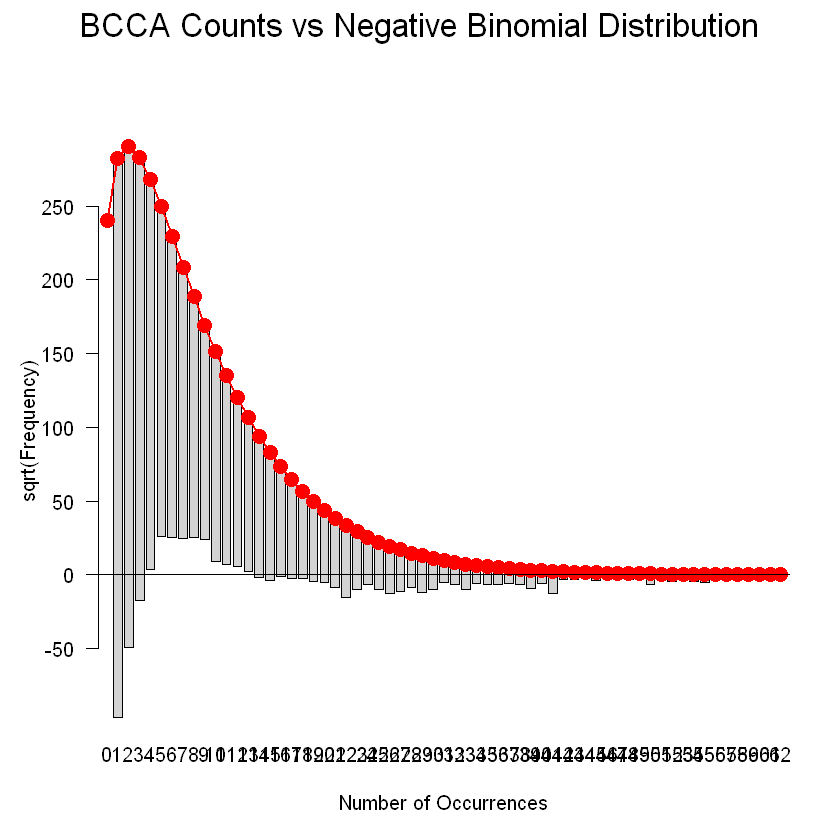

In [204]:
plot( BCgf_dJan, main="BCCA Counts vs Negative Binomial Distribution" )

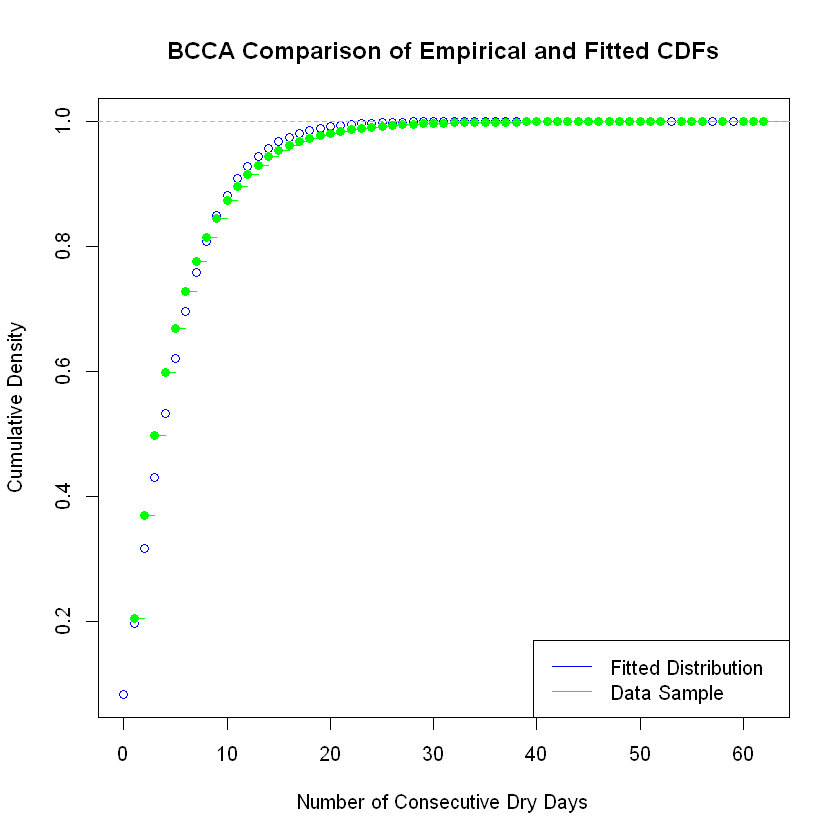

In [205]:
x <- seq(0,dBCJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJan_mu, size=BCfdNB_dJan_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJan$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

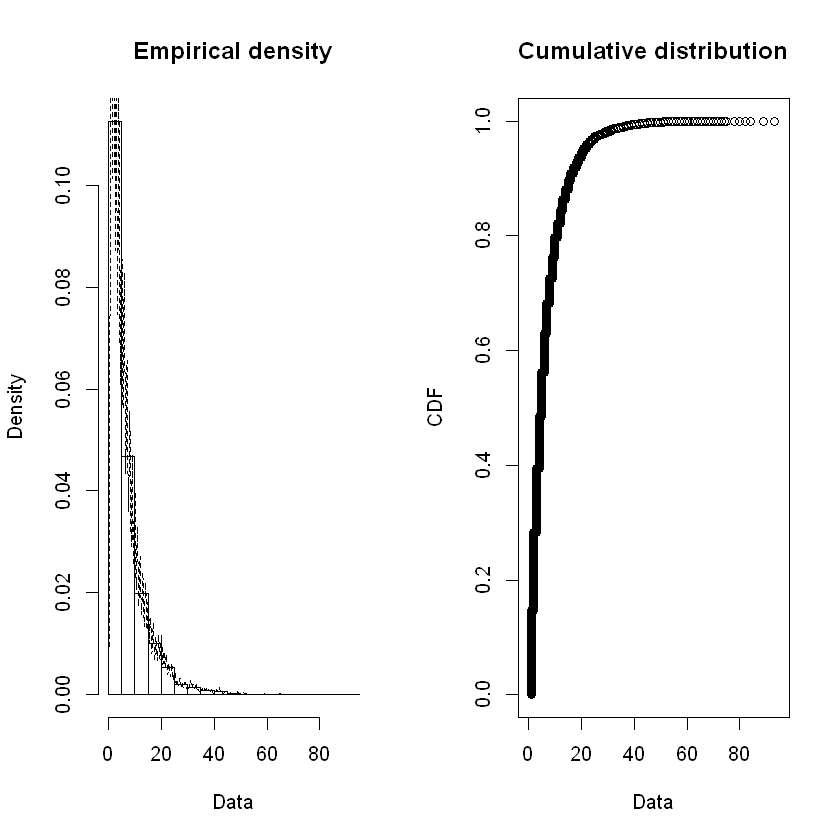

In [206]:
plotdist( dLOFeb$Dry_Count, histo=TRUE, demp=TRUE )

In [207]:
LOfd_NB_dFeb <- fitdist( dLOFeb$Dry_Count, "nbinom" )
LOfd_GE_dFeb <- fitdist( dLOFeb$Dry_Count, "geom" )

In [208]:
LOfdNB_dFeb_size <- LOfd_NB_dFeb$estimate[["size"]]
LOfdNB_dFeb_mu <- LOfd_NB_dFeb$estimate[["mu"]]
cat("LOCA Feb size: ", LOfdNB_dFeb_size, "\n", "LOCA Feb mu: ", LOfdNB_dFeb_mu, "\n")

LOCA Feb size:  1.572926 
 LOCA Feb mu:  7.007788 


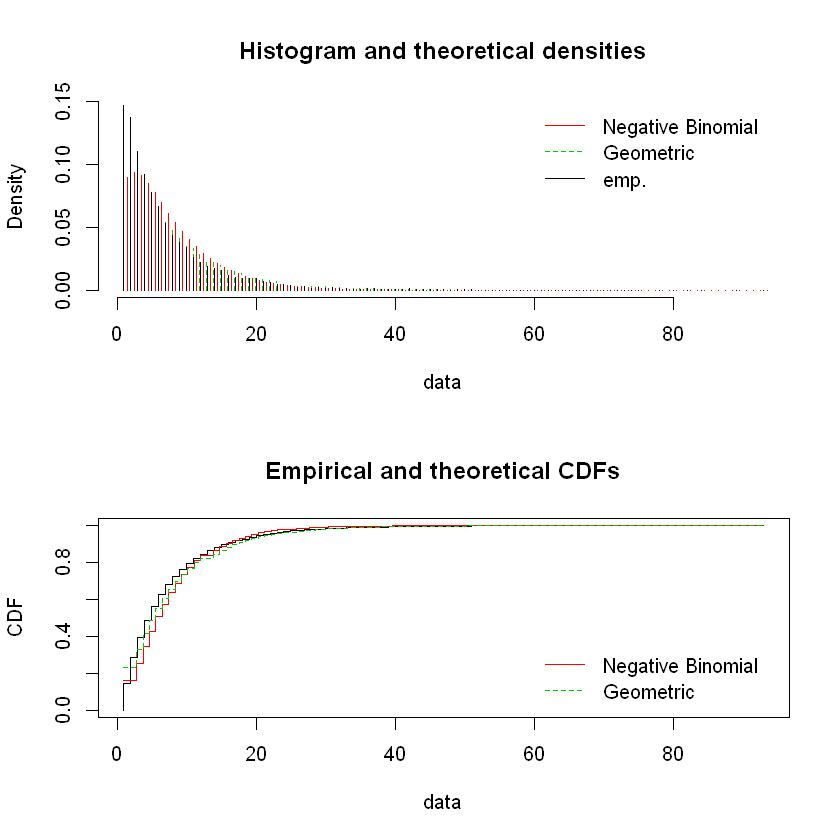

In [209]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )

In [210]:
LOstatRes <- gofstat( list(LOfd_NB_dFeb, LOfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [211]:
print( LOstatRes )

Chi-squared statistic:  74065.43 75940.72 
Degree of freedom of the Chi-squared distribution:  31 32 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     149470            161833.7718    239190.0222
<= 2     140033             95605.0435     97689.5204
<= 3     112811             92991.0381     85489.8946
<= 4      93425             86822.6035     74813.7779
<= 5      79115             79032.1148     65470.9119
<= 6      67903             70708.0114     57294.7982
<= 7      53703             62472.9226     50139.7309
<= 8      44158             54674.9557     43878.2000
<= 9      38646             47495.0293     38398.6192
<= 10     34492             41011.0492     33603.3373
<= 11     26190             35237.8092     29406.8980
<= 12     22356             30152.3761     25734.5169
<= 13     19511             25710.4216     22520.7487
<= 14     17768             21856.7433     19708.3211
<= 15     16055             18531.9850    

In [212]:
LOfdNB_dFeb_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [213]:
LOfdNB_dFeb_p = LOfdNB_dFeb_size / (LOfdNB_dFeb_size + LOfdNB_dFeb_mu)
cat("LOCA prob: ", LOfdNB_dFeb_p)

LOCA prob:  0.1833095

In [214]:
# add to our tracking dataframe
LOMonDistDF[2, ] <- list( 2, dLOFebMean, dLOFebBNr, LOfdNB_dFeb_p, LOfdNB_dFeb_mu, LOfdNB_dFeb_size,
                          LOfdNB_dFeb_pvalue )

In [215]:
LOgf_dFeb <- goodfit( dLOFeb$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dFeb_size, prob=LOfdNB_dFeb_p) )

In [216]:
summary( LOgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          239365.6 93        0
Likelihood Ratio 232837.9 80        0


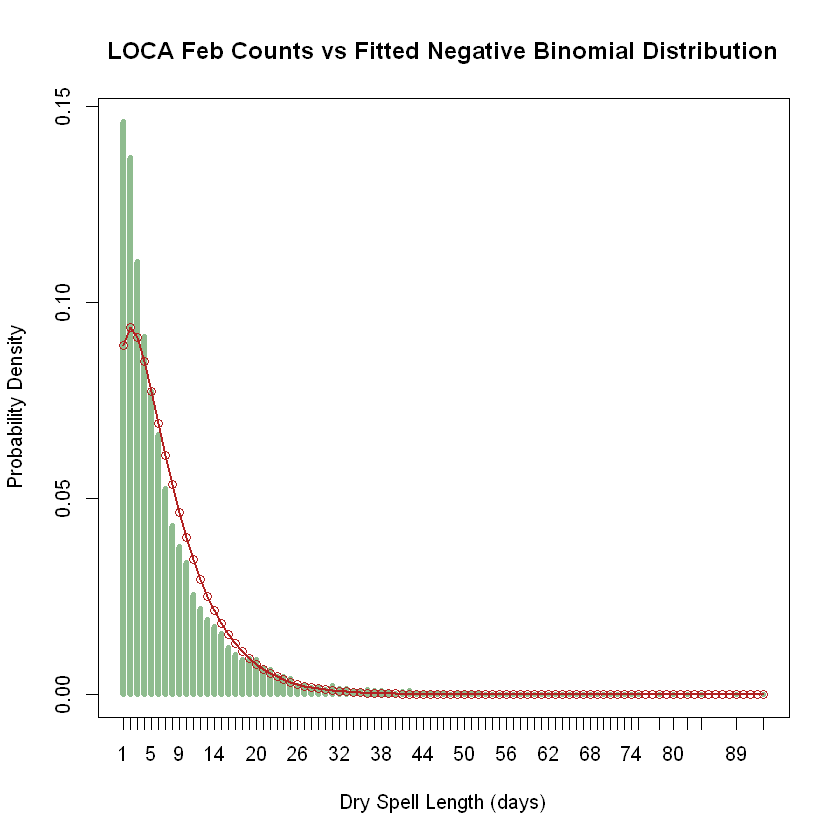

In [217]:
maxP <- max(dLOFeb$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dFeb_size, mu=LOfdNB_dFeb_mu )
ttab <- table( dLOFeb$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

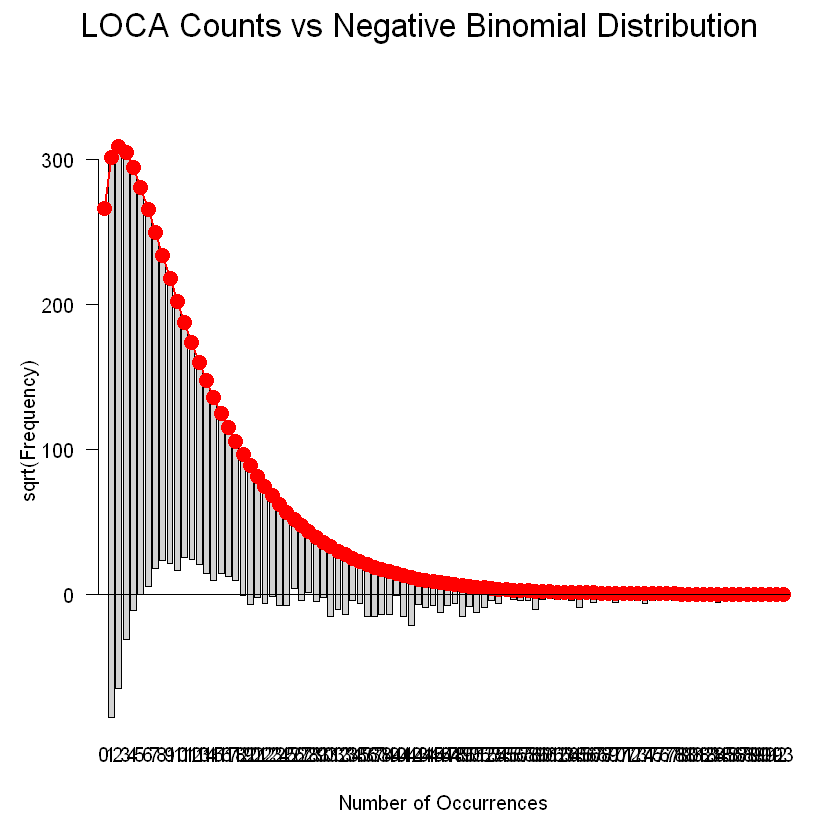

In [218]:
plot( LOgf_dFeb, main="LOCA Counts vs Negative Binomial Distribution" )

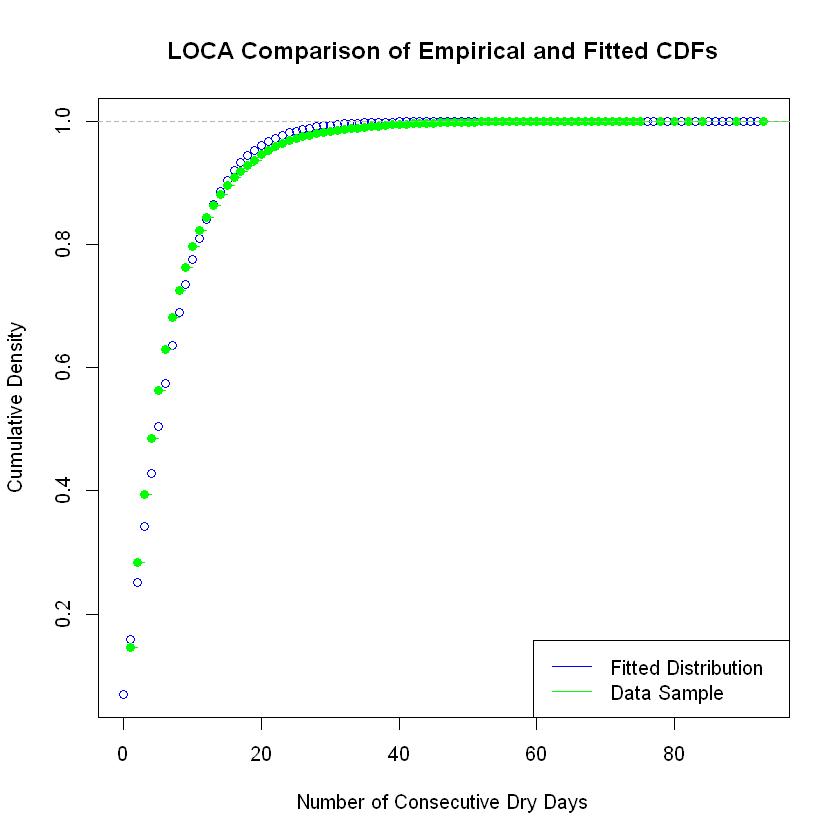

In [219]:
x <- seq(0,dLOFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dFeb_mu, size=LOfdNB_dFeb_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOFeb$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

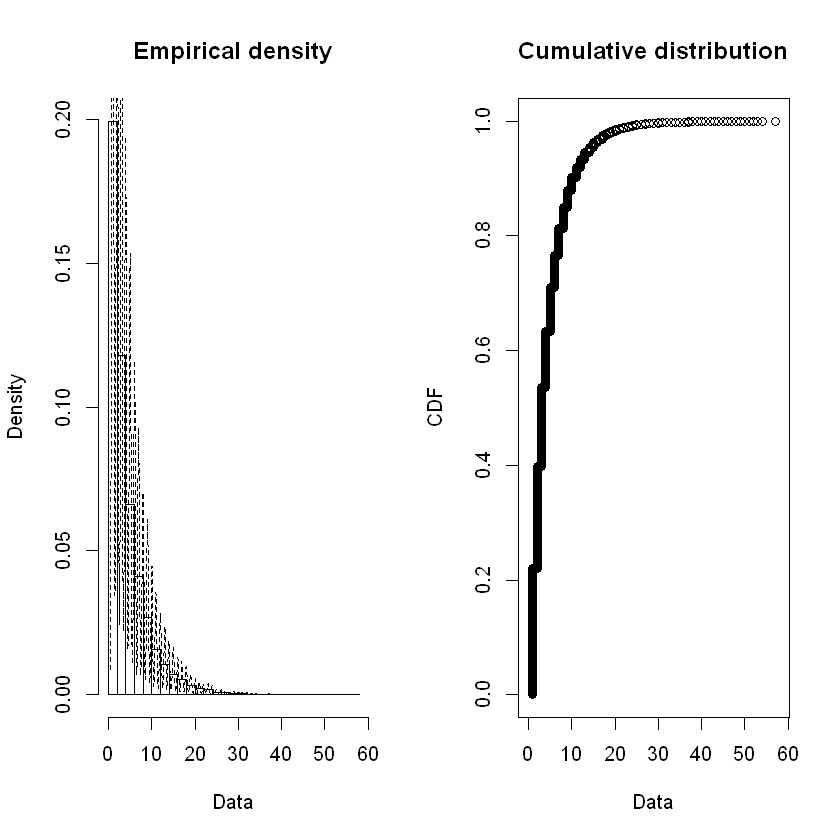

In [220]:
plotdist( dBCFeb$Dry_Count, histo=TRUE, demp=TRUE )

In [221]:
BCfd_NB_dFeb <- fitdist( dBCFeb$Dry_Count, "nbinom" )
BCfd_GE_dFeb <- fitdist( dBCFeb$Dry_Count, "geom" )

In [222]:
summary( BCfd_NB_dFeb )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.996164 0.004629944
mu   4.758978 0.004850344
Loglikelihood:  -1772949   AIC:  3545903   BIC:  3545926 
Correlation matrix:
              size            mu
size  1.000000e+00 -5.803133e-06
mu   -5.803133e-06  1.000000e+00


In [223]:
BCfdNB_dFeb_size <- BCfd_NB_dFeb$estimate[["size"]]
BCfdNB_dFeb_mu <- BCfd_NB_dFeb$estimate[["mu"]]
cat("BCCA Feb size: ", BCfdNB_dFeb_size, "\n", "BCCA Feb mu: ", BCfdNB_dFeb_mu, "\n")

BCCA Feb size:  1.996164 
 BCCA Feb mu:  4.758978 


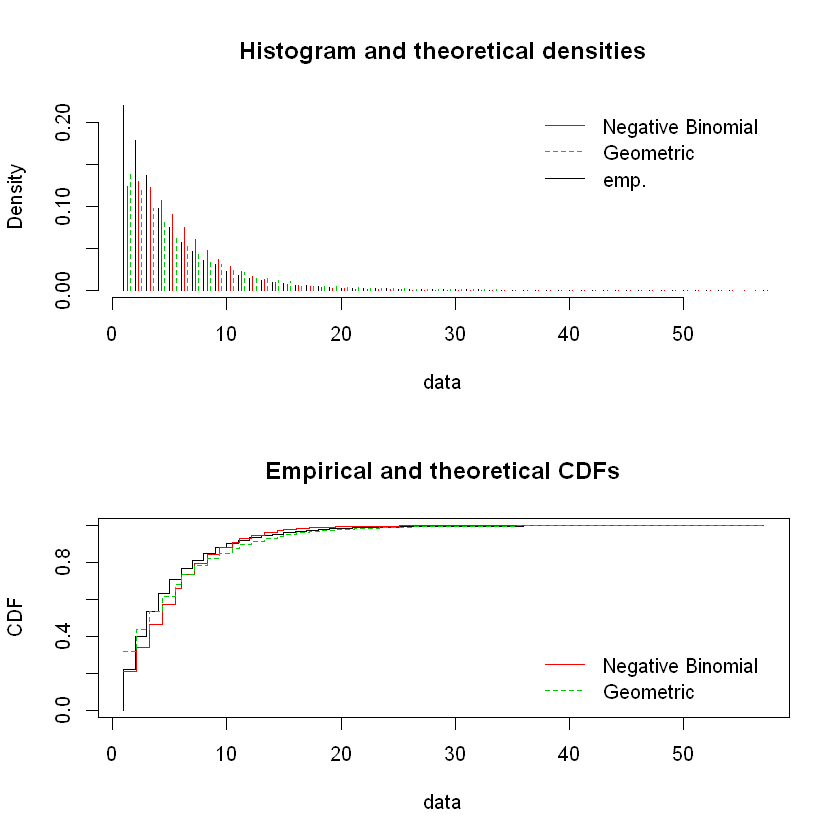

In [224]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )

In [225]:
BCstatRes <- gofstat( list(BCfd_NB_dFeb, BCfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [226]:
print(BCstatRes)

Chi-squared statistic:  61174.59 58925.82 
Degree of freedom of the Chi-squared distribution:  21 22 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     150823           144514.78610     217095.737
<= 2     122050            89136.21950      81171.113
<= 3      93999            83647.98298      67076.363
<= 4      67205            73605.68992      55429.060
<= 5      51662            62186.21304      45804.223
<= 6      38979            51083.66739      37850.666
<= 7      31805            41109.76087      31278.184
<= 8      24634            32568.03518      25846.964
<= 9      20928            25483.65131      21358.834
<= 10     15603            19741.58853      17650.034
<= 11     12095            15167.39647      14585.239
<= 12      9486            11572.42064      12052.623
<= 13      8073             8777.46522       9959.776
<= 14      6405             6623.69764       8230.336
<= 15      5471             4976.27446    

In [227]:
BCfdNB_dFeb_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [228]:
BCfdNB_dFeb_p = BCfdNB_dFeb_size / (BCfdNB_dFeb_size + BCfdNB_dFeb_mu)
cat("BCCA prob: ", BCfdNB_dFeb_p)

BCCA prob:  0.2955028

In [229]:
# add to our tracking dataframe
BCMonDistDF[2, ] <- list( 2, dBCFebMean, dBCFebBNr, BCfdNB_dFeb_p, BCfdNB_dFeb_mu, BCfdNB_dFeb_size,
                          BCfdNB_dFeb_pvalue )

In [230]:
BCgf_dFeb <- goodfit( dBCFeb$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dFeb_size, prob=BCfdNB_dFeb_p) )

In [231]:
summary( BCgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          252696.6 57        0
Likelihood Ratio 203539.4 54        0


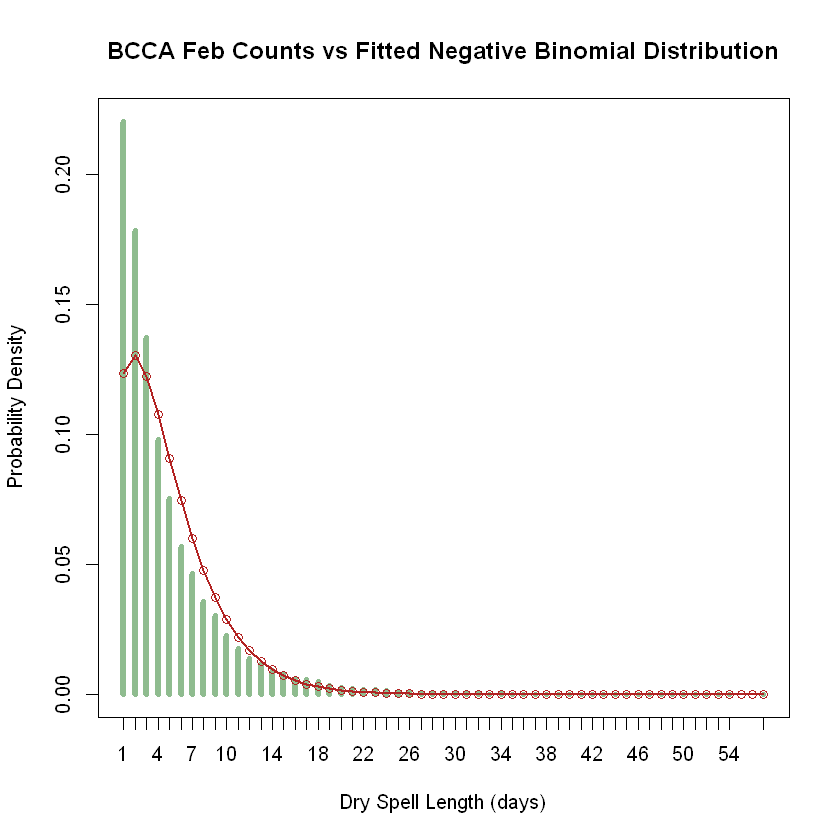

In [232]:
maxP <- max(dBCFeb$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dFeb_size, mu=BCfdNB_dFeb_mu )
ttab <- table( dBCFeb$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

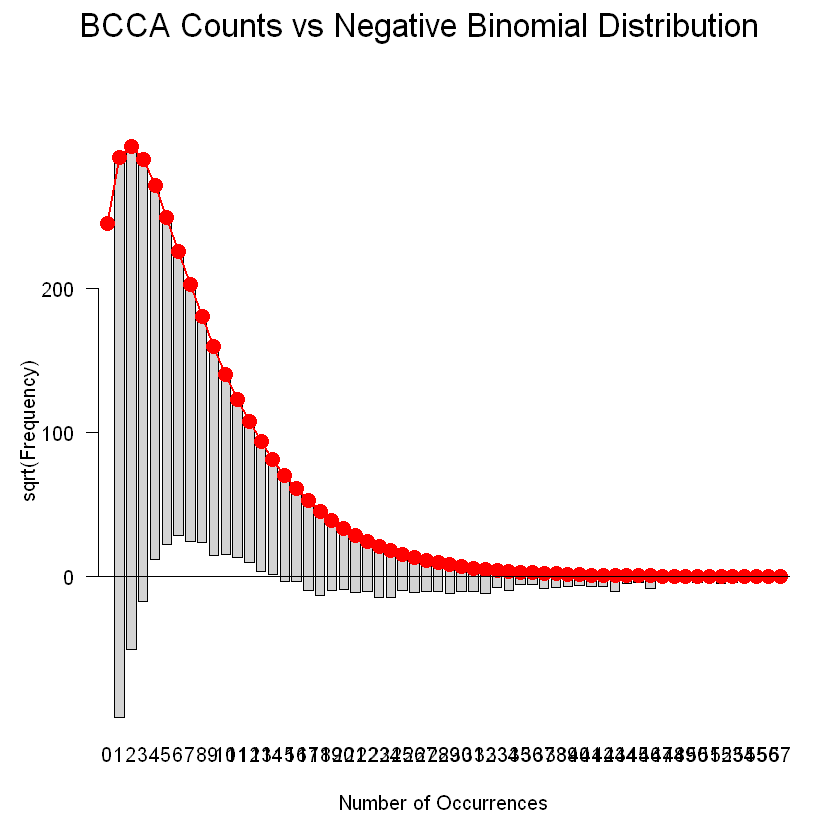

In [233]:
plot( BCgf_dFeb, main="BCCA Counts vs Negative Binomial Distribution" )

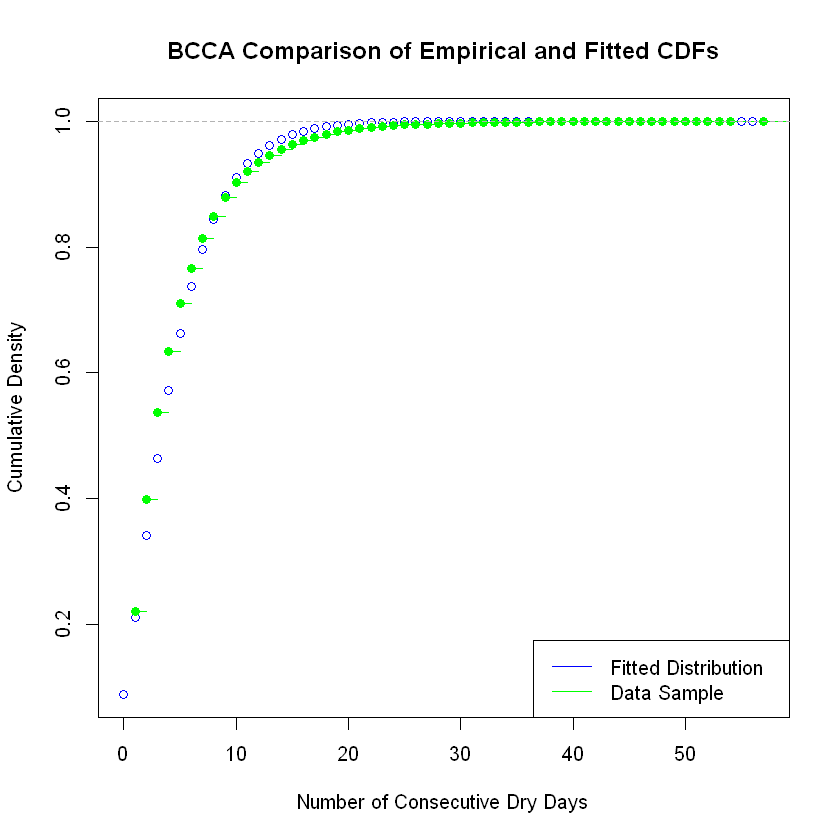

In [234]:
x <- seq(0,dBCFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dFeb_mu, size=BCfdNB_dFeb_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCFeb$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

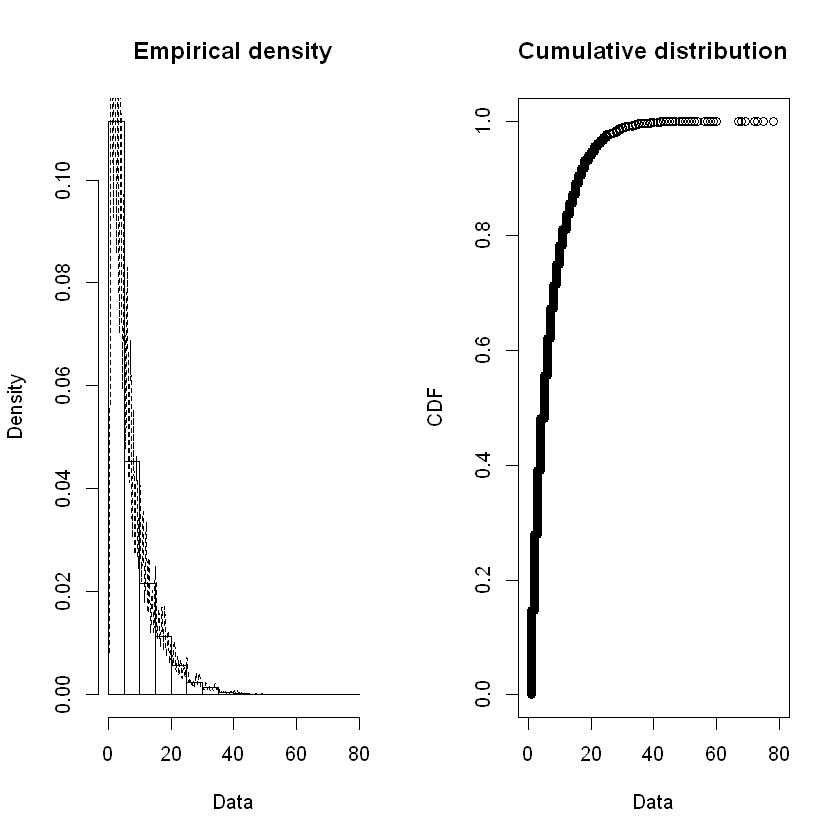

In [235]:
plotdist( dLOMar$Dry_Count, histo=TRUE, demp=TRUE )

In [236]:
LOfd_NB_dMar <- fitdist( dLOMar$Dry_Count, "nbinom" )
LOfd_GE_dMar <- fitdist( dLOMar$Dry_Count, "geom" )

In [237]:
LOfdNB_dMar_size <- LOfd_NB_dMar$estimate[["size"]]
LOfdNB_dMar_mu <- LOfd_NB_dMar$estimate[["mu"]]
cat("LOCA Mar size: ", LOfdNB_dMar_size, "\n", "LOCA Mar mu: ", LOfdNB_dMar_mu, "\n")

LOCA Mar size:  1.6389 
 LOCA Mar mu:  6.987467 


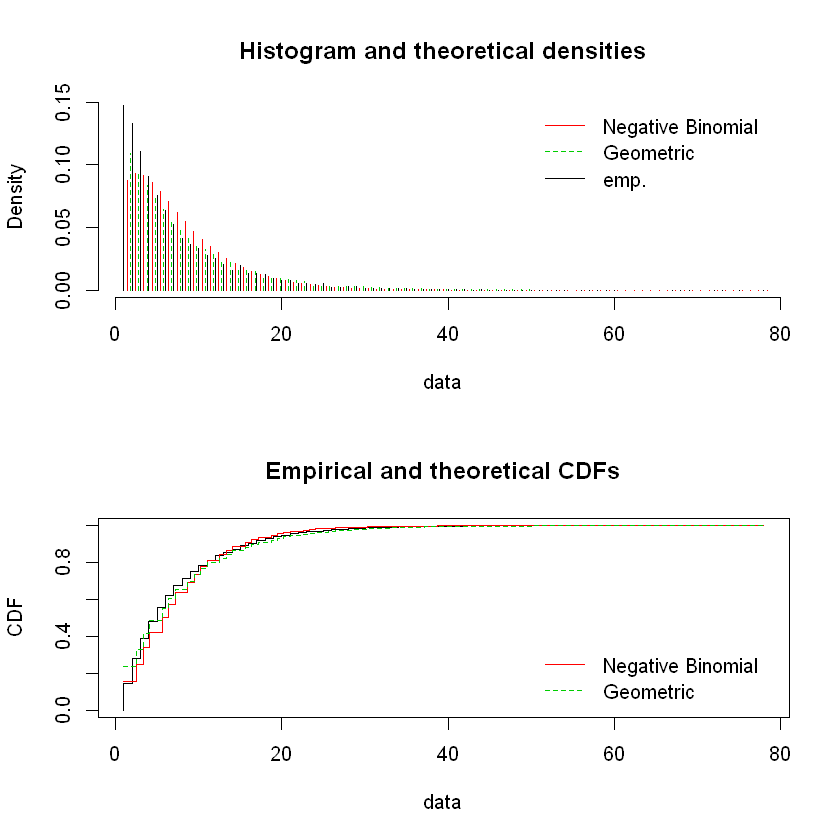

In [238]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )

In [239]:
LOstatRes <- gofstat( list(LOfd_NB_dMar, LOfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [240]:
print( LOstatRes )

Chi-squared statistic:  53712.95 75606.36 
Degree of freedom of the Chi-squared distribution:  30 31 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     161645            167968.0531     257589.910
<= 2     145891            102390.7062     105149.116
<= 3     121819            100600.7588      91986.404
<= 4      99329             94503.5501      80471.419
<= 5      82742             86330.5198      70397.896
<= 6      69935             77375.0735      61585.390
<= 7      57951             68395.2120      53876.046
<= 8      44935             59825.4535      47131.768
<= 9      39771             51899.4557      41231.748
<= 10     36584             44725.1048      36070.301
<= 11     30230             38332.0862      31554.971
<= 12     27522             32702.6031      27604.876
<= 13     22569             27791.3826      24149.260
<= 14     16871             23538.6958      21126.222
<= 15     21371             19878.7547    

In [241]:
LOfdNB_dMar_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [242]:
LOfdNB_dMar_p = LOfdNB_dMar_size / (LOfdNB_dMar_size + LOfdNB_dMar_mu)
cat("LOCA prob: ", LOfdNB_dMar_p)

LOCA prob:  0.1899873

In [243]:
# add to our tracking dataframe
LOMonDistDF[3, ] <- list( 3, dLOMarMean, dLOMarBNr, LOfdNB_dMar_p, LOfdNB_dMar_mu, LOfdNB_dMar_size,
                          LOfdNB_dMar_pvalue )

In [244]:
LOgf_dMar <- goodfit( dLOMar$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMar_size, prob=LOfdNB_dMar_p) )

In [245]:
summary( LOgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          174872.3 78        0
Likelihood Ratio 232855.4 65        0


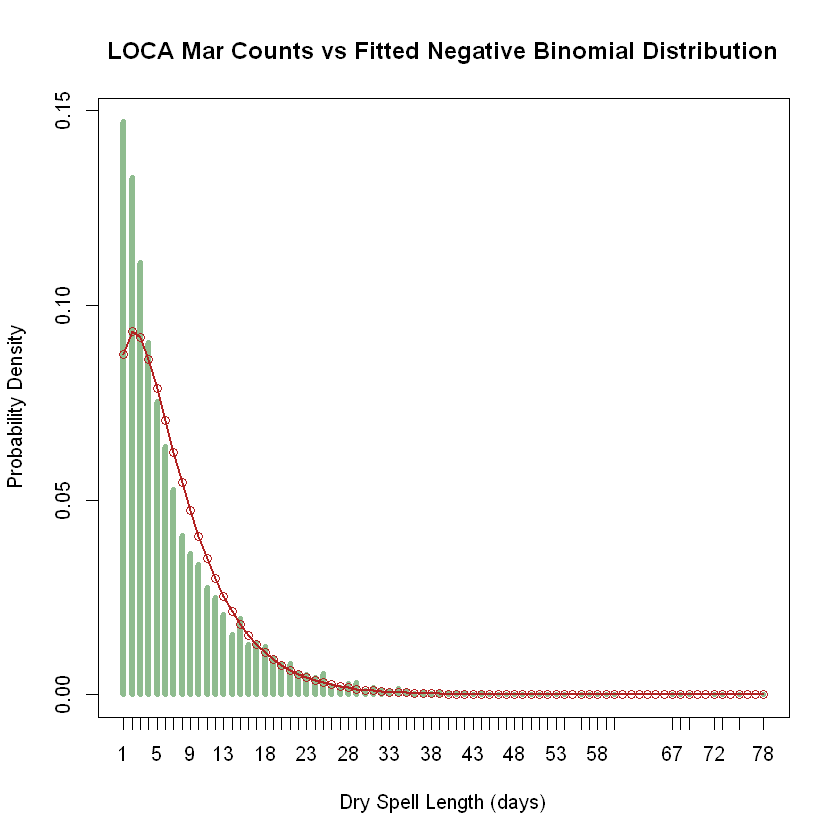

In [246]:
maxP <- max(dLOMar$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMar_size, mu=LOfdNB_dMar_mu )
ttab <- table( dLOMar$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

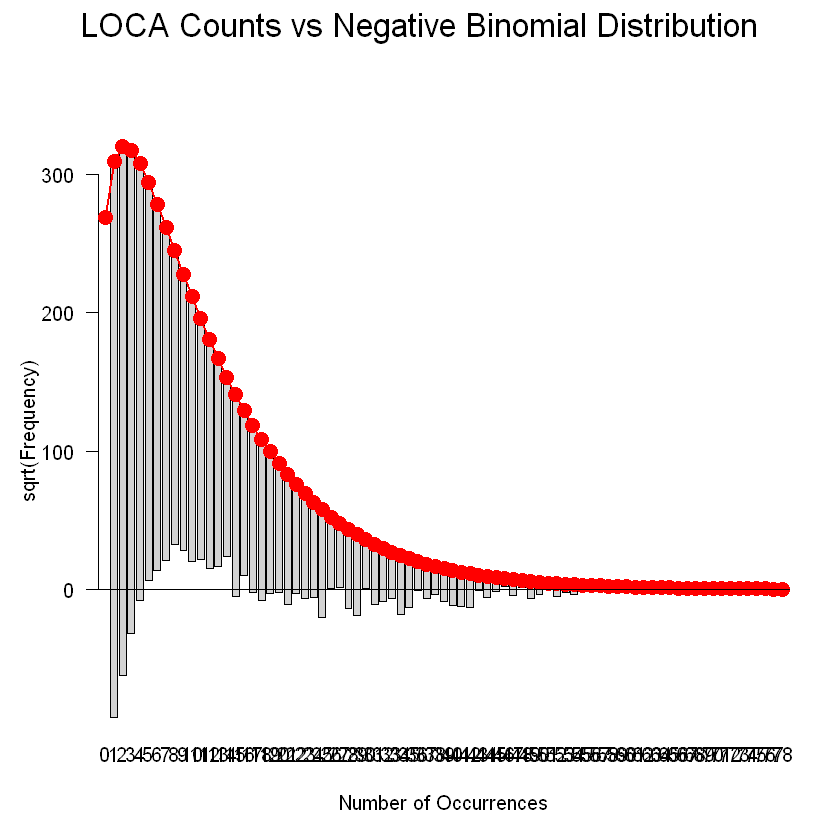

In [247]:
plot( LOgf_dMar, main="LOCA Counts vs Negative Binomial Distribution" )

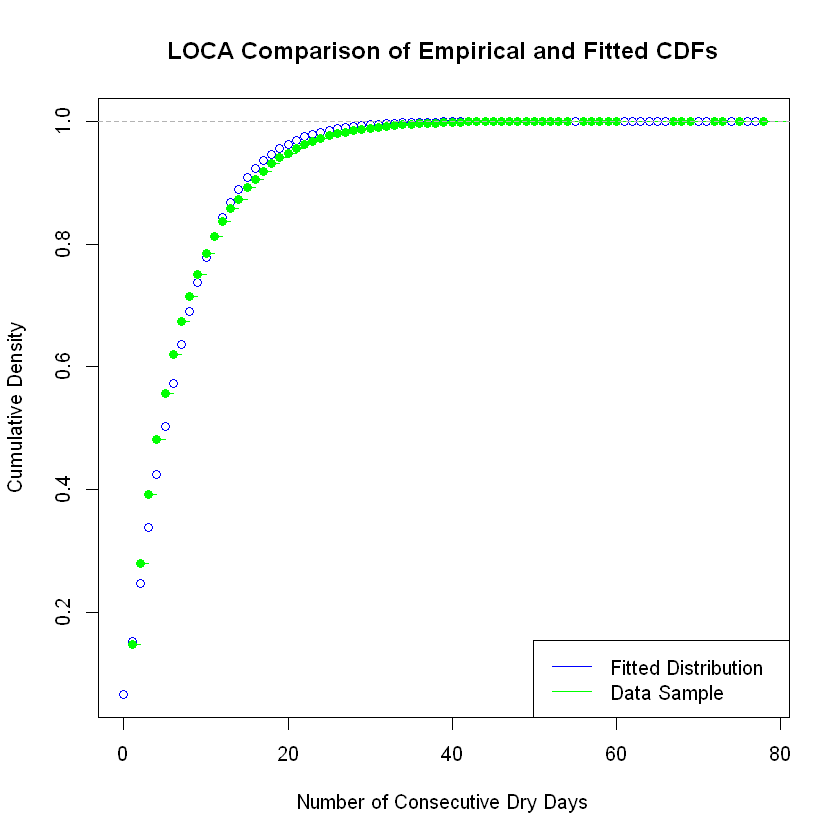

In [248]:
x <- seq(0,dLOMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMar_mu, size=LOfdNB_dMar_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMar$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

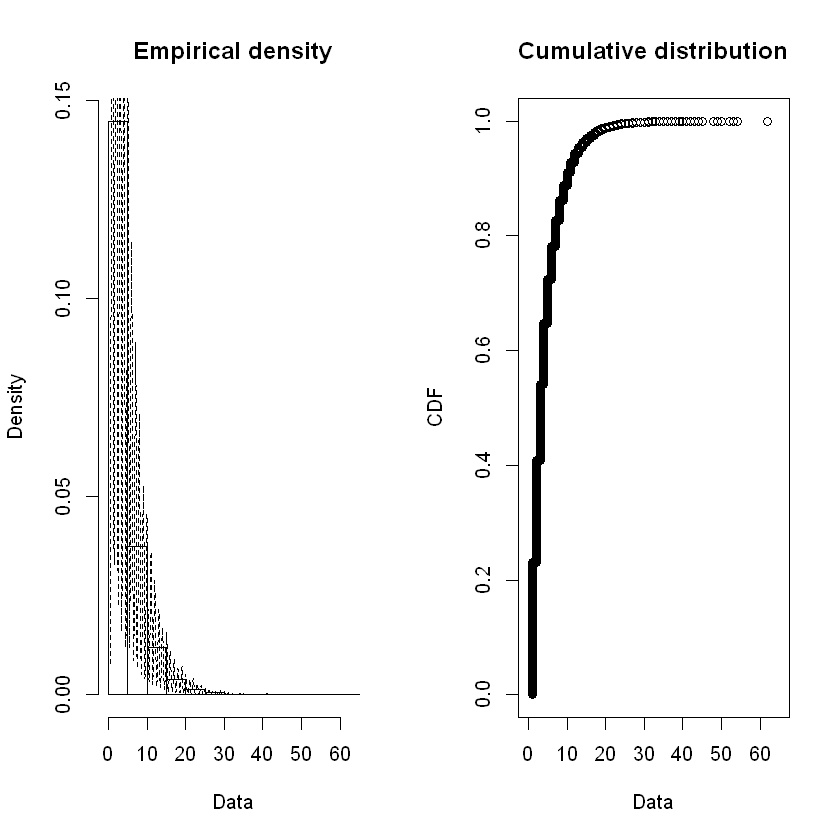

In [249]:
plotdist( dBCMar$Dry_Count, histo=TRUE, demp=TRUE )

In [250]:
BCfd_NB_dMar <- fitdist( dBCMar$Dry_Count, "nbinom" )
BCfd_GE_dMar <- fitdist( dBCMar$Dry_Count, "geom" )

In [251]:
summary( BCfd_NB_dMar )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.139504 0.004842761
mu   4.552470 0.004284288
Loglikelihood:  -1970513   AIC:  3941029   BIC:  3941052 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001489293
mu   -0.0001489293  1.0000000000


In [252]:
BCfdNB_dMar_size <- BCfd_NB_dMar$estimate[["size"]]
BCfdNB_dMar_mu <- BCfd_NB_dMar$estimate[["mu"]]
cat("BCCA Mar size: ", BCfdNB_dMar_size, "\n", "BCCA Mar mu: ", BCfdNB_dMar_mu, "\n")

BCCA Mar size:  2.139504 
 BCCA Mar mu:  4.55247 


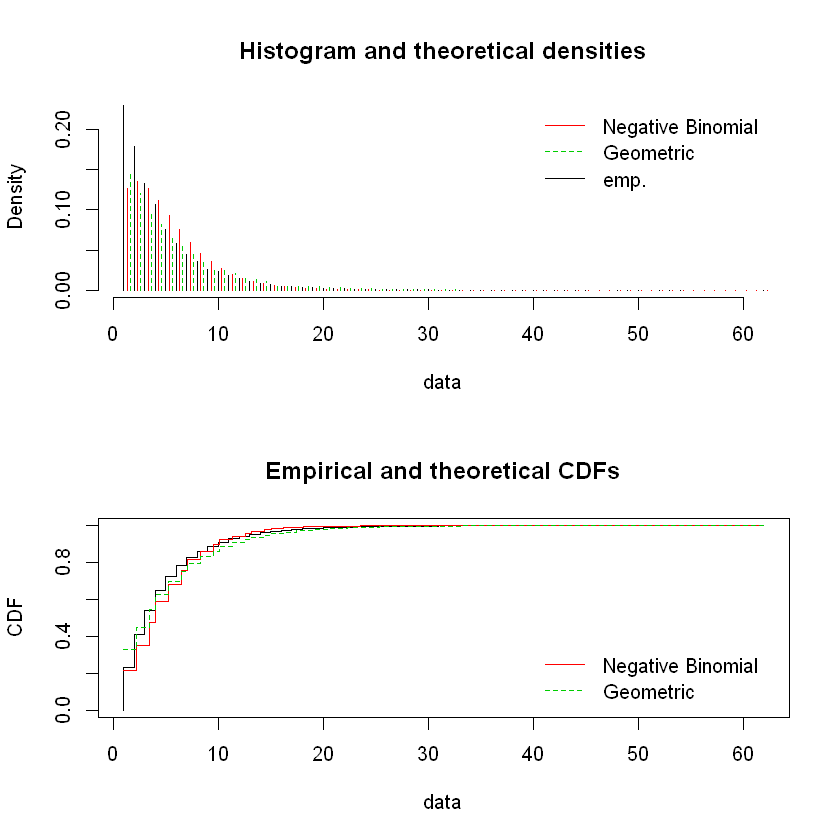

In [253]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )

In [254]:
BCstatRes <- gofstat( list(BCfd_NB_dMar, BCfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [255]:
print(BCstatRes)

Chi-squared statistic:  55483.03 64957.39 
Degree of freedom of the Chi-squared distribution:  20 21 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     178298            166097.5122     254324.283
<= 2     138501            105137.2858      93940.103
<= 3     102851             98690.8010      77020.227
<= 4      83064             86264.2303      63147.847
<= 5      58707             72058.7782      51774.070
<= 6      45430             58330.6137      42448.864
<= 7      34656             46141.2449      34803.252
<= 8      27324             35860.3734      28534.718
<= 9      20262             27484.1221      23395.231
<= 10     17680             20827.6650      19181.435
<= 11     14014             15636.5775      15726.601
<= 12     11194             11647.4884      12894.028
<= 13      8384              8618.1881      10571.640
<= 14      6714              6340.0465       8667.546
<= 15      5892              4640.7078    

In [256]:
BCfdNB_dMar_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [257]:
BCfdNB_dMar_p = BCfdNB_dMar_size / (BCfdNB_dMar_size + BCfdNB_dMar_mu)
cat("BCCA prob: ", BCfdNB_dMar_p)

BCCA prob:  0.3197119

In [258]:
# add to our tracking dataframe
BCMonDistDF[3, ] <- list( 3, dBCMarMean, dBCMarBNr, BCfdNB_dMar_p, BCfdNB_dMar_mu, BCfdNB_dMar_size,
                          BCfdNB_dMar_pvalue )

In [259]:
BCgf_dMar <- goodfit( dBCMar$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMar_size, prob=BCfdNB_dMar_p) )

In [260]:
summary( BCgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          263984.5 62        0
Likelihood Ratio 227062.4 51        0


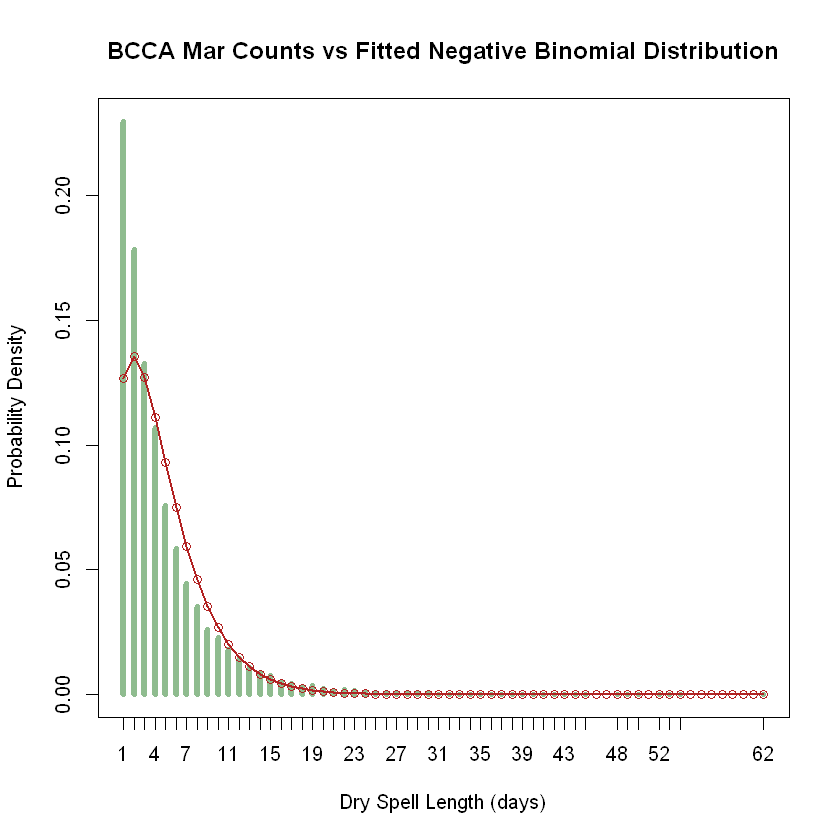

In [261]:
maxP <- max(dBCMar$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMar_size, mu=BCfdNB_dMar_mu )
ttab <- table( dBCMar$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

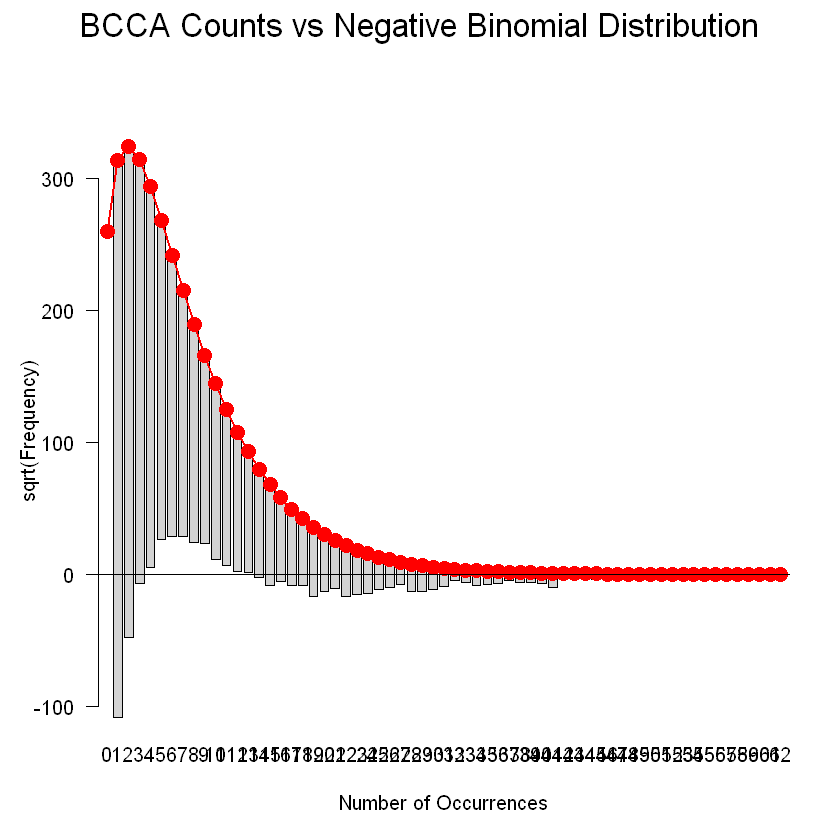

In [262]:
plot( BCgf_dMar, main="BCCA Counts vs Negative Binomial Distribution" )

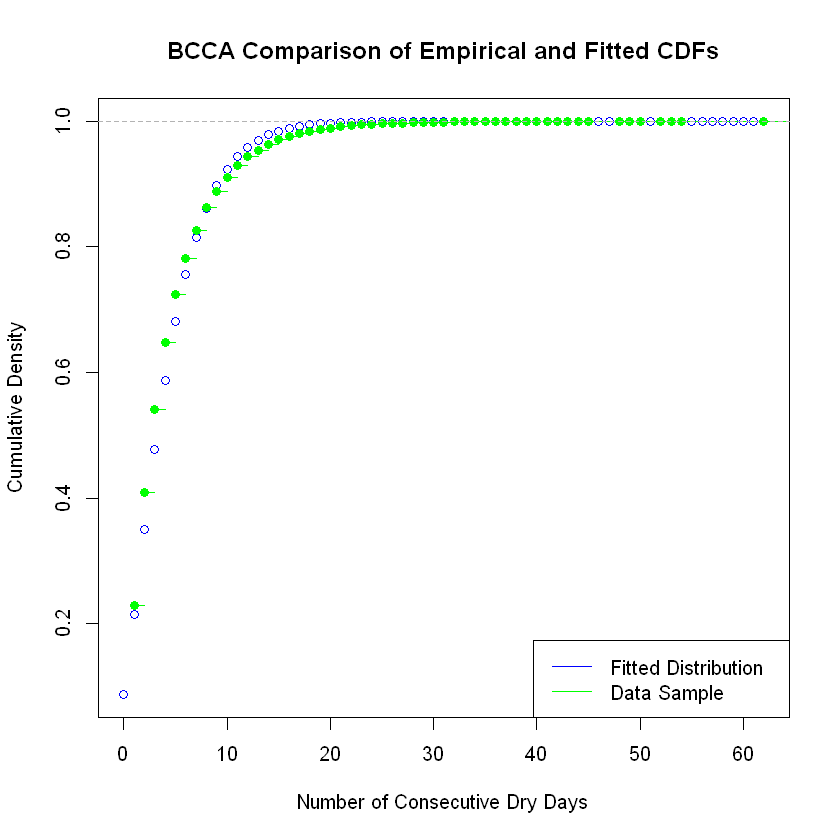

In [263]:
x <- seq(0,dBCMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMar_mu, size=BCfdNB_dMar_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMar$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

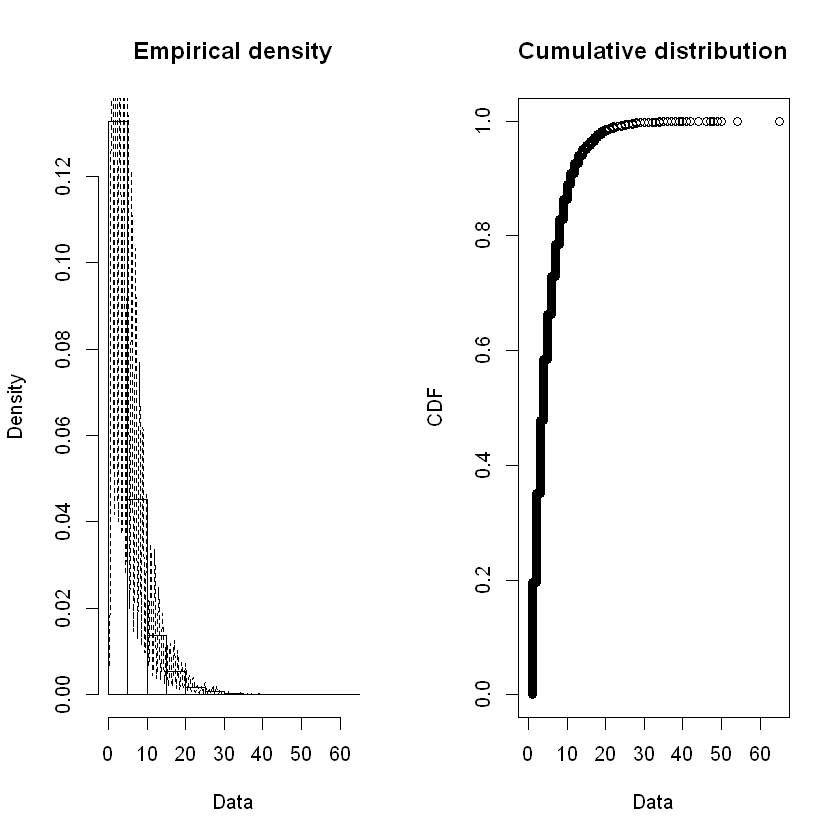

In [264]:
plotdist( dLOApr$Dry_Count, histo=TRUE, demp=TRUE )

In [265]:
LOfd_NB_dApr <- fitdist( dLOApr$Dry_Count, "nbinom" )
LOfd_GE_dApr <- fitdist( dLOApr$Dry_Count, "geom" )

In [266]:
LOfdNB_dApr_size <- LOfd_NB_dApr$estimate[["size"]]
LOfdNB_dApr_mu <- LOfd_NB_dApr$estimate[["mu"]]
cat("LOCA Apr size: ", LOfdNB_dApr_size, "\n", "LOCA Apr mu: ", LOfdNB_dApr_mu, "\n")

LOCA Apr size:  2.109202 
 LOCA Apr mu:  5.137729 


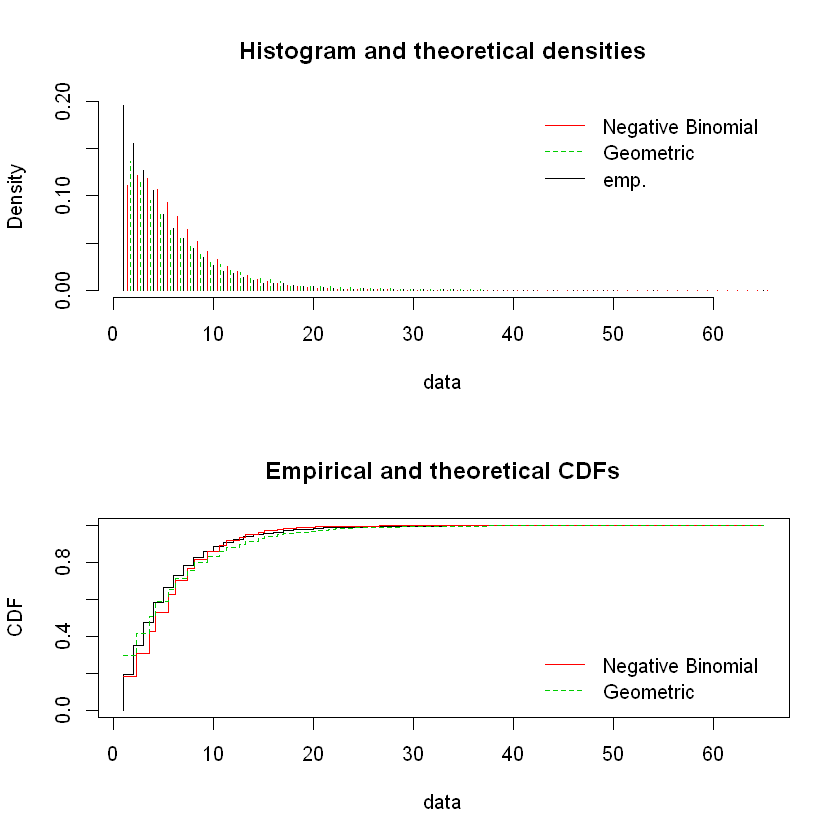

In [267]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )

In [268]:
LOstatRes <- gofstat( list(LOfd_NB_dApr, LOfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [269]:
print( LOstatRes )

Chi-squared statistic:  56304.72 101690.8 
Degree of freedom of the Chi-squared distribution:  23 24 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     235521            222522.8980     360589.628
<= 2     187583            146966.7149     137531.119
<= 3     152619            142715.8695     115121.439
<= 4     127642            129235.6719      96363.252
<= 5      96312            111947.3835      80661.572
<= 6      78553             94037.4010      67518.365
<= 7      66598             77232.0862      56516.746
<= 8      52741             62345.5103      47307.760
<= 9      41996             49647.4131      39599.310
<= 10     31669             39101.7833      33146.895
<= 11     23416             30516.6236      27745.854
<= 12     20859             23634.6171      23224.872
<= 13     16605             18185.4792      19440.551
<= 14     12979             13914.1065      16272.856
<= 15      9196             10593.8830    

In [270]:
LOfdNB_dApr_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [271]:
LOfdNB_dApr_p = LOfdNB_dApr_size / (LOfdNB_dApr_size + LOfdNB_dApr_mu)
cat("LOCA prob: ", LOfdNB_dApr_p)

LOCA prob:  0.2910476

In [272]:
# add to our tracking dataframe
LOMonDistDF[4, ] <- list( 4, dLOAprMean, dLOAprBNr, LOfdNB_dApr_p, LOfdNB_dApr_mu, LOfdNB_dApr_size,
                          LOfdNB_dApr_pvalue )

In [273]:
LOgf_dApr <- goodfit( dLOApr$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dApr_size, prob=LOfdNB_dApr_p) )

In [274]:
summary( LOgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          236223.3 65        0
Likelihood Ratio 286124.0 49        0


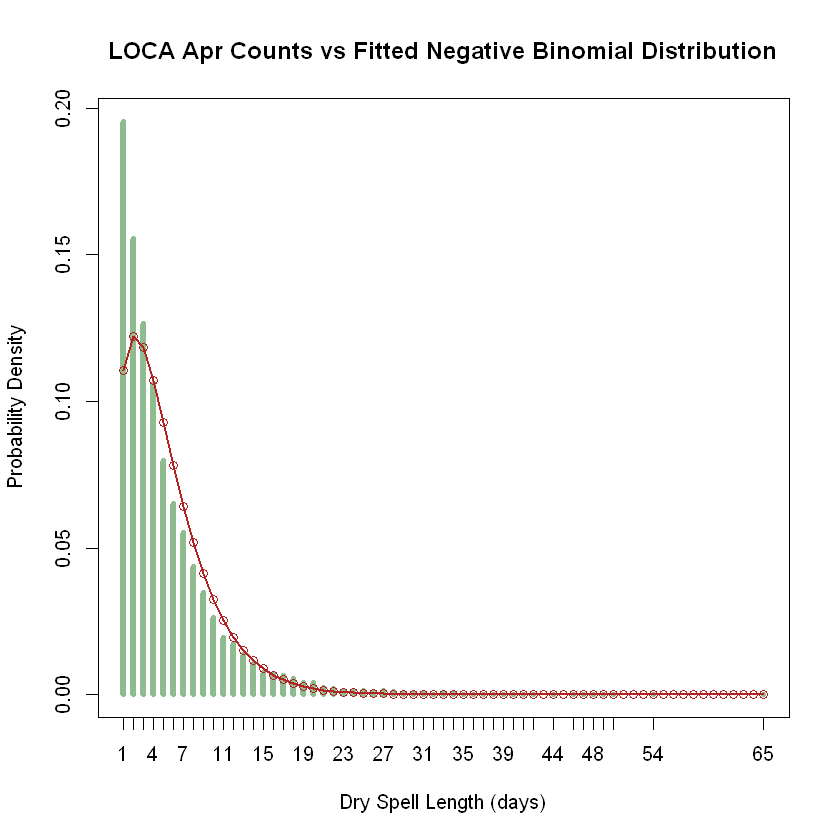

In [275]:
maxP <- max(dLOApr$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dApr_size, mu=LOfdNB_dApr_mu )
ttab <- table( dLOApr$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

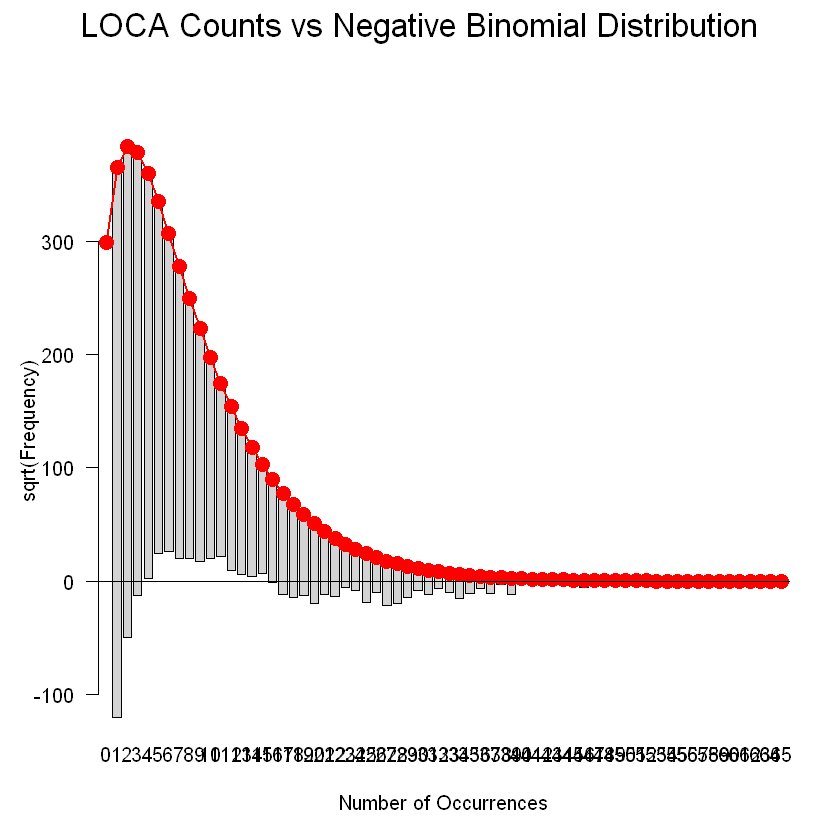

In [276]:
plot( LOgf_dApr, main="LOCA Counts vs Negative Binomial Distribution" )

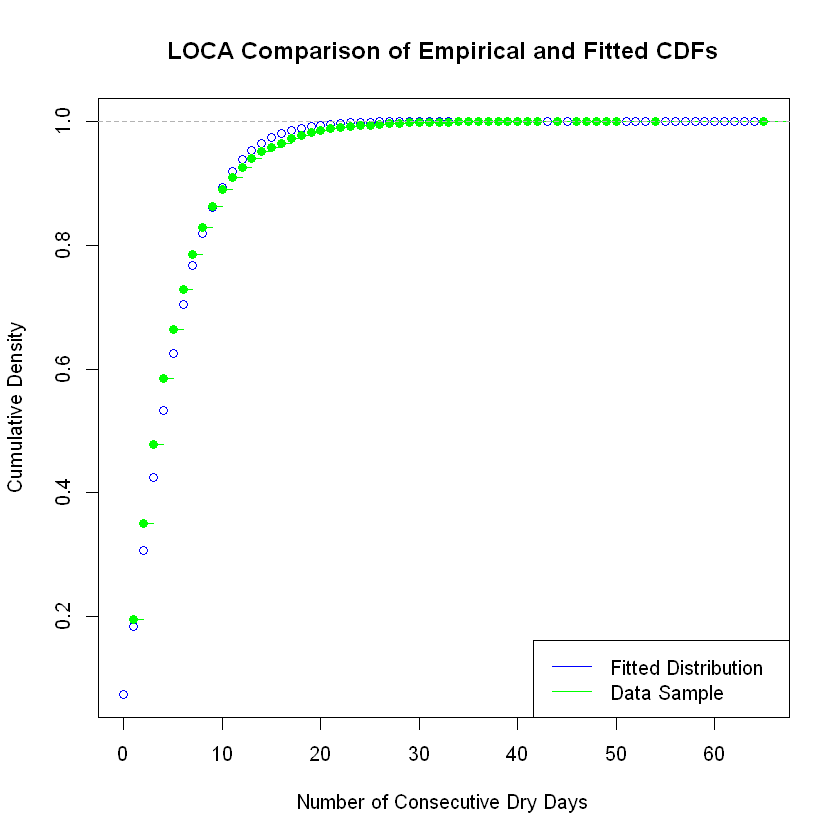

In [277]:
x <- seq(0,dLOAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dApr_mu, size=LOfdNB_dApr_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOApr$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

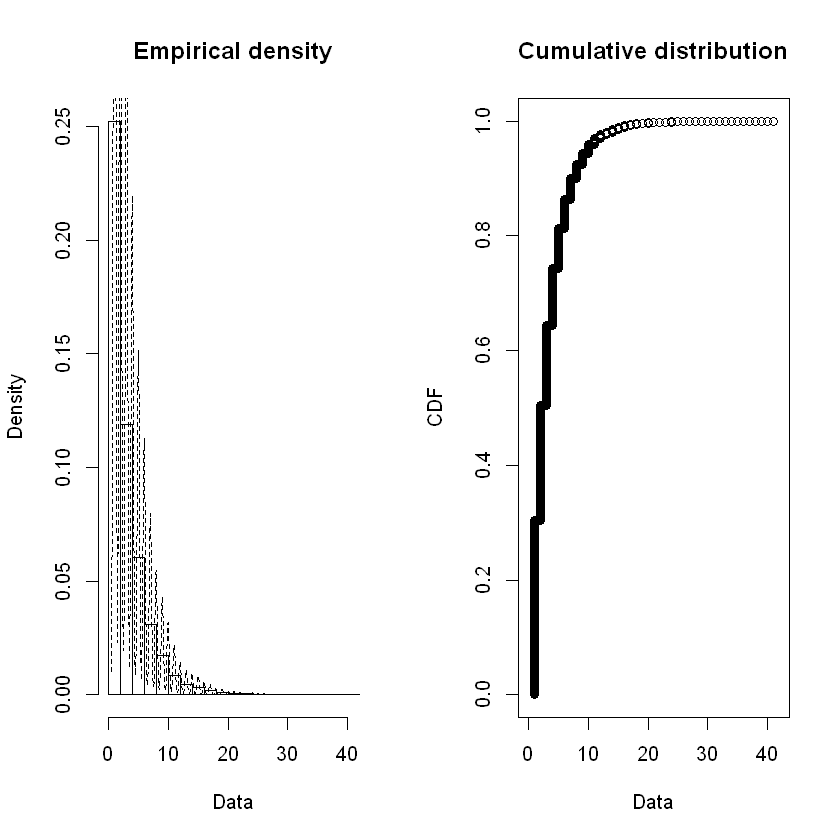

In [278]:
plotdist( dBCApr$Dry_Count, histo=TRUE, demp=TRUE )

In [279]:
BCfd_NB_dApr <- fitdist( dBCApr$Dry_Count, "nbinom" )
BCfd_GE_dApr <- fitdist( dBCApr$Dry_Count, "geom" )

In [280]:
summary( BCfd_NB_dApr )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.785191 0.007438523
mu   3.528137 0.003146044
Loglikelihood:  -1841379   AIC:  3682762   BIC:  3682785 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002766311
mu   0.0002766311 1.0000000000


In [281]:
BCfdNB_dApr_size <- BCfd_NB_dApr$estimate[["size"]]
BCfdNB_dApr_mu <- BCfd_NB_dApr$estimate[["mu"]]
cat("BCCA Apr size: ", BCfdNB_dApr_size, "\n", "BCCA Apr mu: ", BCfdNB_dApr_mu, "\n")

BCCA Apr size:  2.785191 
 BCCA Apr mu:  3.528137 


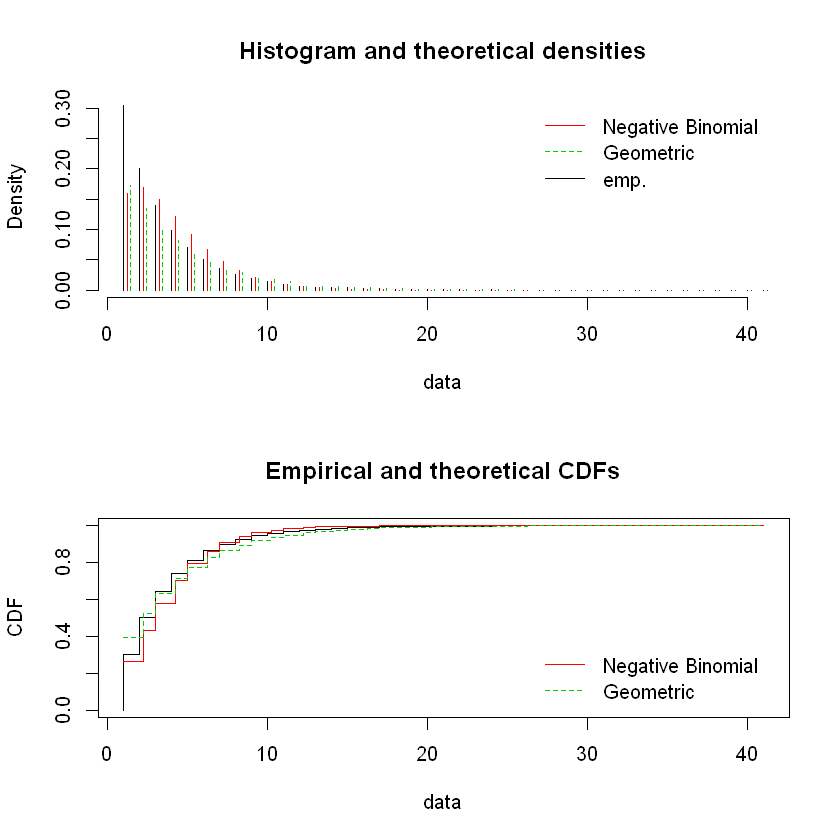

In [282]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )

In [283]:
BCstatRes <- gofstat( list(BCfd_NB_dApr, BCfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [284]:
print(BCstatRes)

Chi-squared statistic:  76099.93 65480.32 
Degree of freedom of the Chi-squared distribution:  16 17 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     245401            211388.9775     317360.789
<= 2     162340            136121.8348     108296.666
<= 3     112898            121336.8999      84383.357
<= 4      79130             98070.3399      65750.417
<= 5      56513             74373.2614      51231.872
<= 6      41384             53928.9443      39919.210
<= 7      29495             37823.5386      31104.530
<= 8      20457             25854.0477      24236.246
<= 9      15556             17314.1408      18884.569
<= 10     12125             11403.1448      14714.611
<= 11      8013              7406.7253      11465.434
<= 12      5447              4754.9379       8933.717
<= 13      3937              3022.1464       6961.037
<= 14      3543              1904.2518       5423.949
<= 15      3154              1190.8209    

In [285]:
BCfdNB_dApr_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [286]:
BCfdNB_dApr_p = BCfdNB_dApr_size / (BCfdNB_dApr_size + BCfdNB_dApr_mu)
cat("BCCA prob: ", BCfdNB_dApr_p)

BCCA prob:  0.4411605

In [287]:
# add to our tracking dataframe
BCMonDistDF[4, ] <- list( 4, dBCAprMean, dBCAprBNr, BCfdNB_dApr_p, BCfdNB_dApr_mu, BCfdNB_dApr_size,
                          BCfdNB_dApr_pvalue )

In [288]:
BCgf_dApr <- goodfit( dBCApr$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dApr_size, prob=BCfdNB_dApr_p) )

In [289]:
summary( BCgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          427811.2 41        0
Likelihood Ratio 289054.5 40        0


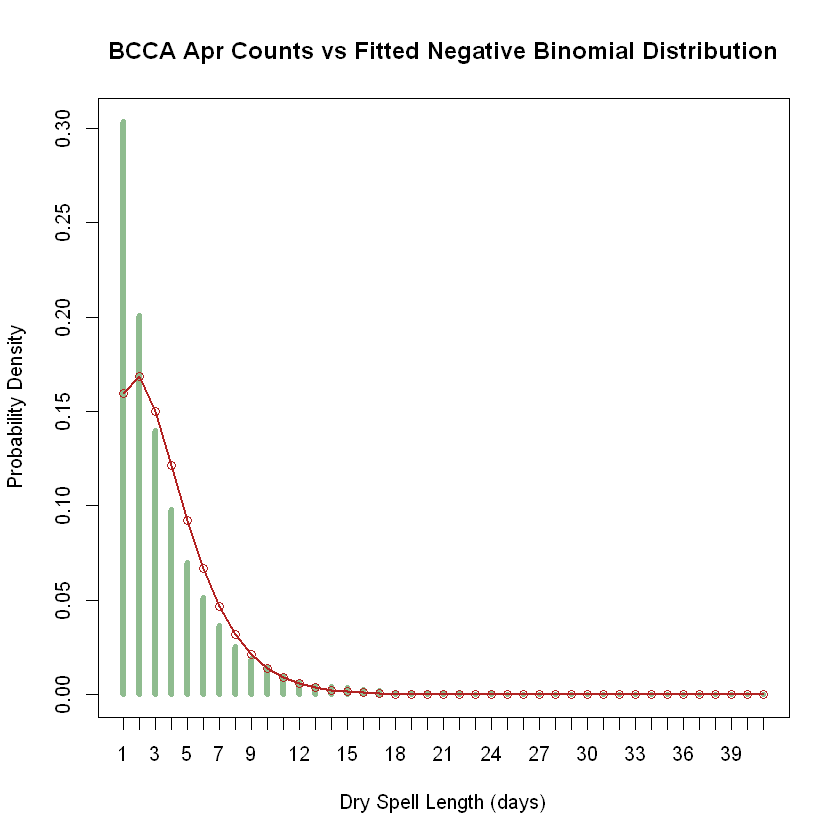

In [290]:
maxP <- max(dBCApr$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dApr_size, mu=BCfdNB_dApr_mu )
ttab <- table( dBCApr$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

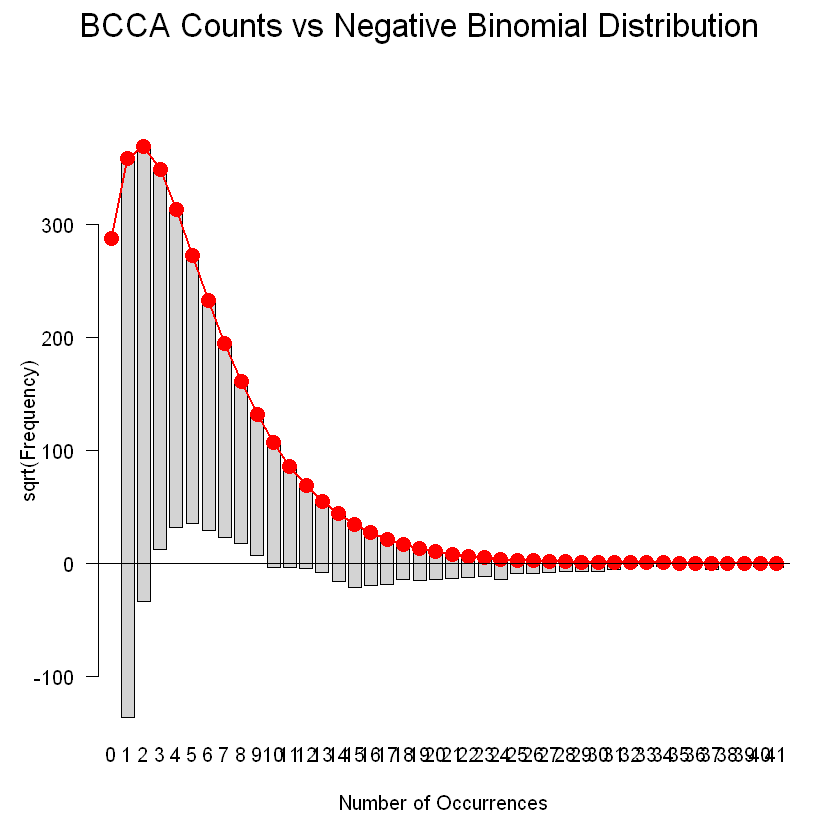

In [291]:
plot( BCgf_dApr, main="BCCA Counts vs Negative Binomial Distribution" )

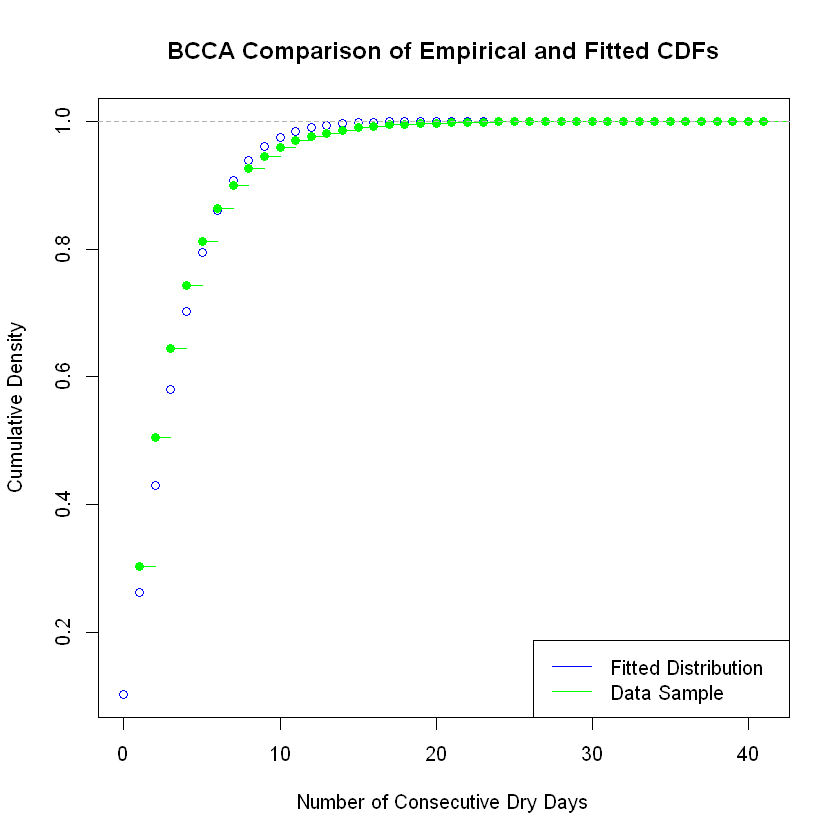

In [292]:
x <- seq(0,dBCAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dApr_mu, size=BCfdNB_dApr_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCApr$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

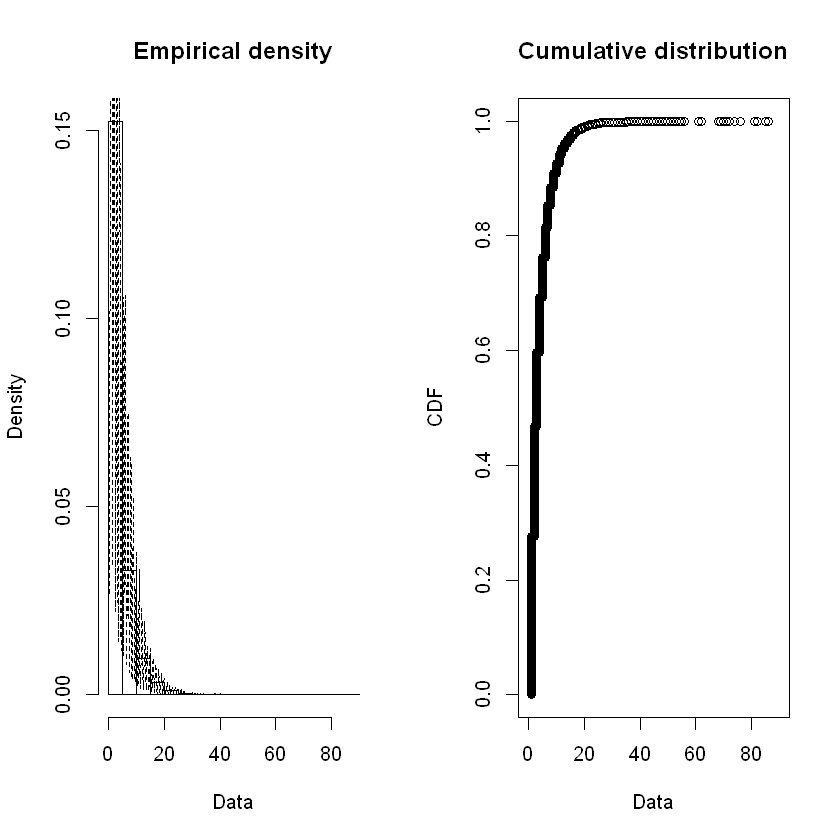

In [293]:
plotdist( dLOMay$Dry_Count, histo=TRUE, demp=TRUE )

In [294]:
LOfd_NB_dMay <- fitdist( dLOMay$Dry_Count, "nbinom" )
LOfd_GE_dMay <- fitdist( dLOMay$Dry_Count, "geom" )

In [295]:
LOfdNB_dMay_size <- LOfd_NB_dMay$estimate[["size"]]
LOfdNB_dMay_mu <- LOfd_NB_dMay$estimate[["mu"]]
cat("LOCA May size: ", LOfdNB_dMay_size, "\n", "LOCA May mu: ", LOfdNB_dMay_mu, "\n")

LOCA May size:  2.044214 
 LOCA May mu:  4.141817 


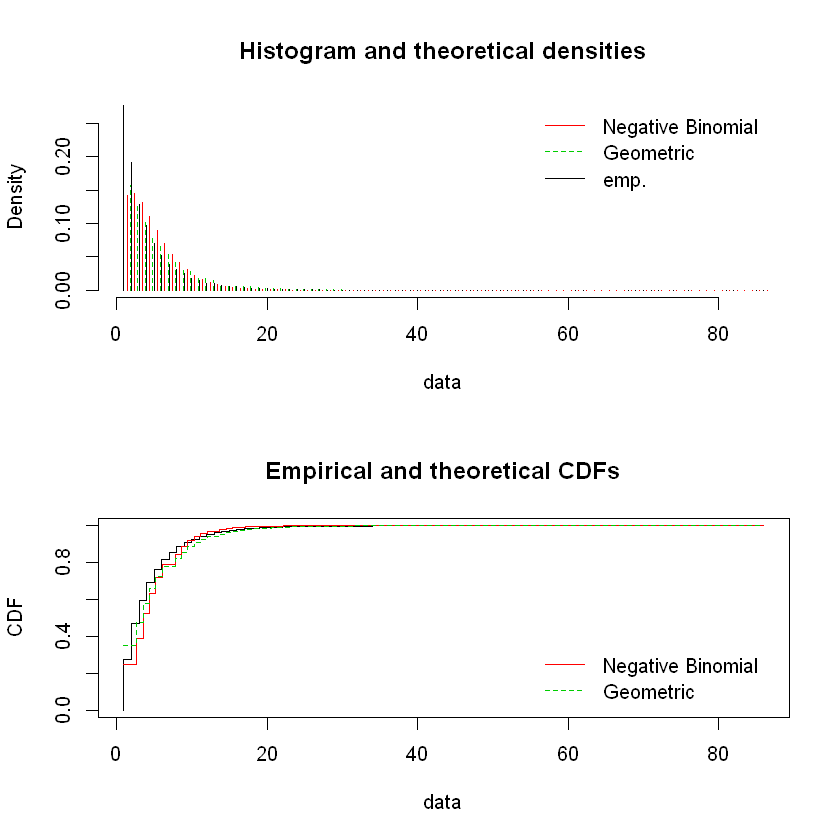

In [296]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )

In [297]:
LOstatRes <- gofstat( list(LOfd_NB_dMay, LOfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [298]:
print( LOstatRes )

Chi-squared statistic:  137608.4 97471.52 
Degree of freedom of the Chi-squared distribution:  20 21 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     403045            359518.0526     512564.279
<= 2     279564            211710.1065     184199.327
<= 3     187914            191087.9370     148373.900
<= 4     141386            161341.3146     119516.257
<= 5     101144            130585.2808      96271.216
<= 6      76960            102648.9062      77547.166
<= 7      55920             78980.2873      62464.807
<= 8      45901             59783.0902      50315.858
<= 9      36250             44671.5083      40529.790
<= 10     25164             33032.7125      32647.041
<= 11     21698             24216.3577      26297.430
<= 12     15544             17624.8042      21182.771
<= 13     13822             12748.4444      17062.876
<= 14      9526              9172.2835      13744.271
<= 15      8999              6568.7611    

In [299]:
LOfdNB_dMay_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [300]:
LOfdNB_dMay_p = LOfdNB_dMay_size / (LOfdNB_dMay_size + LOfdNB_dMay_mu)
cat("LOCA prob: ", LOfdNB_dMay_p)

LOCA prob:  0.3304565

In [301]:
# add to our tracking dataframe
LOMonDistDF[5, ] <- list( 5, dLOMayMean, dLOMayBNr, LOfdNB_dMay_p, LOfdNB_dMay_mu, LOfdNB_dMay_size,
                          LOfdNB_dMay_pvalue )

In [302]:
LOgf_dMay <- goodfit( dLOMay$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMay_size, prob=LOfdNB_dMay_p) )

In [303]:
summary( LOgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1.800005e+10 86        0
Likelihood Ratio 5.475783e+05 68        0


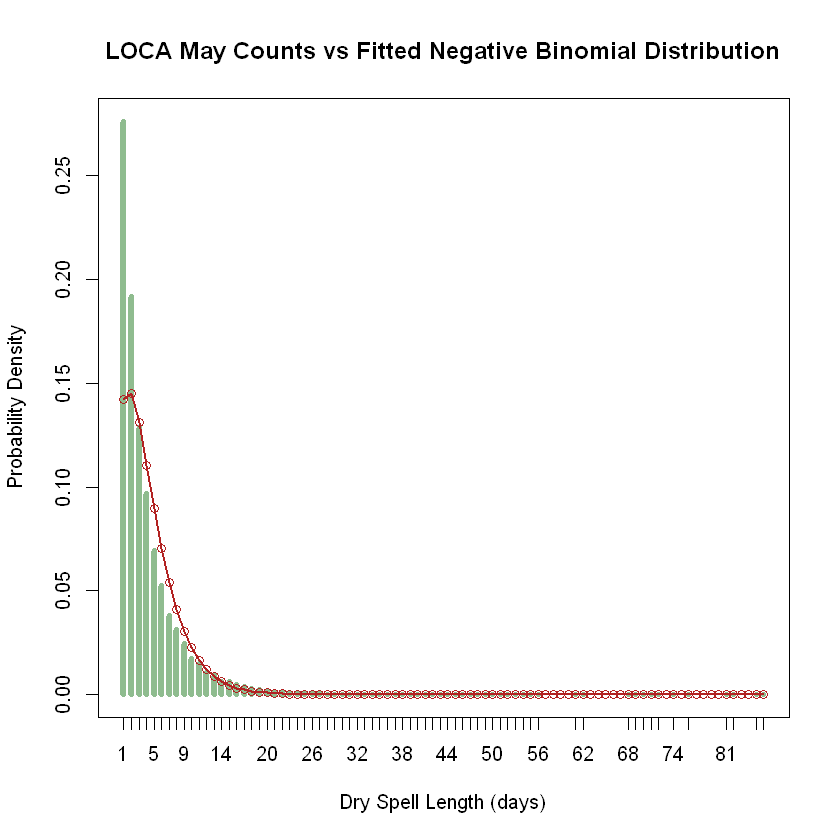

In [304]:
maxP <- max(dLOMay$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMay_size, mu=LOfdNB_dMay_mu )
ttab <- table( dLOMay$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

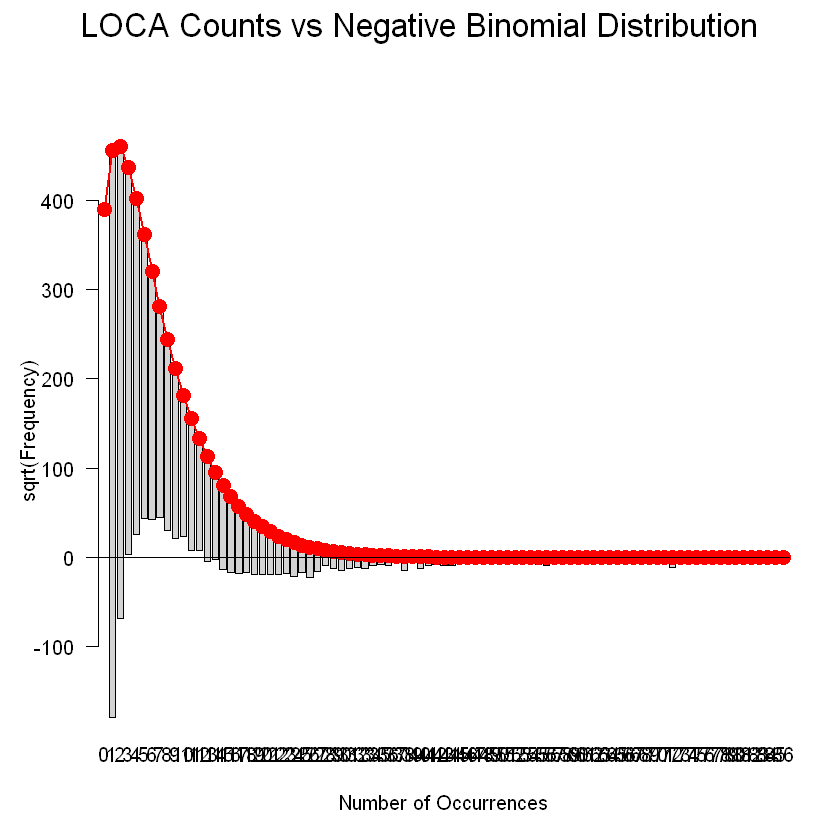

In [305]:
plot( LOgf_dMay, main="LOCA Counts vs Negative Binomial Distribution" )

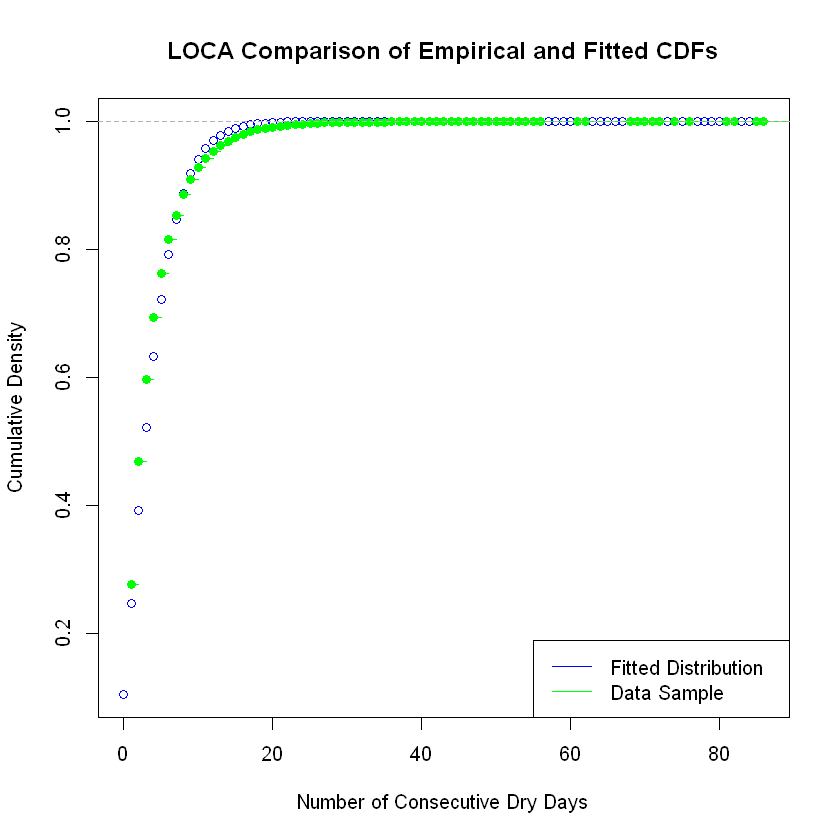

In [306]:
x <- seq(0,dLOMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMay_mu, size=LOfdNB_dMay_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMay$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

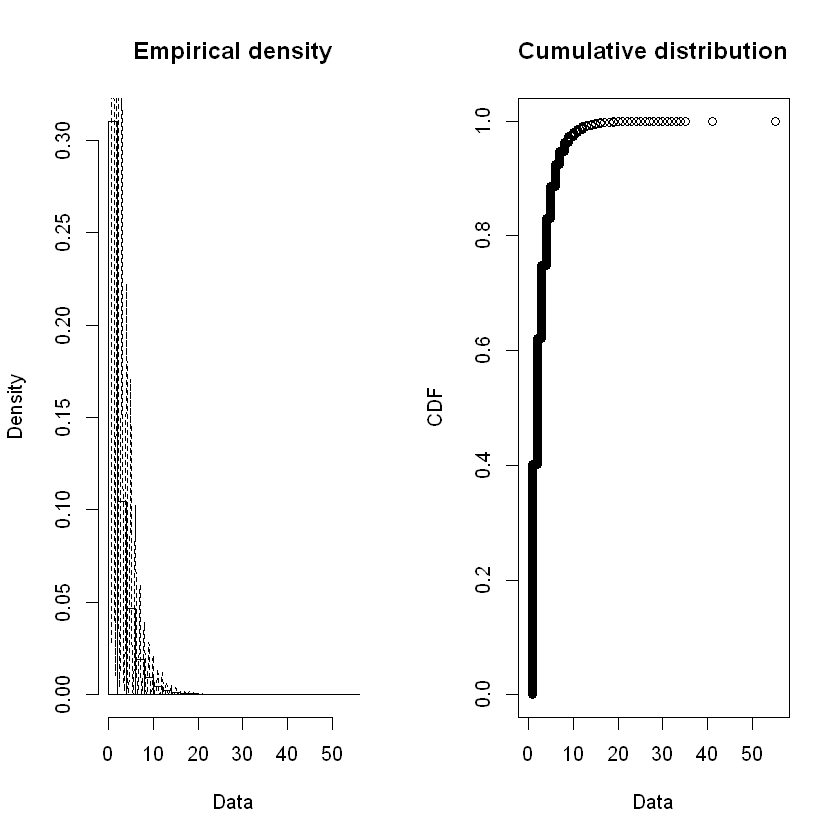

In [307]:
plotdist( dBCMay$Dry_Count, histo=TRUE, demp=TRUE )

In [308]:
BCfd_NB_dMay <- fitdist( dBCMay$Dry_Count, "nbinom" )
BCfd_GE_dMay <- fitdist( dBCMay$Dry_Count, "geom" )

In [309]:
summary( BCfd_NB_dMay )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 3.676495 0.011885410
mu   2.772337 0.002373943
Loglikelihood:  -1762504   AIC:  3525012   BIC:  3525036 
Correlation matrix:
              size            mu
size  1.000000e+00 -5.773009e-05
mu   -5.773009e-05  1.000000e+00


In [310]:
BCfdNB_dMay_size <- BCfd_NB_dMay$estimate[["size"]]
BCfdNB_dMay_mu <- BCfd_NB_dMay$estimate[["mu"]]
cat("BCCA May size: ", BCfdNB_dMay_size, "\n", "BCCA May mu: ", BCfdNB_dMay_mu, "\n")

BCCA May size:  3.676495 
 BCCA May mu:  2.772337 


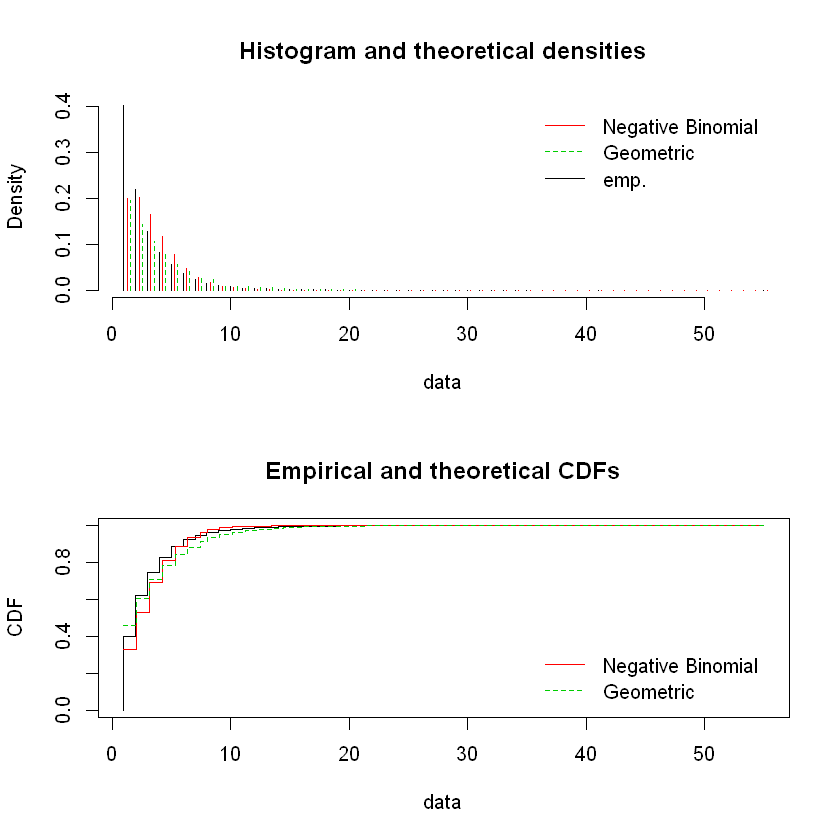

In [311]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )

In [312]:
BCstatRes <- gofstat( list(BCfd_NB_dMay, BCfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [313]:
print(BCstatRes)

Chi-squared statistic:  113805.9 59056.17 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     346237            282126.0731     396872.732
<= 2     189555            173696.4929     123548.741
<= 3     110281            141291.1722      90796.636
<= 4      70613            101383.7929      66726.936
<= 5      48727             66915.4602      49037.985
<= 6      31901             41599.1545      36038.279
<= 7      20052             24721.1975      26484.726
<= 8      13060             14183.1658      19463.767
<= 9       9573              7910.5764      14304.027
<= 10      6799              4310.9430      10512.107
<= 11      4165              2304.1957       7725.404
<= 12      3604              1211.5056       5677.441
<= 13      2500               628.0526       4172.382
<= 15      2926               484.5485       5319.751
> 15       2935               161.6692    

In [314]:
BCfdNB_dMay_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [315]:
BCfdNB_dMay_p = BCfdNB_dMay_size / (BCfdNB_dMay_size + BCfdNB_dMay_mu)
cat("BCCA prob: ", BCfdNB_dMay_p)

BCCA prob:  0.5701025

In [316]:
# add to our tracking dataframe
BCMonDistDF[5, ] <- list( 5, dBCMayMean, dBCMayBNr, BCfdNB_dMay_p, BCfdNB_dMay_mu, BCfdNB_dMay_size,
                          BCfdNB_dMay_pvalue )

In [317]:
BCgf_dMay <- goodfit( dBCMay$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMay_size, prob=BCfdNB_dMay_p) )

In [318]:
summary( BCgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 55      NaN
Likelihood Ratio 411132.1 36        0


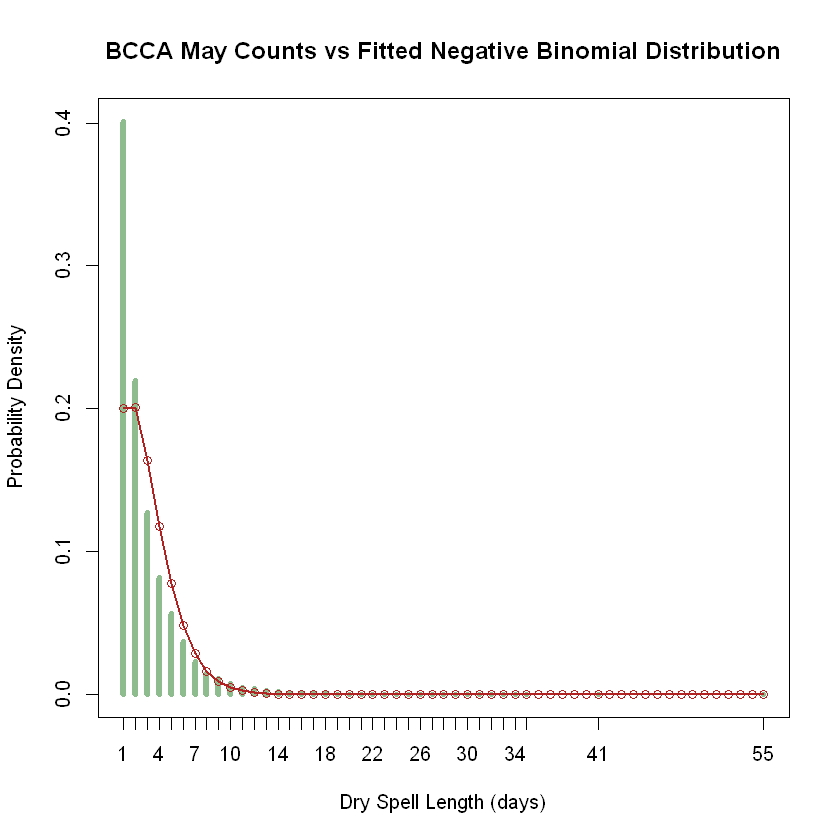

In [319]:
maxP <- max(dBCMay$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMay_size, mu=BCfdNB_dMay_mu )
ttab <- table( dBCMay$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

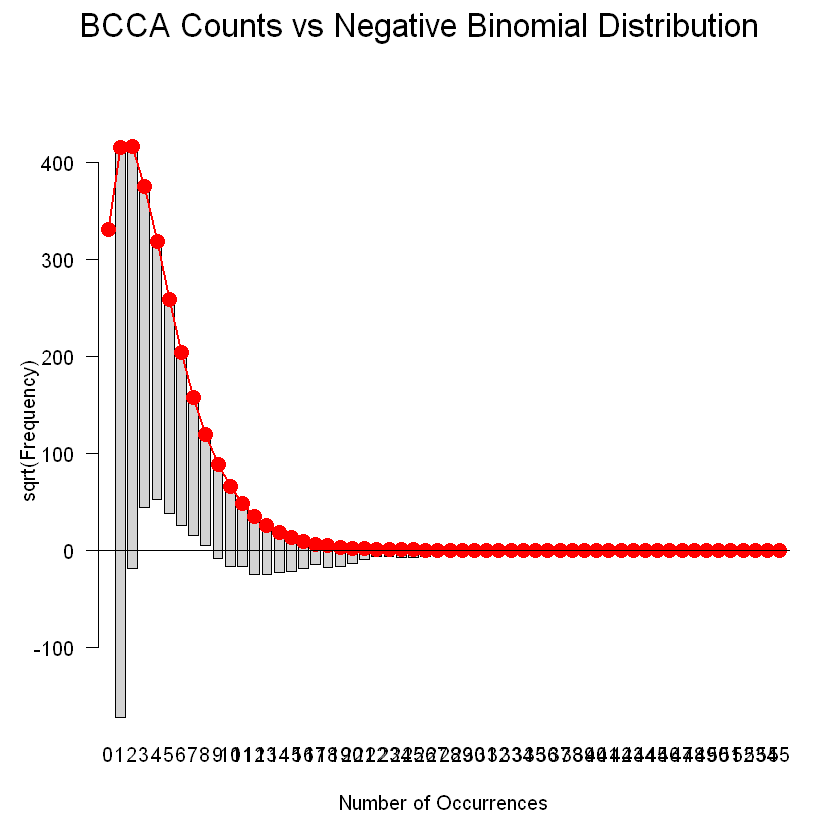

In [320]:
plot( BCgf_dMay, main="BCCA Counts vs Negative Binomial Distribution" )

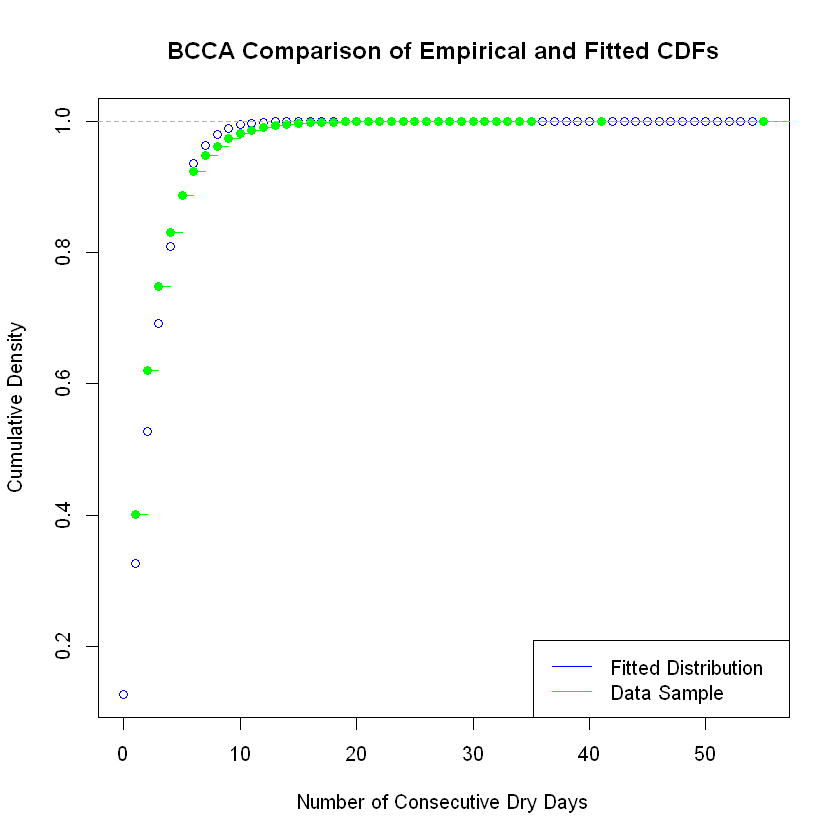

In [321]:
x <- seq(0,dBCMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMay_mu, size=BCfdNB_dMay_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMay$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

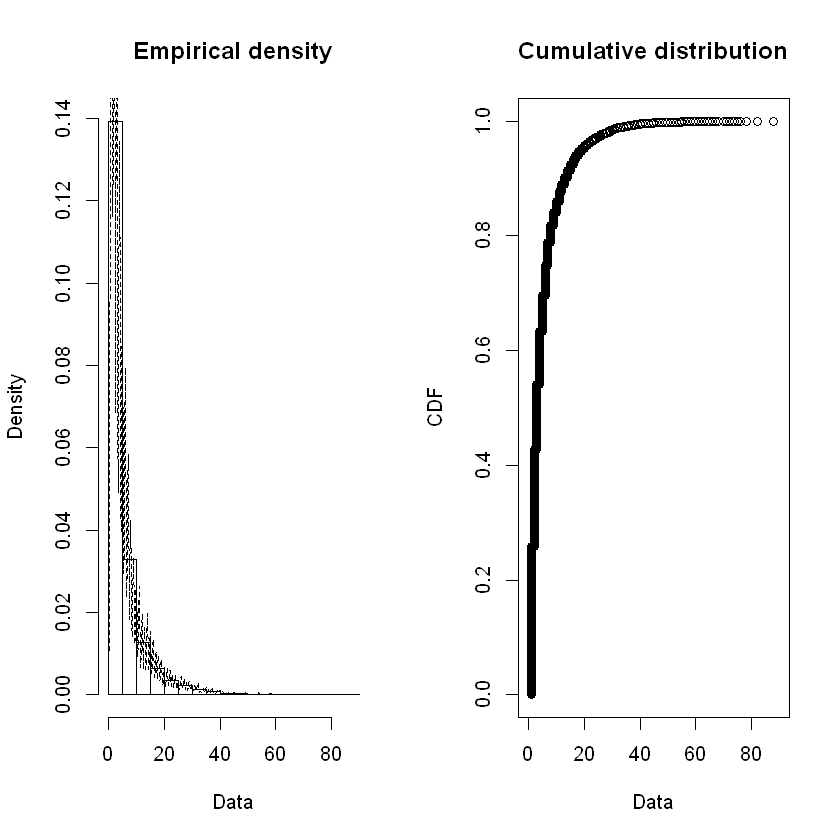

In [322]:
plotdist( dLOJun$Dry_Count, histo=TRUE, demp=TRUE )

In [323]:
LOfd_NB_dJun <- fitdist( dLOJun$Dry_Count, "nbinom" )
LOfd_GE_dJun <- fitdist( dLOJun$Dry_Count, "geom" )

In [324]:
LOfdNB_dJun_size <- LOfd_NB_dJun$estimate[["size"]]
LOfdNB_dJun_mu <- LOfd_NB_dJun$estimate[["mu"]]
cat("LOCA Jun size: ", LOfdNB_dJun_size, "\n", "LOCA Jun mu: ", LOfdNB_dJun_mu, "\n")

LOCA Jun size:  1.304567 
 LOCA Jun mu:  5.525485 


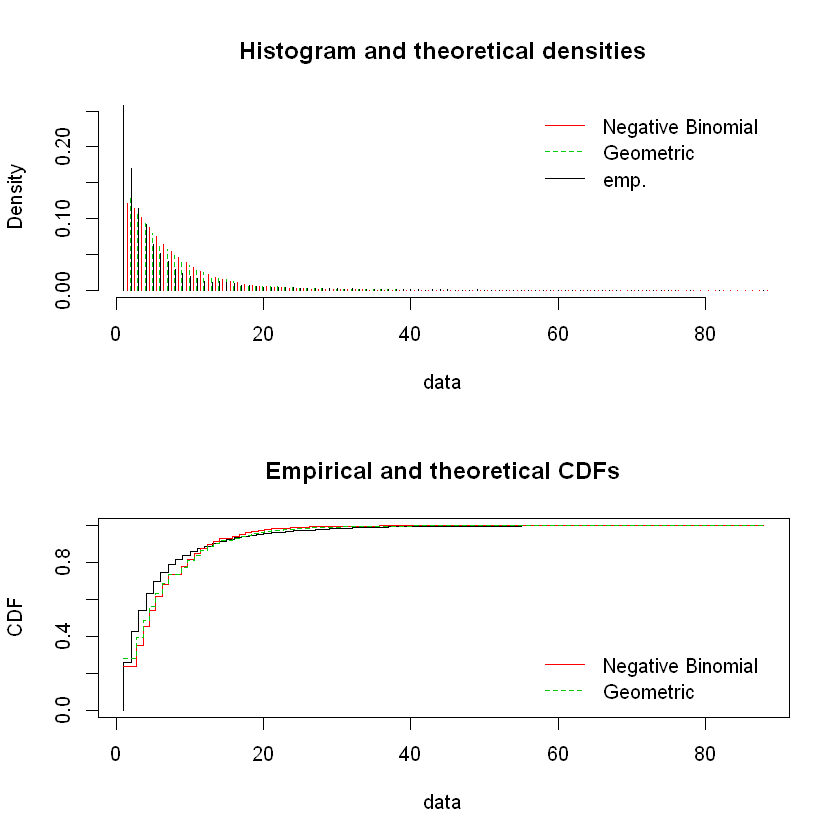

In [325]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )

In [326]:
LOstatRes <- gofstat( list(LOfd_NB_dJun, LOfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [327]:
print( LOstatRes )

Chi-squared statistic:  241480.1 113212.6 
Degree of freedom of the Chi-squared distribution:  31 32 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     328429           302359.11852    360850.5164
<= 2     216275           144726.25501    140101.0308
<= 3     145712           128969.49201    118632.6205
<= 4     116549           112280.11326    100453.9265
<= 5      81447            96367.18168     85060.8484
<= 6      66223            81918.04121     72026.5317
<= 7      51083            69154.80921     60989.5313
<= 8      37103            58075.87857     51643.7879
<= 9      29633            48573.10250     43730.1415
<= 10     25171            40492.25758     37029.1442
<= 11     21379            33665.07908     31354.9757
<= 12     16007            27926.15416     26550.2895
<= 13     14524            23121.44262     22481.8505
<= 14     16332            19112.08257     19036.8395
<= 15     13188            15775.53901    

In [328]:
LOfdNB_dJun_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [329]:
LOfdNB_dJun_p = LOfdNB_dJun_size / (LOfdNB_dJun_size + LOfdNB_dJun_mu)
cat("LOCA prob: ", LOfdNB_dJun_p)

LOCA prob:  0.1910039

In [330]:
# add to our tracking dataframe
LOMonDistDF[6, ] <- list( 6, dLOJunMean, dLOJunBNr, LOfdNB_dJun_p, LOfdNB_dJun_mu, LOfdNB_dJun_size,
                          LOfdNB_dJun_pvalue )

In [331]:
LOgf_dJun <- goodfit( dLOJun$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJun_size, prob=LOfdNB_dJun_p) )

In [332]:
summary( LOgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          704873.4 88        0
Likelihood Ratio 577801.5 77        0


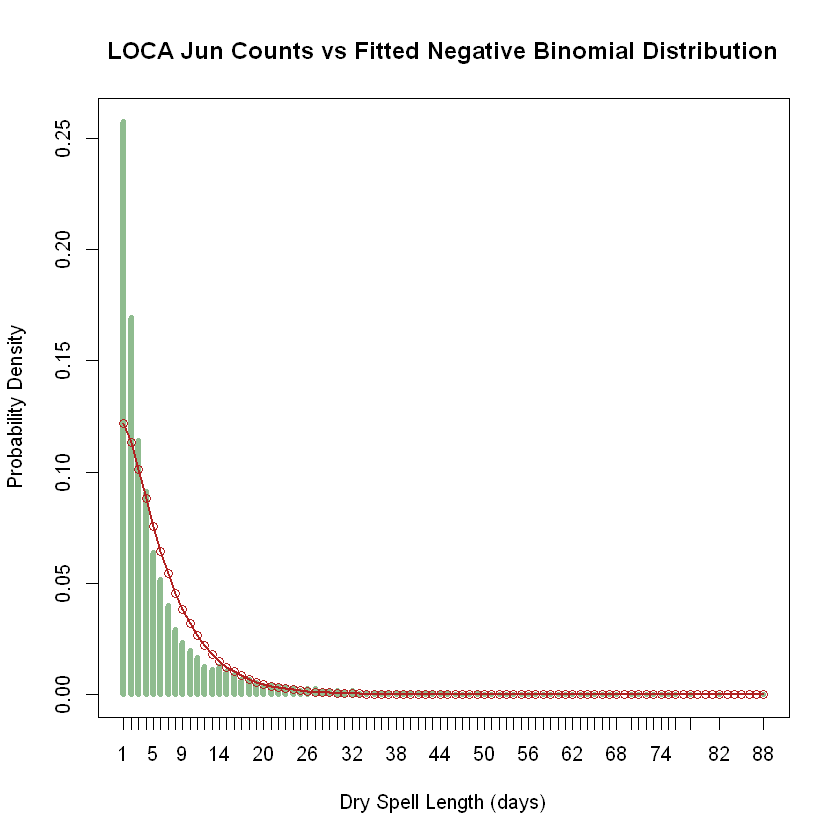

In [333]:
maxP <- max(dLOJun$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJun_size, mu=LOfdNB_dJun_mu )
ttab <- table( dLOJun$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

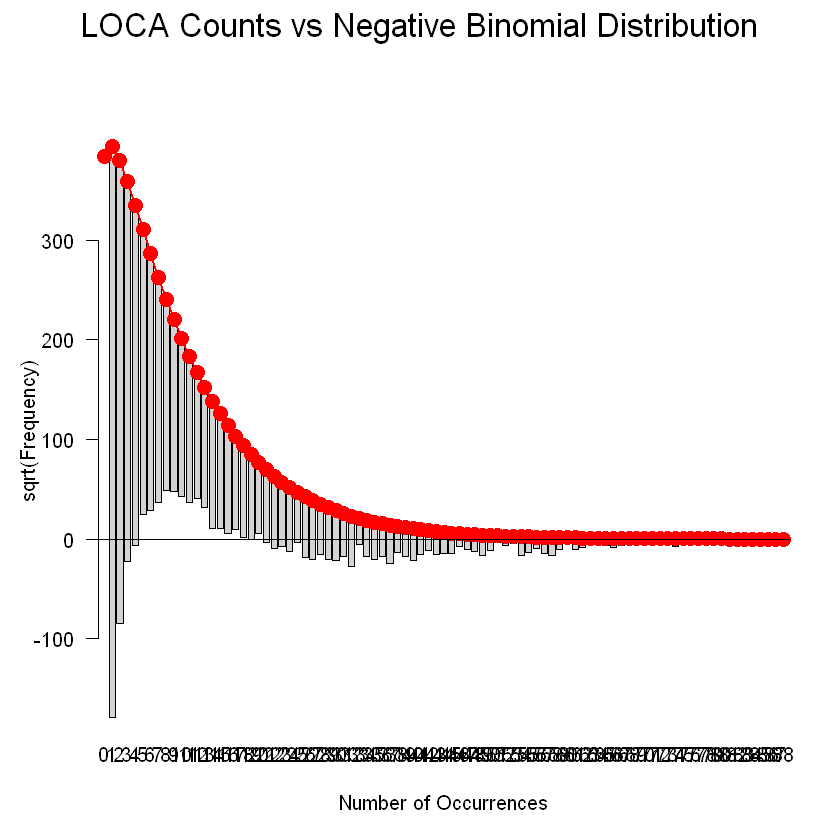

In [334]:
plot( LOgf_dJun, main="LOCA Counts vs Negative Binomial Distribution" )

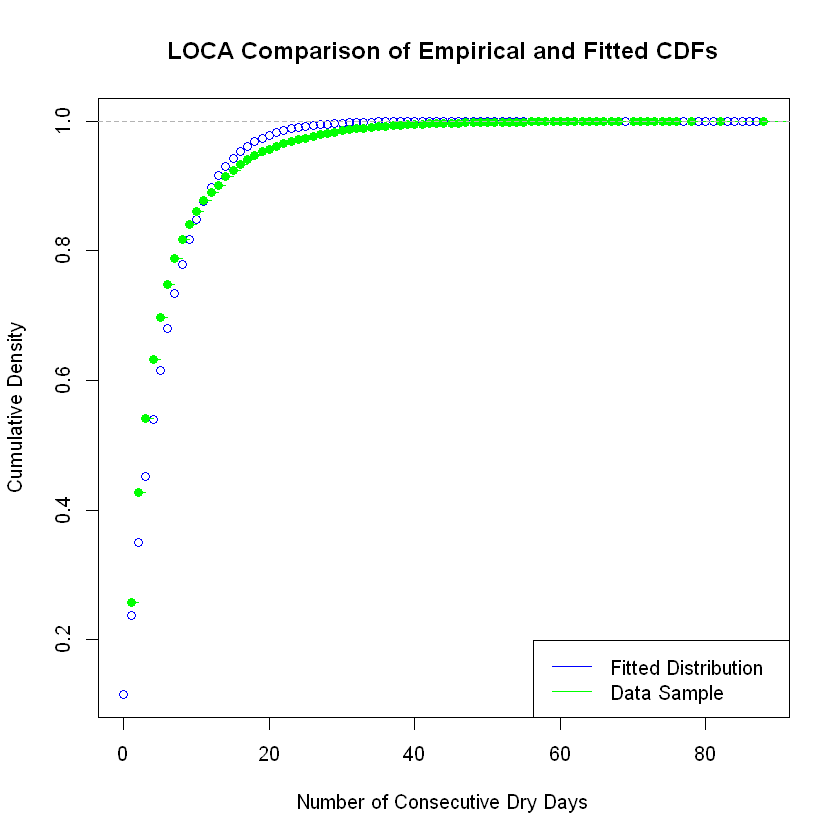

In [335]:
x <- seq(0,dLOJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJun_mu, size=LOfdNB_dJun_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJun$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

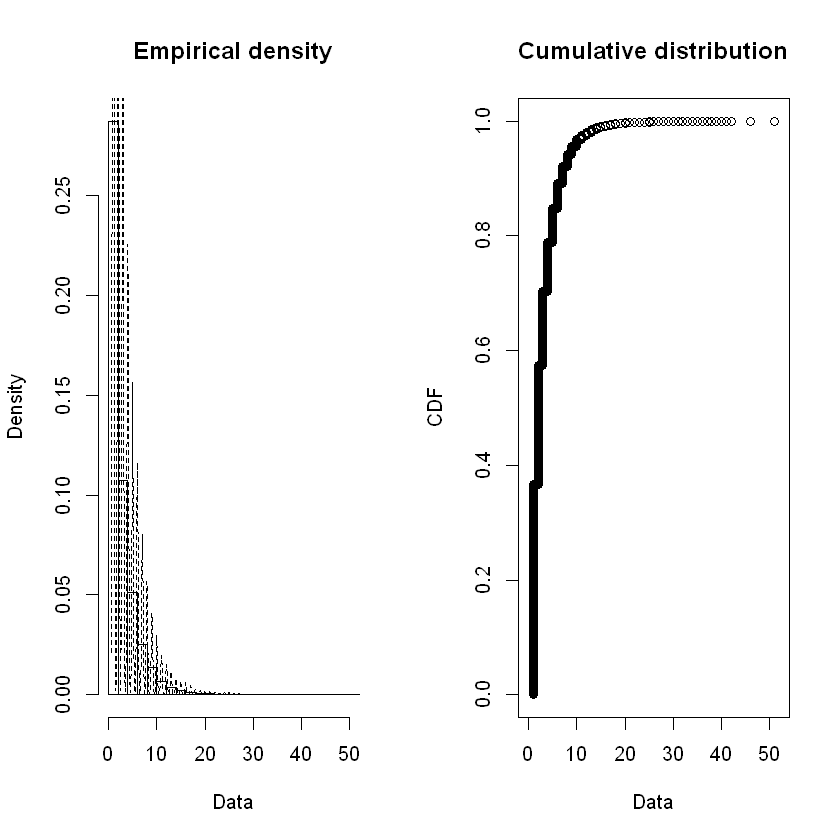

In [336]:
plotdist( dBCJun$Dry_Count, histo=TRUE, demp=TRUE )

In [337]:
BCfd_NB_dJun <- fitdist( dBCJun$Dry_Count, "nbinom" )
BCfd_GE_dJun <- fitdist( dBCJun$Dry_Count, "geom" )

In [338]:
summary( BCfd_NB_dJun )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.736221 0.007338939
mu   3.153567 0.002847415
Loglikelihood:  -1832262   AIC:  3664528   BIC:  3664551 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001708131
mu   -0.0001708131  1.0000000000


In [339]:
BCfdNB_dJun_size <- BCfd_NB_dJun$estimate[["size"]]
BCfdNB_dJun_mu <- BCfd_NB_dJun$estimate[["mu"]]
cat("BCCA Jun size: ", BCfdNB_dJun_size, "\n", "BCCA Jun mu: ", BCfdNB_dJun_mu, "\n")

BCCA Jun size:  2.736221 
 BCCA Jun mu:  3.153567 


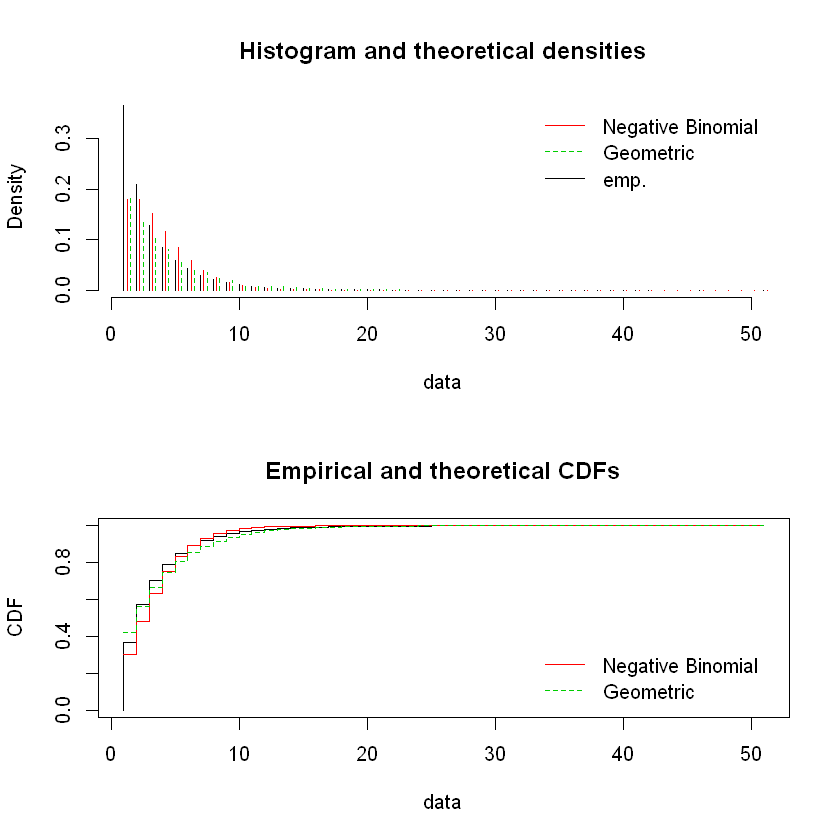

In [340]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )

In [341]:
BCstatRes <- gofstat( list(BCfd_NB_dJun, BCfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [342]:
print(BCstatRes)

Chi-squared statistic:  144941.5 49764.76 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     306318           253353.09471     354695.517
<= 2     174816           150611.57384     116218.141
<= 3     108197           127312.62370      88235.538
<= 4      71518            97755.17922      66990.490
<= 5      49750            70516.13947      50860.751
<= 6      35771            48682.01863      38614.675
<= 7      24372            32530.93798      29317.167
<= 8      17479            21198.22317      22258.280
<= 9      12988            13539.75584      16899.008
<= 10      9460             8508.27568      12830.124
<= 11      6005             5274.62874       9740.931
<= 12      4750             3232.81136       7395.543
<= 13      3658             1962.12008       5614.870
<= 14      2566             1180.86551       4262.941
<= 15      2088              705.45453    

In [343]:
BCfdNB_dJun_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [344]:
BCfdNB_dJun_p = BCfdNB_dJun_size / (BCfdNB_dJun_size + BCfdNB_dJun_mu)
cat("BCCA prob: ", BCfdNB_dJun_p)

BCCA prob:  0.4645703

In [345]:
# add to our tracking dataframe
BCMonDistDF[6, ] <- list( 6, dBCJunMean, dBCJunBNr, BCfdNB_dJun_p, BCfdNB_dJun_mu, BCfdNB_dJun_size,
                          BCfdNB_dJun_pvalue )

In [346]:
BCgf_dJun <- goodfit( dBCJun$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJun_size, prob=BCfdNB_dJun_p) )

In [347]:
summary( BCgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                     X^2 df P(> X^2)
Pearson          2229690 51        0
Likelihood Ratio  387124 43        0


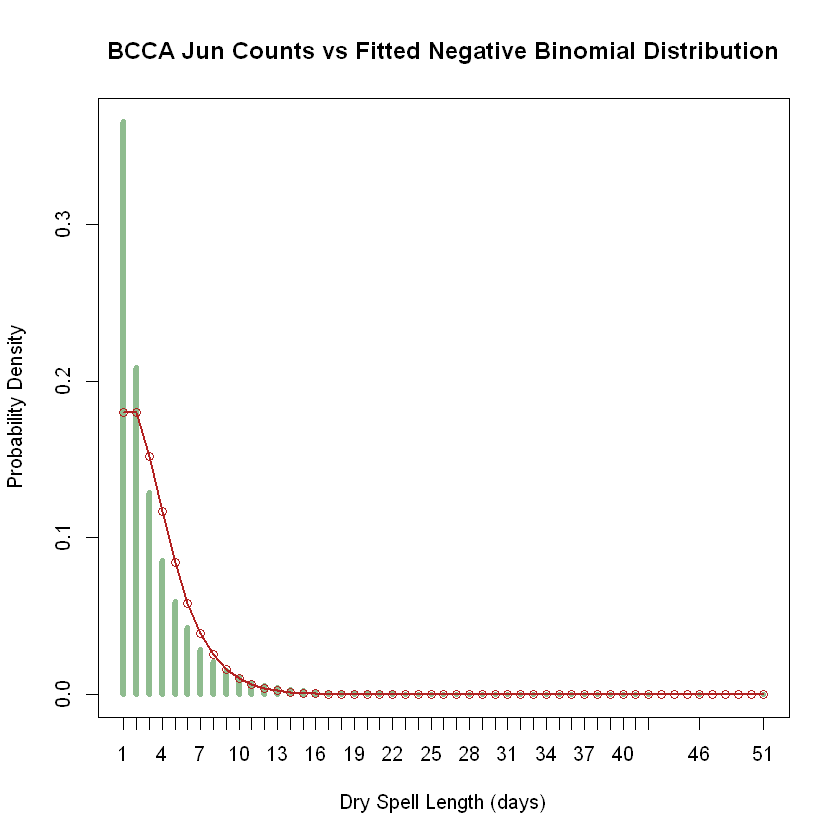

In [348]:
maxP <- max(dBCJun$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJun_size, mu=BCfdNB_dJun_mu )
ttab <- table( dBCJun$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

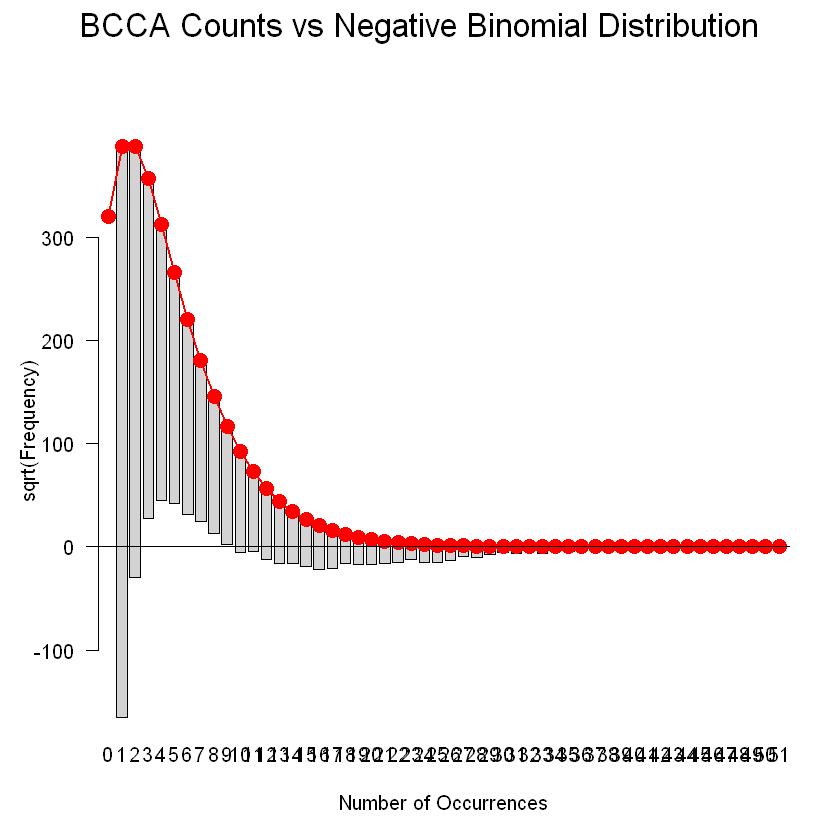

In [349]:
plot( BCgf_dJun, main="BCCA Counts vs Negative Binomial Distribution" )

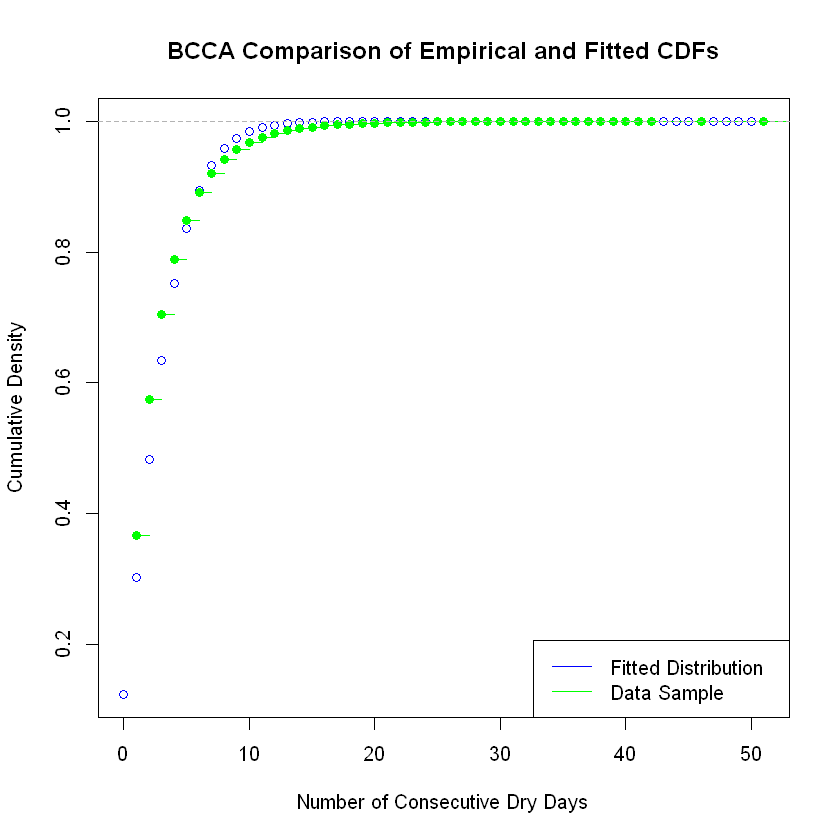

In [350]:
x <- seq(0,dBCJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJun_mu, size=BCfdNB_dJun_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJun$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

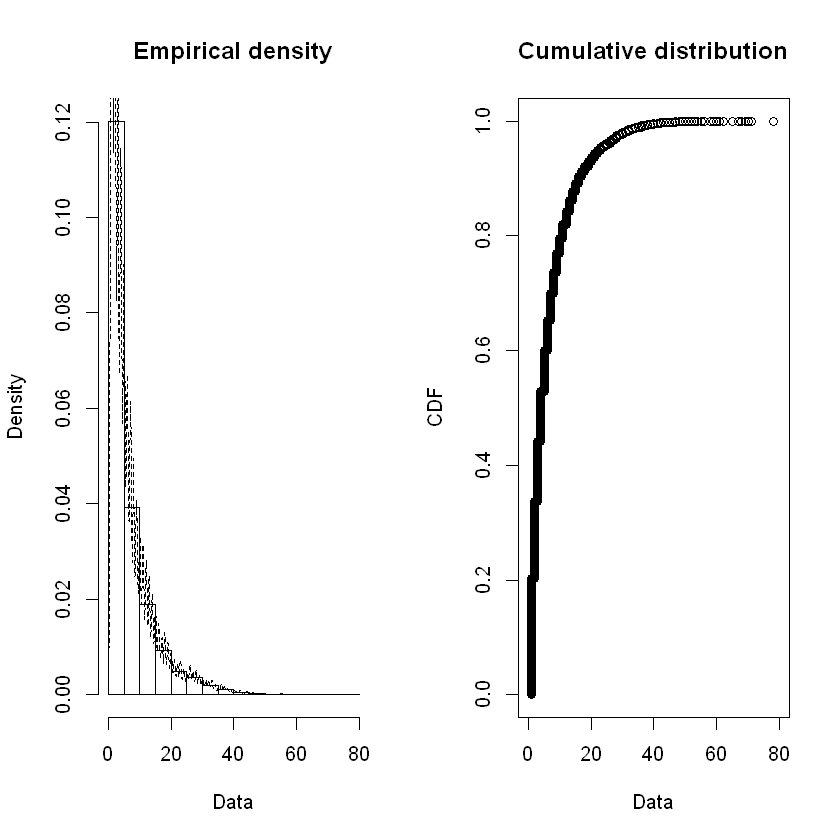

In [351]:
plotdist( dLOJul$Dry_Count, histo=TRUE, demp=TRUE )

In [352]:
LOfd_NB_dJul <- fitdist( dLOJul$Dry_Count, "nbinom" )
LOfd_GE_dJul <- fitdist( dLOJul$Dry_Count, "geom" )

In [353]:
LOfdNB_dJul_size <- LOfd_NB_dJul$estimate[["size"]]
LOfdNB_dJul_mu <- LOfd_NB_dJul$estimate[["mu"]]
cat("LOCA Jul size: ", LOfdNB_dJul_size, "\n", "LOCA Jul mu: ", LOfdNB_dJul_mu, "\n")

LOCA Jul size:  1.338363 
 LOCA Jul mu:  6.813245 


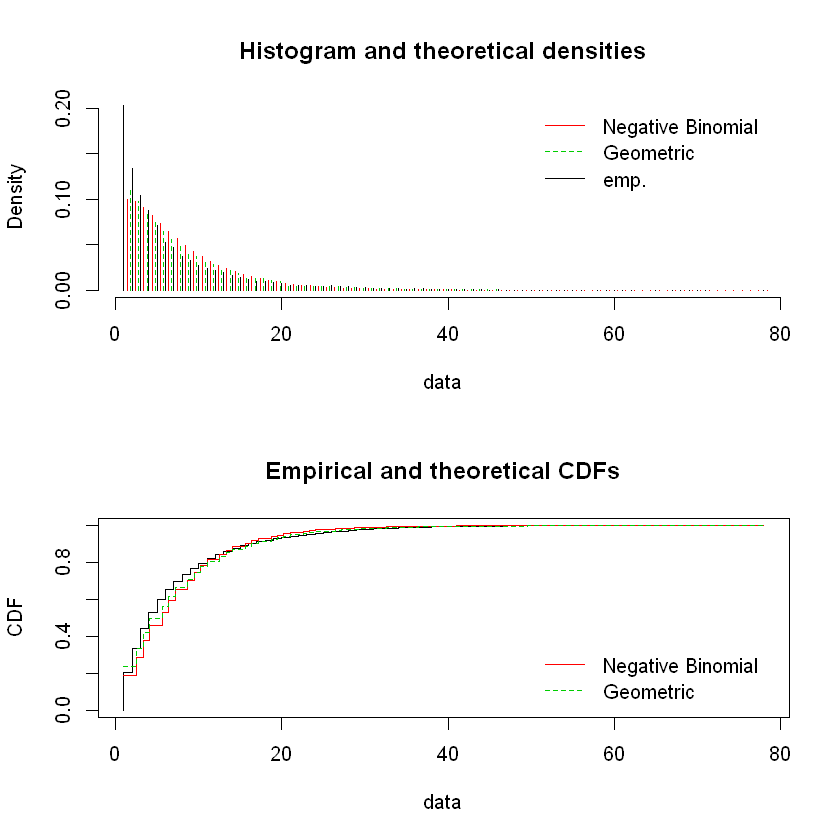

In [354]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )

In [355]:
LOstatRes <- gofstat( list(LOfd_NB_dJul, LOfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [356]:
print( LOstatRes )

Chi-squared statistic:  65858.78 41162.4 
Degree of freedom of the Chi-squared distribution:  34 35 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     212429            197576.7966     250804.928
<= 2     140542            101943.3802     101875.884
<= 3     109351             94816.0890      88836.864
<= 4      91835             85952.5258      77466.699
<= 5      74662             76702.1352      67551.793
<= 6      54655             67724.2223      58905.888
<= 7      49502             59341.1413      51366.566
<= 8      38420             51696.0575      44792.197
<= 9      33733             44832.8540      39059.276
<= 10     28490             38739.9346      34060.108
<= 11     25365             33375.4612      29700.780
<= 12     22482             28682.3212      25899.399
<= 13     20182             24597.1164      22584.554
<= 14     16612             21055.5434      19693.973
<= 15     14768             17995.5420     

In [357]:
LOfdNB_dJul_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [358]:
LOfdNB_dJul_p = LOfdNB_dJul_size / (LOfdNB_dJul_size + LOfdNB_dJul_mu)
cat("LOCA prob: ", LOfdNB_dJul_p)

LOCA prob:  0.1641839

In [359]:
# add to our tracking dataframe
LOMonDistDF[7, ] <- list( 7, dLOJulMean, dLOJulBNr, LOfdNB_dJul_p, LOfdNB_dJul_mu, LOfdNB_dJul_size,
                          LOfdNB_dJul_pvalue )

In [360]:
LOgf_dJul <- goodfit( dLOJul$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJul_size, prob=LOfdNB_dJul_p) )

In [361]:
summary( LOgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          273757.1 78        0
Likelihood Ratio 330633.2 67        0


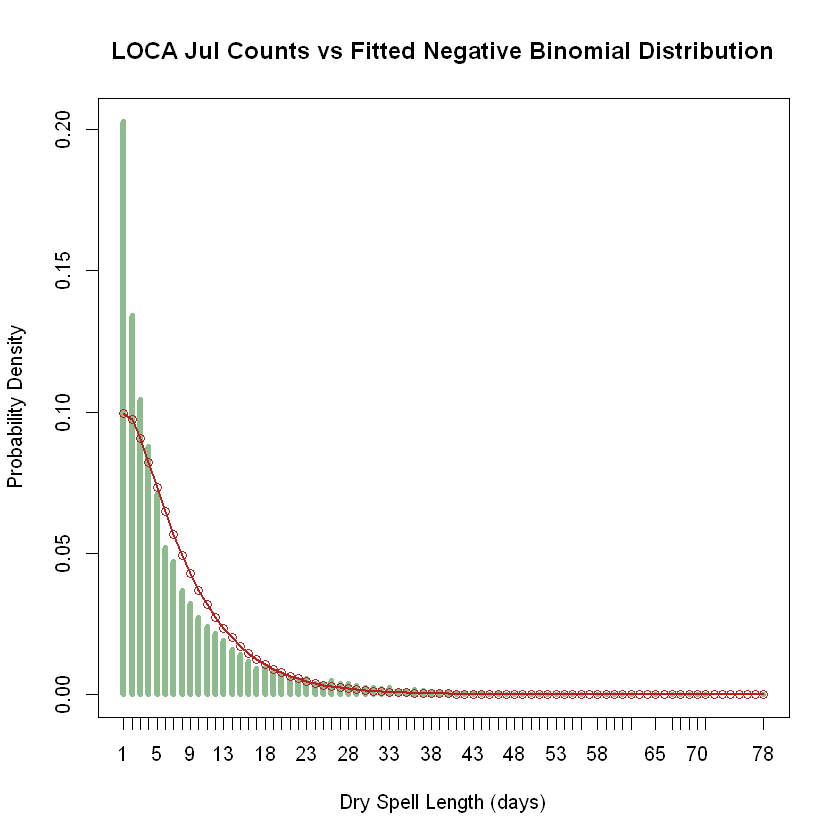

In [362]:
maxP <- max(dLOJul$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJul_size, mu=LOfdNB_dJul_mu )
ttab <- table( dLOJul$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

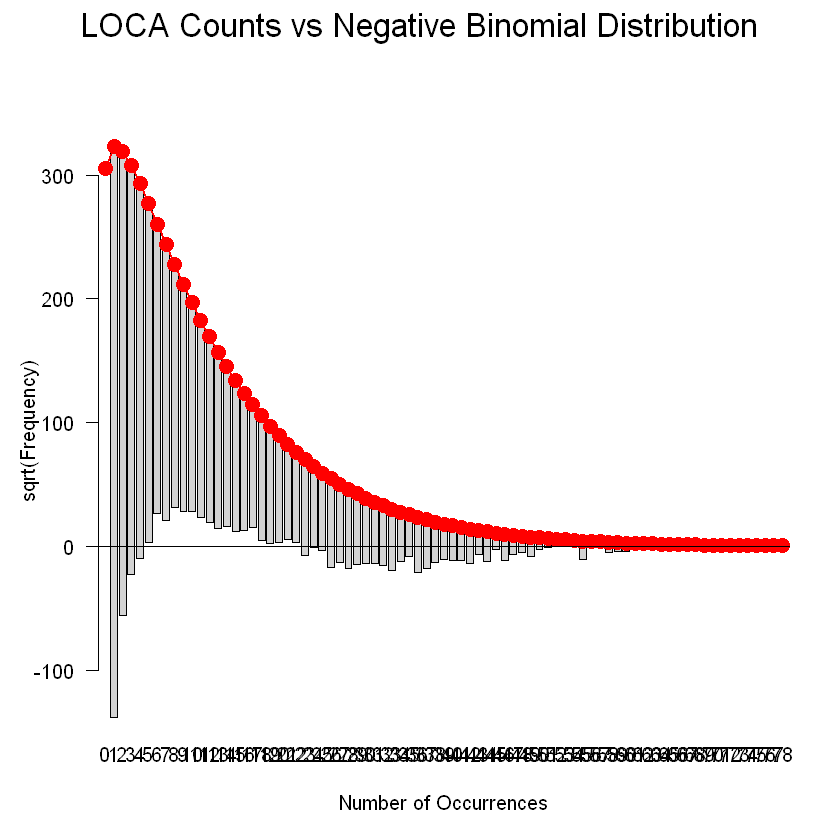

In [363]:
plot( LOgf_dJul, main="LOCA Counts vs Negative Binomial Distribution" )

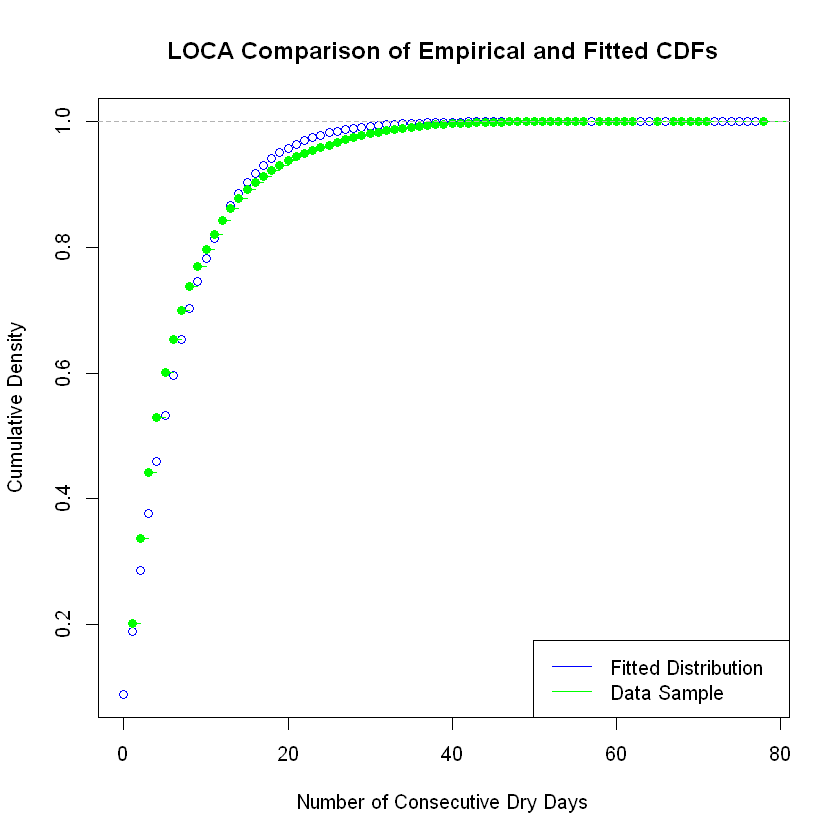

In [364]:
x <- seq(0,dLOJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJul_mu, size=LOfdNB_dJul_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJul$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

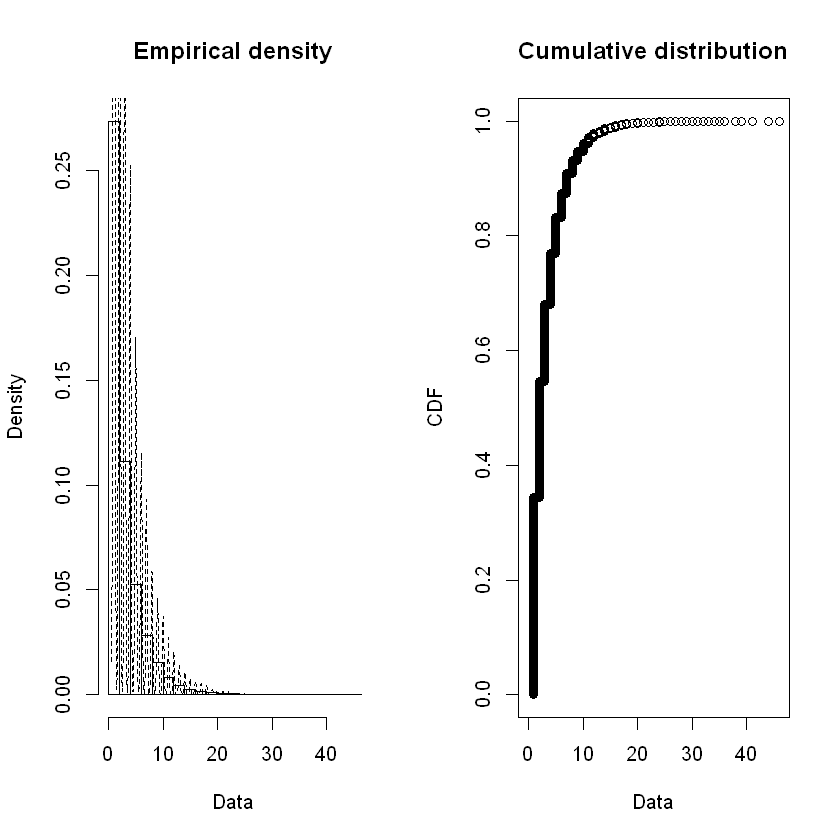

In [365]:
plotdist( dBCJul$Dry_Count, histo=TRUE, demp=TRUE )

In [366]:
BCfd_NB_dJul <- fitdist( dBCJul$Dry_Count, "nbinom" )
BCfd_GE_dJul <- fitdist( dBCJul$Dry_Count, "geom" )

In [367]:
summary( BCfd_NB_dJul )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.644290 0.006808203
mu   3.326571 0.002962563
Loglikelihood:  -1915445   AIC:  3830894   BIC:  3830917 
Correlation matrix:
              size            mu
size  1.000000e+00 -8.413355e-05
mu   -8.413355e-05  1.000000e+00


In [368]:
BCfdNB_dJul_size <- BCfd_NB_dJul$estimate[["size"]]
BCfdNB_dJul_mu <- BCfd_NB_dJul$estimate[["mu"]]
cat("BCCA Jul size: ", BCfdNB_dJul_size, "\n", "BCCA Jul mu: ", BCfdNB_dJul_mu, "\n")

BCCA Jul size:  2.64429 
 BCCA Jul mu:  3.326571 


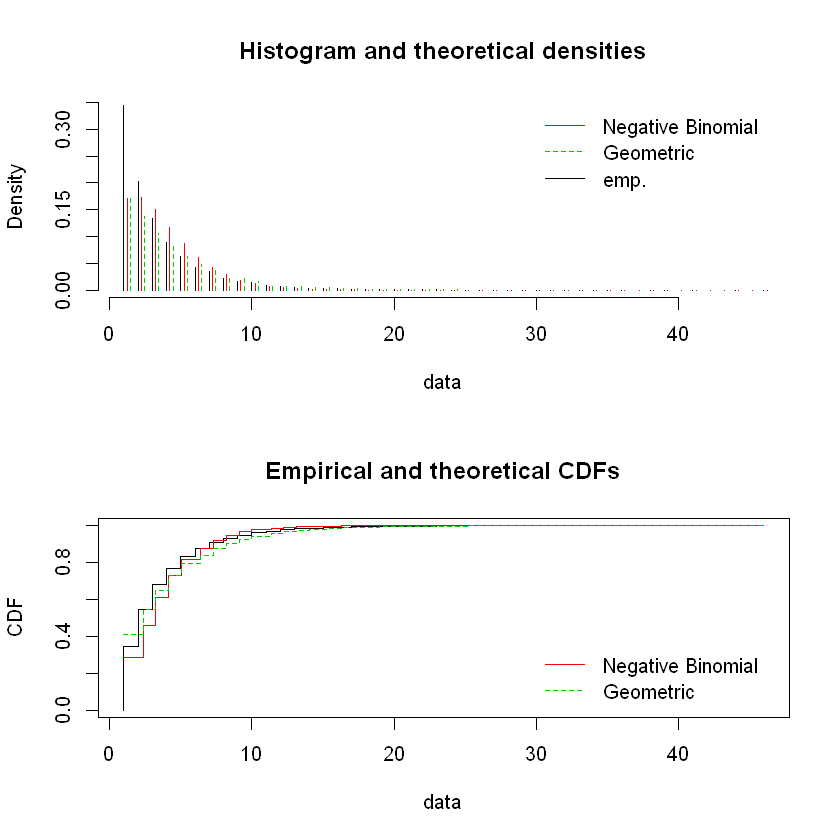

In [369]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )

In [370]:
BCstatRes <- gofstat( list(BCfd_NB_dJul, BCfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [371]:
print(BCstatRes)

Chi-squared statistic:  92699.19 51622.38 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     294357            245656.9483     349938.606
<= 2     173821            148551.5432     116948.219
<= 3     114462            128125.3474      89916.898
<= 4      76225            100726.6058      69133.576
<= 5      53303             74573.1679      53154.094
<= 6      36659             52933.2202      40868.098
<= 7      29205             36418.2794      31421.878
<= 8      18756             24460.1726      24159.049
<= 9      14668             16117.3459      18574.945
<= 10     11587             10456.0190      14281.547
<= 11      8108              6696.1928      10980.521
<= 12      5949              4241.8711       8442.492
<= 13      4205              2662.2097       6491.101
<= 14      3459              1657.4098       4990.753
<= 15      2346              1024.6222    

In [372]:
BCfdNB_dJul_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [373]:
BCfdNB_dJul_p = BCfdNB_dJul_size / (BCfdNB_dJul_size + BCfdNB_dJul_mu)
cat("BCCA prob: ", BCfdNB_dJul_p)

BCCA prob:  0.4428658

In [374]:
# add to our tracking dataframe
BCMonDistDF[7, ] <- list( 7, dBCJulMean, dBCJulBNr, BCfdNB_dJul_p, BCfdNB_dJul_mu, BCfdNB_dJul_size,
                          BCfdNB_dJul_pvalue )

In [375]:
BCgf_dJul <- goodfit( dBCJul$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJul_size, prob=BCfdNB_dJul_p) )

In [376]:
summary( BCgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          498595.9 46        0
Likelihood Ratio 366311.7 40        0


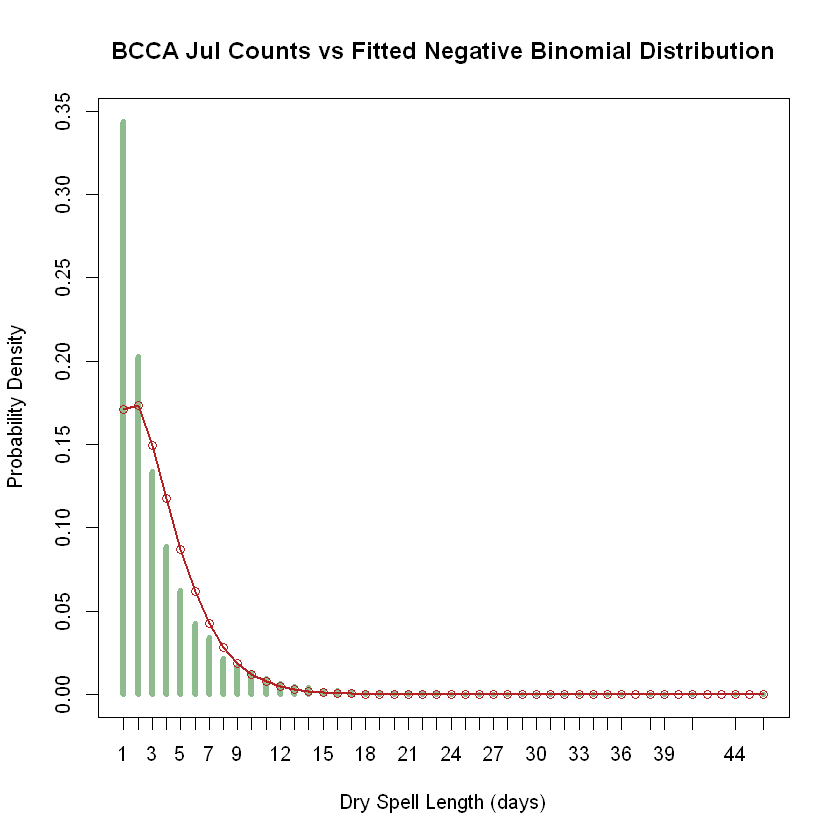

In [377]:
maxP <- max(dBCJul$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJul_size, mu=BCfdNB_dJul_mu )
ttab <- table( dBCJul$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

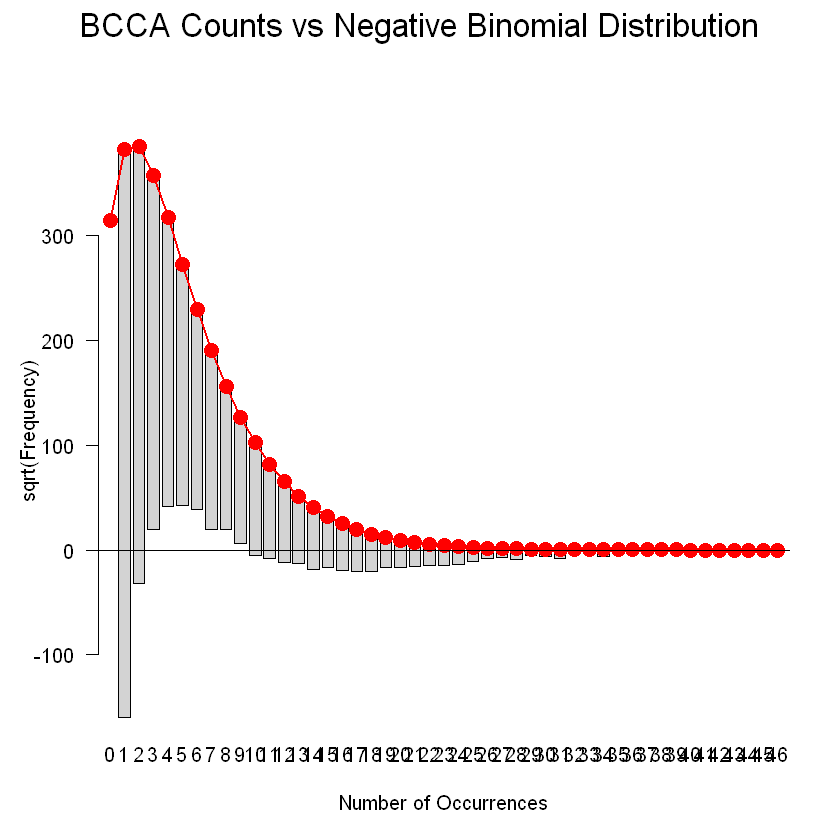

In [378]:
plot( BCgf_dJul, main="BCCA Counts vs Negative Binomial Distribution" )

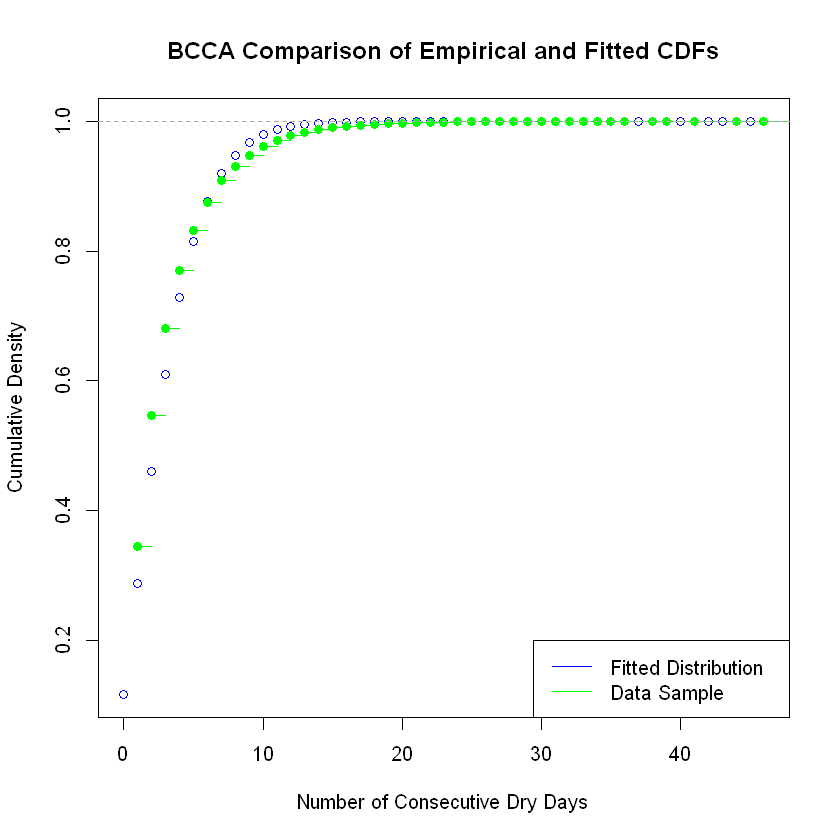

In [379]:
x <- seq(0,dBCJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJul_mu, size=BCfdNB_dJul_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJul$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

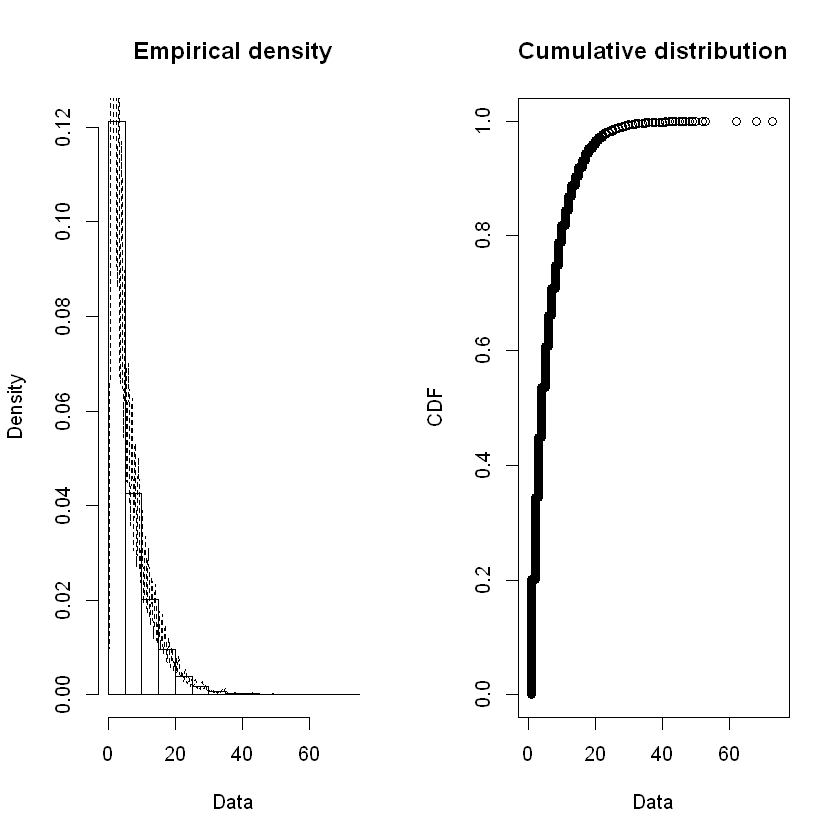

In [380]:
plotdist( dLOAug$Dry_Count, histo=TRUE, demp=TRUE )

In [381]:
LOfd_NB_dAug <- fitdist( dLOAug$Dry_Count, "nbinom" )
LOfd_GE_dAug <- fitdist( dLOAug$Dry_Count, "geom" )

In [382]:
LOfdNB_dAug_size <- LOfd_NB_dAug$estimate[["size"]]
LOfdNB_dAug_mu <- LOfd_NB_dAug$estimate[["mu"]]
cat("LOCA Aug size: ", LOfdNB_dAug_size, "\n", "LOCA Aug mu: ", LOfdNB_dAug_mu, "\n")

LOCA Aug size:  1.60519 
 LOCA Aug mu:  6.145803 


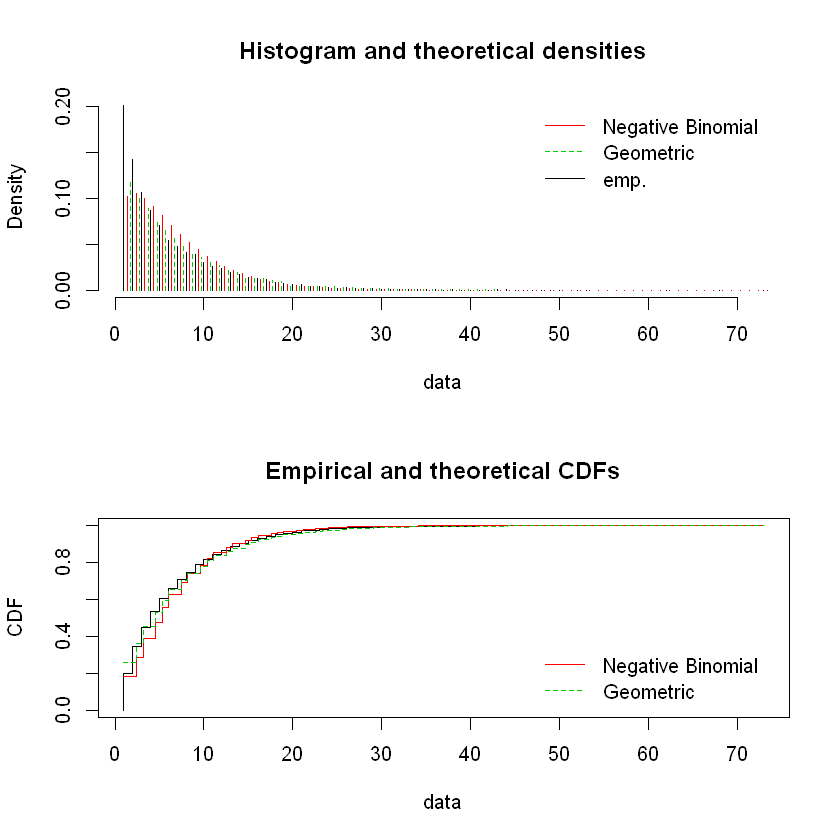

In [383]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )

In [384]:
LOstatRes <- gofstat( list(LOfd_NB_dAug, LOfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [385]:
print( LOstatRes )

Chi-squared statistic:  41759.39 38628.03 
Degree of freedom of the Chi-squared distribution:  28 29 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     214908            194232.9575     278622.156
<= 2     152236            112343.2561     110794.757
<= 3     113802            107047.1656      95286.288
<= 4      92576             97720.1237      81948.613
<= 5      75438             86861.1598      70477.876
<= 6      58120             75819.5103      60612.752
<= 7      51093             65315.2049      52128.497
<= 8      43713             55706.5245      44831.823
<= 9      41510             47140.1338      38556.500
<= 10     32713             39639.7185      33159.563
<= 11     27466             33159.7640      28518.061
<= 12     25658             27618.5505      24526.253
<= 13     20271             22918.3550      21093.197
<= 14     18384             18957.6246      18140.681
<= 15     15390             15638.0654    

In [386]:
LOfdNB_dAug_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [387]:
LOfdNB_dAug_p = LOfdNB_dAug_size / (LOfdNB_dAug_size + LOfdNB_dAug_mu)
cat("LOCA prob: ", LOfdNB_dAug_p)

LOCA prob:  0.2070947

In [388]:
# add to our tracking dataframe
LOMonDistDF[8, ] <- list( 8, dLOAugMean, dLOAugBNr, LOfdNB_dAug_p, LOfdNB_dAug_mu, LOfdNB_dAug_size,
                          LOfdNB_dAug_pvalue )

In [389]:
LOgf_dAug <- goodfit( dLOAug$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dAug_size, prob=LOfdNB_dAug_p) )

In [390]:
summary( LOgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          244425.9 73        0
Likelihood Ratio 290593.2 54        0


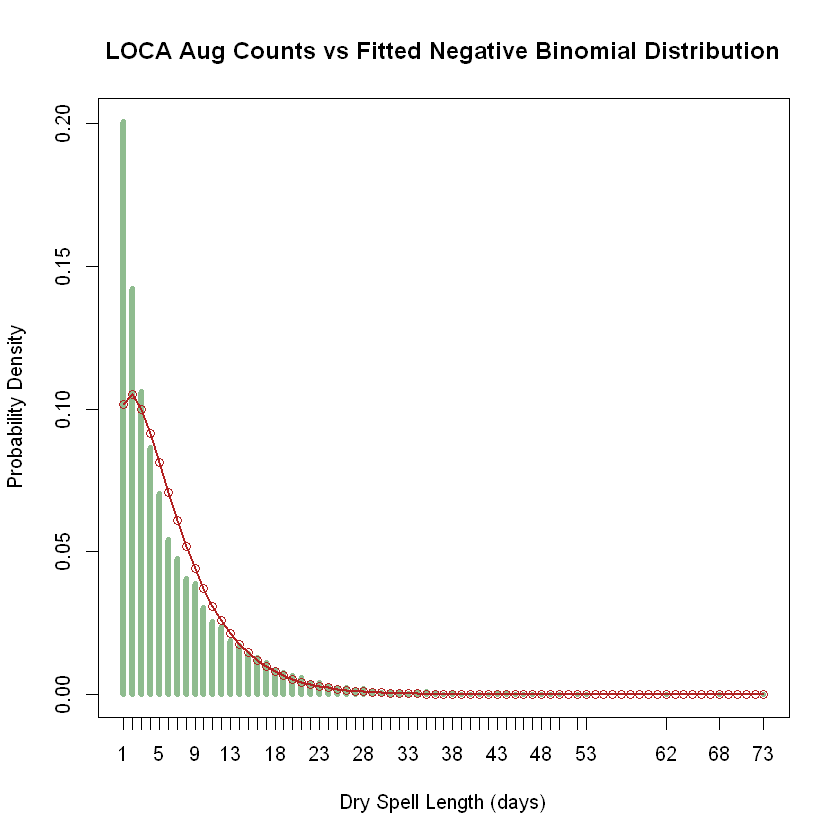

In [391]:
maxP <- max(dLOAug$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dAug_size, mu=LOfdNB_dAug_mu )
ttab <- table( dLOAug$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

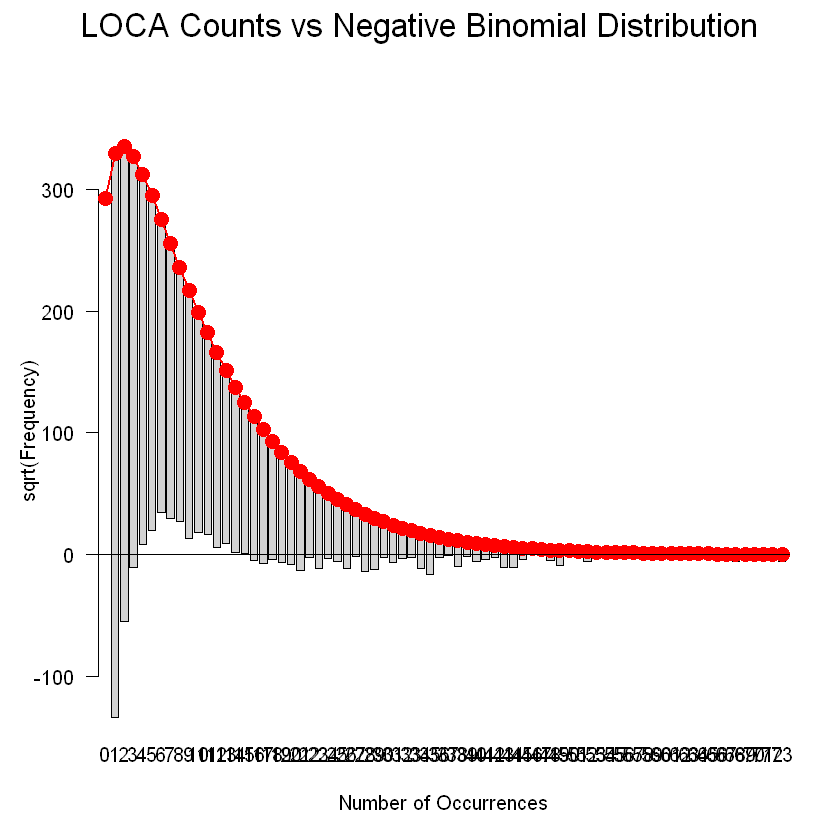

In [392]:
plot( LOgf_dAug, main="LOCA Counts vs Negative Binomial Distribution" )

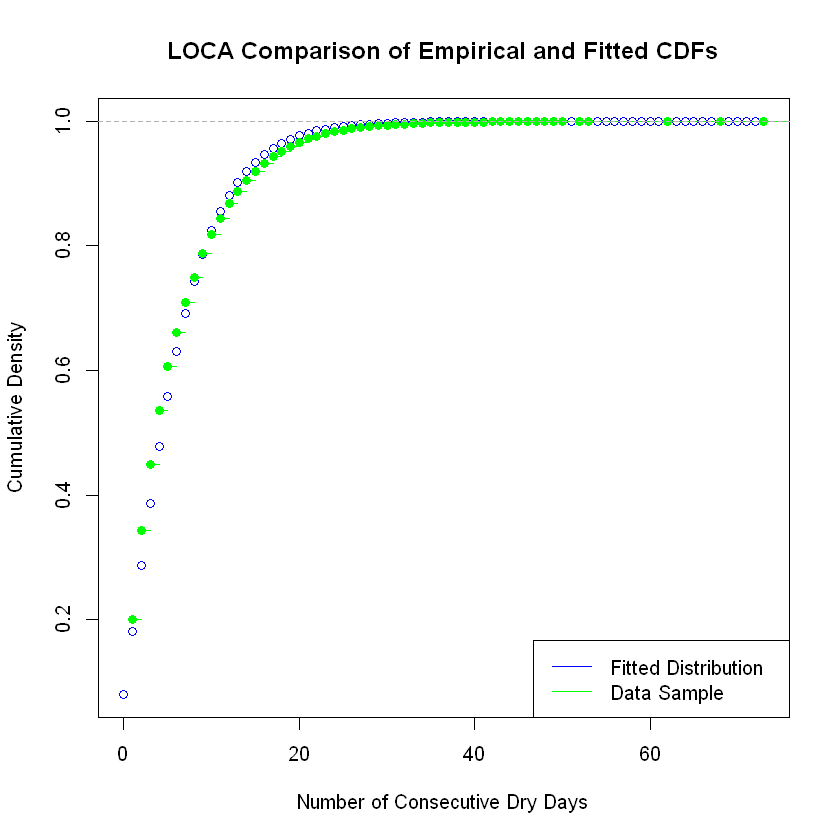

In [393]:
x <- seq(0,dLOAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dAug_mu, size=LOfdNB_dAug_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOAug$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

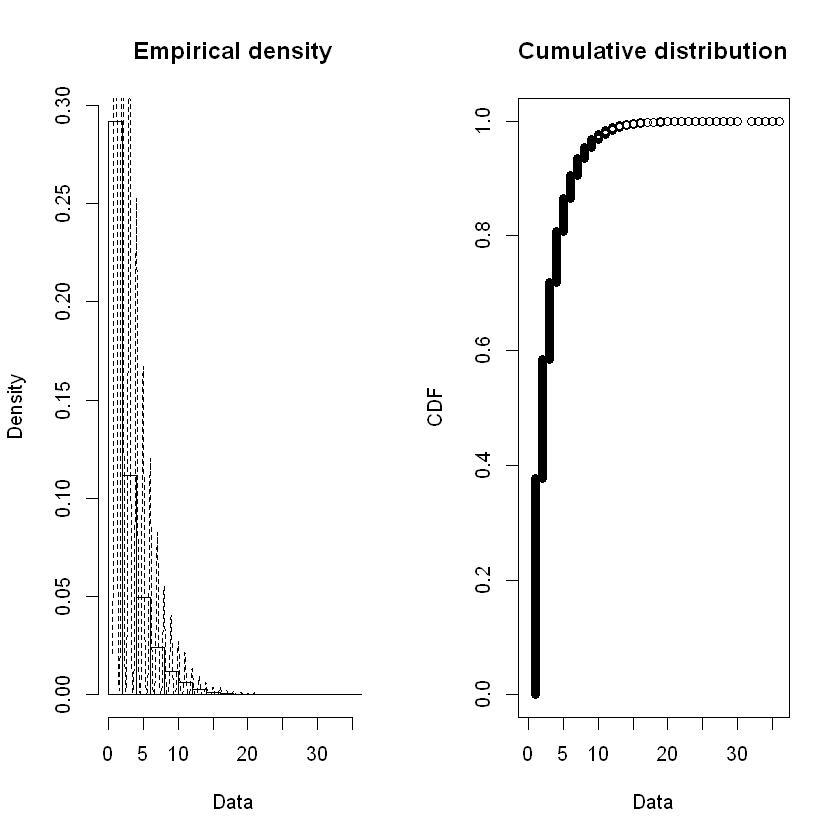

In [394]:
plotdist( dBCAug$Dry_Count, histo=TRUE, demp=TRUE )

In [395]:
BCfd_NB_dAug <- fitdist( dBCAug$Dry_Count, "nbinom" )
BCfd_GE_dAug <- fitdist( dBCAug$Dry_Count, "geom" )

In [396]:
summary( BCfd_NB_dAug )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate Std. Error
size 3.405646 0.01030859
mu   2.960953 0.00251847
Loglikelihood:  -1838081   AIC:  3676165   BIC:  3676189 
Correlation matrix:
             size           mu
size 1.0000000000 0.0001226232
mu   0.0001226232 1.0000000000


In [397]:
BCfdNB_dAug_size <- BCfd_NB_dAug$estimate[["size"]]
BCfdNB_dAug_mu <- BCfd_NB_dAug$estimate[["mu"]]
cat("BCCA Aug size: ", BCfdNB_dAug_size, "\n", "BCCA Aug mu: ", BCfdNB_dAug_mu, "\n")

BCCA Aug size:  3.405646 
 BCCA Aug mu:  2.960953 


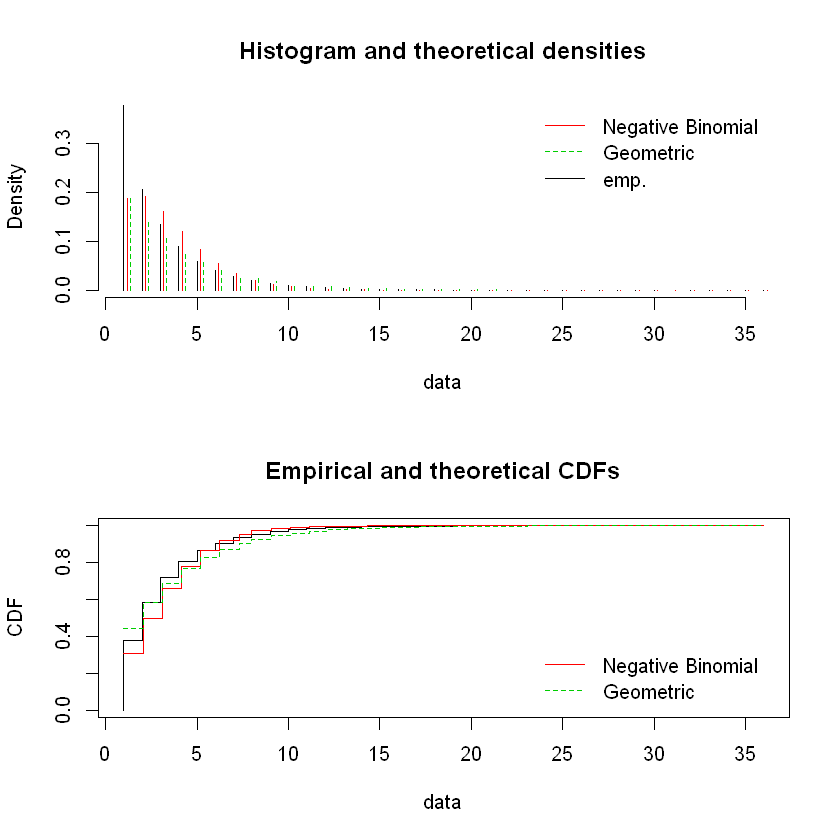

In [398]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )

In [399]:
BCstatRes <- gofstat( list(BCfd_NB_dAug, BCfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [400]:
print(BCstatRes)

Chi-squared statistic:  92144.87 53634.22 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     329618            267762.9733     384967.818
<= 2     179891            168152.9835     123104.759
<= 3     117529            140914.2636      92026.900
<= 4      77330            104949.8760      68794.663
<= 5      51164             72293.4424      51427.415
<= 6      35013             47102.3724      38444.538
<= 7      24860             29434.5501      28739.195
<= 8      16835             17805.7591      21483.971
<= 9      12145             10494.5037      16060.331
<= 10      8357              6054.8769      12005.892
<= 11      6510              3431.8193       8974.999
<= 12      4188              1916.0196       6709.256
<= 13      2728              1055.9918       5015.501
<= 15      2923               886.0855       6552.149
<= 18      2247               300.8818    

In [401]:
BCfdNB_dAug_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [402]:
BCfdNB_dAug_p = BCfdNB_dAug_size / (BCfdNB_dAug_size + BCfdNB_dAug_mu)
cat("BCCA prob: ", BCfdNB_dAug_p)

BCCA prob:  0.5349239

In [403]:
# add to our tracking dataframe
BCMonDistDF[8, ] <- list( 8, dBCAugMean, dBCAugBNr, BCfdNB_dAug_p, BCfdNB_dAug_mu, BCfdNB_dAug_size,
                          BCfdNB_dAug_pvalue )

In [404]:
BCgf_dAug <- goodfit( dBCAug$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dAug_size, prob=BCfdNB_dAug_p) )

In [405]:
summary( BCgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          550030.6 36        0
Likelihood Ratio 382394.5 34        0


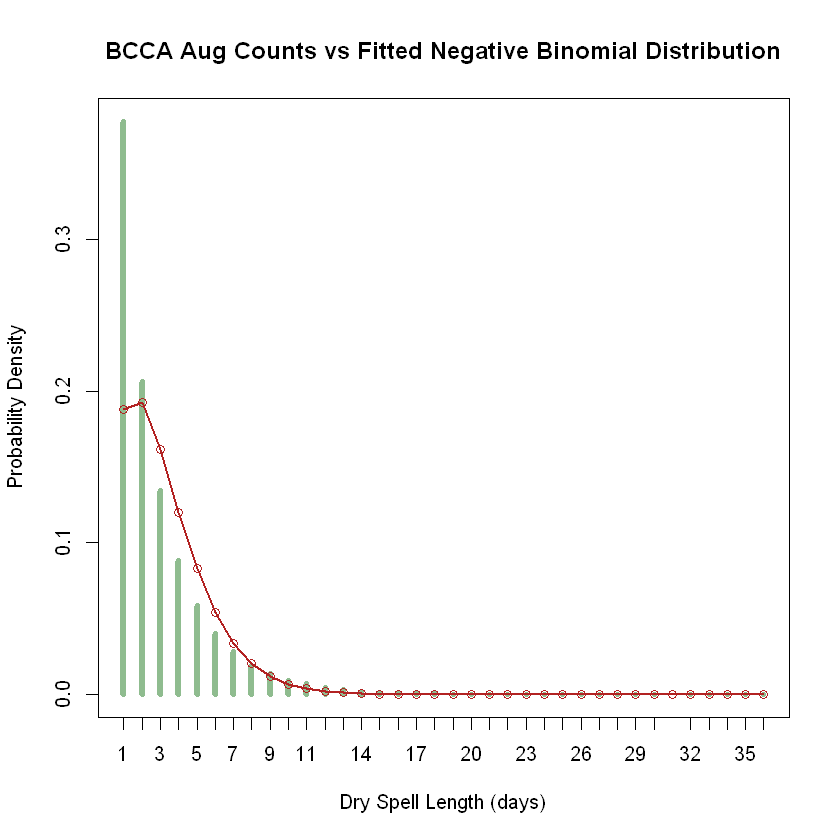

In [406]:
maxP <- max(dBCAug$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dAug_size, mu=BCfdNB_dAug_mu )
ttab <- table( dBCAug$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

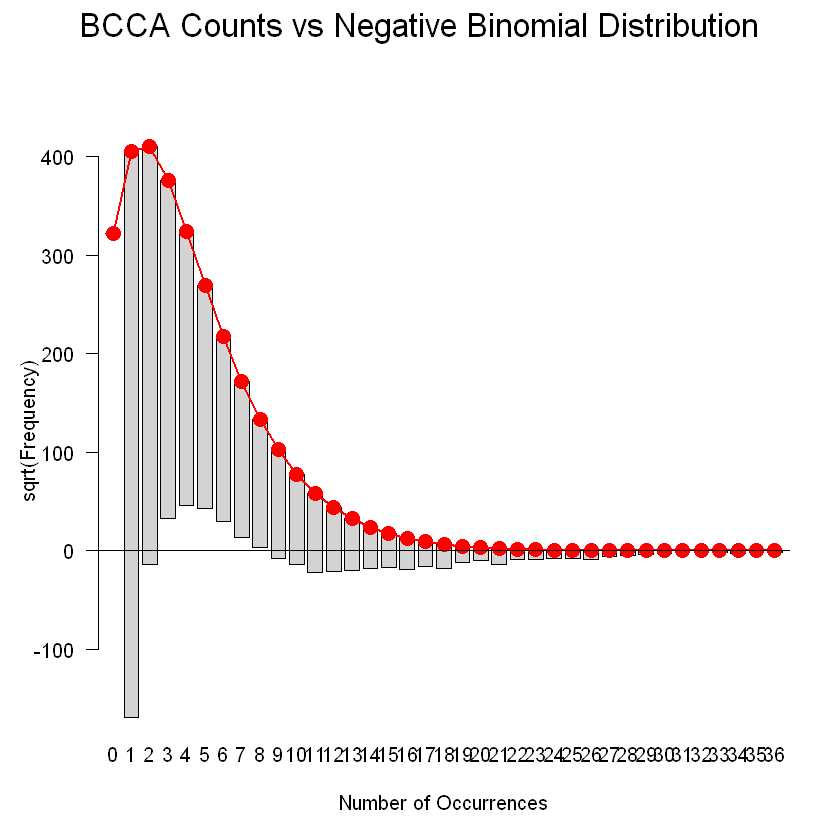

In [407]:
plot( BCgf_dAug, main="BCCA Counts vs Negative Binomial Distribution" )

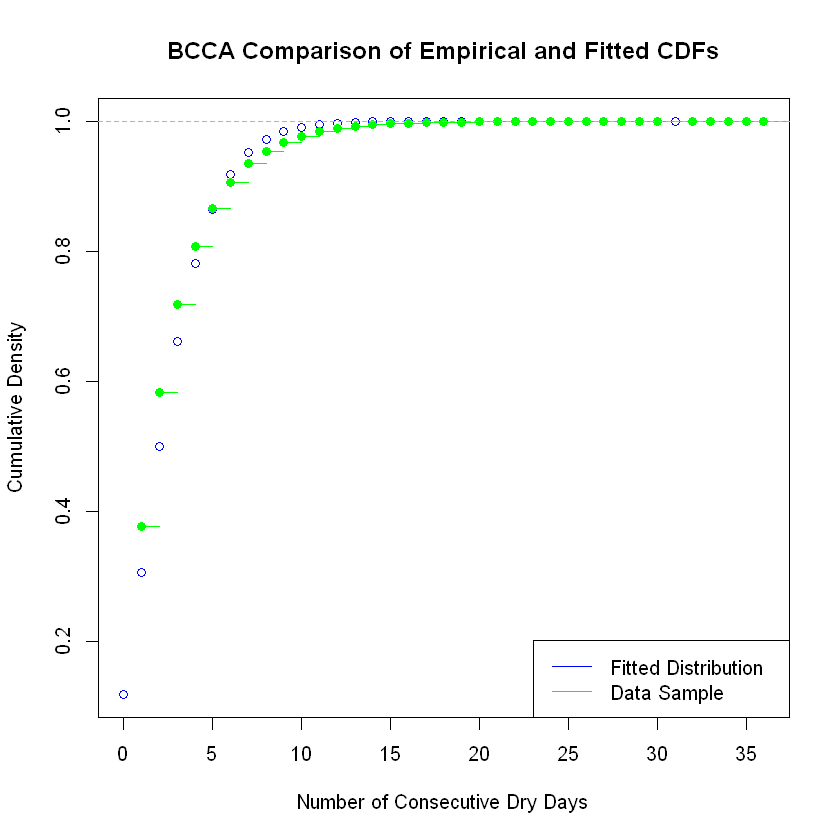

In [408]:
x <- seq(0,dBCAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dAug_mu, size=BCfdNB_dAug_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCAug$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

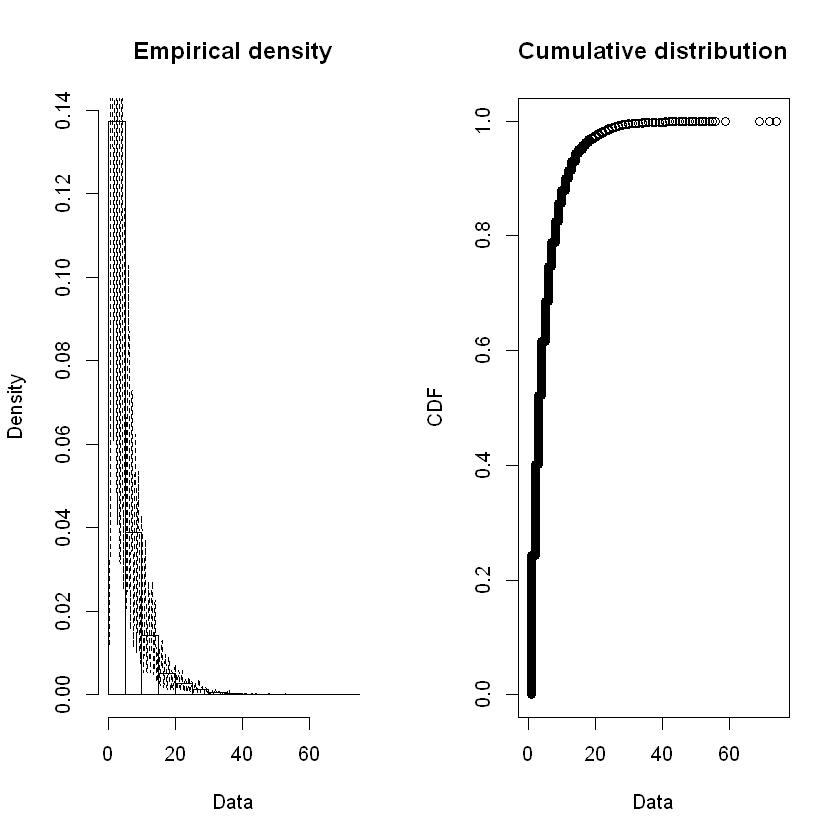

In [409]:
plotdist( dLOSep$Dry_Count, histo=TRUE, demp=TRUE )

In [410]:
LOfd_NB_dSep <- fitdist( dLOSep$Dry_Count, "nbinom" )
LOfd_GE_dSep <- fitdist( dLOSep$Dry_Count, "geom" )

In [411]:
LOfdNB_dSep_size <- LOfd_NB_dSep$estimate[["size"]]
LOfdNB_dSep_mu <- LOfd_NB_dSep$estimate[["mu"]]
cat("LOCA Sep size: ", LOfdNB_dSep_size, "\n", "LOCA Sep mu: ", LOfdNB_dSep_mu, "\n")

LOCA Sep size:  1.683328 
 LOCA Sep mu:  5.094812 


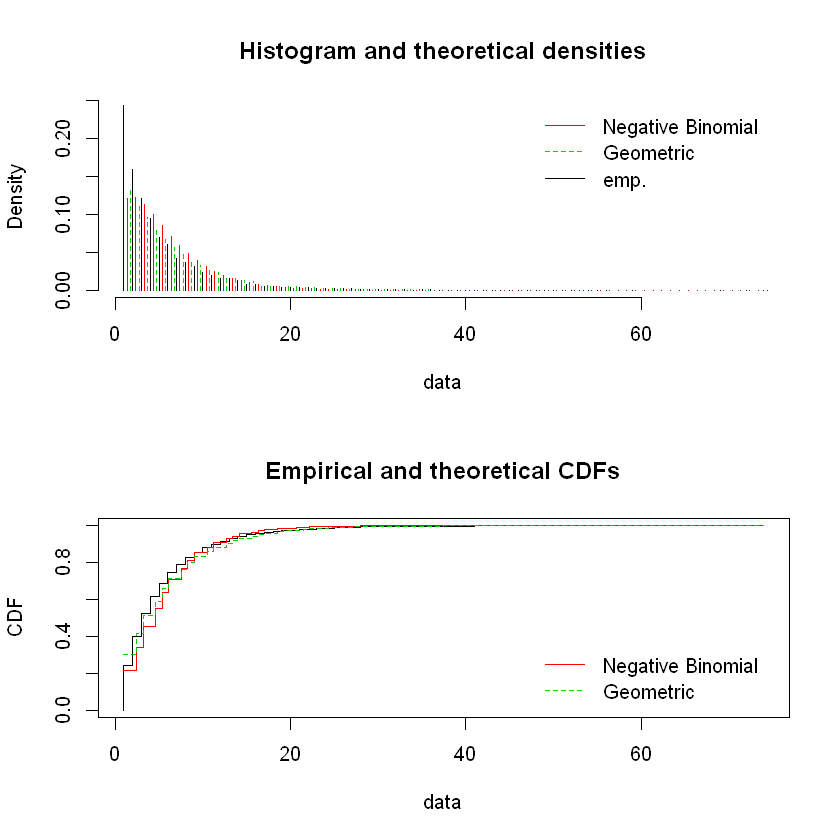

In [412]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )

In [413]:
LOstatRes <- gofstat( list(LOfd_NB_dSep, LOfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [414]:
print( LOstatRes )

Chi-squared statistic:  95276.37 54009.27 
Degree of freedom of the Chi-squared distribution:  26 27 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     294766            263555.9256     365519.536
<= 2     192559            148456.3973     139125.922
<= 3     146122            137004.7804     116301.917
<= 4     114700            120572.4142      97222.255
<= 5      84890            103014.4903      81272.666
<= 6      73352             86249.6781      67939.653
<= 7      51153             71158.4454      56793.959
<= 8      44559             58055.0900      47476.748
<= 9      37457             46950.4831      39688.052
<= 10     28380             37701.9884      33177.113
<= 11     23601             30099.2563      27734.313
<= 12     18512             23912.5212      23184.420
<= 13     19103             18918.7037      19380.949
<= 14     15727             14914.3889      16201.449
<= 15      8877             11721.1453    

In [415]:
LOfdNB_dSep_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [416]:
LOfdNB_dSep_p = LOfdNB_dSep_size / (LOfdNB_dSep_size + LOfdNB_dSep_mu)
cat("LOCA prob: ", LOfdNB_dSep_p)

LOCA prob:  0.2483466

In [417]:
# add to our tracking dataframe
LOMonDistDF[9, ] <- list( 9, dLOSepMean, dLOSepBNr, LOfdNB_dSep_p, LOfdNB_dSep_mu, LOfdNB_dSep_size,
                          LOfdNB_dSep_pvalue )

In [418]:
LOgf_dSep <- goodfit( dLOSep$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dSep_size, prob=LOfdNB_dSep_p) )

In [419]:
summary( LOgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          516482.9 74        0
Likelihood Ratio 414416.3 59        0


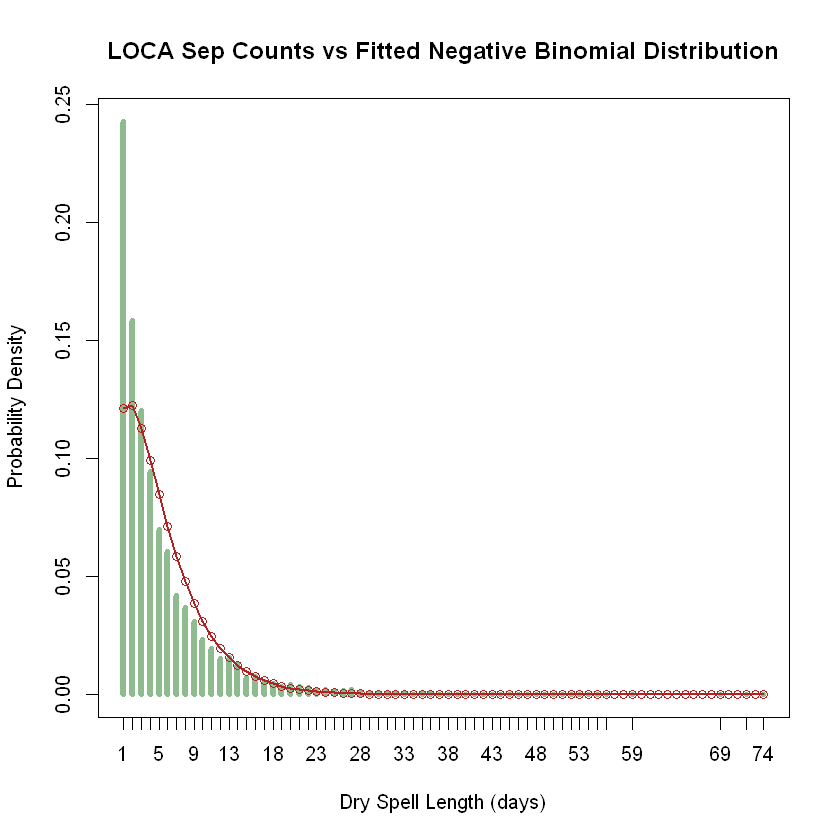

In [420]:
maxP <- max(dLOSep$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dSep_size, mu=LOfdNB_dSep_mu )
ttab <- table( dLOSep$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

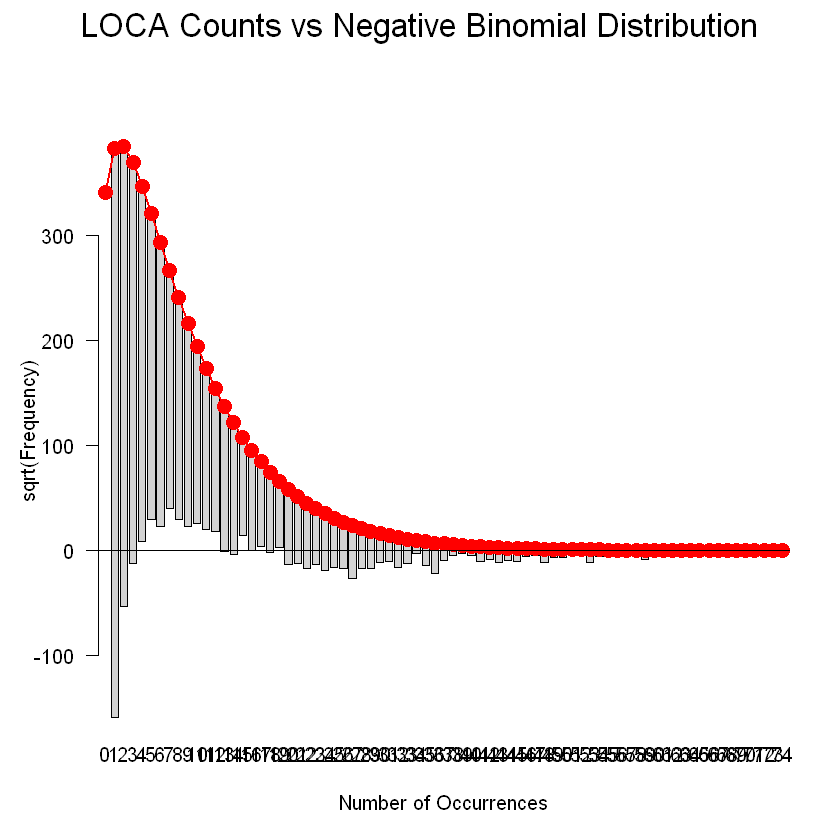

In [421]:
plot( LOgf_dSep, main="LOCA Counts vs Negative Binomial Distribution" )

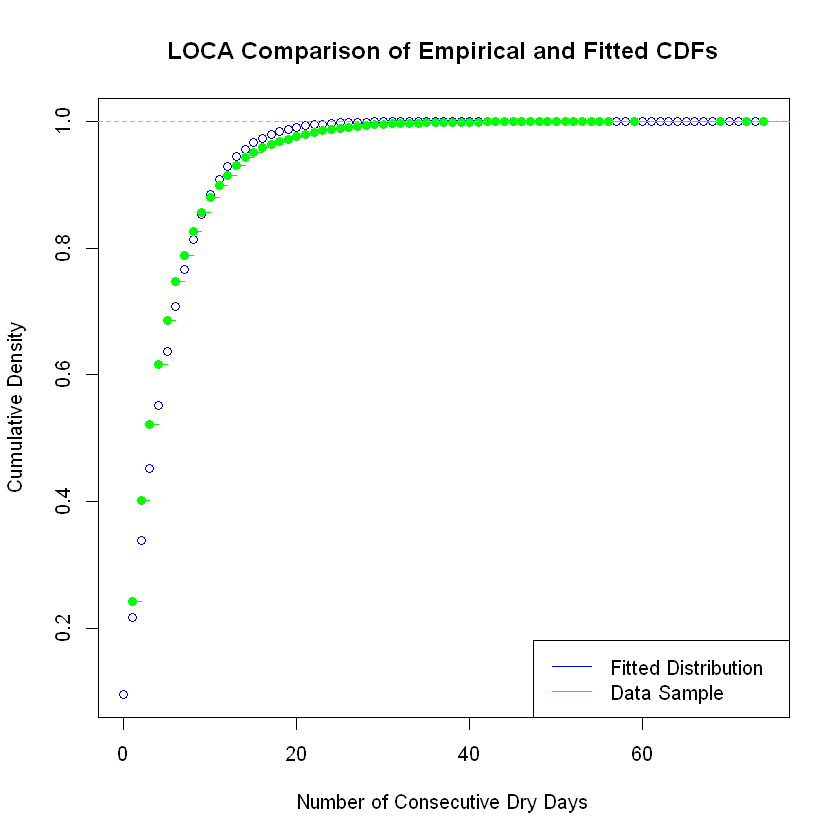

In [422]:
x <- seq(0,dLOSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dSep_mu, size=LOfdNB_dSep_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOSep$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

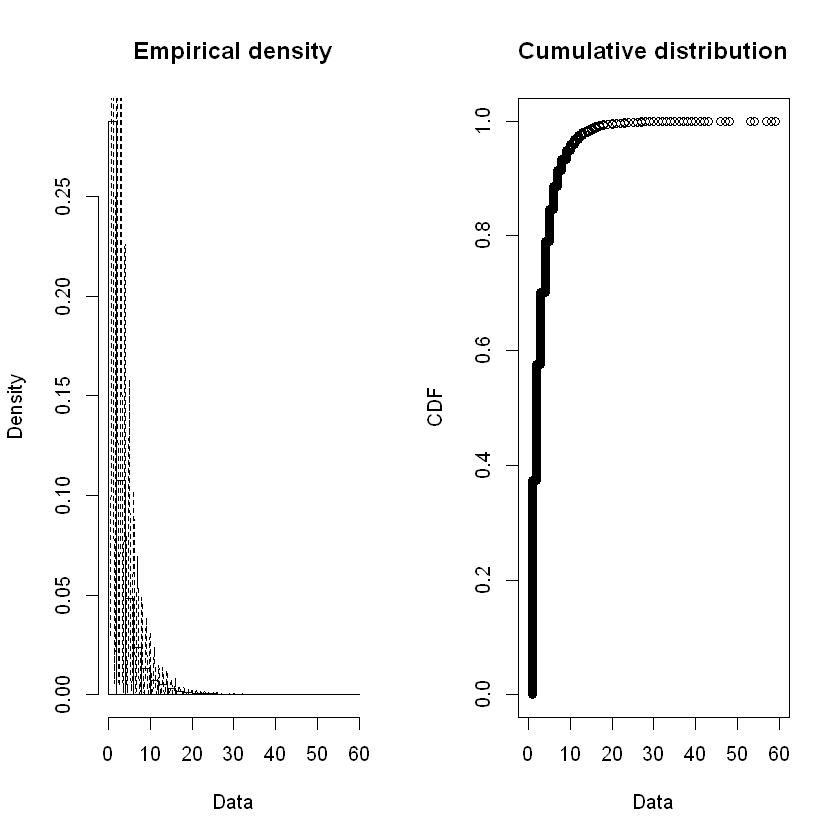

In [423]:
plotdist( dBCSep$Dry_Count, histo=TRUE, demp=TRUE )

In [424]:
BCfd_NB_dSep <- fitdist( dBCSep$Dry_Count, "nbinom" )
BCfd_GE_dSep <- fitdist( dBCSep$Dry_Count, "geom" )

In [425]:
summary( BCfd_NB_dSep )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.410082 0.006082876
mu   3.226003 0.003031324
Loglikelihood:  -1827568   AIC:  3655139   BIC:  3655163 
Correlation matrix:
             size           mu
size  1.000000000 -0.000344565
mu   -0.000344565  1.000000000


In [426]:
BCfdNB_dSep_size <- BCfd_NB_dSep$estimate[["size"]]
BCfdNB_dSep_mu <- BCfd_NB_dSep$estimate[["mu"]]
cat("BCCA Sep size: ", BCfdNB_dSep_size, "\n", "BCCA Sep mu: ", BCfdNB_dSep_mu, "\n")

BCCA Sep size:  2.410082 
 BCCA Sep mu:  3.226003 


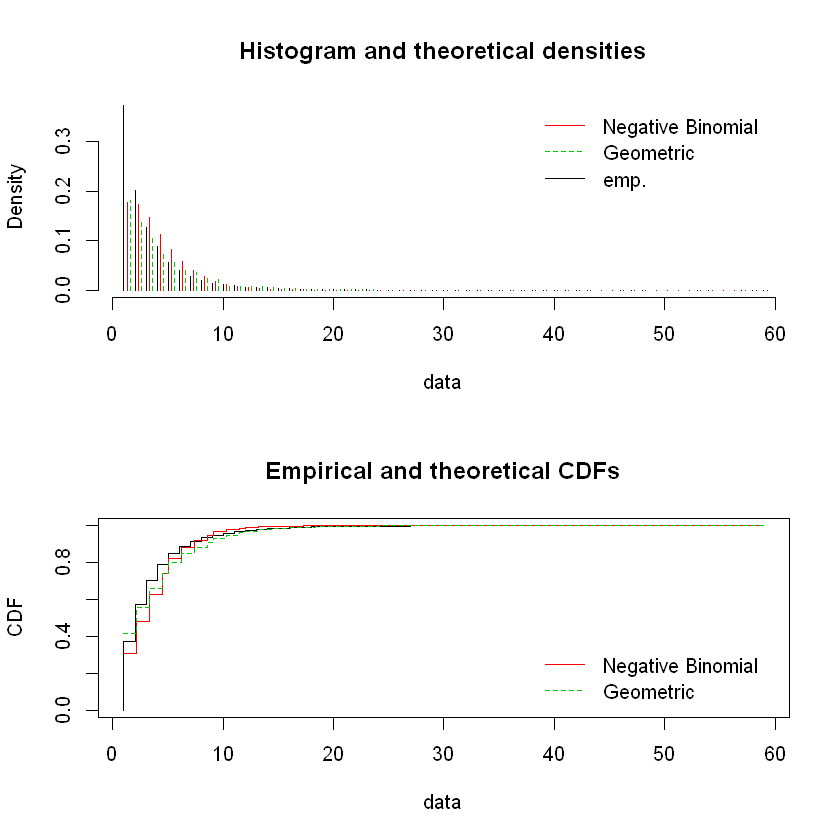

In [427]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )

In [428]:
BCstatRes <- gofstat( list(BCfd_NB_dSep, BCfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [429]:
print(BCstatRes)

Chi-squared statistic:  165778.5 43208.4 
Degree of freedom of the Chi-squared distribution:  16 17 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     306355           252228.10439     342749.330
<= 2     166324           142708.66792     113257.516
<= 3     103767           120077.86696      86452.777
<= 4      72880            92959.55351      65991.935
<= 5      46315            68214.20502      50373.576
<= 6      32923            48220.73223      38451.625
<= 7      22653            33160.66327      29351.251
<= 8      16097            22326.15054      22404.669
<= 9      11810            14781.30268      17102.140
<= 10      9561             9653.58662      13054.564
<= 11      7255             6233.87208       9964.931
<= 12      4402             3987.45043       7606.523
<= 13      4445             2529.91320       5806.282
<= 14      3954             1593.93189       4432.105
<= 15      2452              998.10557     

In [430]:
BCfdNB_dSep_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [431]:
BCfdNB_dSep_p = BCfdNB_dSep_size / (BCfdNB_dSep_size + BCfdNB_dSep_mu)
cat("BCCA prob: ", BCfdNB_dSep_p)

BCCA prob:  0.4276163

In [432]:
# add to our tracking dataframe
BCMonDistDF[9, ] <- list( 9, dBCSepMean, dBCSepBNr, BCfdNB_dSep_p, BCfdNB_dSep_mu, BCfdNB_dSep_size,
                          BCfdNB_dSep_pvalue )

In [433]:
BCgf_dSep <- goodfit( dBCSep$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dSep_size, prob=BCfdNB_dSep_p) )

In [434]:
summary( BCgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                         X^2 df P(> X^2)
Pearson          541242913.5 59        0
Likelihood Ratio    412168.8 50        0


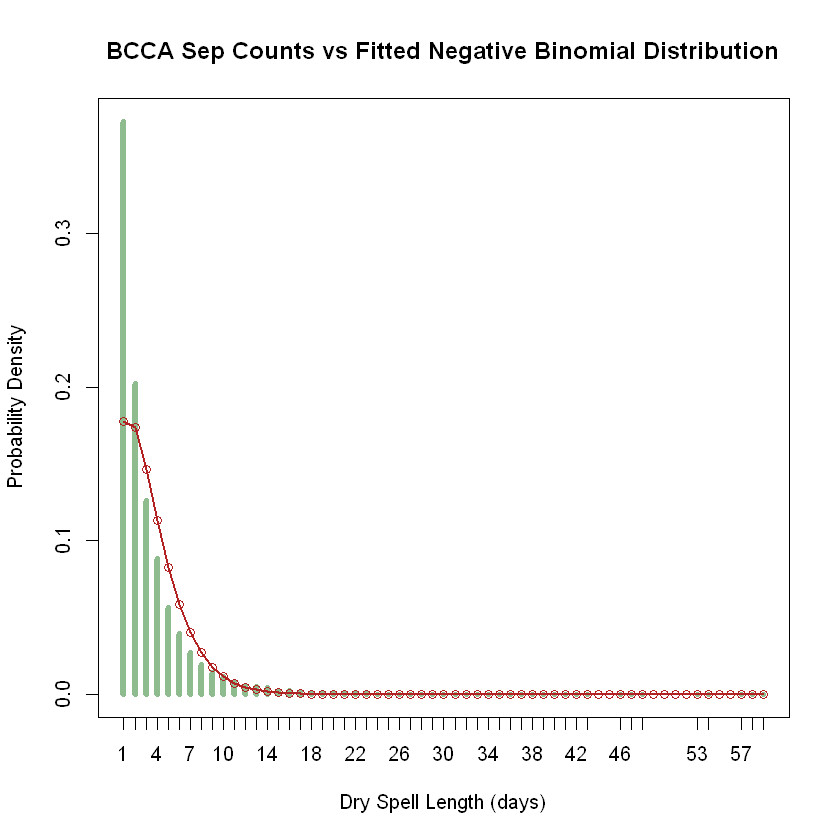

In [435]:
maxP <- max(dBCSep$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dSep_size, mu=BCfdNB_dSep_mu )
ttab <- table( dBCSep$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

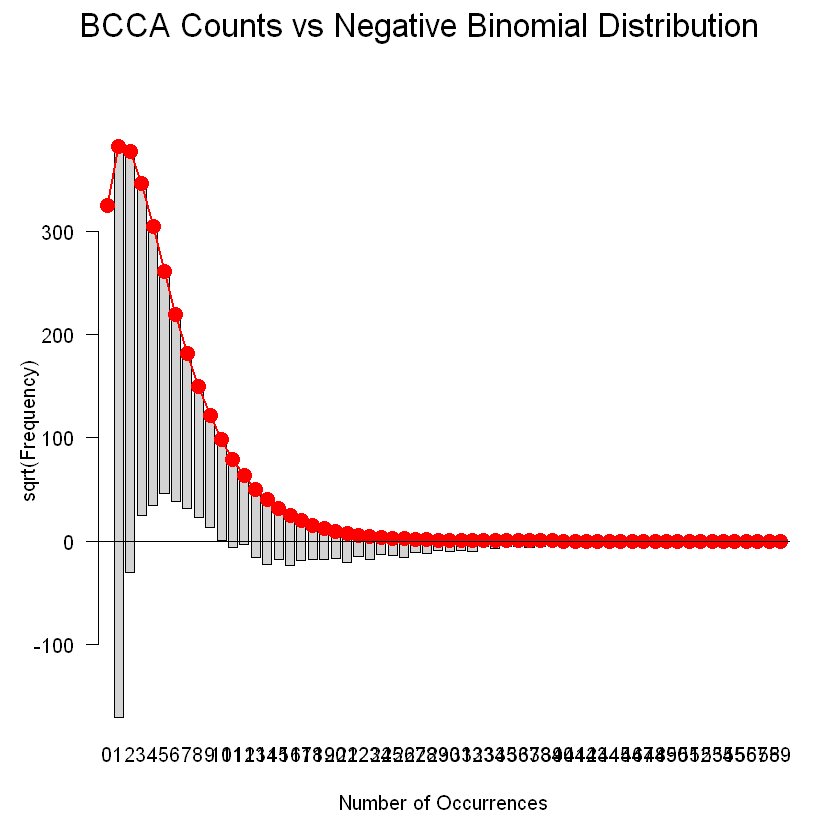

In [436]:
plot( BCgf_dSep, main="BCCA Counts vs Negative Binomial Distribution" )

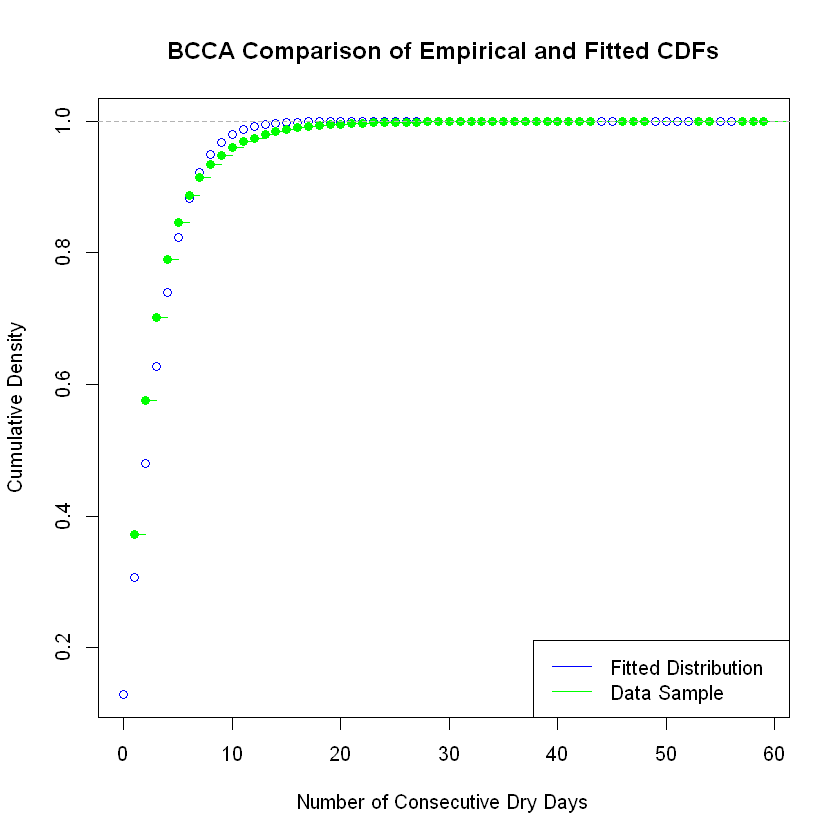

In [437]:
x <- seq(0,dBCSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dSep_mu, size=BCfdNB_dSep_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCSep$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

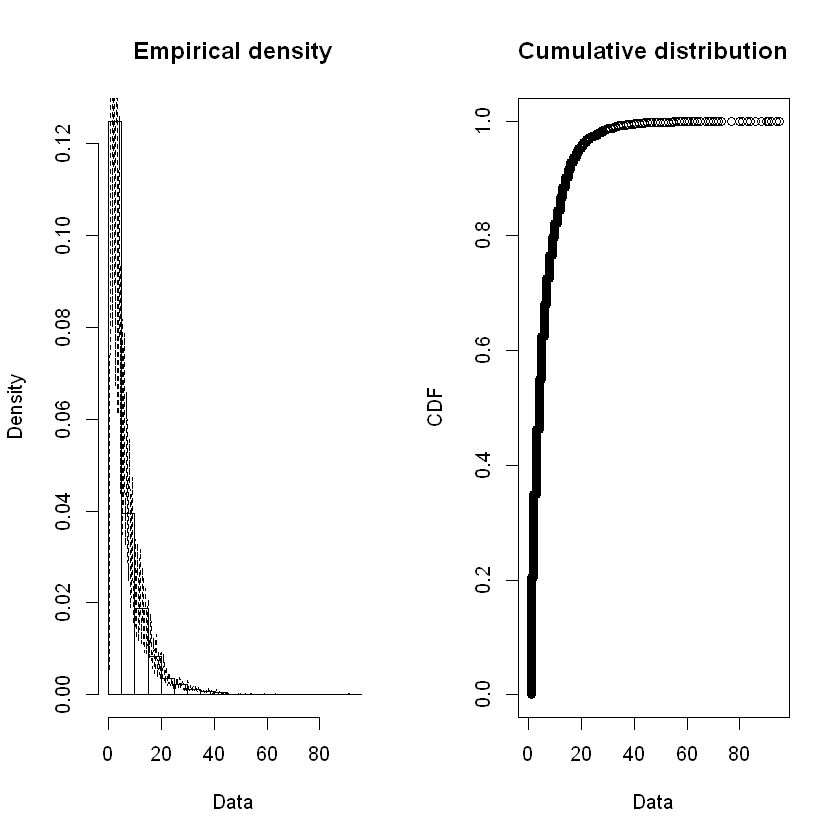

In [438]:
plotdist( dLOOct$Dry_Count, histo=TRUE, demp=TRUE )

In [439]:
LOfd_NB_dOct <- fitdist( dLOOct$Dry_Count, "nbinom" )
LOfd_GE_dOct <- fitdist( dLOOct$Dry_Count, "geom" )

In [440]:
LOfdNB_dOct_size <- LOfd_NB_dOct$estimate[["size"]]
LOfdNB_dOct_mu <- LOfd_NB_dOct$estimate[["mu"]]
cat("LOCA Oct size: ", LOfdNB_dOct_size, "\n", "LOCA Oct mu: ", LOfdNB_dOct_mu, "\n")

LOCA Oct size:  1.451311 
 LOCA Oct mu:  6.234009 


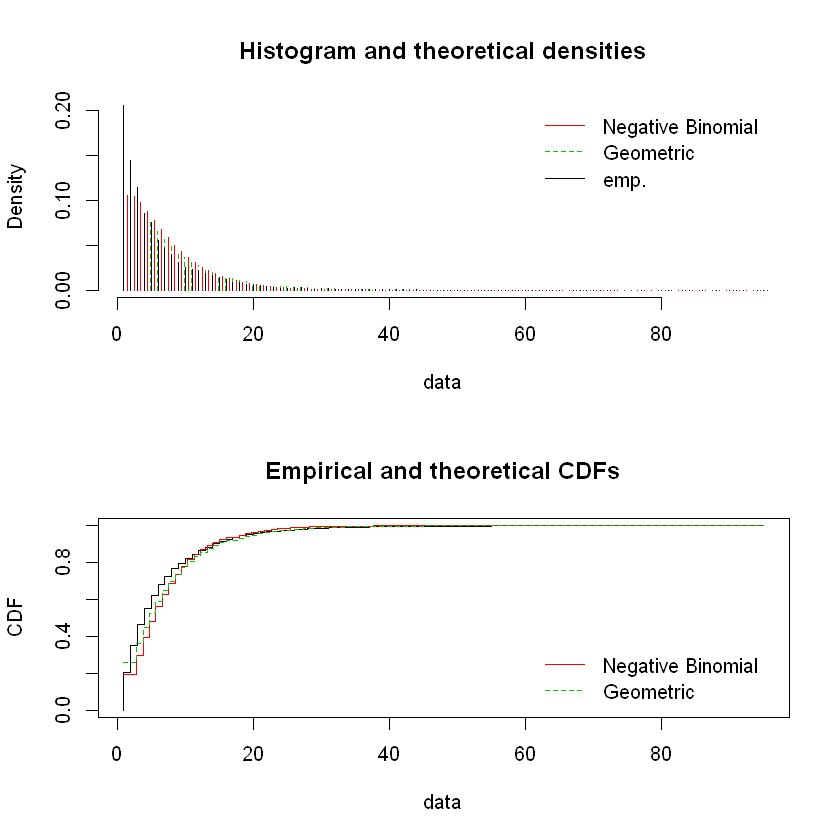

In [441]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )

In [442]:
LOstatRes <- gofstat( list(LOfd_NB_dOct, LOfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [443]:
print( LOstatRes )

Chi-squared statistic:  85576.23 54164.22 
Degree of freedom of the Chi-squared distribution:  31 32 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     243717            230657.1009     306376.417
<= 2     171364            123993.7954     122206.942
<= 3     136283            115709.3074     105311.725
<= 4     102036            104448.3850      90752.287
<= 5      90027             92371.5360      78205.704
<= 6      66269             80563.8792      67393.697
<= 7      55224             69563.3506      58076.459
<= 8      47722             59610.1285      50047.338
<= 9      36822             50777.9391      43128.250
<= 10     29447             43047.8343      37165.731
<= 11     27318             36351.2455      32027.536
<= 12     25403             30595.5731      27599.702
<= 13     21714             25679.4263      23784.019
<= 14     19704             21501.5609      20495.857
<= 15     17188             17965.9226    

In [444]:
LOfdNB_dOct_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [445]:
LOfdNB_dOct_p = LOfdNB_dOct_size / (LOfdNB_dOct_size + LOfdNB_dOct_mu)
cat("LOCA prob: ", LOfdNB_dOct_p)

LOCA prob:  0.188842

In [446]:
# add to our tracking dataframe
LOMonDistDF[10, ] <- list( 10, dLOOctMean, dLOOctBNr, LOfdNB_dOct_p, LOfdNB_dOct_mu, LOfdNB_dOct_size,
                          LOfdNB_dOct_pvalue )

In [447]:
LOgf_dOct <- goodfit( dLOOct$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dOct_size, prob=LOfdNB_dOct_p) )

In [448]:
summary( LOgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          7434664.4 95        0
Likelihood Ratio  373010.9 83        0


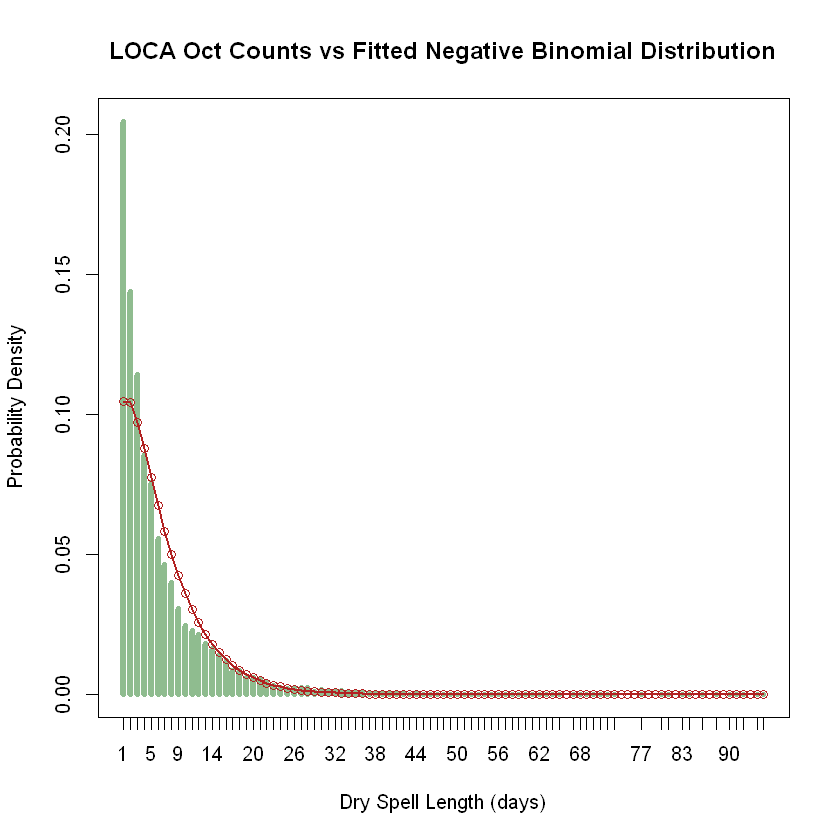

In [449]:
maxP <- max(dLOOct$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dOct_size, mu=LOfdNB_dOct_mu )
ttab <- table( dLOOct$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

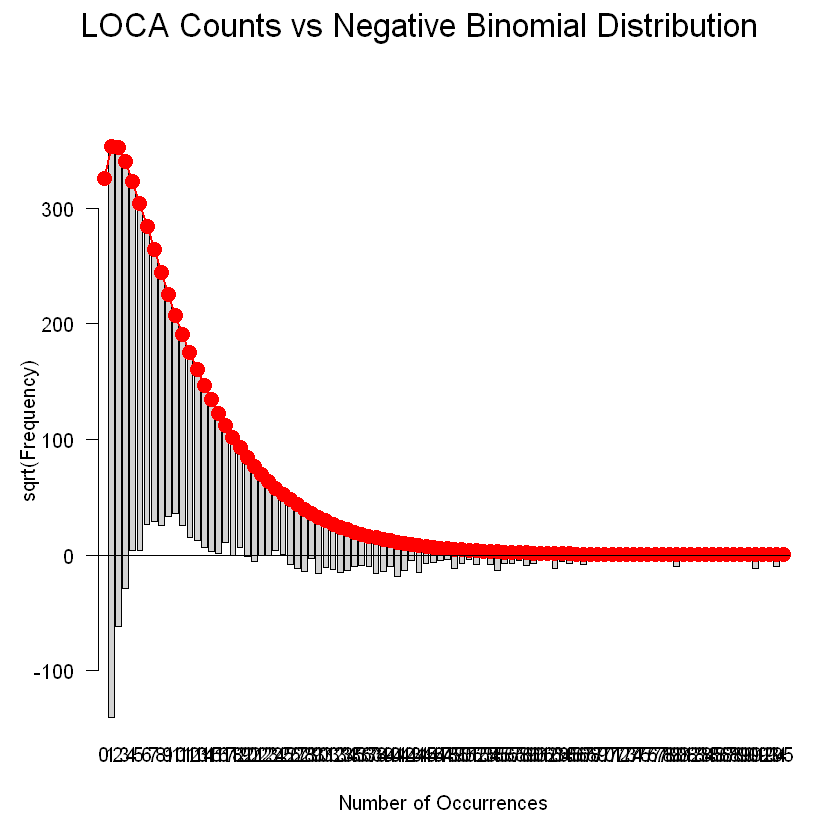

In [450]:
plot( LOgf_dOct, main="LOCA Counts vs Negative Binomial Distribution" )

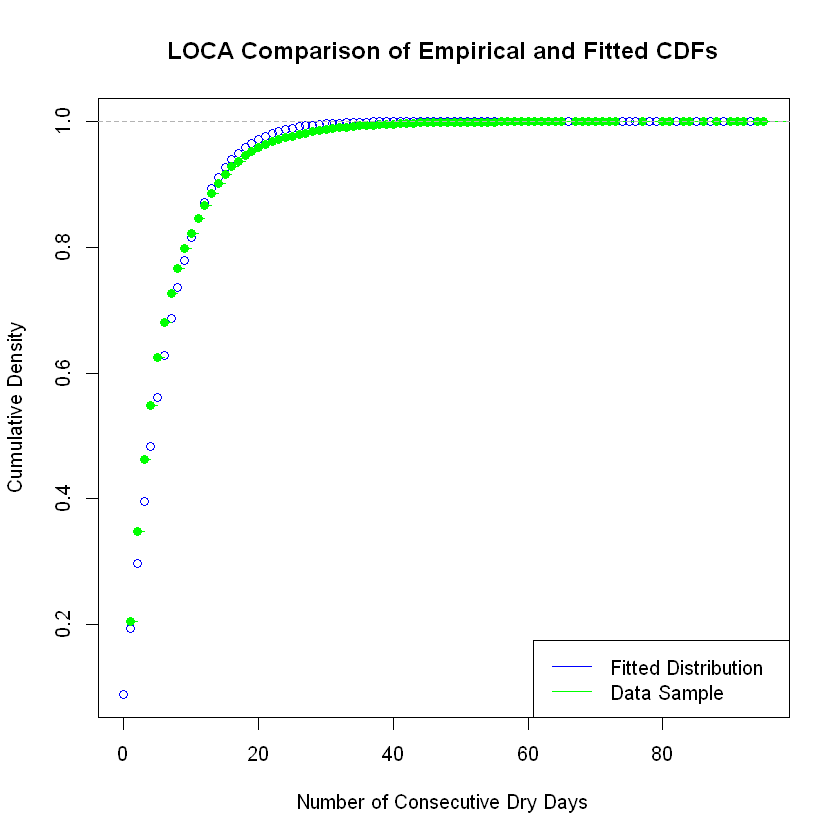

In [451]:
x <- seq(0,dLOOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dOct_mu, size=LOfdNB_dOct_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOOct$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

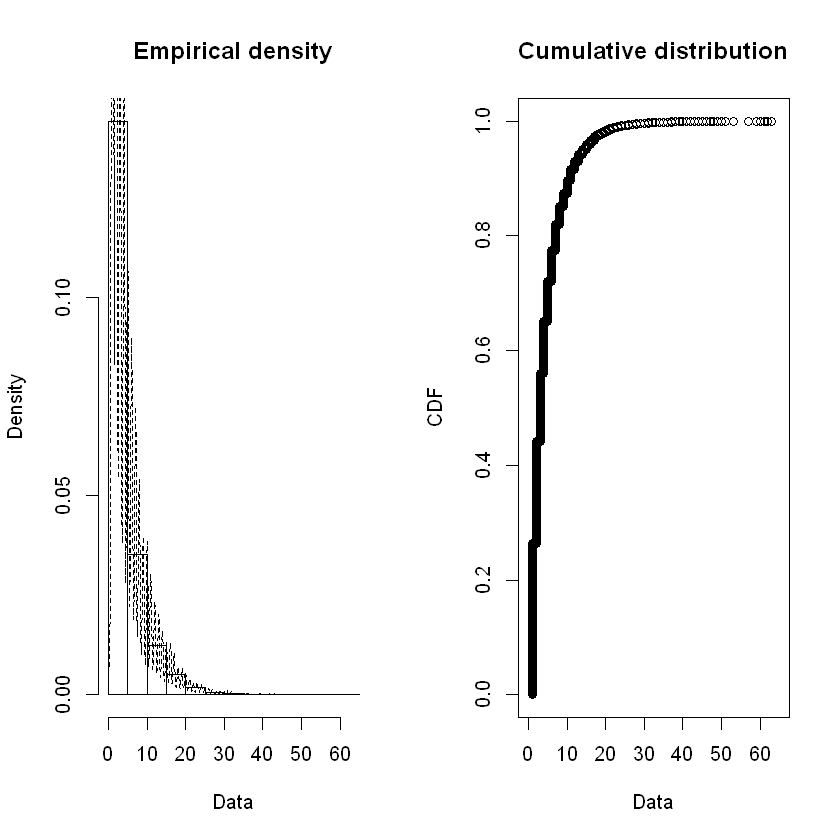

In [452]:
plotdist( dBCOct$Dry_Count, histo=TRUE, demp=TRUE )

In [453]:
BCfd_NB_dOct <- fitdist( dBCOct$Dry_Count, "nbinom" )
BCfd_GE_dOct <- fitdist( dBCOct$Dry_Count, "geom" )

In [454]:
summary( BCfd_NB_dOct )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.766480 0.003804986
mu   4.652368 0.004774699
Loglikelihood:  -1919830   AIC:  3839663   BIC:  3839686 
Correlation matrix:
              size            mu
size  1.000000e+00 -2.511556e-06
mu   -2.511556e-06  1.000000e+00


In [455]:
BCfdNB_dOct_size <- BCfd_NB_dOct$estimate[["size"]]
BCfdNB_dOct_mu <- BCfd_NB_dOct$estimate[["mu"]]
cat("BCCA Oct size: ", BCfdNB_dOct_size, "\n", "BCCA Oct mu: ", BCfdNB_dOct_mu, "\n")

BCCA Oct size:  1.76648 
 BCCA Oct mu:  4.652368 


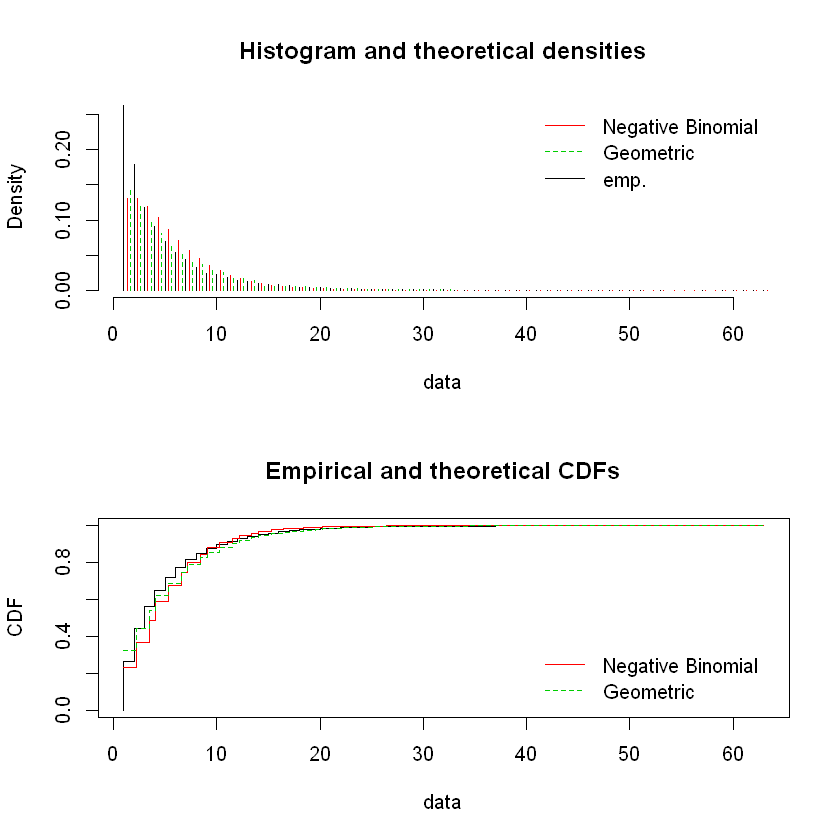

In [456]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )

In [457]:
BCstatRes <- gofstat( list(BCfd_NB_dOct, BCfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [458]:
print(BCstatRes)

Chi-squared statistic:  66483.96 37702.39 
Degree of freedom of the Chi-squared distribution:  22 23 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     194966            173096.0731     239170.824
<= 2     132598             97437.8444      88876.885
<= 3      87813             88666.3987      73153.031
<= 4      67668             76579.7308      60210.999
<= 5      51542             64013.5035      49558.635
<= 6      40253             52323.9016      40790.858
<= 7      32750             42076.8556      33574.252
<= 8      24088             33419.1579      27634.388
<= 9      17149             26285.0025      22745.388
<= 10     16399             20511.5615      18721.337
<= 11     13374             15902.6522      15409.209
<= 12     10619             12262.4272      12683.055
<= 13      9122              9411.8058      10439.204
<= 14      7023              7195.1336       8592.328
<= 15      5781              5481.4986    

In [459]:
BCfdNB_dOct_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [460]:
BCfdNB_dOct_p = BCfdNB_dOct_size / (BCfdNB_dOct_size + BCfdNB_dOct_mu)
cat("BCCA prob: ", BCfdNB_dOct_p)

BCCA prob:  0.2752021

In [461]:
# add to our tracking dataframe
BCMonDistDF[10, ] <- list( 10, dBCOctMean, dBCOctBNr, BCfdNB_dOct_p, BCfdNB_dOct_mu, BCfdNB_dOct_size,
                          BCfdNB_dOct_pvalue )

In [462]:
BCgf_dOct <- goodfit( dBCOct$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dOct_size, prob=BCfdNB_dOct_p) )

In [463]:
summary( BCgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          348227.3 63        0
Likelihood Ratio 273825.9 57        0


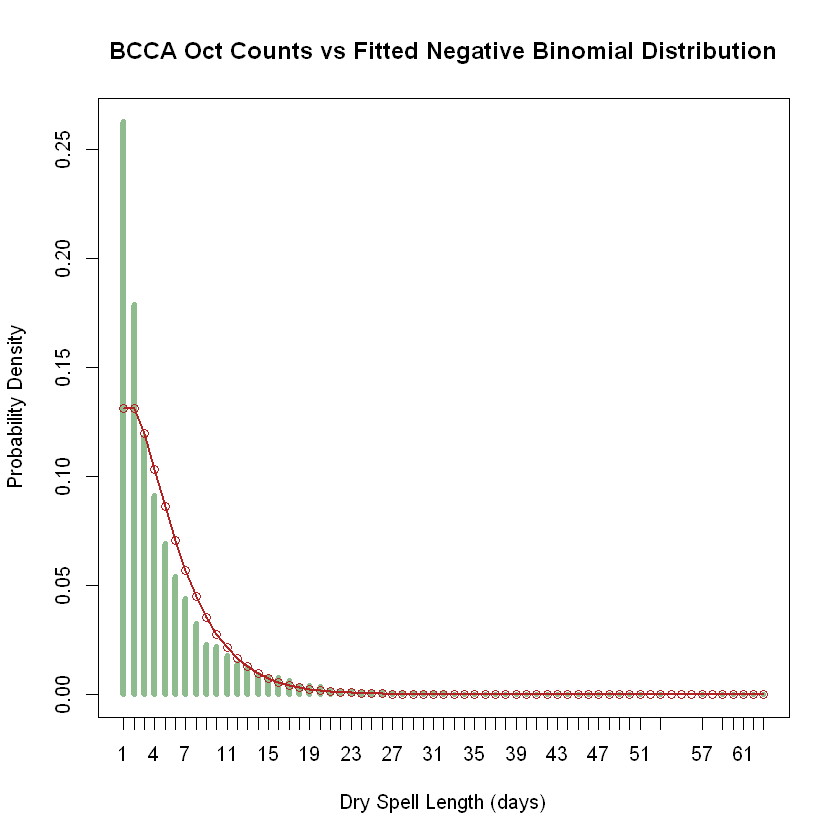

In [464]:
maxP <- max(dBCOct$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dOct_size, mu=BCfdNB_dOct_mu )
ttab <- table( dBCOct$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

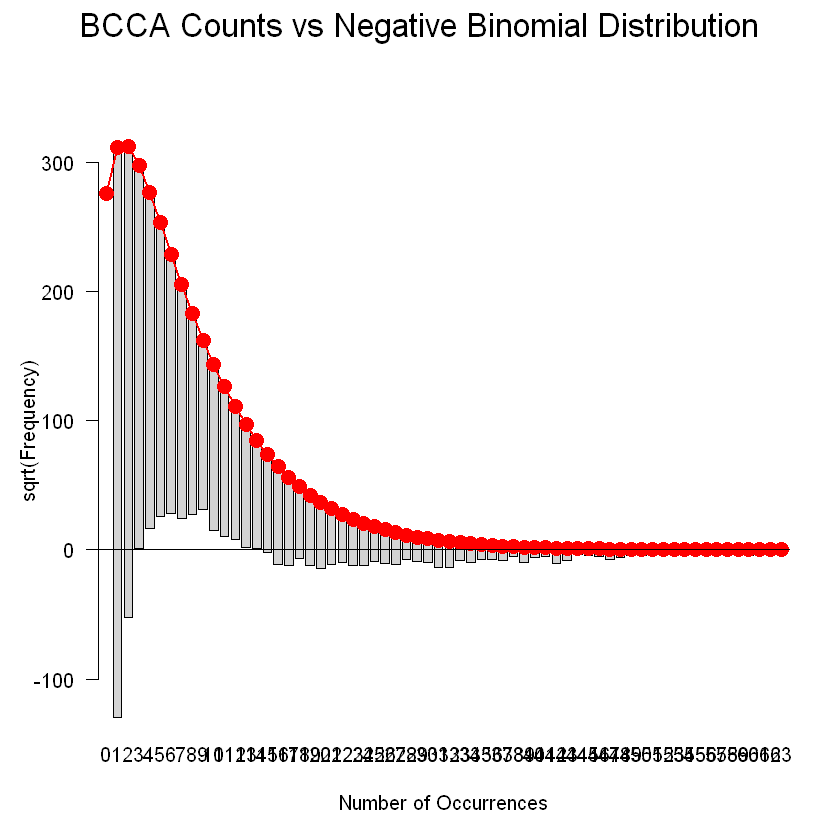

In [465]:
plot( BCgf_dOct, main="BCCA Counts vs Negative Binomial Distribution" )

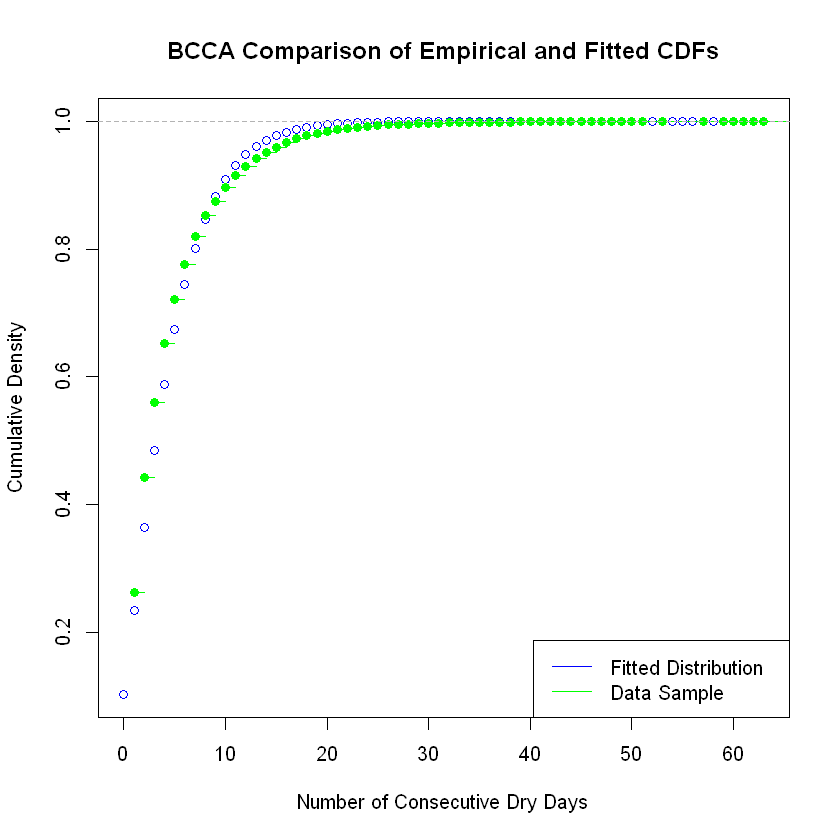

In [466]:
x <- seq(0,dBCOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dOct_mu, size=BCfdNB_dOct_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCOct$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

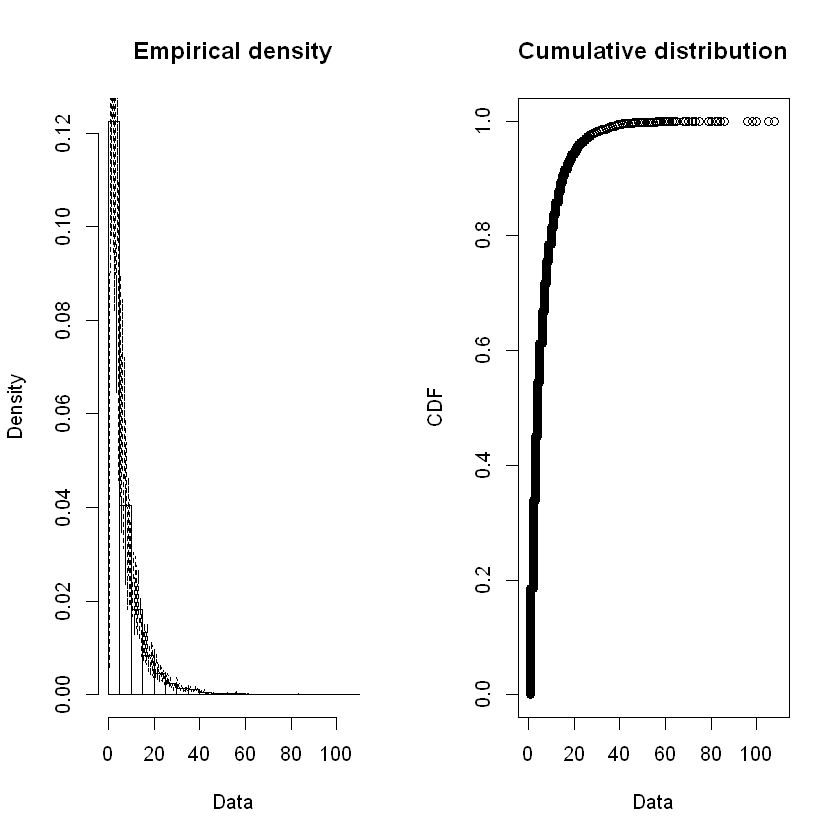

In [467]:
plotdist( dLONov$Dry_Count, histo=TRUE, demp=TRUE )

In [468]:
LOfd_NB_dNov <- fitdist( dLONov$Dry_Count, "nbinom" )
LOfd_GE_dNov <- fitdist( dLONov$Dry_Count, "geom" )

In [469]:
LOfdNB_dNov_size <- LOfd_NB_dNov$estimate[["size"]]
LOfdNB_dNov_mu <- LOfd_NB_dNov$estimate[["mu"]]
cat("LOCA Nov size: ", LOfdNB_dNov_size, "\n", "LOCA Nov mu: ", LOfdNB_dNov_mu, "\n")

LOCA Nov size:  1.41077 
 LOCA Nov mu:  6.53802 


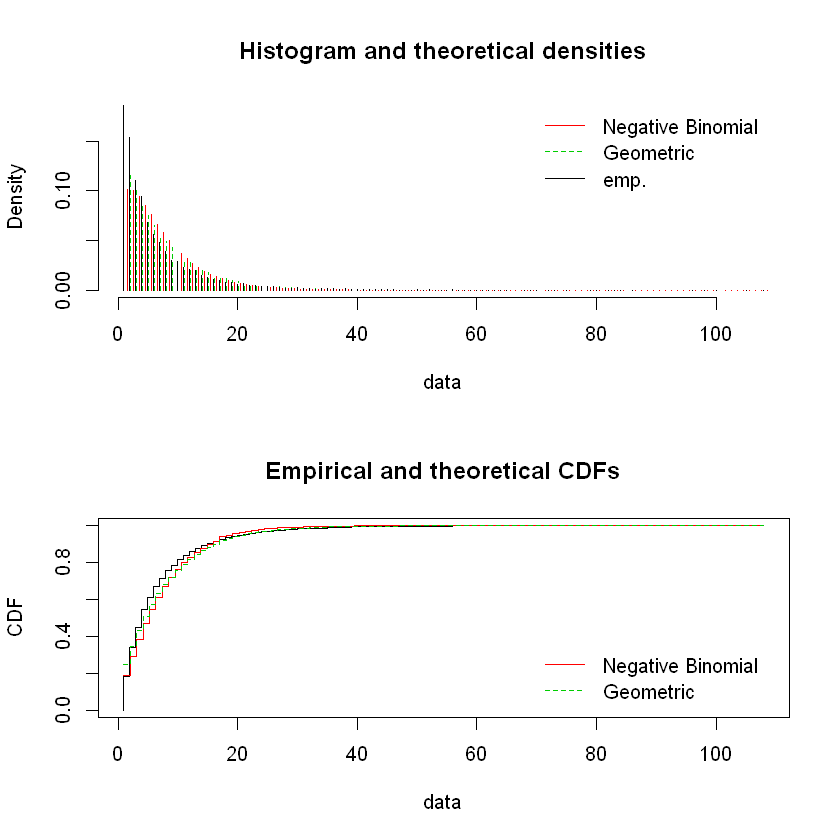

In [470]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )

In [471]:
LOstatRes <- gofstat( list(LOfd_NB_dNov, LOfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [472]:
print( LOstatRes )

Chi-squared statistic:  129236.5 79538.53 
Degree of freedom of the Chi-squared distribution:  33 34 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     213271           216707.42926    284865.7871
<= 2     176413           115402.59318    114757.0450
<= 3     127186           107917.53267     99530.9445
<= 4     108735            97879.48476     86325.0610
<= 5      78644            87121.62785     74871.3498
<= 6      64198            76564.97747     64937.3305
<= 7      55483            66671.56991     56321.3687
<= 8      44886            57654.29634     48848.5828
<= 9      34806            49586.05386     42367.2951
<= 10     33311            42460.74595     36745.9522
<= 11     26405            36228.89635     31870.4558
<= 12     24124            30818.94743     27641.8460
<= 13     22335            26150.10153     23974.2932
<= 14     16908            22140.00655     20793.3556
<= 15     14389            18709.23535    

In [473]:
LOfdNB_dNov_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [474]:
LOfdNB_dNov_p = LOfdNB_dNov_size / (LOfdNB_dNov_size + LOfdNB_dNov_mu)
cat("LOCA prob: ", LOfdNB_dNov_p)

LOCA prob:  0.1774824

In [475]:
# add to our tracking dataframe
LOMonDistDF[11, ] <- list( 11, dLONovMean, dLONovBNr, LOfdNB_dNov_p, LOfdNB_dNov_mu, LOfdNB_dNov_size,
                          LOfdNB_dNov_pvalue )

In [476]:
LOgf_dNov <- goodfit( dLONov$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dNov_size, prob=LOfdNB_dNov_p) )

In [477]:
summary( LOgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                       X^2  df P(> X^2)
Pearson          6229262.1 108        0
Likelihood Ratio  354656.9  81        0


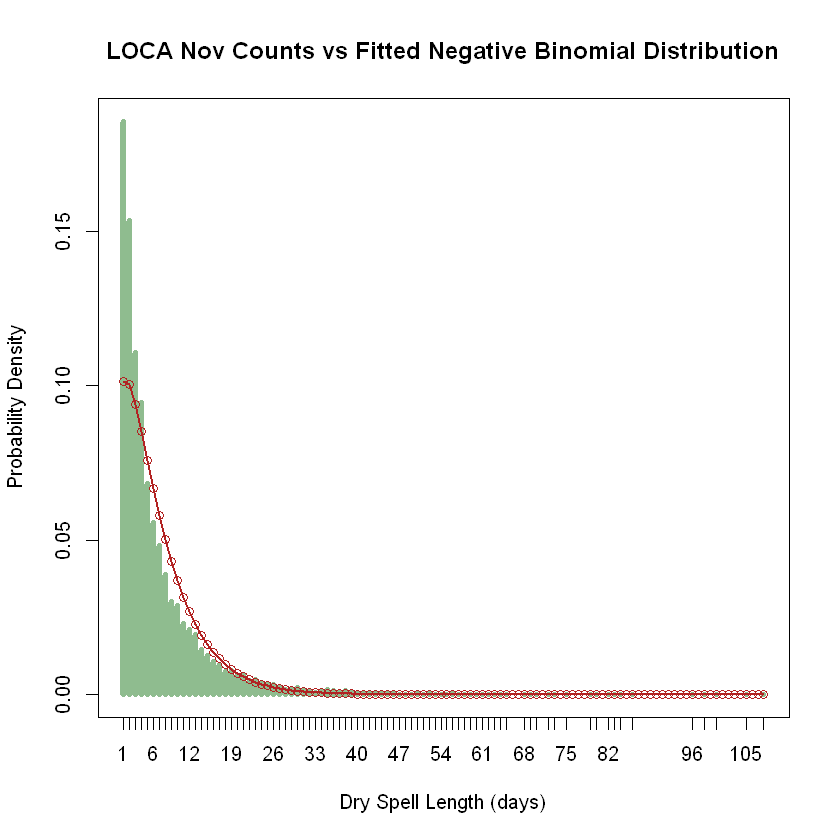

In [478]:
maxP <- max(dLONov$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dNov_size, mu=LOfdNB_dNov_mu )
ttab <- table( dLONov$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

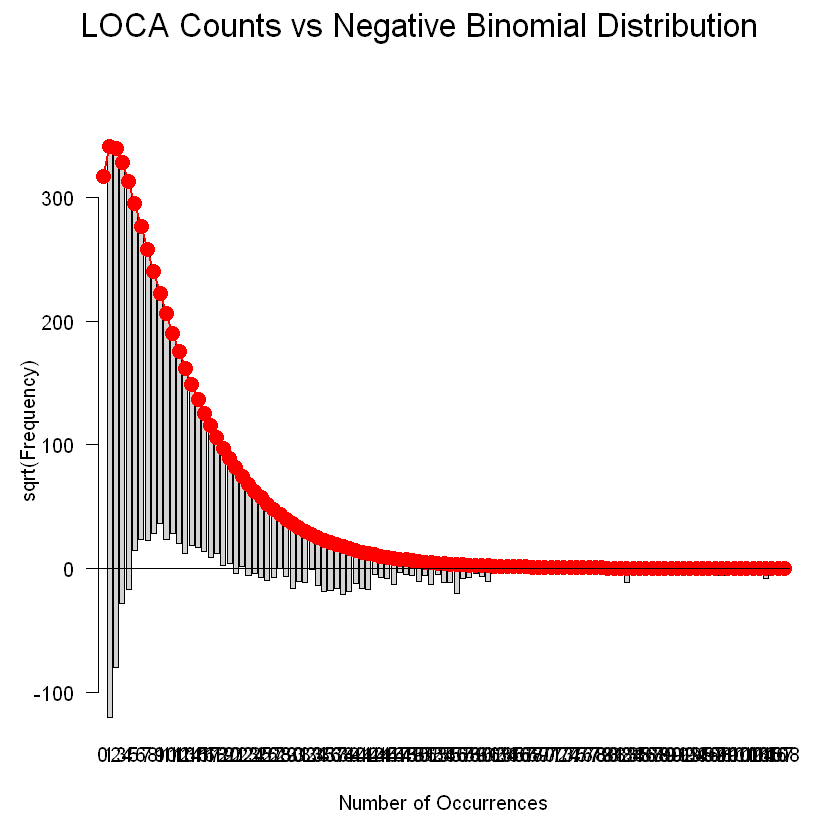

In [479]:
plot( LOgf_dNov, main="LOCA Counts vs Negative Binomial Distribution" )

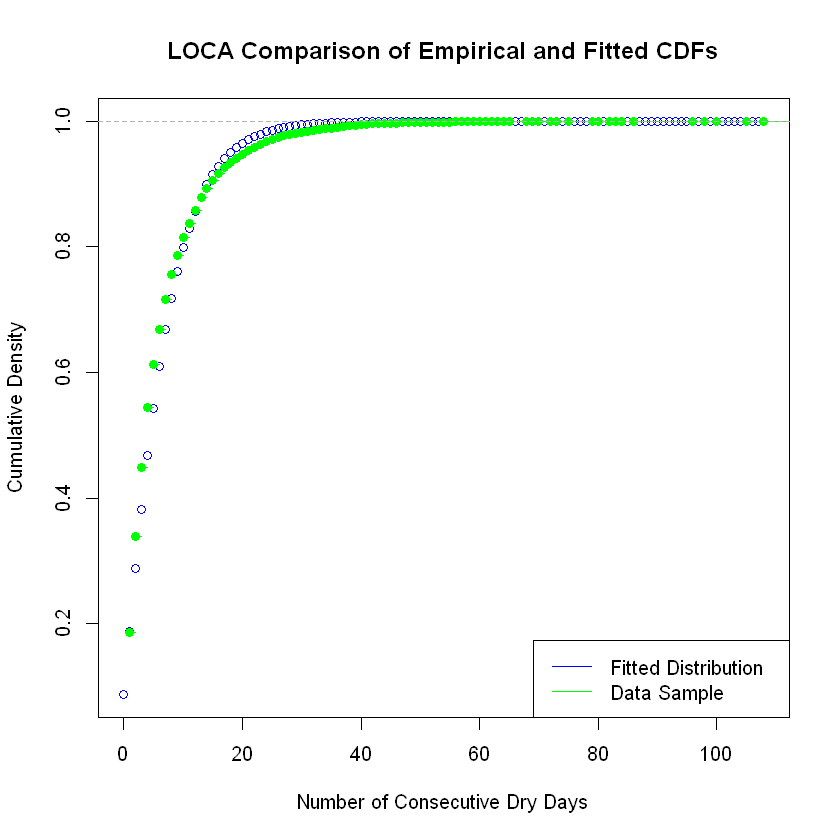

In [480]:
x <- seq(0,dLONovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dNov_mu, size=LOfdNB_dNov_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLONov$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

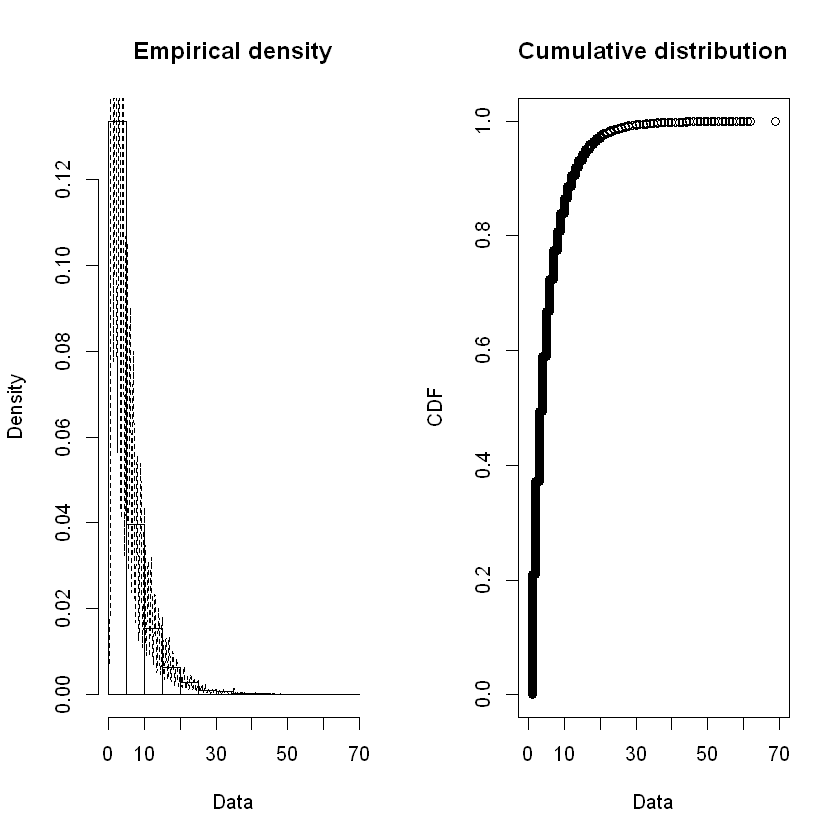

In [481]:
plotdist( dBCNov$Dry_Count, histo=TRUE, demp=TRUE )

In [482]:
BCfd_NB_dNov <- fitdist( dBCNov$Dry_Count, "nbinom" )
BCfd_GE_dNov <- fitdist( dBCNov$Dry_Count, "geom" )

In [483]:
summary( BCfd_NB_dNov )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.710308 0.003661023
mu   5.411843 0.005722322
Loglikelihood:  -1878209   AIC:  3756422   BIC:  3756445 
Correlation matrix:
            size          mu
size 1.00000e+00 7.25399e-05
mu   7.25399e-05 1.00000e+00


In [484]:
BCfdNB_dNov_size <- BCfd_NB_dNov$estimate[["size"]]
BCfdNB_dNov_mu <- BCfd_NB_dNov$estimate[["mu"]]
cat("BCCA Nov size: ", BCfdNB_dNov_size, "\n", "BCCA Nov mu: ", BCfdNB_dNov_mu, "\n")

BCCA Nov size:  1.710308 
 BCCA Nov mu:  5.411843 


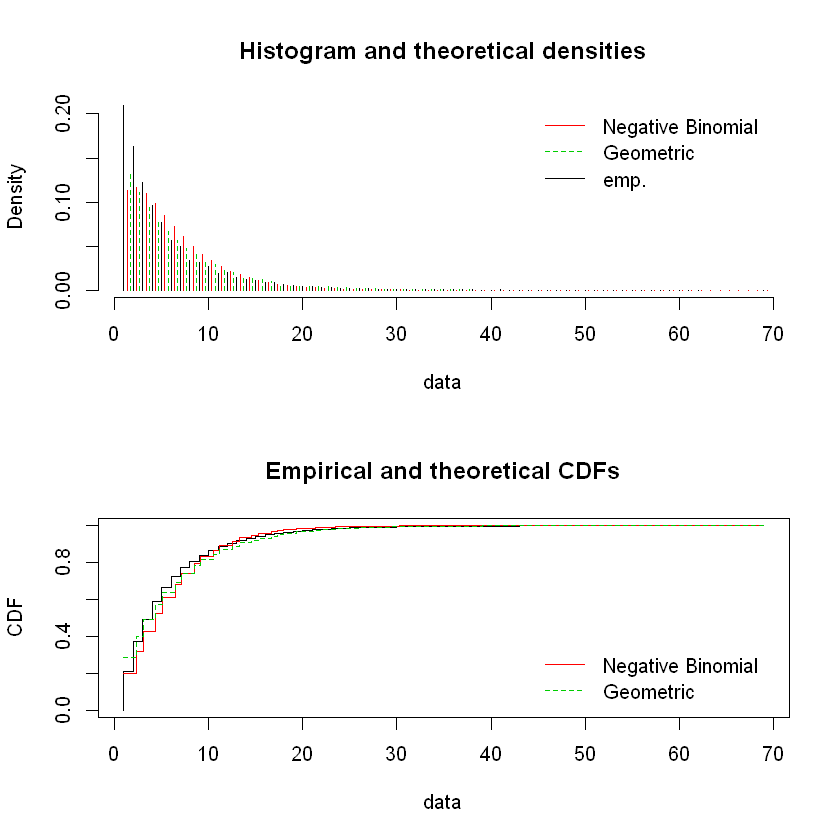

In [485]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )

In [486]:
BCstatRes <- gofstat( list(BCfd_NB_dNov, BCfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [487]:
print(BCstatRes)

Chi-squared statistic:  57844.11 44573.44 
Degree of freedom of the Chi-squared distribution:  24 25 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     144005            137960.3259     197912.295
<= 2     111852             80284.8505      76459.648
<= 3      83879             75449.4876      64535.367
<= 4      66493             67511.7870      54470.740
<= 5      53175             58587.2528      45975.745
<= 6      38738             49788.4199      38805.588
<= 7      34427             41671.2031      32753.654
<= 8      23439             34475.7384      27645.551
<= 9      21839             28264.2904      23334.083
<= 10     18220             23002.4482      19695.011
<= 11     13394             18607.3151      16623.472
<= 12     13644             14975.8871      14030.955
<= 13     10154             12001.3592      11842.754
<= 14      8205              9582.0446       9995.815
<= 15      7357              7625.8042    

In [488]:
BCfdNB_dNov_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [489]:
BCfdNB_dNov_p = BCfdNB_dNov_size / (BCfdNB_dNov_size + BCfdNB_dNov_mu)
cat("BCCA prob: ", BCfdNB_dNov_p)

BCCA prob:  0.2401392

In [490]:
# add to our tracking dataframe
BCMonDistDF[11, ] <- list( 11, dBCNovMean, dBCNovBNr, BCfdNB_dNov_p, BCfdNB_dNov_mu, BCfdNB_dNov_size,
                          BCfdNB_dNov_pvalue )

In [491]:
BCgf_dNov <- goodfit( dBCNov$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dNov_size, prob=BCfdNB_dNov_p) )

In [492]:
summary( BCgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          214467.3 69        0
Likelihood Ratio 205485.6 62        0


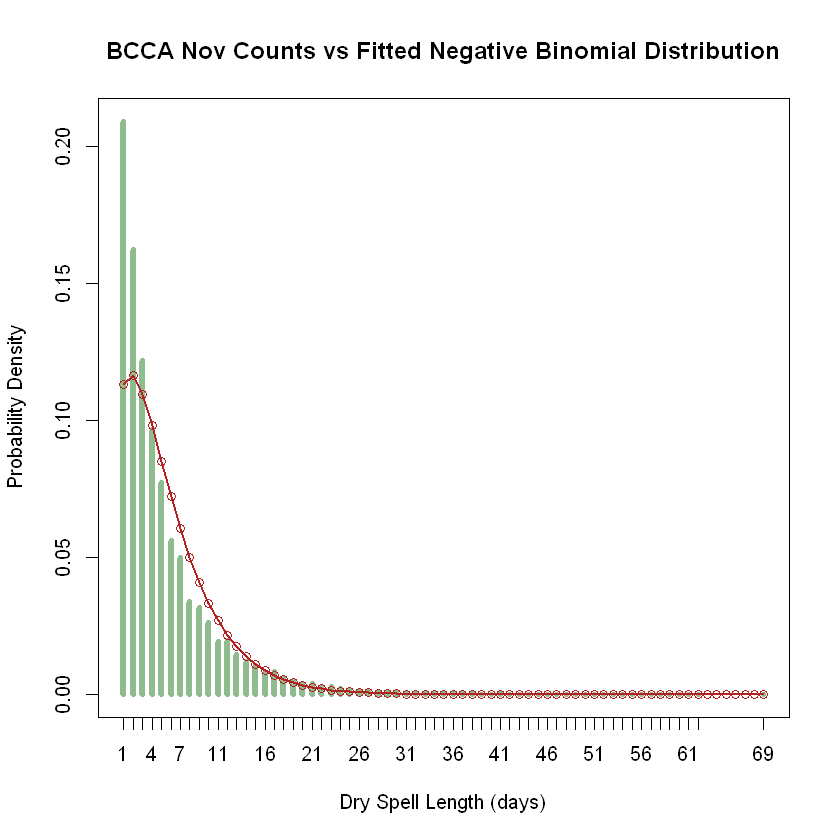

In [493]:
maxP <- max(dBCNov$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dNov_size, mu=BCfdNB_dNov_mu )
ttab <- table( dBCNov$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

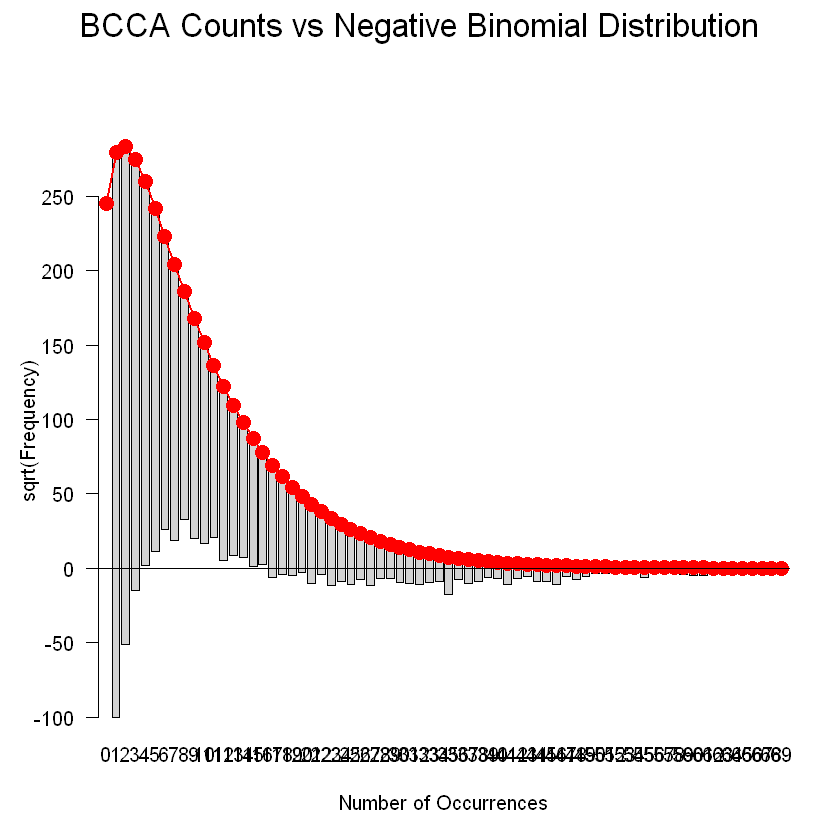

In [494]:
plot( BCgf_dNov, main="BCCA Counts vs Negative Binomial Distribution" )

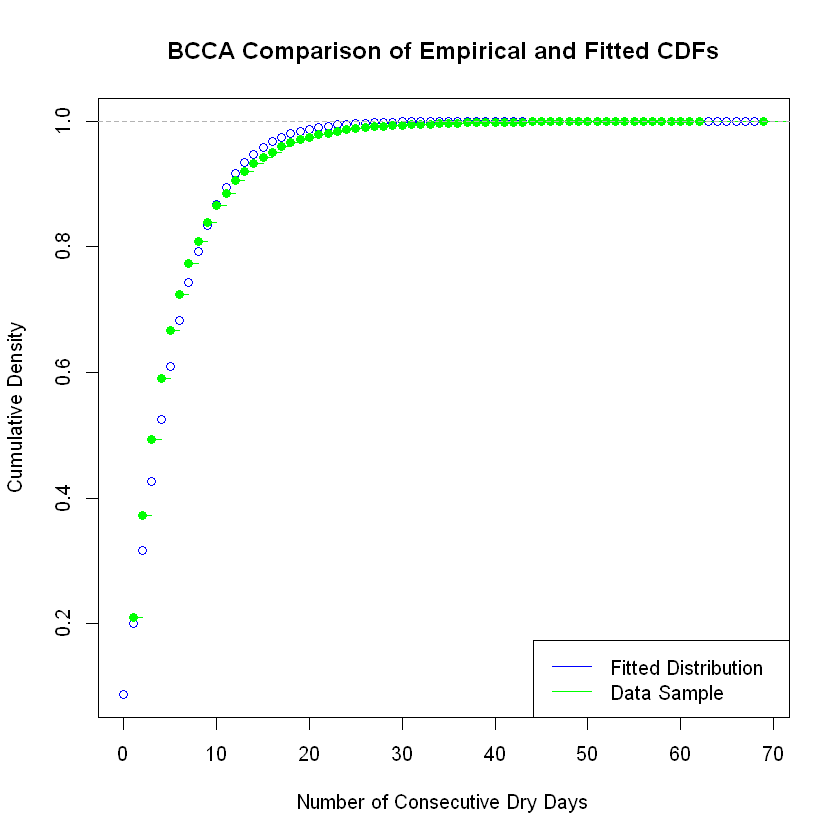

In [495]:
x <- seq(0,dBCNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dNov_mu, size=BCfdNB_dNov_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCNov$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

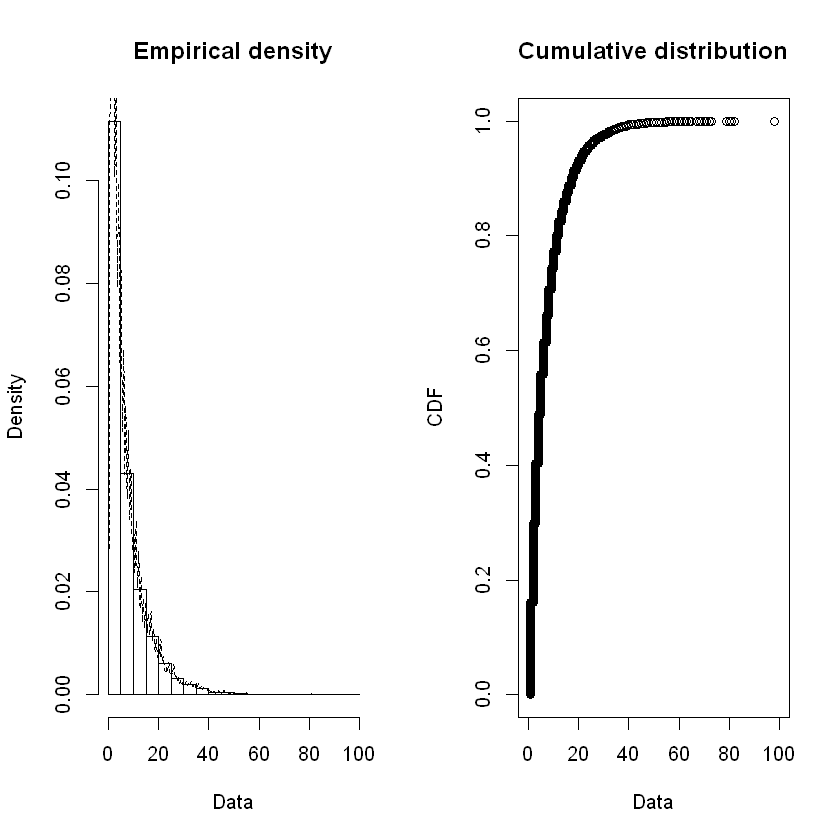

In [496]:
plotdist( dLODec$Dry_Count, histo=TRUE, demp=TRUE )

In [497]:
LOfd_NB_dDec <- fitdist( dLODec$Dry_Count, "nbinom" )
LOfd_GE_dDec <- fitdist( dLODec$Dry_Count, "geom" )

In [498]:
LOfdNB_dDec_size <- LOfd_NB_dDec$estimate[["size"]]
LOfdNB_dDec_mu <- LOfd_NB_dDec$estimate[["mu"]]
cat("LOCA Dec size: ", LOfdNB_dDec_size, "\n", "LOCA Dec mu: ", LOfdNB_dDec_mu, "\n")

LOCA Dec size:  1.399783 
 LOCA Dec mu:  7.38652 


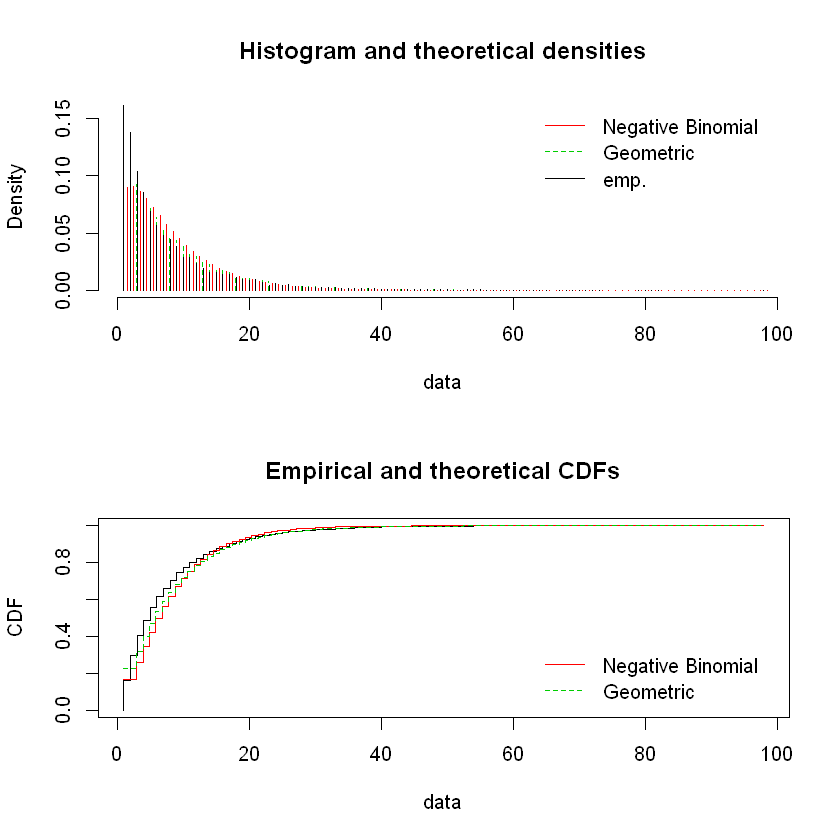

In [499]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )

In [500]:
LOstatRes <- gofstat( list(LOfd_NB_dDec, LOfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [501]:
print( LOstatRes )

Chi-squared statistic:  71571.01 60314.09 
Degree of freedom of the Chi-squared distribution:  35 36 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     175460            181067.7139     244035.257
<= 2     150245             98740.9059     100654.787
<= 3     112715             94072.0855      88652.719
<= 4      93160             86989.2831      78081.777
<= 5      75207             78977.9330      68771.313
<= 6      61359             70819.5995      60571.028
<= 7      51802             62937.3007      53348.545
<= 8      48127             55554.5831      46987.269
<= 9      41500             48778.5527      41384.512
<= 10     31568             42646.8429      36449.826
<= 11     31140             37155.6174      32103.552
<= 12     24971             32276.8406      28275.528
<= 13     20661             27969.1408      24903.956
<= 14     17301             24184.7015      21934.411
<= 15     16951             20873.6198    

In [502]:
LOfdNB_dDec_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [503]:
LOfdNB_dDec_p = LOfdNB_dDec_size / (LOfdNB_dDec_size + LOfdNB_dDec_mu)
cat("LOCA prob: ", LOfdNB_dDec_p)

LOCA prob:  0.1593142

In [504]:
# add to our tracking dataframe
LOMonDistDF[12, ] <- list( 12, dLODecMean, dLODecBNr, LOfdNB_dDec_p, LOfdNB_dDec_mu, LOfdNB_dDec_size,
                           LOfdNB_dDec_pvalue )

In [505]:
LOgf_dDec <- goodfit( dLODec$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dDec_size, prob=LOfdNB_dDec_p) )

In [506]:
summary( LOgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          289903.6 98        0
Likelihood Ratio 280037.2 76        0


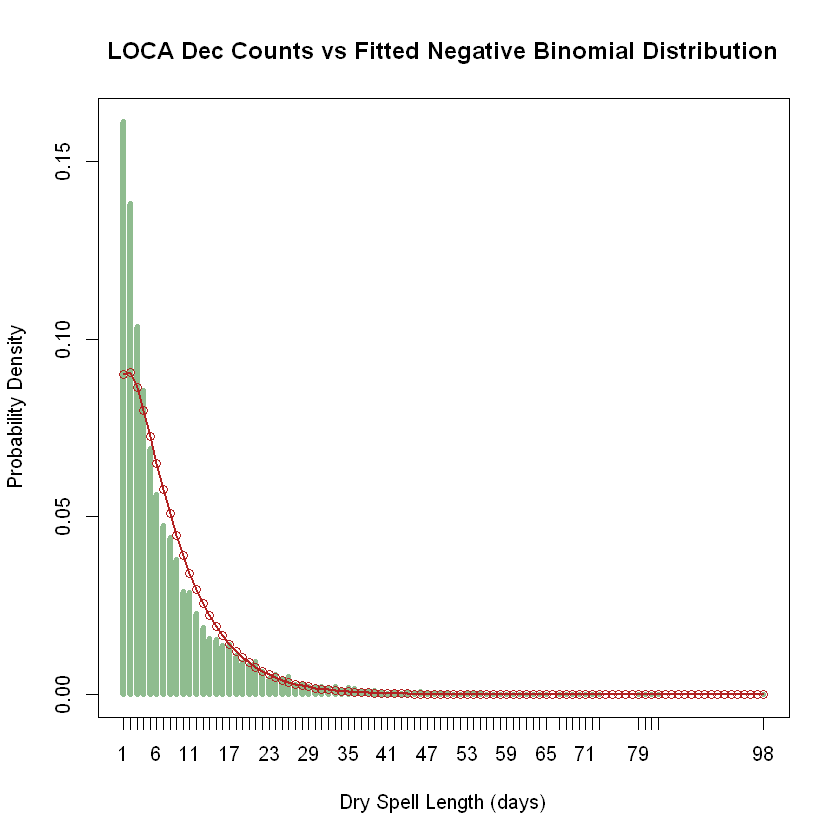

In [507]:
maxP <- max(dLODec$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dDec_size, mu=LOfdNB_dDec_mu )
ttab <- table( dLODec$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="LOCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

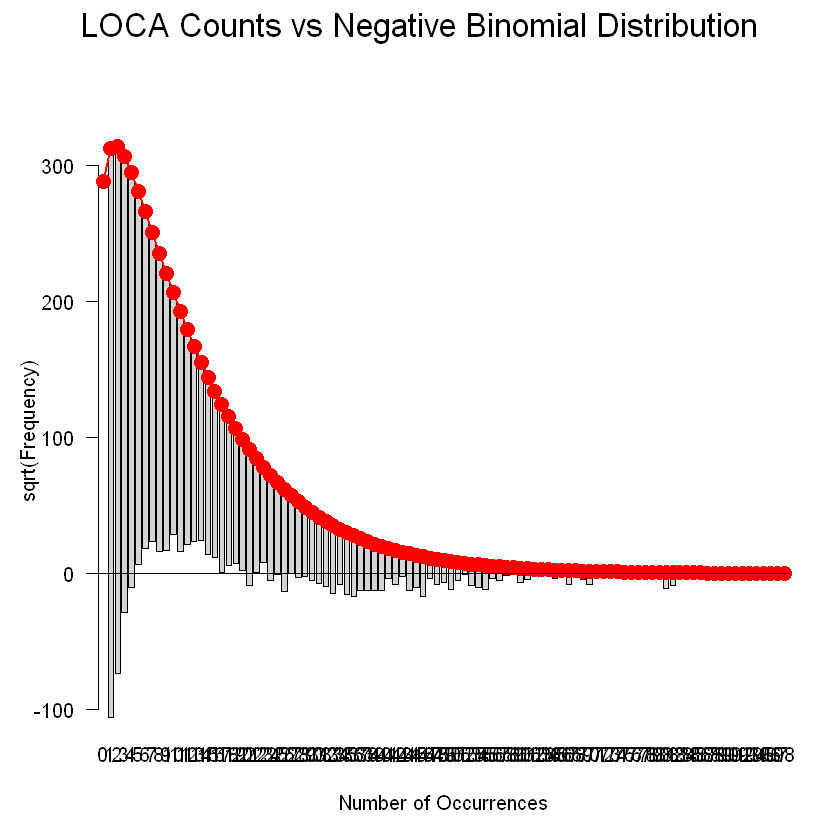

In [508]:
plot( LOgf_dDec, main="LOCA Counts vs Negative Binomial Distribution" )

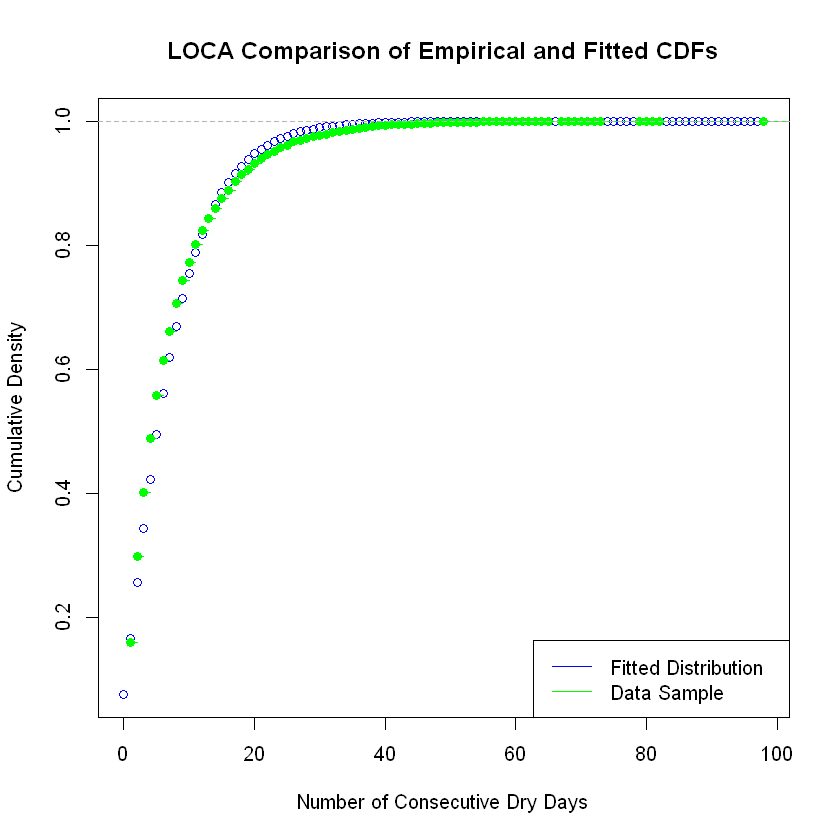

In [509]:
x <- seq(0,dLODecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dDec_mu, size=LOfdNB_dDec_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLODec$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

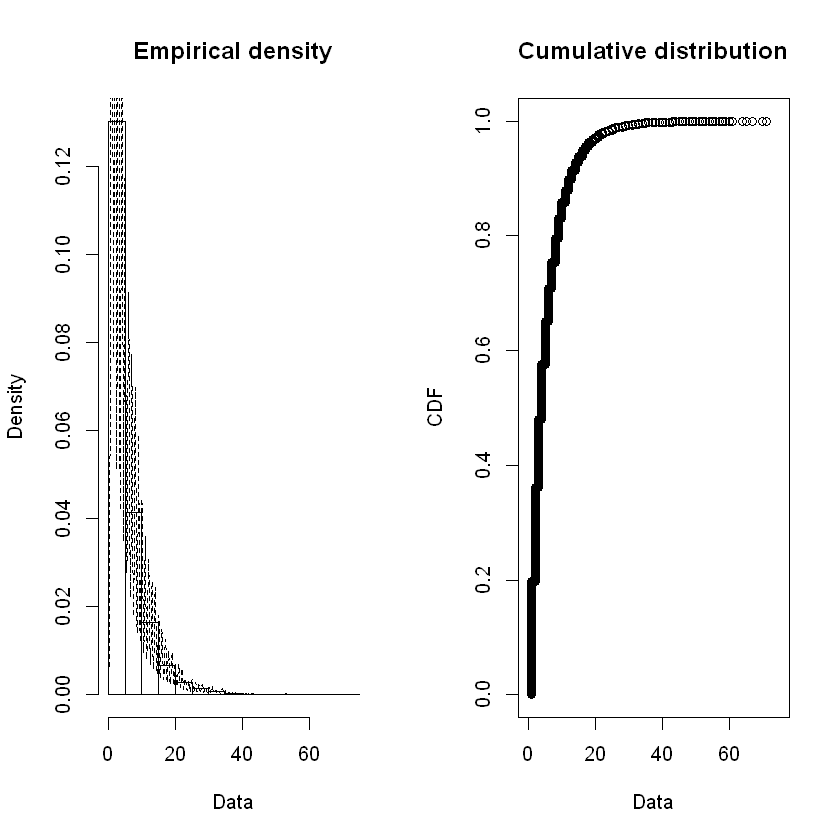

In [510]:
plotdist( dBCDec$Dry_Count, histo=TRUE, demp=TRUE )

In [511]:
BCfd_NB_dDec <- fitdist( dBCDec$Dry_Count, "nbinom" )
BCfd_GE_dDec <- fitdist( dBCDec$Dry_Count, "geom" )

In [512]:
summary( BCfd_NB_dDec )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 1.709438 0.003681761
mu   5.595613 0.005967641
Loglikelihood:  -1852959   AIC:  3705921   BIC:  3705944 
Correlation matrix:
              size            mu
size  1.000000e+00 -2.926136e-05
mu   -2.926136e-05  1.000000e+00


In [513]:
BCfdNB_dDec_size <- BCfd_NB_dDec$estimate[["size"]]
BCfdNB_dDec_mu <- BCfd_NB_dDec$estimate[["mu"]]
cat("BCCA Dec size: ", BCfdNB_dDec_size, "\n", "BCCA Dec mu: ", BCfdNB_dDec_mu, "\n")

BCCA Dec size:  1.709438 
 BCCA Dec mu:  5.595613 


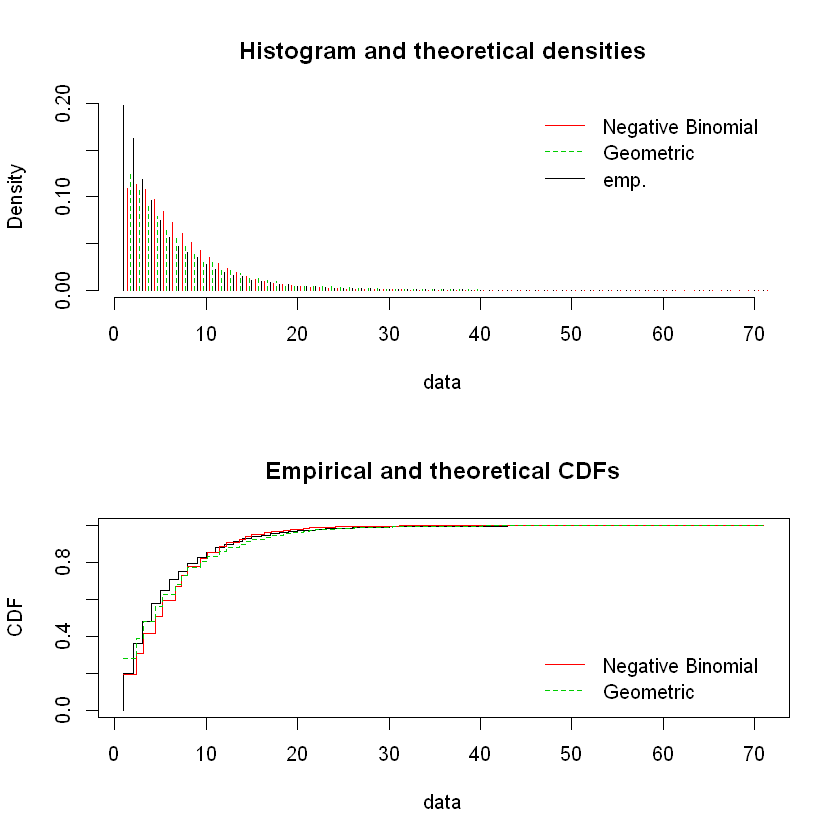

In [514]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )

In [515]:
BCstatRes <- gofstat( list(BCfd_NB_dDec, BCfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [516]:
print(BCstatRes)

Chi-squared statistic:  48036.65 45214.14 
Degree of freedom of the Chi-squared distribution:  25 26 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     132730            129499.1058     188178.534
<= 2     109415             76193.1632      73275.864
<= 3      80009             72165.1140      62165.897
<= 4      64656             65081.9897      52740.405
<= 5      50435             56925.7289      44743.991
<= 6      38004             48760.4731      37959.980
<= 7      31214             41135.5212      32204.550
<= 8      27353             34303.7470      27321.748
<= 9      23687             28347.6820      23179.269
<= 10     18391             23254.5876      19664.866
<= 11     15135             18961.6626      16683.311
<= 12     12567             15383.1728      14153.815
<= 13     10248             12426.4370      12007.837
<= 14      9576             10000.8997      10187.228
<= 15      7326              8022.9274    

In [517]:
BCfdNB_dDec_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [518]:
BCfdNB_dDec_p = BCfdNB_dDec_size / (BCfdNB_dDec_size + BCfdNB_dDec_mu)
cat("BCCA prob: ", BCfdNB_dDec_p)

BCCA prob:  0.2340077

In [519]:
# add to our tracking dataframe
BCMonDistDF[12, ] <- list( 12, dBCDecMean, dBCDecBNr, BCfdNB_dDec_p, BCfdNB_dDec_mu, BCfdNB_dDec_size,
                           BCfdNB_dDec_pvalue )

In [520]:
BCgf_dDec <- goodfit( dBCDec$Dry_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dDec_size, prob=BCfdNB_dDec_p) )

In [521]:
summary( BCgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          213161.0 71        0
Likelihood Ratio 188948.1 65        0


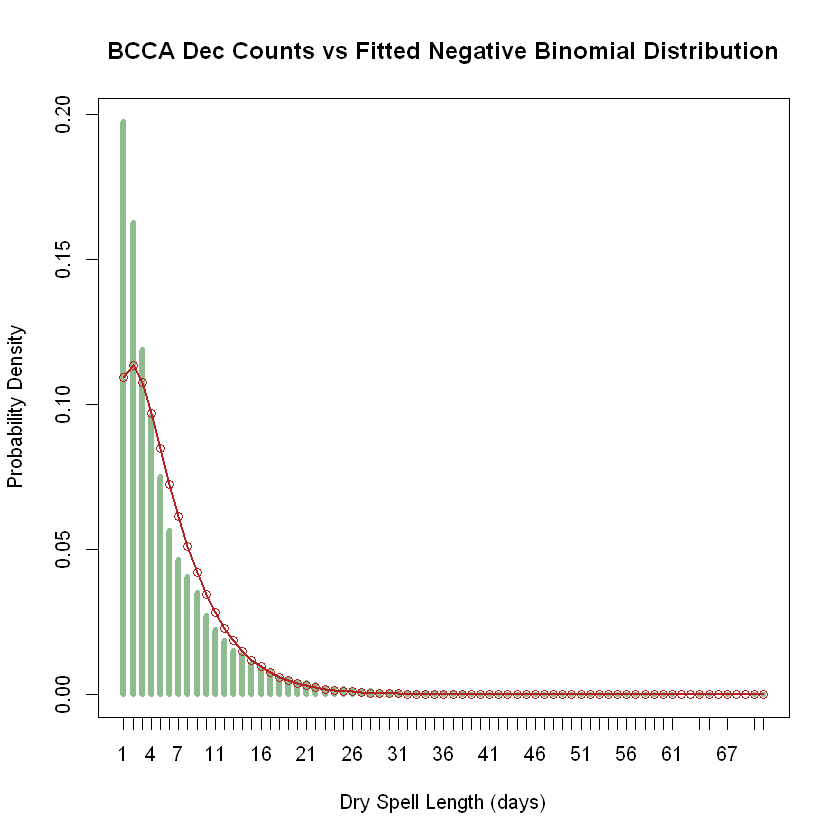

In [522]:
maxP <- max(dBCDec$Dry_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dDec_size, mu=BCfdNB_dDec_mu )
ttab <- table( dBCDec$Dry_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Dry Spell Length (days)", ylab="Probability Density",
      main="BCCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

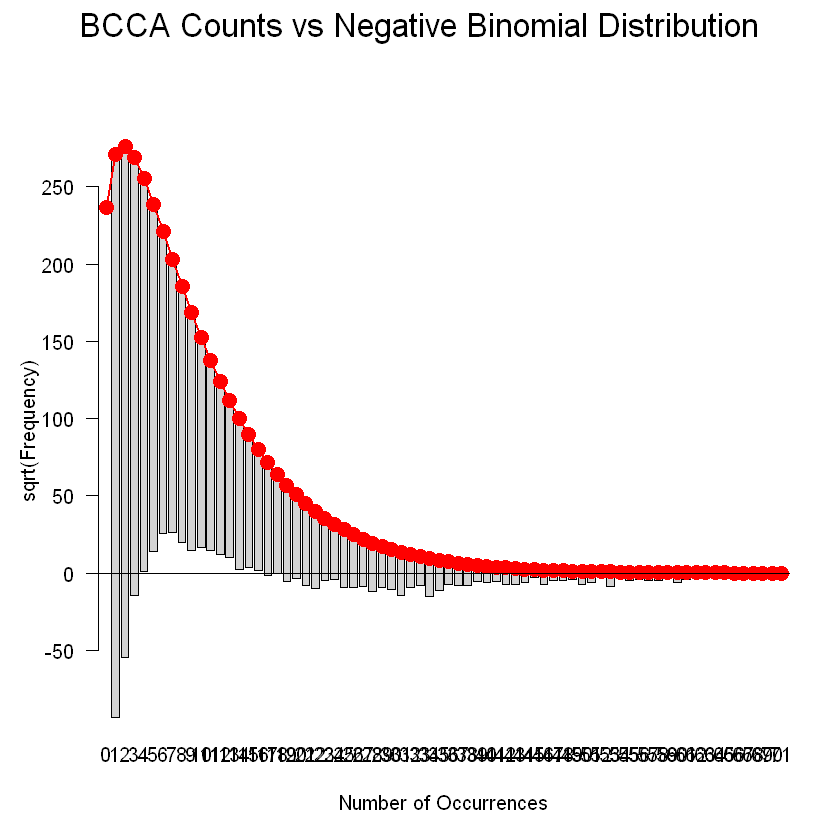

In [523]:
plot( BCgf_dDec, main="BCCA Counts vs Negative Binomial Distribution" )

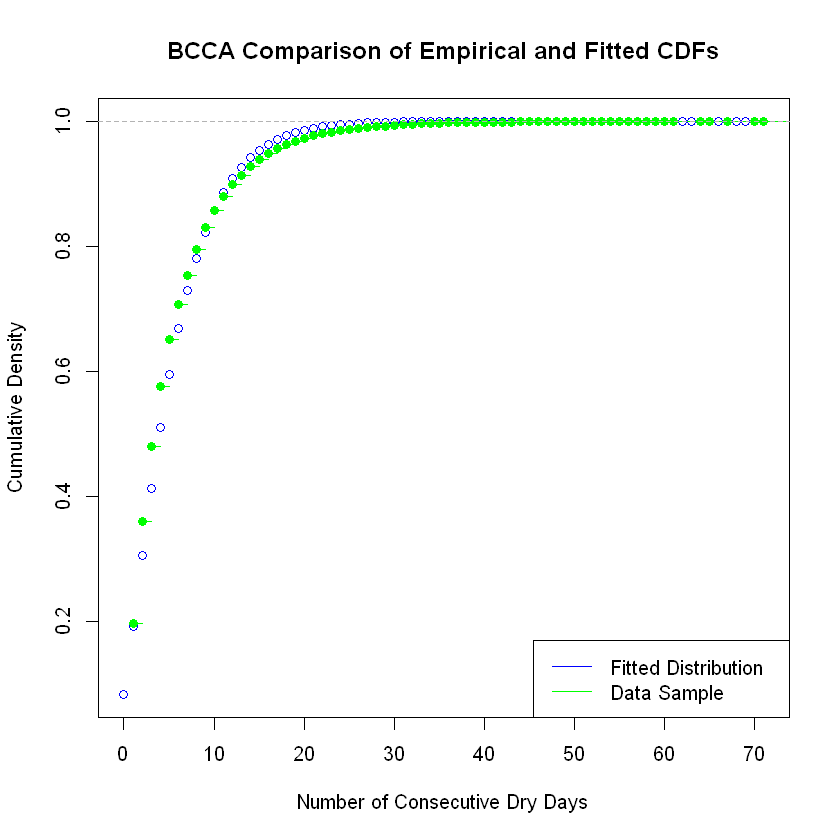

In [524]:
x <- seq(0,dBCDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dDec_mu, size=BCfdNB_dDec_size),
     xlab="Number of Consecutive Dry Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCDec$Dry_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [525]:
print( LOMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu     ssize     sprob      tmu    tsize pvalue
     1 7.600758 1.1857420 0.1661030 7.601987 1.514231      0
     2 7.007583 1.1104077 0.1833095 7.007788 1.572926      0
     3 6.988409 1.2949998 0.1899873 6.987467 1.638900      0
     4 5.137130 1.5613677 0.2910476 5.137729 2.109202      0
     5 4.141581 1.2312818 0.3304565 4.141817 2.044214      0
     6 5.525916 0.7468242 0.1910039 5.525485 1.304567      0
     7 6.813155 0.9668478 0.1641839 6.813245 1.338363      0
     8 6.144145 1.2577221 0.2070947 6.145803 1.605190      0
     9 5.095597 1.1183445 0.2483466 5.094812 1.683328      0
    10 6.233228 0.9519948 0.1888420 6.234009 1.451311      0
    11 6.536864 0.9171068 0.1774824 6.538020 1.410770      0
    12 7.386455 1.0133517 0.1593142 7.386520 1.399783      0


In [526]:
print( BCMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu    ssize     sprob      tmu    tsize pvalue
     1 5.232795 1.336154 0.2637638 5.233172 1.874835      0
     2 4.758961 1.336110 0.2955028 4.758978 1.996164      0
     3 4.552056 1.477125 0.3197119 4.552470 2.139504      0
     4 3.528720 1.849420 0.4411605 3.528137 2.785191      0
     5 2.772238 2.210170 0.5701025 2.772337 3.676495      0
     6 3.153229 1.629825 0.4645703 3.153567 2.736221      0
     7 3.326397 1.668563 0.4428658 3.326571 2.644290      0
     8 2.961173 2.194356 0.5349239 2.960953 3.405646      0
     9 3.225280 1.345049 0.4276163 3.226003 2.410082      0
    10 4.652360 1.156827 0.2752021 4.652368 1.766480      0
    11 5.412098 1.153981 0.2401392 5.411843 1.710308      0
    12 5.595507 1.177020 0.2340077 5.595613 1.709438      0


### Output to a Spreadsheet

Output the stats and distribution fits to a spreadsheet

In [527]:
outputDF_xlsx <- createWorkbook()

In [528]:
LOsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Summary_Stats")
BCsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Summary_Stats")
LOmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Dist_Properties")
BCmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Dist_Properties")

In [529]:
addDataFrame( x=MonLOSumStatDF, sheet=LOsumstat_xlsx )
addDataFrame( x=MonBCSumStatDF, sheet=BCsumstat_xlsx )
addDataFrame( x=LOMonDistDF, sheet=LOmondist_xlsx )
addDataFrame( x=BCMonDistDF, sheet=BCmondist_xlsx )

In [530]:
saveWorkbook( outputDF_xlsx, file="CMIP5_Dry_RSummary_1981-2010.xlsx" )

## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers. This part will take a long time so may need to split it out to a standalone R script. This also does not make sense so removed.

In [531]:
options(warn = oldw)